In [1]:
%matplotlib inline
# Imports
from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Custom import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
import datetime as dt
from io import StringIO

###Earnings Surprises from Zacks

Let's go over the columns:
- **symbol**: the ticker symbol of the company.
- **exchange**: what the exchange stock is currently trading 
- **eps_pct_diff_surp**: Earnings per share (EPS) surprise percent for the period
- **act_rpt_code**: Actual report time of day code (BTO - before the open, DTM - during the market, AMC - after market close)
- **asof_date**: The date to which this data applies/Actual report date
- **act_rpt_date_time**: Actual report timestamp (eastern time)
- **timestamp**: This is our timestamp on when we registered the data.



In [2]:
csv_string = """ticker,exchange,eps_pct_diff_surp,act_rpt_code,asof_date,act_rpt_date_time,timestamp
AZN,NYSE,137.25,None,2017-02-03T00:00:00,2017-02-03T04:59:59,2017-02-04T00:00:00
AGX,NYSE,46.59,AMC,2017-04-10T00:00:00,2017-04-10T20:15:00,2017-04-11T10:06:36.885594
RMD,NYSE,1.43,AMC,2017-04-27T00:00:00,2017-04-27T20:05:00,2017-04-28T10:05:58.229382
CTS,NYSE,4.0,BTO,2017-04-27T00:00:00,2017-04-27T12:00:00,2017-04-28T10:05:58.229382
TEN,NYSE,8.51,BTO,2017-05-01T00:00:00,2017-05-01T12:00:00,2017-05-02T10:05:58.921118
SFS,NYSE,-400.0,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
AZZ,NYSE,-15.66,BTO,2017-01-06T00:00:00,2017-01-06T11:30:00,2017-01-07T00:00:00
CLC,NYSE,5.71,AMC,2017-01-18T00:00:00,2017-01-18T23:18:00,2017-01-19T00:00:00
CMC,NYSE,-41.18,BTO,2017-01-09T00:00:00,2017-01-09T11:40:00,2017-01-10T00:00:00
FC,NYSE,-163.64,AMC,2017-01-05T00:00:00,2017-01-05T21:05:00,2017-01-06T00:00:00
FUL,NYSE,-1.33,AMC,2017-01-19T00:00:00,2017-01-19T00:07:00,2017-01-20T00:00:00
KBH,NYSE,8.11,AMC,2017-01-11T00:00:00,2017-01-11T21:05:00,2017-01-12T00:00:00
MSM,NYSE,2.15,BTO,2017-01-11T00:00:00,2017-01-11T11:45:00,2017-01-12T00:00:00
PKE,NYSE,-28.57,BTO,2017-01-05T00:00:00,2017-01-05T11:30:00,2017-01-06T00:00:00
RPM,NYSE,-13.33,BTO,2017-01-05T00:00:00,2017-01-05T11:45:00,2017-01-06T00:00:00
SVU,NYSE,-61.54,BTO,2017-01-11T00:00:00,2017-01-11T11:30:00,2017-01-12T00:00:00
UNF,NYSE,-12.66,BTO,2017-01-04T00:00:00,2017-01-04T13:00:00,2017-01-05T00:00:00
GBX,NYSE,-5.95,BTO,2017-01-06T00:00:00,2017-01-06T11:00:00,2017-01-07T00:00:00
SJR,NYSE,-43.48,BTO,2017-01-12T00:00:00,2017-01-12T13:00:00,2017-01-13T00:00:00
MON,NYSE,800.0,BTO,2017-01-05T00:00:00,2017-01-05T13:00:00,2017-01-06T00:00:00
GPN,NYSE,11.25,BTO,2017-01-09T00:00:00,2017-01-09T11:59:00,2017-01-10T00:00:00
AYI,NYSE,-8.74,BTO,2017-01-09T00:00:00,2017-01-09T13:30:00,2017-01-10T00:00:00
STZ,NYSE,13.95,BTO,2017-01-05T00:00:00,2017-01-05T12:30:00,2017-01-06T00:00:00
SNX,NYSE,22.97,DMT,2017-01-10T00:00:00,2017-01-10T20:15:00,2017-01-11T00:00:00
EDU,NYSE,-22.22,BTO,2017-01-17T00:00:00,2017-01-17T08:00:00,2017-01-18T00:00:00
MG,NYSE,-27.78,AMC,2017-01-04T00:00:00,2017-01-04T21:01:00,2017-01-05T00:00:00
CUDA,NYSE,100.0,AMC,2017-01-09T00:00:00,2017-01-09T21:03:00,2017-01-10T00:00:00
NORD,NYSE,-7.41,BTO,2017-01-24T00:00:00,2017-01-24T11:00:00,2017-01-25T00:00:00
LW,NYSE,14.55,BTO,2017-01-10T00:00:00,2017-01-10T13:30:00,2017-01-11T00:00:00
ARNC,NYSE,9.09,AMC,2017-01-31T00:00:00,2017-01-31T21:05:00,2017-02-01T00:00:00
ABT,NYSE,1.56,BTO,2017-01-25T00:00:00,2017-01-25T12:45:00,2017-01-26T00:00:00
ABX,NYSE,4.76,AMC,2017-02-15T00:00:00,2017-02-15T22:02:00,2017-02-16T00:00:00
AB,NYSE,39.58,BTO,2017-02-14T00:00:00,2017-02-14T11:48:00,2017-02-15T00:00:00
ADM,NYSE,-6.25,BTO,2017-02-07T00:00:00,2017-02-07T12:00:00,2017-02-08T00:00:00
AEM,NYSE,-85.71,AMC,2017-02-15T00:00:00,2017-02-15T22:38:00,2017-02-16T00:00:00
AEP,NYSE,21.82,BTO,2017-01-26T00:00:00,2017-01-26T11:57:00,2017-01-27T00:00:00
AES,NYSE,-2.78,BTO,2017-02-27T00:00:00,2017-02-27T10:07:00,2017-02-28T00:00:00
AET,NYSE,12.41,BTO,2017-01-31T00:00:00,2017-01-31T11:00:00,2017-02-01T00:00:00
AFL,NYSE,-6.1,AMC,2017-01-31T00:00:00,2017-01-31T21:18:00,2017-02-01T00:00:00
AGCO,NYSE,18.31,BTO,2017-02-07T00:00:00,2017-02-07T13:00:00,2017-02-08T00:00:00
HES,NYSE,6.48,BTO,2017-01-25T00:00:00,2017-01-25T12:30:00,2017-01-26T00:00:00
AIG,NYSE,-32.26,AMC,2017-02-14T00:00:00,2017-02-14T21:17:00,2017-02-15T00:00:00
MATX,NYSE,-4.35,AMC,2017-02-21T00:00:00,2017-02-21T21:01:00,2017-02-22T00:00:00
ALK,NYSE,10.64,BTO,2017-02-08T00:00:00,2017-02-08T11:10:00,2017-02-09T00:00:00
TWX,NYSE,5.04,BTO,2017-02-08T00:00:00,2017-02-08T12:00:00,2017-02-09T00:00:00
AN,NYSE,-1.04,BTO,2017-02-03T00:00:00,2017-02-03T12:02:00,2017-02-04T00:00:00
AON,NYSE,2.81,BTO,2017-02-10T00:00:00,2017-02-10T11:00:00,2017-02-11T00:00:00
APA,NYSE,-200.0,BTO,2017-02-23T00:00:00,2017-02-23T12:30:00,2017-02-24T00:00:00
APC,NYSE,-4.17,AMC,2017-01-31T00:00:00,2017-01-31T21:05:00,2017-02-01T00:00:00
APD,NYSE,-0.68,BTO,2017-01-27T00:00:00,2017-01-27T11:00:00,2017-01-28T00:00:00
APH,NYSE,4.17,BTO,2017-01-25T00:00:00,2017-01-25T13:00:00,2017-01-26T00:00:00
AAN,NYSE,11.11,BTO,2017-02-17T00:00:00,2017-02-17T12:00:00,2017-02-18T00:00:00
ARW,NYSE,-0.5,BTO,2017-02-07T00:00:00,2017-02-07T13:00:00,2017-02-08T00:00:00
ASB,NYSE,6.25,AMC,2017-01-19T00:00:00,2017-01-19T21:15:00,2017-01-20T00:00:00
ASGN,NYSE,-4.48,AMC,2017-02-14T00:00:00,2017-02-14T21:16:00,2017-02-15T00:00:00
ASH,NYSE,16.0,AMC,2017-01-26T00:00:00,2017-01-26T22:00:00,2017-01-27T00:00:00
ASR,NYSE,1.37,AMC,2017-02-22T00:00:00,2017-02-22T21:31:00,2017-02-23T00:00:00
ATO,NYSE,4.85,AMC,2017-02-07T00:00:00,2017-02-07T22:02:00,2017-02-08T00:00:00
ATW,NYSE,25.0,AMC,2017-02-03T00:00:00,2017-02-03T21:17:00,2017-02-04T00:00:00
AVP,NYSE,-88.89,BTO,2017-02-16T00:00:00,2017-02-16T11:45:00,2017-02-17T00:00:00
AVT,NYSE,2.67,BTO,2017-01-26T00:00:00,2017-01-26T12:00:00,2017-01-27T00:00:00
AVY,NYSE,6.45,BTO,2017-02-01T00:00:00,2017-02-01T11:45:00,2017-02-02T00:00:00
AXP,NYSE,-7.14,AMC,2017-01-19T00:00:00,2017-01-19T21:05:00,2017-01-20T00:00:00
B,NYSE,4.69,BTO,2017-02-17T00:00:00,2017-02-17T11:30:00,2017-02-18T00:00:00
BA,NYSE,5.56,BTO,2017-01-25T00:00:00,2017-01-25T12:30:00,2017-01-26T00:00:00
BAC,NYSE,5.26,BTO,2017-01-13T00:00:00,2017-01-13T11:47:00,2017-01-14T00:00:00
BAX,NYSE,9.62,BTO,2017-02-01T00:00:00,2017-02-01T12:13:00,2017-02-02T00:00:00
BC,NYSE,3.08,None,2017-01-27T00:00:00,2017-01-27T04:59:59,2017-01-28T00:00:00
BCE,NYSE,-3.39,BTO,2017-02-02T00:00:00,2017-02-02T12:00:00,2017-02-03T00:00:00
BCR,NYSE,1.47,AMC,2017-01-26T00:00:00,2017-01-26T21:15:00,2017-01-27T00:00:00
BDX,NYSE,10.43,BTO,2017-02-02T00:00:00,2017-02-02T11:00:00,2017-02-03T00:00:00
BEN,NYSE,13.24,BTO,2017-01-27T00:00:00,2017-01-27T13:30:00,2017-01-28T00:00:00
BGG,NYSE,20.69,AMC,2017-01-25T00:00:00,2017-01-25T21:34:00,2017-01-26T00:00:00
BHE,NYSE,9.76,BTO,2017-02-08T00:00:00,2017-02-08T12:00:00,2017-02-09T00:00:00
BHI,NYSE,-150.0,BTO,2017-01-26T00:00:00,2017-01-26T11:30:00,2017-01-27T00:00:00
BID,NYSE,12.5,BTO,2017-02-27T00:00:00,2017-02-27T12:00:00,2017-02-28T00:00:00
BIO,NYSE,25.0,AMC,2017-02-23T00:00:00,2017-02-23T21:27:00,2017-02-24T00:00:00
BK,NYSE,-1.28,BTO,2017-01-19T00:00:00,2017-01-19T11:30:00,2017-01-20T00:00:00
BKH,NYSE,8.08,AMC,2017-02-01T00:00:00,2017-02-01T21:39:00,2017-02-02T00:00:00
WRB,NYSE,-1.2,AMC,2017-01-31T00:00:00,2017-01-31T21:01:00,2017-02-01T00:00:00
BLL,NYSE,1.16,BTO,2017-02-02T00:00:00,2017-02-02T11:00:00,2017-02-03T00:00:00
BLX,NYSE,-52.78,BTO,2017-02-17T00:00:00,2017-02-17T12:00:00,2017-02-18T00:00:00
BMI,NYSE,-8.7,AMC,2017-02-06T00:00:00,2017-02-06T21:11:00,2017-02-07T00:00:00
BMS,NYSE,1.52,BTO,2017-01-26T00:00:00,2017-01-26T11:00:00,2017-01-27T00:00:00
BMY,NYSE,-4.55,BTO,2017-01-26T00:00:00,2017-01-26T11:59:00,2017-01-27T00:00:00
BXS,NYSE,8.11,AMC,2017-01-25T00:00:00,2017-01-25T21:30:00,2017-01-26T00:00:00
BPL,NYSE,-25.71,BTO,2017-02-10T00:00:00,2017-02-10T11:30:00,2017-02-11T00:00:00
BRO,NYSE,2.44,AMC,2017-01-23T00:00:00,2017-01-23T22:00:00,2017-01-24T00:00:00
BSX,NYSE,3.45,BTO,2017-02-02T00:00:00,2017-02-02T11:30:00,2017-02-03T00:00:00
BT,NYSE,-14.29,None,2017-01-28T00:00:00,2017-01-28T04:59:59,2017-01-29T00:00:00
MTRN,NYSE,-15.15,BTO,2017-02-17T00:00:00,2017-02-17T12:41:00,2017-02-18T00:00:00
CACI,NYSE,19.01,AMC,2017-02-01T00:00:00,2017-02-01T21:15:00,2017-02-02T00:00:00
CAJ,NYSE,-52.73,None,2017-02-01T00:00:00,2017-02-01T04:59:59,2017-02-02T00:00:00
CAT,NYSE,27.69,BTO,2017-01-26T00:00:00,2017-01-26T12:30:00,2017-01-27T00:00:00
CBM,NYSE,12.38,BTO,2017-02-03T00:00:00,2017-02-03T11:45:00,2017-02-04T00:00:00
CBU,NYSE,5.17,BTO,2017-01-23T00:00:00,2017-01-23T11:40:00,2017-01-24T00:00:00
CBT,NYSE,21.74,AMC,2017-02-01T00:00:00,2017-02-01T21:39:00,2017-02-02T00:00:00
CCC,NYSE,-68.75,BTO,2017-02-24T00:00:00,2017-02-24T12:00:00,2017-02-25T00:00:00
C,NYSE,1.79,BTO,2017-01-18T00:00:00,2017-01-18T12:59:00,2017-01-19T00:00:00
CDE,NYSE,-92.86,AMC,2017-02-08T00:00:00,2017-02-08T22:32:00,2017-02-09T00:00:00
CAH,NYSE,8.06,BTO,2017-02-07T00:00:00,2017-02-07T12:00:00,2017-02-08T00:00:00
CFR,NYSE,3.23,BTO,2017-01-25T00:00:00,2017-01-25T14:00:00,2017-01-26T00:00:00
CHD,NYSE,4.76,BTO,2017-02-07T00:00:00,2017-02-07T12:00:00,2017-02-08T00:00:00
CI,NYSE,7.47,BTO,2017-02-02T00:00:00,2017-02-02T11:00:00,2017-02-03T00:00:00
CLF,NYSE,64.0,BTO,2017-02-09T00:00:00,2017-02-09T13:00:00,2017-02-10T00:00:00
CLH,NYSE,-300.0,BTO,2017-02-22T00:00:00,2017-02-22T12:30:00,2017-02-23T00:00:00
CLX,NYSE,2.46,BTO,2017-02-03T00:00:00,2017-02-03T11:30:00,2017-02-04T00:00:00
CMA,NYSE,4.21,BTO,2017-01-17T00:00:00,2017-01-17T11:40:00,2017-01-18T00:00:00
CMO,NYSE,-30.0,AMC,2017-01-25T00:00:00,2017-01-25T21:30:00,2017-01-26T00:00:00
CRK,NYSE,-88.32,BTO,2017-02-24T00:00:00,2017-02-24T11:45:00,2017-02-25T00:00:00
COT,NYSE,133.33,BTO,2017-02-23T00:00:00,2017-02-23T11:55:00,2017-02-24T00:00:00
CP,NYSE,-3.8,AMC,2017-01-18T00:00:00,2017-01-18T21:01:00,2017-01-19T00:00:00
CPF,NYSE,5.41,BTO,2017-01-25T00:00:00,2017-01-25T13:00:00,2017-01-26T00:00:00
CR,NYSE,4.08,AMC,2017-01-30T00:00:00,2017-01-30T22:08:00,2017-01-31T00:00:00
CRD.B,NYSE,7.14,BTO,2017-02-27T00:00:00,2017-02-27T11:46:00,2017-02-28T00:00:00
CRS,NYSE,150.0,BTO,2017-02-02T00:00:00,2017-02-02T12:30:00,2017-02-03T00:00:00
CSC,NYSE,14.08,AMC,2017-02-02T00:00:00,2017-02-02T21:15:00,2017-02-03T00:00:00
CSL,NYSE,3.13,AMC,2017-02-09T00:00:00,2017-02-09T21:01:00,2017-02-10T00:00:00
CTB,NYSE,37.63,BTO,2017-02-17T00:00:00,2017-02-17T12:02:00,2017-02-18T00:00:00
CTL,NYSE,-3.57,AMC,2017-02-08T00:00:00,2017-02-08T21:15:00,2017-02-09T00:00:00
CTS,NYSE,26.09,BTO,2017-02-07T00:00:00,2017-02-07T13:00:00,2017-02-08T00:00:00
CUB,NYSE,-450.0,AMC,2017-02-09T00:00:00,2017-02-09T21:24:00,2017-02-10T00:00:00
CMI,NYSE,11.39,BTO,2017-02-09T00:00:00,2017-02-09T12:30:00,2017-02-10T00:00:00
CW,NYSE,6.76,AMC,2017-02-15T00:00:00,2017-02-15T21:15:00,2017-02-16T00:00:00
CWT,NYSE,63.16,BTO,2017-02-23T00:00:00,2017-02-23T14:00:00,2017-02-24T00:00:00
D,NYSE,-1.0,BTO,2017-02-01T00:00:00,2017-02-01T12:30:00,2017-02-02T00:00:00
DBD,NYSE,-3.03,BTO,2017-02-14T00:00:00,2017-02-14T12:00:00,2017-02-15T00:00:00
DD,NYSE,21.43,BTO,2017-01-24T00:00:00,2017-01-24T11:00:00,2017-01-25T00:00:00
CVA,NYSE,-33.33,AMC,2017-02-16T00:00:00,2017-02-16T04:30:00,2017-02-17T00:00:00
DHR,NYSE,1.94,BTO,2017-01-31T00:00:00,2017-01-31T11:00:00,2017-02-01T00:00:00
DIS,NYSE,4.73,AMC,2017-02-07T00:00:00,2017-02-07T21:05:00,2017-02-08T00:00:00
DLX,NYSE,0.75,BTO,2017-01-26T00:00:00,2017-01-26T13:30:00,2017-01-27T00:00:00
DNB,NYSE,-0.99,AMC,2017-02-08T00:00:00,2017-02-08T21:15:00,2017-02-09T00:00:00
DOV,NYSE,-15.48,BTO,2017-01-26T00:00:00,2017-01-26T11:45:00,2017-01-27T00:00:00
DOW,NYSE,12.5,BTO,2017-01-26T00:00:00,2017-01-26T11:45:00,2017-01-27T00:00:00
DRE,NYSE,3.33,AMC,2017-01-25T00:00:00,2017-01-25T21:08:00,2017-01-26T00:00:00
DHI,NYSE,17.02,BTO,2017-01-24T00:00:00,2017-01-24T11:55:00,2017-01-25T00:00:00
UFS,NYSE,-17.58,BTO,2017-02-09T00:00:00,2017-02-09T11:55:00,2017-02-10T00:00:00
DTE,NYSE,-3.57,BTO,2017-02-09T00:00:00,2017-02-09T12:00:00,2017-02-10T00:00:00
DVN,NYSE,31.58,AMC,2017-02-14T00:00:00,2017-02-14T21:01:00,2017-02-15T00:00:00
DV,NYSE,16.44,AMC,2017-02-02T00:00:00,2017-02-02T21:10:00,2017-02-03T00:00:00
EAT,NYSE,-5.33,BTO,2017-01-25T00:00:00,2017-01-25T12:15:00,2017-01-26T00:00:00
ECL,NYSE,-2.34,BTO,2017-02-21T00:00:00,2017-02-21T13:30:00,2017-02-22T00:00:00
ED,NYSE,2.99,AMC,2017-02-16T00:00:00,2017-02-16T22:55:00,2017-02-17T00:00:00
EFX,NYSE,2.9,AMC,2017-02-08T00:00:00,2017-02-08T21:10:00,2017-02-09T00:00:00
EGN,NYSE,-17.39,AMC,2017-02-09T00:00:00,2017-02-09T21:15:00,2017-02-10T00:00:00
EGP,NYSE,0.93,AMC,2017-02-01T00:00:00,2017-02-01T21:30:00,2017-02-02T00:00:00
ELY,NYSE,-5.88,AMC,2017-02-02T00:00:00,2017-02-02T21:15:00,2017-02-03T00:00:00
EMR,NYSE,13.95,BTO,2017-02-07T00:00:00,2017-02-07T11:34:00,2017-02-08T00:00:00
EOG,NYSE,93.75,AMC,2017-02-27T00:00:00,2017-02-27T21:20:00,2017-02-28T00:00:00
EQT,NYSE,350.0,BTO,2017-02-02T00:00:00,2017-02-02T11:25:00,2017-02-03T00:00:00
ESE,NYSE,-10.87,AMC,2017-02-07T00:00:00,2017-02-07T21:15:00,2017-02-08T00:00:00
ESL,NYSE,78.26,AMC,2017-02-02T00:00:00,2017-02-02T21:05:00,2017-02-03T00:00:00
ESV,NYSE,80.0,AMC,2017-02-27T00:00:00,2017-02-27T22:37:00,2017-02-28T00:00:00
ETN,NYSE,1.82,BTO,2017-02-02T00:00:00,2017-02-02T11:30:00,2017-02-03T00:00:00
ETR,NYSE,181.82,BTO,2017-02-15T00:00:00,2017-02-15T11:30:00,2017-02-16T00:00:00
EXAR,NYSE,-50.0,AMC,2017-02-01T00:00:00,2017-02-01T21:05:00,2017-02-02T00:00:00
F,NYSE,-6.25,None,2017-01-27T00:00:00,2017-01-27T04:59:59,2017-01-28T00:00:00
CLGX,NYSE,16.67,AMC,2017-02-22T00:00:00,2017-02-22T21:45:00,2017-02-23T00:00:00
FCF,NYSE,29.41,BTO,2017-01-25T00:00:00,2017-01-25T12:00:00,2017-01-26T00:00:00
FBP,NYSE,22.22,BTO,2017-01-26T00:00:00,2017-01-26T12:00:00,2017-01-27T00:00:00
FICO,NYSE,73.13,AMC,2017-01-31T00:00:00,2017-01-31T21:15:00,2017-02-01T00:00:00
FMC,NYSE,-1.12,AMC,2017-02-06T00:00:00,2017-02-06T21:30:00,2017-02-07T00:00:00
S,NYSE,-50.0,BTO,2017-01-31T00:00:00,2017-01-31T12:30:00,2017-02-01T00:00:00
NEE,NYSE,-6.2,BTO,2017-01-27T00:00:00,2017-01-27T12:30:00,2017-01-28T00:00:00
FRT,NYSE,0.69,AMC,2017-02-13T00:00:00,2017-02-13T21:05:00,2017-02-14T00:00:00
FUN,NYSE,-300.0,BTO,2017-02-15T00:00:00,2017-02-15T09:00:00,2017-02-16T00:00:00
GVA,NYSE,-24.53,BTO,2017-02-17T00:00:00,2017-02-17T11:55:00,2017-02-18T00:00:00
TGNA,NYSE,12.12,BTO,2017-02-27T00:00:00,2017-02-27T13:30:00,2017-02-28T00:00:00
BGC,NYSE,-61.54,AMC,2017-02-08T00:00:00,2017-02-08T21:20:00,2017-02-09T00:00:00
GD,NYSE,3.15,BTO,2017-01-27T00:00:00,2017-01-27T12:30:00,2017-01-28T00:00:00
GGG,NYSE,17.65,AMC,2017-01-30T00:00:00,2017-01-30T21:10:00,2017-01-31T00:00:00
GHM,NYSE,111.11,BTO,2017-02-01T00:00:00,2017-02-01T11:30:00,2017-02-02T00:00:00
GLT,NYSE,11.11,BTO,2017-02-07T00:00:00,2017-02-07T11:55:00,2017-02-08T00:00:00
GLW,NYSE,13.64,BTO,2017-01-24T00:00:00,2017-01-24T12:10:00,2017-01-25T00:00:00
GSK,NYSE,14.04,BTO,2017-02-08T00:00:00,2017-02-08T12:00:00,2017-02-09T00:00:00
GATX,NYSE,8.57,BTO,2017-01-19T00:00:00,2017-01-19T13:30:00,2017-01-20T00:00:00
GPC,NYSE,0.99,BTO,2017-02-21T00:00:00,2017-02-21T13:34:00,2017-02-22T00:00:00
GRA,NYSE,1.06,BTO,2017-02-08T00:00:00,2017-02-08T11:00:00,2017-02-09T00:00:00
GWW,NYSE,3.81,BTO,2017-01-25T00:00:00,2017-01-25T12:30:00,2017-01-26T00:00:00
HAE,NYSE,7.5,BTO,2017-02-06T00:00:00,2017-02-06T11:00:00,2017-02-07T00:00:00
HAL,NYSE,100.0,BTO,2017-01-23T00:00:00,2017-01-23T11:50:00,2017-01-24T00:00:00
HAR,NYSE,18.72,BTO,2017-01-26T00:00:00,2017-01-26T13:20:00,2017-01-27T00:00:00
HVT,NYSE,18.6,AMC,2017-02-21T00:00:00,2017-02-21T22:34:00,2017-02-22T00:00:00
HCN,NYSE,1.85,BTO,2017-02-22T00:00:00,2017-02-22T12:30:00,2017-02-23T00:00:00
HCP,NYSE,3.51,BTO,2017-02-13T00:00:00,2017-02-13T13:00:00,2017-02-14T00:00:00
HOG,NYSE,-15.63,BTO,2017-01-31T00:00:00,2017-01-31T11:55:00,2017-02-01T00:00:00
HE,NYSE,-2.38,DMT,2017-02-14T00:00:00,2017-02-14T19:15:00,2017-02-15T00:00:00
HL,NYSE,-40.0,BTO,2017-02-23T00:00:00,2017-02-23T08:00:00,2017-02-24T00:00:00
HMC,NYSE,63.27,None,2017-02-04T00:00:00,2017-02-04T04:59:59,2017-02-05T00:00:00
HMN,NYSE,30.0,AMC,2017-02-06T00:00:00,2017-02-06T21:05:00,2017-02-07T00:00:00
HFC,NYSE,33.33,BTO,2017-02-22T00:00:00,2017-02-22T11:30:00,2017-02-23T00:00:00
HP,NYSE,-10.81,BTO,2017-01-26T00:00:00,2017-01-26T11:00:00,2017-01-27T00:00:00
HLS,NYSE,14.29,AMC,2017-02-21T00:00:00,2017-02-21T21:20:00,2017-02-22T00:00:00
EQC,NYSE,9.52,AMC,2017-02-15T00:00:00,2017-02-15T21:15:00,2017-02-16T00:00:00
HRS,NYSE,3.65,BTO,2017-02-02T00:00:00,2017-02-02T11:30:00,2017-02-03T00:00:00
HSC,NYSE,77.78,BTO,2017-02-24T00:00:00,2017-02-24T12:30:00,2017-02-25T00:00:00
HSY,NYSE,8.33,BTO,2017-02-03T00:00:00,2017-02-03T12:00:00,2017-02-04T00:00:00
HUBB,NYSE,9.76,BTO,2017-01-31T00:00:00,2017-01-31T12:22:00,2017-02-01T00:00:00
HUM,NYSE,1.46,BTO,2017-02-08T00:00:00,2017-02-08T11:30:00,2017-02-09T00:00:00
HXL,NYSE,3.23,AMC,2017-01-25T00:00:00,2017-01-25T21:15:00,2017-01-26T00:00:00
IBM,NYSE,2.45,AMC,2017-01-19T00:00:00,2017-01-19T21:08:00,2017-01-20T00:00:00
IDA,NYSE,8.2,BTO,2017-02-23T00:00:00,2017-02-23T11:30:00,2017-02-24T00:00:00
IEX,NYSE,3.23,AMC,2017-01-30T00:00:00,2017-01-30T22:54:00,2017-01-31T00:00:00
IFF,NYSE,5.17,AMC,2017-02-15T00:00:00,2017-02-15T21:45:00,2017-02-16T00:00:00
INT,NYSE,-50.0,AMC,2017-02-14T00:00:00,2017-02-14T21:15:00,2017-02-15T00:00:00
IP,NYSE,2.82,BTO,2017-02-02T00:00:00,2017-02-02T11:55:00,2017-02-03T00:00:00
IPG,NYSE,13.64,BTO,2017-02-10T00:00:00,2017-02-10T12:00:00,2017-02-11T00:00:00
IR,NYSE,-8.7,BTO,2017-02-01T00:00:00,2017-02-01T11:30:00,2017-02-02T00:00:00
ITW,NYSE,1.46,BTO,2017-01-25T00:00:00,2017-01-25T13:00:00,2017-01-26T00:00:00
IVC,NYSE,-53.33,BTO,2017-02-09T00:00:00,2017-02-09T11:30:00,2017-02-10T00:00:00
JEC,NYSE,7.94,BTO,2017-02-08T00:00:00,2017-02-08T11:40:00,2017-02-09T00:00:00
JNJ,NYSE,1.28,BTO,2017-01-24T00:00:00,2017-01-24T11:40:00,2017-01-25T00:00:00
K,NYSE,8.24,BTO,2017-02-09T00:00:00,2017-02-09T13:00:00,2017-02-10T00:00:00
KEX,NYSE,15.38,AMC,2017-02-01T00:00:00,2017-02-01T22:51:00,2017-02-02T00:00:00
KEY,NYSE,6.9,BTO,2017-01-19T00:00:00,2017-01-19T11:30:00,2017-01-20T00:00:00
KMB,NYSE,2.11,BTO,2017-01-24T00:00:00,2017-01-24T12:15:00,2017-01-25T00:00:00
KEM,NYSE,66.67,BTO,2017-02-02T00:00:00,2017-02-02T13:00:00,2017-02-03T00:00:00
KMT,NYSE,9.09,AMC,2017-02-01T00:00:00,2017-02-01T22:06:00,2017-02-02T00:00:00
KO,NYSE,2.78,BTO,2017-02-09T00:00:00,2017-02-09T11:55:00,2017-02-10T00:00:00
KSU,NYSE,-4.27,BTO,2017-01-20T00:00:00,2017-01-20T13:00:00,2017-01-21T00:00:00
LDL,NYSE,-22.39,AMC,2017-02-22T00:00:00,2017-02-22T21:30:00,2017-02-23T00:00:00
LDR,NYSE,-2.13,AMC,2017-02-09T00:00:00,2017-02-09T21:05:00,2017-02-10T00:00:00
LEE,NYSE,6.67,BTO,2017-02-02T00:00:00,2017-02-02T11:45:00,2017-02-03T00:00:00
LEG,NYSE,-8.62,AMC,2017-01-30T00:00:00,2017-01-30T21:18:00,2017-01-31T00:00:00
SR,NYSE,-2.8,BTO,2017-02-01T00:00:00,2017-02-01T12:00:00,2017-02-02T00:00:00
KATE,NYSE,17.14,BTO,2017-02-16T00:00:00,2017-02-16T13:00:00,2017-02-17T00:00:00
LLY,NYSE,-4.04,BTO,2017-01-31T00:00:00,2017-01-31T11:25:00,2017-02-01T00:00:00
LM,NYSE,-21.88,AMC,2017-02-01T00:00:00,2017-02-01T21:01:00,2017-02-02T00:00:00
LNC,NYSE,3.51,AMC,2017-02-01T00:00:00,2017-02-01T21:15:00,2017-02-02T00:00:00
LPX,NYSE,21.05,BTO,2017-02-08T00:00:00,2017-02-08T11:55:00,2017-02-09T00:00:00
LXU,NYSE,-39.76,AMC,2017-02-27T00:00:00,2017-02-27T21:10:00,2017-02-28T00:00:00
LTC,NYSE,1.3,AMC,2017-02-22T00:00:00,2017-02-22T22:00:00,2017-02-23T00:00:00
L,NYSE,25.4,BTO,2017-02-06T00:00:00,2017-02-06T11:00:00,2017-02-07T00:00:00
LUK,NYSE,60.87,BTO,2017-02-27T00:00:00,2017-02-27T11:30:00,2017-02-28T00:00:00
LUV,NYSE,7.25,BTO,2017-01-26T00:00:00,2017-01-26T11:15:00,2017-01-27T00:00:00
MKL,NYSE,85.16,AMC,2017-02-08T00:00:00,2017-02-08T21:35:00,2017-02-09T00:00:00
MAN,NYSE,5.88,BTO,2017-01-31T00:00:00,2017-01-31T12:30:00,2017-02-01T00:00:00
MTW,NYSE,-35.29,AMC,2017-02-01T00:00:00,2017-02-01T21:06:00,2017-02-02T00:00:00
SM,NYSE,20.51,AMC,2017-02-23T00:00:00,2017-02-23T01:22:00,2017-02-24T00:00:00
MAS,NYSE,-5.71,BTO,2017-02-09T00:00:00,2017-02-09T12:00:00,2017-02-10T00:00:00
MTZ,NYSE,36.0,AMC,2017-02-23T00:00:00,2017-02-23T22:32:00,2017-02-24T00:00:00
MCD,NYSE,2.13,BTO,2017-01-23T00:00:00,2017-01-23T12:58:00,2017-01-24T00:00:00
MDC,NYSE,14.71,BTO,2017-02-01T00:00:00,2017-02-01T11:00:00,2017-02-02T00:00:00
MDP,NYSE,7.44,BTO,2017-01-25T00:00:00,2017-01-25T12:30:00,2017-01-26T00:00:00
MDR,NYSE,300.0,BTO,2017-02-21T00:00:00,2017-02-21T12:30:00,2017-02-22T00:00:00
MDU,NYSE,13.79,AMC,2017-02-01T00:00:00,2017-02-01T22:00:00,2017-02-02T00:00:00
CVS,NYSE,2.4,BTO,2017-02-09T00:00:00,2017-02-09T11:55:00,2017-02-10T00:00:00
MFC,NYSE,30.56,BTO,2017-02-09T00:00:00,2017-02-09T10:54:00,2017-02-10T00:00:00
MGA,NYSE,-10.14,BTO,2017-02-24T00:00:00,2017-02-24T10:00:00,2017-02-25T00:00:00
MGM,NYSE,-35.29,BTO,2017-02-16T00:00:00,2017-02-16T12:40:00,2017-02-17T00:00:00
SPGI,NYSE,6.67,BTO,2017-02-07T00:00:00,2017-02-07T12:10:00,2017-02-08T00:00:00
MMC,NYSE,5.95,BTO,2017-02-02T00:00:00,2017-02-02T12:00:00,2017-02-03T00:00:00
MMM,NYSE,0.53,BTO,2017-01-24T00:00:00,2017-01-24T12:30:00,2017-01-25T00:00:00
MSA,NYSE,-7.14,AMC,2017-02-23T00:00:00,2017-02-23T22:00:00,2017-02-24T00:00:00
MNI,NYSE,158.46,BTO,2017-02-09T00:00:00,2017-02-09T14:00:00,2017-02-10T00:00:00
MO,NYSE,1.49,BTO,2017-02-01T00:00:00,2017-02-01T12:00:00,2017-02-02T00:00:00
MOD,NYSE,-12.5,AMC,2017-02-06T00:00:00,2017-02-06T21:45:00,2017-02-07T00:00:00
MOG.A,NYSE,9.09,BTO,2017-01-27T00:00:00,2017-01-27T13:04:00,2017-01-28T00:00:00
MHK,NYSE,1.24,AMC,2017-02-09T00:00:00,2017-02-09T21:05:00,2017-02-10T00:00:00
MSI,NYSE,10.0,AMC,2017-02-02T00:00:00,2017-02-02T21:10:00,2017-02-03T00:00:00
MCS,NYSE,19.23,BTO,2017-02-23T00:00:00,2017-02-23T12:45:00,2017-02-24T00:00:00
MCY,NYSE,5.45,BTO,2017-02-06T00:00:00,2017-02-06T13:30:00,2017-02-07T00:00:00
MRK,NYSE,1.14,BTO,2017-02-02T00:00:00,2017-02-02T11:45:00,2017-02-03T00:00:00
MRO,NYSE,23.08,AMC,2017-02-15T00:00:00,2017-02-15T22:52:00,2017-02-16T00:00:00
MTG,NYSE,27.27,BTO,2017-01-19T00:00:00,2017-01-19T11:45:00,2017-01-20T00:00:00
MTB,NYSE,-0.99,BTO,2017-01-19T00:00:00,2017-01-19T11:57:00,2017-01-20T00:00:00
MTX,NYSE,0.93,AMC,2017-02-02T00:00:00,2017-02-02T22:01:00,2017-02-03T00:00:00
MUR,NYSE,15.79,AMC,2017-01-25T00:00:00,2017-01-25T22:34:00,2017-01-26T00:00:00
NBL,NYSE,388.89,AMC,2017-02-13T00:00:00,2017-02-13T21:30:00,2017-02-14T00:00:00
NBR,NYSE,6.25,AMC,2017-02-22T00:00:00,2017-02-22T23:24:00,2017-02-23T00:00:00
NE,NYSE,34.78,AMC,2017-02-09T00:00:00,2017-02-09T22:00:00,2017-02-10T00:00:00
NEM,NYSE,-15.38,AMC,2017-02-21T00:00:00,2017-02-21T21:15:00,2017-02-22T00:00:00
NFG,NYSE,22.35,AMC,2017-02-02T00:00:00,2017-02-02T21:30:00,2017-02-03T00:00:00
NHI,NYSE,0.79,BTO,2017-02-17T00:00:00,2017-02-17T10:30:00,2017-02-18T00:00:00
NI,NYSE,-2.94,BTO,2017-02-22T00:00:00,2017-02-22T11:30:00,2017-02-23T00:00:00
NJR,NYSE,-22.03,BTO,2017-02-08T00:00:00,2017-02-08T12:00:00,2017-02-09T00:00:00
THC,NYSE,-70.0,AMC,2017-02-27T00:00:00,2017-02-27T21:15:00,2017-02-28T00:00:00
NNN,NYSE,5.08,BTO,2017-02-13T00:00:00,2017-02-13T13:30:00,2017-02-14T00:00:00
NOC,NYSE,6.83,BTO,2017-01-26T00:00:00,2017-01-26T11:45:00,2017-01-27T00:00:00
NR,NYSE,25.0,AMC,2017-02-09T00:00:00,2017-02-09T21:15:00,2017-02-10T00:00:00
NSC,NYSE,2.9,BTO,2017-01-25T00:00:00,2017-01-25T13:00:00,2017-01-26T00:00:00
ES,NYSE,-4.0,AMC,2017-02-21T00:00:00,2017-02-21T21:15:00,2017-02-22T00:00:00
NUE,NYSE,47.06,BTO,2017-01-31T00:00:00,2017-01-31T14:00:00,2017-02-01T00:00:00
NVO,NYSE,-3.85,None,2017-02-03T00:00:00,2017-02-03T04:59:59,2017-02-04T00:00:00
NVR,NYSE,13.21,BTO,2017-01-25T00:00:00,2017-01-25T14:00:00,2017-01-26T00:00:00
NWN,NYSE,-3.85,BTO,2017-02-27T00:00:00,2017-02-27T11:00:00,2017-02-28T00:00:00
NYT,NYSE,30.43,BTO,2017-02-02T00:00:00,2017-02-02T13:30:00,2017-02-03T00:00:00
OGE,NYSE,-6.45,BTO,2017-02-23T00:00:00,2017-02-23T12:00:00,2017-02-24T00:00:00
OHI,NYSE,6.02,AMC,2017-02-08T00:00:00,2017-02-08T21:45:00,2017-02-09T00:00:00
OI,NYSE,6.38,AMC,2017-02-01T00:00:00,2017-02-01T21:30:00,2017-02-02T00:00:00
OII,NYSE,400.0,AMC,2017-02-08T00:00:00,2017-02-08T22:02:00,2017-02-09T00:00:00
OKE,NYSE,-8.51,AMC,2017-02-27T00:00:00,2017-02-27T21:20:00,2017-02-28T00:00:00
OLN,NYSE,14.81,AMC,2017-01-31T00:00:00,2017-01-31T23:51:00,2017-02-01T00:00:00
BRS,NYSE,38.3,AMC,2017-02-02T00:00:00,2017-02-02T21:56:00,2017-02-03T00:00:00
OMC,NYSE,1.38,BTO,2017-02-07T00:00:00,2017-02-07T11:40:00,2017-02-08T00:00:00
OMI,NYSE,4.0,AMC,2017-02-14T00:00:00,2017-02-14T22:05:00,2017-02-15T00:00:00
ORI,NYSE,43.33,BTO,2017-01-26T00:00:00,2017-01-26T14:00:00,2017-01-27T00:00:00
OSK,NYSE,136.36,BTO,2017-01-26T00:00:00,2017-01-26T12:30:00,2017-01-27T00:00:00
OXY,NYSE,-333.33,BTO,2017-02-09T00:00:00,2017-02-09T12:00:00,2017-02-10T00:00:00
FCFS,NYSE,5.48,BTO,2017-02-02T00:00:00,2017-02-02T11:00:00,2017-02-03T00:00:00
PBI,NYSE,-8.62,BTO,2017-02-01T00:00:00,2017-02-01T12:00:00,2017-02-02T00:00:00
PCG,NYSE,3.1,BTO,2017-02-16T00:00:00,2017-02-16T13:30:00,2017-02-17T00:00:00
PDS,NYSE,42.86,BTO,2017-02-09T00:00:00,2017-02-09T11:00:00,2017-02-10T00:00:00
PEG,NYSE,3.85,BTO,2017-02-24T00:00:00,2017-02-24T12:30:00,2017-02-25T00:00:00
PEI,NYSE,5.56,AMC,2017-02-23T00:00:00,2017-02-23T21:30:00,2017-02-24T00:00:00
PEP,NYSE,3.45,BTO,2017-02-15T00:00:00,2017-02-15T11:30:00,2017-02-16T00:00:00
PFE,NYSE,-6.0,BTO,2017-01-31T00:00:00,2017-01-31T11:45:00,2017-02-01T00:00:00
PG,NYSE,1.89,BTO,2017-01-20T00:00:00,2017-01-20T12:00:00,2017-01-21T00:00:00
PGR,NYSE,21.57,BTO,2017-01-25T00:00:00,2017-01-25T13:33:00,2017-01-26T00:00:00
PH,NYSE,36.43,BTO,2017-02-02T00:00:00,2017-02-02T12:30:00,2017-02-03T00:00:00
PHM,NYSE,15.52,BTO,2017-01-26T00:00:00,2017-01-26T11:30:00,2017-01-27T00:00:00
PKD,NYSE,13.16,AMC,2017-02-15T00:00:00,2017-02-15T22:19:00,2017-02-16T00:00:00
PNC,NYSE,5.91,BTO,2017-01-13T00:00:00,2017-01-13T11:33:00,2017-01-14T00:00:00
PNR,NYSE,6.85,BTO,2017-01-31T00:00:00,2017-01-31T12:00:00,2017-02-01T00:00:00
PNW,NYSE,-4.08,BTO,2017-02-24T00:00:00,2017-02-24T13:40:00,2017-02-25T00:00:00
POT,NYSE,-22.22,BTO,2017-01-26T00:00:00,2017-01-26T11:00:00,2017-01-27T00:00:00
PPG,NYSE,0.85,BTO,2017-01-19T00:00:00,2017-01-19T11:51:00,2017-01-20T00:00:00
PPL,NYSE,15.38,BTO,2017-02-01T00:00:00,2017-02-01T12:10:00,2017-02-02T00:00:00
PSB,NYSE,0.72,AMC,2017-02-21T00:00:00,2017-02-21T22:35:00,2017-02-22T00:00:00
WTR,NYSE,-3.45,AMC,2017-02-22T00:00:00,2017-02-22T21:15:00,2017-02-23T00:00:00
PWR,NYSE,-3.7,BTO,2017-02-21T00:00:00,2017-02-21T11:07:00,2017-02-22T00:00:00
R,NYSE,-23.57,BTO,2017-02-02T00:00:00,2017-02-02T12:55:00,2017-02-03T00:00:00
RDC,NYSE,233.33,BTO,2017-02-24T00:00:00,2017-02-24T11:45:00,2017-02-25T00:00:00
RES,NYSE,23.08,BTO,2017-01-25T00:00:00,2017-01-25T11:50:00,2017-01-26T00:00:00
RGS,NYSE,-200.0,BTO,2017-02-03T00:00:00,2017-02-03T11:00:00,2017-02-04T00:00:00
RGR,NYSE,21.98,AMC,2017-02-22T00:00:00,2017-02-22T22:05:00,2017-02-23T00:00:00
RHI,NYSE,-4.69,AMC,2017-01-26T00:00:00,2017-01-26T21:15:00,2017-01-27T00:00:00
RJF,NYSE,5.94,AMC,2017-01-25T00:00:00,2017-01-25T21:50:00,2017-01-26T00:00:00
RLI,NYSE,19.15,AMC,2017-01-25T00:00:00,2017-01-25T22:15:00,2017-01-26T00:00:00
ROG,NYSE,8.05,AMC,2017-02-20T00:00:00,2017-02-20T21:47:00,2017-02-21T00:00:00
ROK,NYSE,20.69,BTO,2017-01-25T00:00:00,2017-01-25T12:00:00,2017-01-26T00:00:00
ROP,NYSE,2.2,BTO,2017-02-09T00:00:00,2017-02-09T11:55:00,2017-02-10T00:00:00
RTN,NYSE,1.08,BTO,2017-01-26T00:00:00,2017-01-26T11:55:00,2017-01-27T00:00:00
BSAC,NYSE,-10.26,None,2017-02-01T00:00:00,2017-02-01T04:59:59,2017-02-02T00:00:00
SCG,NYSE,-6.45,BTO,2017-02-16T00:00:00,2017-02-16T12:30:00,2017-02-17T00:00:00
SCL,NYSE,-24.64,BTO,2017-02-22T00:00:00,2017-02-22T11:59:00,2017-02-23T00:00:00
SMG,NYSE,25.0,BTO,2017-01-31T00:00:00,2017-01-31T12:00:00,2017-02-01T00:00:00
SEE,NYSE,1.33,BTO,2017-02-09T00:00:00,2017-02-09T12:00:00,2017-02-10T00:00:00
SF,NYSE,7.94,BTO,2017-01-31T00:00:00,2017-01-31T11:30:00,2017-02-01T00:00:00
SHW,NYSE,5.41,BTO,2017-01-26T00:00:00,2017-01-26T12:12:00,2017-01-27T00:00:00
SJI,NYSE,2.44,AMC,2017-02-24T00:00:00,2017-02-24T02:26:00,2017-02-25T00:00:00
SJW,NYSE,3.08,AMC,2017-02-22T00:00:00,2017-02-22T23:00:00,2017-02-23T00:00:00
AOS,NYSE,2.17,BTO,2017-02-02T00:00:00,2017-02-02T11:55:00,2017-02-03T00:00:00
SMP,NYSE,-20.75,BTO,2017-02-16T00:00:00,2017-02-16T13:20:00,2017-02-17T00:00:00
SNA,NYSE,2.49,BTO,2017-02-02T00:00:00,2017-02-02T11:30:00,2017-02-03T00:00:00
SNE,NYSE,-65.79,None,2017-02-03T00:00:00,2017-02-03T04:59:59,2017-02-04T00:00:00
PII,NYSE,2.61,BTO,2017-01-24T00:00:00,2017-01-24T11:00:00,2017-01-25T00:00:00
SNV,NYSE,1.89,BTO,2017-01-17T00:00:00,2017-01-17T11:30:00,2017-01-18T00:00:00
SO,NYSE,-22.58,BTO,2017-02-22T00:00:00,2017-02-22T11:45:00,2017-02-23T00:00:00
SON,NYSE,-1.59,BTO,2017-02-09T00:00:00,2017-02-09T12:00:00,2017-02-10T00:00:00
SPA,NYSE,-60.0,AMC,2017-02-07T00:00:00,2017-02-07T21:15:00,2017-02-08T00:00:00
TRV,NYSE,21.67,BTO,2017-01-24T00:00:00,2017-01-24T11:57:00,2017-01-25T00:00:00
CAA,NYSE,16.67,AMC,2017-02-08T00:00:00,2017-02-08T21:15:00,2017-02-09T00:00:00
SPXC,NYSE,13.11,AMC,2017-02-23T00:00:00,2017-02-23T21:15:00,2017-02-24T00:00:00
SCI,NYSE,11.9,AMC,2017-02-13T00:00:00,2017-02-13T21:03:00,2017-02-14T00:00:00
SSP,NYSE,4.55,BTO,2017-02-24T00:00:00,2017-02-24T12:30:00,2017-02-25T00:00:00
STT,NYSE,10.45,BTO,2017-01-25T00:00:00,2017-01-25T12:00:00,2017-01-26T00:00:00
STI,NYSE,2.27,BTO,2017-01-20T00:00:00,2017-01-20T11:00:00,2017-01-21T00:00:00
STE,NYSE,-5.77,BTO,2017-02-07T00:00:00,2017-02-07T11:00:00,2017-02-08T00:00:00
SYK,NYSE,1.14,AMC,2017-01-24T00:00:00,2017-01-24T21:00:00,2017-01-25T00:00:00
SWK,NYSE,1.79,BTO,2017-01-26T00:00:00,2017-01-26T11:00:00,2017-01-27T00:00:00
SWN,NYSE,-33.33,AMC,2017-02-23T00:00:00,2017-02-23T21:30:00,2017-02-24T00:00:00
SWX,NYSE,1.48,AMC,2017-02-27T00:00:00,2017-02-27T22:00:00,2017-02-28T00:00:00
SXI,NYSE,7.45,BTO,2017-02-03T00:00:00,2017-02-03T13:49:00,2017-02-04T00:00:00
SYY,NYSE,7.41,BTO,2017-02-06T00:00:00,2017-02-06T13:00:00,2017-02-07T00:00:00
TNC,NYSE,11.84,BTO,2017-02-23T00:00:00,2017-02-23T13:50:00,2017-02-24T00:00:00
TCB,NYSE,-10.0,BTO,2017-01-27T00:00:00,2017-01-27T13:00:00,2017-01-28T00:00:00
TCO,NYSE,-1.94,AMC,2017-02-09T00:00:00,2017-02-09T21:15:00,2017-02-10T00:00:00
TDW,NYSE,14.53,AMC,2017-02-07T00:00:00,2017-02-07T22:52:00,2017-02-08T00:00:00
TDY,NYSE,20.44,BTO,2017-02-02T00:00:00,2017-02-02T11:55:00,2017-02-03T00:00:00
TER,NYSE,52.38,AMC,2017-01-25T00:00:00,2017-01-25T22:02:00,2017-01-26T00:00:00
TEVA,NYSE,3.03,BTO,2017-02-13T00:00:00,2017-02-13T11:42:00,2017-02-14T00:00:00
TEX,NYSE,216.67,AMC,2017-02-21T00:00:00,2017-02-21T21:15:00,2017-02-22T00:00:00
TFX,NYSE,2.4,BTO,2017-02-23T00:00:00,2017-02-23T11:30:00,2017-02-24T00:00:00
TEN,NYSE,17.61,BTO,2017-02-07T00:00:00,2017-02-07T12:30:00,2017-02-08T00:00:00
TKR,NYSE,4.44,BTO,2017-02-09T00:00:00,2017-02-09T11:51:00,2017-02-10T00:00:00
TMK,NYSE,3.57,AMC,2017-02-01T00:00:00,2017-02-01T21:05:00,2017-02-02T00:00:00
TMO,NYSE,1.69,BTO,2017-01-31T00:00:00,2017-01-31T11:00:00,2017-02-01T00:00:00
TOT,NYSE,4.35,None,2017-02-10T00:00:00,2017-02-10T04:59:59,2017-02-11T00:00:00
TM,NYSE,36.45,None,2017-02-07T00:00:00,2017-02-07T04:59:59,2017-02-08T00:00:00
TRN,NYSE,15.79,AMC,2017-02-16T00:00:00,2017-02-16T21:15:00,2017-02-17T00:00:00
TRP,NYSE,-11.11,BTO,2017-02-16T00:00:00,2017-02-16T12:31:00,2017-02-17T00:00:00
TRR,NYSE,-7.14,BTO,2017-02-02T00:00:00,2017-02-02T12:00:00,2017-02-03T00:00:00
TSO,NYSE,88.89,AMC,2017-02-06T00:00:00,2017-02-06T21:09:00,2017-02-07T00:00:00
TSS,NYSE,6.15,AMC,2017-01-24T00:00:00,2017-01-24T21:15:00,2017-01-25T00:00:00
TXT,NYSE,-8.05,BTO,2017-01-25T00:00:00,2017-01-25T11:30:00,2017-01-26T00:00:00
JCI,NYSE,1.92,BTO,2017-02-01T00:00:00,2017-02-01T11:55:00,2017-02-02T00:00:00
TYL,NYSE,2.7,AMC,2017-02-08T00:00:00,2017-02-08T21:17:00,2017-02-09T00:00:00
TSN,NYSE,25.2,BTO,2017-02-06T00:00:00,2017-02-06T12:30:00,2017-02-07T00:00:00
UDR,NYSE,2.22,AMC,2017-01-30T00:00:00,2017-01-30T21:16:00,2017-01-31T00:00:00
UGI,NYSE,21.33,AMC,2017-02-01T00:00:00,2017-02-01T22:30:00,2017-02-02T00:00:00
UIS,NYSE,9.09,AMC,2017-01-26T00:00:00,2017-01-26T21:30:00,2017-01-27T00:00:00
UNH,NYSE,1.93,BTO,2017-01-17T00:00:00,2017-01-17T10:55:00,2017-01-18T00:00:00
KMPR,NYSE,33.33,AMC,2017-02-09T00:00:00,2017-02-09T21:16:00,2017-02-10T00:00:00
UNM,NYSE,2.04,AMC,2017-02-01T00:00:00,2017-02-01T21:15:00,2017-02-02T00:00:00
UNP,NYSE,3.73,BTO,2017-01-19T00:00:00,2017-01-19T13:00:00,2017-01-20T00:00:00
UNT,NYSE,228.57,BTO,2017-02-23T00:00:00,2017-02-23T12:30:00,2017-02-24T00:00:00
USG,NYSE,25.71,BTO,2017-02-01T00:00:00,2017-02-01T13:00:00,2017-02-02T00:00:00
USM,NYSE,12.5,BTO,2017-02-24T00:00:00,2017-02-24T12:53:00,2017-02-25T00:00:00
UTL,NYSE,1.39,BTO,2017-02-02T00:00:00,2017-02-02T11:45:00,2017-02-03T00:00:00
VMI,NYSE,8.78,AMC,2017-02-21T00:00:00,2017-02-21T22:30:00,2017-02-22T00:00:00
VAR,NYSE,-28.57,AMC,2017-01-25T00:00:00,2017-01-25T21:02:00,2017-01-26T00:00:00
CBS,NYSE,1.83,AMC,2017-02-15T00:00:00,2017-02-15T21:05:00,2017-02-16T00:00:00
VLO,NYSE,9.46,BTO,2017-01-31T00:00:00,2017-01-31T11:53:00,2017-02-01T00:00:00
VMC,NYSE,-16.87,BTO,2017-02-07T00:00:00,2017-02-07T13:00:00,2017-02-08T00:00:00
VLY,NYSE,5.56,BTO,2017-01-25T00:00:00,2017-01-25T13:00:00,2017-01-26T00:00:00
VNO,NYSE,-13.74,None,2017-02-14T00:00:00,2017-02-14T04:59:59,2017-02-15T00:00:00
VSH,NYSE,-14.29,BTO,2017-02-07T00:00:00,2017-02-07T12:30:00,2017-02-08T00:00:00
WBS,NYSE,9.09,BTO,2017-01-19T00:00:00,2017-01-19T12:30:00,2017-01-20T00:00:00
WEC,NYSE,-1.61,BTO,2017-02-01T00:00:00,2017-02-01T12:00:00,2017-02-02T00:00:00
WFC,NYSE,3.0,BTO,2017-01-13T00:00:00,2017-01-13T13:00:00,2017-01-14T00:00:00
WGL,NYSE,-2.36,AMC,2017-02-09T00:00:00,2017-02-09T00:48:00,2017-02-10T00:00:00
WHR,NYSE,-4.2,BTO,2017-01-26T00:00:00,2017-01-26T11:00:00,2017-01-27T00:00:00
WMB,NYSE,6.25,AMC,2017-02-15T00:00:00,2017-02-15T21:15:00,2017-02-16T00:00:00
WNC,NYSE,-2.56,AMC,2017-01-31T00:00:00,2017-01-31T21:30:00,2017-02-01T00:00:00
WR,NYSE,-7.32,AMC,2017-02-22T00:00:00,2017-02-22T21:59:00,2017-02-23T00:00:00
WRE,NYSE,-2.27,AMC,2017-02-16T00:00:00,2017-02-16T21:16:00,2017-02-17T00:00:00
WRI,NYSE,5.17,AMC,2017-02-21T00:00:00,2017-02-21T21:37:00,2017-02-22T00:00:00
WSO,NYSE,-6.9,BTO,2017-02-14T00:00:00,2017-02-14T12:30:00,2017-02-15T00:00:00
WST,NYSE,-1.82,BTO,2017-02-16T00:00:00,2017-02-16T12:00:00,2017-02-17T00:00:00
WWW,NYSE,3.13,BTO,2017-02-22T00:00:00,2017-02-22T11:30:00,2017-02-23T00:00:00
WY,NYSE,-6.67,BTO,2017-02-03T00:00:00,2017-02-03T08:05:00,2017-02-04T00:00:00
X,NYSE,2600.0,AMC,2017-01-31T00:00:00,2017-01-31T21:17:00,2017-02-01T00:00:00
XL,NYSE,38.24,AMC,2017-02-01T00:00:00,2017-02-01T21:05:00,2017-02-02T00:00:00
XOM,NYSE,25.0,BTO,2017-01-31T00:00:00,2017-01-31T13:00:00,2017-02-01T00:00:00
Y,NYSE,21.45,AMC,2017-02-22T00:00:00,2017-02-22T21:37:00,2017-02-23T00:00:00
CRY,NYSE,50.0,AMC,2017-02-15T00:00:00,2017-02-15T22:24:00,2017-02-16T00:00:00
CHK,NYSE,16.67,BTO,2017-02-23T00:00:00,2017-02-23T12:00:00,2017-02-24T00:00:00
DDR,NYSE,-3.23,AMC,2017-02-13T00:00:00,2017-02-13T21:01:00,2017-02-14T00:00:00
ELS,NYSE,1.25,AMC,2017-01-23T00:00:00,2017-01-23T21:16:00,2017-01-24T00:00:00
AGN,NYSE,2.9,BTO,2017-02-08T00:00:00,2017-02-08T12:00:00,2017-02-09T00:00:00
CB,NYSE,11.93,AMC,2017-01-31T00:00:00,2017-01-31T21:50:00,2017-02-01T00:00:00
ATR,NYSE,4.55,AMC,2017-02-09T00:00:00,2017-02-09T22:00:00,2017-02-10T00:00:00
MSL,NYSE,-7.69,BTO,2017-01-31T00:00:00,2017-01-31T14:00:00,2017-02-01T00:00:00
RCL,NYSE,0.82,BTO,2017-01-26T00:00:00,2017-01-26T13:03:00,2017-01-27T00:00:00
HR,NYSE,2.5,AMC,2017-02-15T00:00:00,2017-02-15T22:10:00,2017-02-16T00:00:00
RGA,NYSE,5.2,AMC,2017-01-30T00:00:00,2017-01-30T21:20:00,2017-01-31T00:00:00
RIG,NYSE,1475.0,BTO,2017-02-23T00:00:00,2017-02-23T06:16:00,2017-02-24T00:00:00
BDN,NYSE,6.06,AMC,2017-01-31T00:00:00,2017-01-31T21:15:00,2017-02-01T00:00:00
KGC,NYSE,-233.33,AMC,2017-02-15T00:00:00,2017-02-15T22:00:00,2017-02-16T00:00:00
CPT,NYSE,0.88,AMC,2017-02-07T00:00:00,2017-02-07T21:52:00,2017-02-08T00:00:00
SGY,NYSE,-24.81,AMC,2017-02-23T00:00:00,2017-02-23T21:05:00,2017-02-24T00:00:00
BWA,NYSE,1.19,BTO,2017-02-09T00:00:00,2017-02-09T11:30:00,2017-02-10T00:00:00
KOF,NYSE,8.97,BTO,2017-02-24T00:00:00,2017-02-24T13:30:00,2017-02-25T00:00:00
OKS,NYSE,-7.69,AMC,2017-02-27T00:00:00,2017-02-27T21:15:00,2017-02-28T00:00:00
BYD,NYSE,65.22,AMC,2017-02-14T00:00:00,2017-02-14T21:05:00,2017-02-15T00:00:00
CBL,NYSE,1.49,AMC,2017-02-01T00:00:00,2017-02-01T21:15:00,2017-02-02T00:00:00
DECK,NYSE,-3.07,AMC,2017-02-02T00:00:00,2017-02-02T21:05:00,2017-02-03T00:00:00
IT,NYSE,1.04,BTO,2017-02-02T00:00:00,2017-02-02T11:00:00,2017-02-03T00:00:00
HST,NYSE,7.89,BTO,2017-02-22T00:00:00,2017-02-22T11:00:00,2017-02-23T00:00:00
REG,NYSE,2.38,AMC,2017-02-08T00:00:00,2017-02-08T21:15:00,2017-02-09T00:00:00
AF,NYSE,-6.67,AMC,2017-01-25T00:00:00,2017-01-25T21:45:00,2017-01-26T00:00:00
MHO,NYSE,-28.72,BTO,2017-02-02T00:00:00,2017-02-02T13:30:00,2017-02-03T00:00:00
NFX,NYSE,28.95,DMT,2017-02-21T00:00:00,2017-02-21T19:05:00,2017-02-22T00:00:00
SPG,NYSE,15.94,BTO,2017-01-31T00:00:00,2017-01-31T13:30:00,2017-02-01T00:00:00
SU,NYSE,38.1,AMC,2017-02-09T00:00:00,2017-02-09T01:00:00,2017-02-10T00:00:00
SUI,NYSE,1.11,BTO,2017-02-23T00:00:00,2017-02-23T11:30:00,2017-02-24T00:00:00
TV,NYSE,-79.17,AMC,2017-02-23T00:00:00,2017-02-23T02:56:00,2017-02-24T00:00:00
CGI,NYSE,66.67,AMC,2017-02-01T00:00:00,2017-02-01T22:28:00,2017-02-02T00:00:00
EMN,NYSE,2.03,AMC,2017-01-26T00:00:00,2017-01-26T21:44:00,2017-01-27T00:00:00
MAA,NYSE,0.67,AMC,2017-02-01T00:00:00,2017-02-01T21:36:00,2017-02-02T00:00:00
PLT,NYSE,-9.84,AMC,2017-01-31T00:00:00,2017-01-31T21:01:00,2017-02-01T00:00:00
BZH,NYSE,-100.0,BTO,2017-02-09T00:00:00,2017-02-09T11:30:00,2017-02-10T00:00:00
MLM,NYSE,-6.63,BTO,2017-02-14T00:00:00,2017-02-14T12:30:00,2017-02-15T00:00:00
AKS,NYSE,257.14,BTO,2017-01-24T00:00:00,2017-01-24T13:30:00,2017-01-25T00:00:00
ALB,NYSE,4.0,AMC,2017-02-27T00:00:00,2017-02-27T22:05:00,2017-02-28T00:00:00
MAC,NYSE,0.86,AMC,2017-02-06T00:00:00,2017-02-06T21:10:00,2017-02-07T00:00:00
RYN,NYSE,66.67,AMC,2017-02-08T00:00:00,2017-02-08T21:15:00,2017-02-09T00:00:00
EXP,NYSE,1.74,BTO,2017-01-24T00:00:00,2017-01-24T11:30:00,2017-01-25T00:00:00
SSD,NYSE,-10.0,AMC,2017-02-02T00:00:00,2017-02-02T22:00:00,2017-02-03T00:00:00
FR,NYSE,2.7,AMC,2017-02-22T00:00:00,2017-02-22T23:13:00,2017-02-23T00:00:00
IMAX,NYSE,8.33,AMC,2017-02-23T00:00:00,2017-02-23T21:05:00,2017-02-24T00:00:00
FCH,NYSE,13.33,BTO,2017-02-23T00:00:00,2017-02-23T13:37:00,2017-02-24T00:00:00
NOK,NYSE,62.5,None,2017-02-03T00:00:00,2017-02-03T04:59:59,2017-02-04T00:00:00
GEO,NYSE,36.84,BTO,2017-02-22T00:00:00,2017-02-22T11:55:00,2017-02-23T00:00:00
RS,NYSE,12.0,BTO,2017-02-16T00:00:00,2017-02-16T11:50:00,2017-02-17T00:00:00
CPE,NYSE,-20.0,AMC,2017-02-27T00:00:00,2017-02-27T21:50:00,2017-02-28T00:00:00
KNX,NYSE,-6.45,AMC,2017-01-25T00:00:00,2017-01-25T21:01:00,2017-01-26T00:00:00
O,NYSE,2.67,AMC,2017-02-22T00:00:00,2017-02-22T21:05:00,2017-02-23T00:00:00
COF,NYSE,-9.37,AMC,2017-01-24T00:00:00,2017-01-24T21:05:00,2017-01-25T00:00:00
MCK,NYSE,2.71,AMC,2017-01-25T00:00:00,2017-01-25T21:10:00,2017-01-26T00:00:00
SWC,NYSE,-14.29,BTO,2017-02-16T00:00:00,2017-02-16T13:00:00,2017-02-17T00:00:00
STM,NYSE,6.67,BTO,2017-01-26T00:00:00,2017-01-26T06:06:00,2017-01-27T00:00:00
LMT,NYSE,6.91,BTO,2017-01-24T00:00:00,2017-01-24T12:25:00,2017-01-25T00:00:00
APU,NYSE,-7.77,None,2017-02-02T00:00:00,2017-02-02T04:59:59,2017-02-03T00:00:00
AGU,NYSE,-23.08,AMC,2017-02-09T00:00:00,2017-02-09T23:06:00,2017-02-10T00:00:00
LH,NYSE,0.94,BTO,2017-02-16T00:00:00,2017-02-16T11:58:00,2017-02-17T00:00:00
AFG,NYSE,22.22,AMC,2017-02-01T00:00:00,2017-02-01T22:01:00,2017-02-02T00:00:00
RMD,NYSE,4.29,AMC,2017-01-23T00:00:00,2017-01-23T21:05:00,2017-01-24T00:00:00
WAB,NYSE,-13.83,BTO,2017-02-21T00:00:00,2017-02-21T11:54:00,2017-02-22T00:00:00
FCX,NYSE,-21.88,BTO,2017-01-25T00:00:00,2017-01-25T13:00:00,2017-01-26T00:00:00
RNR,NYSE,105.63,AMC,2017-01-31T00:00:00,2017-01-31T21:24:00,2017-02-01T00:00:00
AVX,NYSE,5.0,BTO,2017-01-24T00:00:00,2017-01-24T13:30:00,2017-01-25T00:00:00
RWT,NYSE,10.0,AMC,2017-02-23T00:00:00,2017-02-23T21:15:00,2017-02-24T00:00:00
AXE,NYSE,6.5,BTO,2017-01-31T00:00:00,2017-01-31T11:30:00,2017-02-01T00:00:00
MD,NYSE,-5.0,BTO,2017-02-07T00:00:00,2017-02-07T11:00:00,2017-02-08T00:00:00
THG,NYSE,-128.93,AMC,2017-02-02T00:00:00,2017-02-02T21:15:00,2017-02-03T00:00:00
BAP,NYSE,8.91,None,2017-02-08T00:00:00,2017-02-08T04:59:59,2017-02-09T00:00:00
DO,NYSE,672.73,BTO,2017-02-13T00:00:00,2017-02-13T11:00:00,2017-02-14T00:00:00
RE,NYSE,121.86,AMC,2017-02-06T00:00:00,2017-02-06T21:15:00,2017-02-07T00:00:00
DST,NYSE,9.93,BTO,2017-01-26T00:00:00,2017-01-26T11:30:00,2017-01-27T00:00:00
EL,NYSE,5.17,BTO,2017-02-02T00:00:00,2017-02-02T11:45:00,2017-02-03T00:00:00
WAT,NYSE,4.25,BTO,2017-01-24T00:00:00,2017-01-24T11:50:00,2017-01-25T00:00:00
EME,NYSE,-13.25,BTO,2017-02-23T00:00:00,2017-02-23T12:30:00,2017-02-24T00:00:00
HIG,NYSE,12.5,AMC,2017-02-02T00:00:00,2017-02-02T21:16:00,2017-02-03T00:00:00
ITT,NYSE,14.29,BTO,2017-02-14T00:00:00,2017-02-14T11:45:00,2017-02-15T00:00:00
SPN,NYSE,2.63,AMC,2017-02-21T00:00:00,2017-02-21T22:17:00,2017-02-22T00:00:00
EIX,NYSE,5.21,AMC,2017-02-21T00:00:00,2017-02-21T21:01:00,2017-02-22T00:00:00
IRM,NYSE,11.11,BTO,2017-02-23T00:00:00,2017-02-23T11:00:00,2017-02-24T00:00:00
SPH,NYSE,-11.11,BTO,2017-02-02T00:00:00,2017-02-02T12:30:00,2017-02-03T00:00:00
CCJ,NYSE,189.47,AMC,2017-02-09T00:00:00,2017-02-09T22:50:00,2017-02-10T00:00:00
CRR,NYSE,62.86,BTO,2017-01-26T00:00:00,2017-01-26T11:00:00,2017-01-27T00:00:00
RPT,NYSE,-2.94,AMC,2017-02-21T00:00:00,2017-02-21T21:15:00,2017-02-22T00:00:00
TUP,NYSE,5.84,BTO,2017-02-01T00:00:00,2017-02-01T12:00:00,2017-02-02T00:00:00
GWR,NYSE,12.5,BTO,2017-02-08T00:00:00,2017-02-08T11:00:00,2017-02-09T00:00:00
TBI,NYSE,5.66,AMC,2017-02-08T00:00:00,2017-02-08T21:05:00,2017-02-09T00:00:00
FFG,NYSE,-5.56,AMC,2017-02-09T00:00:00,2017-02-09T21:15:00,2017-02-10T00:00:00
USNA,NYSE,-3.33,AMC,2017-02-07T00:00:00,2017-02-07T21:15:00,2017-02-08T00:00:00
CSV,NYSE,-20.0,AMC,2017-02-15T00:00:00,2017-02-15T21:22:00,2017-02-16T00:00:00
OCN,NYSE,55.56,AMC,2017-02-22T00:00:00,2017-02-22T21:20:00,2017-02-23T00:00:00
PAA,NYSE,-71.43,AMC,2017-02-07T00:00:00,2017-02-07T21:07:00,2017-02-08T00:00:00
TGI,NYSE,-18.55,BTO,2017-02-02T00:00:00,2017-02-02T11:00:00,2017-02-03T00:00:00
PAG,NYSE,4.6,BTO,2017-02-07T00:00:00,2017-02-07T11:59:00,2017-02-08T00:00:00
GEL,NYSE,-40.63,BTO,2017-02-16T00:00:00,2017-02-16T11:00:00,2017-02-17T00:00:00
NUS,NYSE,-1.25,AMC,2017-02-16T00:00:00,2017-02-16T21:15:00,2017-02-17T00:00:00
CNI,NYSE,1.09,AMC,2017-01-24T00:00:00,2017-01-24T21:01:00,2017-01-25T00:00:00
LAD,NYSE,-0.53,BTO,2017-02-15T00:00:00,2017-02-15T12:00:00,2017-02-16T00:00:00
NSP,NYSE,7.14,BTO,2017-02-13T00:00:00,2017-02-13T12:00:00,2017-02-14T00:00:00
DGX,NYSE,3.15,BTO,2017-01-26T00:00:00,2017-01-26T11:45:00,2017-01-27T00:00:00
KRC,NYSE,1.16,AMC,2017-02-07T00:00:00,2017-02-07T01:26:00,2017-02-08T00:00:00
MTH,NYSE,2.52,BTO,2017-02-01T00:00:00,2017-02-01T13:00:00,2017-02-02T00:00:00
NCR,NYSE,3.88,AMC,2017-02-09T00:00:00,2017-02-09T21:15:00,2017-02-10T00:00:00
OFG,NYSE,3.85,BTO,2017-01-31T00:00:00,2017-01-31T12:30:00,2017-02-01T00:00:00
IVZ,NYSE,3.51,BTO,2017-01-26T00:00:00,2017-01-26T11:55:00,2017-01-27T00:00:00
RIC,NYSE,-83.33,BTO,2017-02-21T00:00:00,2017-02-21T11:30:00,2017-02-22T00:00:00
FBC,NYSE,-10.91,BTO,2017-01-24T00:00:00,2017-01-24T11:30:00,2017-01-25T00:00:00
ALV,NYSE,-6.56,BTO,2017-02-02T00:00:00,2017-02-02T05:00:00,2017-02-03T00:00:00
ARE,NYSE,-0.7,AMC,2017-01-30T00:00:00,2017-01-30T21:10:00,2017-01-31T00:00:00
BXP,NYSE,2.67,AMC,2017-01-31T00:00:00,2017-01-31T23:07:00,2017-02-01T00:00:00
MS,NYSE,24.62,BTO,2017-01-17T00:00:00,2017-01-17T11:55:00,2017-01-18T00:00:00
SRT,NYSE,-36.36,AMC,2017-02-21T00:00:00,2017-02-21T21:05:00,2017-02-22T00:00:00
HLX,NYSE,16.67,AMC,2017-02-20T00:00:00,2017-02-20T23:06:00,2017-02-21T00:00:00
FLS,NYSE,10.77,AMC,2017-02-16T00:00:00,2017-02-16T21:07:00,2017-02-17T00:00:00
MT,NYSE,23.08,None,2017-02-11T00:00:00,2017-02-11T04:59:59,2017-02-12T00:00:00
PXD,NYSE,63.33,AMC,2017-02-07T00:00:00,2017-02-07T21:05:00,2017-02-08T00:00:00
SLG,NYSE,-0.69,AMC,2017-01-25T00:00:00,2017-01-25T21:05:00,2017-01-26T00:00:00
FDP,NYSE,420.0,BTO,2017-02-21T00:00:00,2017-02-21T11:00:00,2017-02-22T00:00:00
TSM,NYSE,5.17,None,2017-01-13T00:00:00,2017-01-13T04:59:59,2017-01-14T00:00:00
YUM,NYSE,9.72,BTO,2017-02-09T00:00:00,2017-02-09T12:00:00,2017-02-10T00:00:00
AMG,NYSE,2.7,BTO,2017-01-30T00:00:00,2017-01-30T12:52:00,2017-01-31T00:00:00
FE,NYSE,-2.56,AMC,2017-02-21T00:00:00,2017-02-21T21:20:00,2017-02-22T00:00:00
MTD,NYSE,3.33,AMC,2017-02-02T00:00:00,2017-02-02T21:12:00,2017-02-03T00:00:00
CBZ,NYSE,75.0,BTO,2017-02-16T00:00:00,2017-02-16T11:30:00,2017-02-17T00:00:00
AI,NYSE,-547.5,AMC,2017-02-07T00:00:00,2017-02-07T21:51:00,2017-02-08T00:00:00
URI,NYSE,16.09,AMC,2017-01-25T00:00:00,2017-01-25T21:28:00,2017-01-26T00:00:00
INGR,NYSE,2.45,BTO,2017-02-02T00:00:00,2017-02-02T11:35:00,2017-02-03T00:00:00
RAS,NYSE,-22.22,BTO,2017-02-24T00:00:00,2017-02-24T12:35:00,2017-02-25T00:00:00
ANH,NYSE,-14.29,AMC,2017-02-15T00:00:00,2017-02-15T21:05:00,2017-02-16T00:00:00
RBA,NYSE,11.11,BTO,2017-02-21T00:00:00,2017-02-21T12:00:00,2017-02-22T00:00:00
WDR,NYSE,17.07,BTO,2017-01-31T00:00:00,2017-01-31T11:45:00,2017-02-01T00:00:00
LHO,NYSE,-1.59,AMC,2017-02-22T00:00:00,2017-02-22T21:15:00,2017-02-23T00:00:00
LVLT,NYSE,36.36,AMC,2017-02-08T00:00:00,2017-02-08T21:15:00,2017-02-09T00:00:00
MFA,NYSE,-10.0,BTO,2017-02-16T00:00:00,2017-02-16T13:30:00,2017-02-17T00:00:00
FII,NYSE,1.96,AMC,2017-01-26T00:00:00,2017-01-26T21:16:00,2017-01-27T00:00:00
FMX,NYSE,-11.76,BTO,2017-02-27T00:00:00,2017-02-27T14:10:00,2017-02-28T00:00:00
LLL,NYSE,12.26,BTO,2017-01-26T00:00:00,2017-01-26T11:55:00,2017-01-27T00:00:00
AVB,NYSE,0.95,AMC,2017-02-01T00:00:00,2017-02-01T21:16:00,2017-02-02T00:00:00
GIL,NYSE,10.34,BTO,2017-02-23T00:00:00,2017-02-23T12:19:00,2017-02-24T00:00:00
HZO,NYSE,466.67,BTO,2017-01-24T00:00:00,2017-01-24T11:30:00,2017-01-25T00:00:00
CLS,NYSE,21.43,AMC,2017-01-26T00:00:00,2017-01-26T21:15:00,2017-01-27T00:00:00
EPD,NYSE,-3.12,BTO,2017-01-30T00:00:00,2017-01-30T11:00:00,2017-01-31T00:00:00
RSG,NYSE,3.64,AMC,2017-02-16T00:00:00,2017-02-16T21:05:00,2017-02-17T00:00:00
WM,NYSE,-2.6,BTO,2017-02-16T00:00:00,2017-02-16T12:30:00,2017-02-17T00:00:00
AKR,NYSE,-7.14,AMC,2017-02-14T00:00:00,2017-02-14T21:15:00,2017-02-15T00:00:00
CVG,NYSE,-2.08,AMC,2017-02-22T00:00:00,2017-02-22T21:15:00,2017-02-23T00:00:00
RRC,NYSE,-925.0,AMC,2017-02-22T00:00:00,2017-02-22T22:15:00,2017-02-23T00:00:00
SAP,NYSE,23.64,BTO,2017-01-24T00:00:00,2017-01-24T06:09:00,2017-01-25T00:00:00
CCI,NYSE,3.6,AMC,2017-01-25T00:00:00,2017-01-25T21:15:00,2017-01-26T00:00:00
WFT,NYSE,3.03,AMC,2017-02-01T00:00:00,2017-02-01T22:45:00,2017-02-02T00:00:00
ENB,NYSE,-4.55,BTO,2017-02-17T00:00:00,2017-02-17T12:00:00,2017-02-18T00:00:00
PB,NYSE,1.02,BTO,2017-01-25T00:00:00,2017-01-25T11:08:00,2017-01-26T00:00:00
VIV,NYSE,15.79,None,2017-02-23T00:00:00,2017-02-23T04:59:59,2017-02-24T00:00:00
AXL,NYSE,13.04,BTO,2017-02-10T00:00:00,2017-02-10T13:00:00,2017-02-11T00:00:00
BP,NYSE,-18.75,None,2017-02-08T00:00:00,2017-02-08T04:59:59,2017-02-09T00:00:00
ETM,NYSE,39.13,BTO,2017-02-22T00:00:00,2017-02-22T12:00:00,2017-02-23T00:00:00
HT,NYSE,6.12,AMC,2017-02-22T00:00:00,2017-02-22T22:35:00,2017-02-23T00:00:00
INFY,NYSE,4.35,BTO,2017-01-13T00:00:00,2017-01-13T06:49:00,2017-01-14T00:00:00
JLL,NYSE,0.77,AMC,2017-02-06T00:00:00,2017-02-06T21:05:00,2017-02-07T00:00:00
TREX,NYSE,2.38,BTO,2017-02-21T00:00:00,2017-02-21T12:00:00,2017-02-22T00:00:00
GS,NYSE,6.72,None,2017-01-19T00:00:00,2017-01-19T04:59:59,2017-01-20T00:00:00
WCC,NYSE,2.13,BTO,2017-01-26T00:00:00,2017-01-26T11:45:00,2017-01-27T00:00:00
RDN,NYSE,2.5,BTO,2017-01-26T00:00:00,2017-01-26T11:30:00,2017-01-27T00:00:00
RAI,NYSE,3.33,BTO,2017-02-09T00:00:00,2017-02-09T12:03:00,2017-02-10T00:00:00
SKX,NYSE,-63.64,AMC,2017-02-09T00:00:00,2017-02-09T21:01:00,2017-02-10T00:00:00
WTM,NYSE,228.67,BTO,2017-02-07T00:00:00,2017-02-07T13:00:00,2017-02-08T00:00:00
NCI,NYSE,15.38,BTO,2017-02-16T00:00:00,2017-02-16T12:00:00,2017-02-17T00:00:00
BLK,NYSE,2.39,BTO,2017-01-13T00:00:00,2017-01-13T11:30:00,2017-01-14T00:00:00
CIR,NYSE,17.07,BTO,2017-02-16T00:00:00,2017-02-16T13:00:00,2017-02-17T00:00:00
PKG,NYSE,6.03,AMC,2017-01-30T00:00:00,2017-01-30T22:09:00,2017-01-31T00:00:00
PKI,NYSE,-3.49,AMC,2017-02-02T00:00:00,2017-02-02T21:24:00,2017-02-03T00:00:00
UGP,NYSE,4.35,AMC,2017-02-23T00:00:00,2017-02-23T02:44:00,2017-02-24T00:00:00
UPS,NYSE,-2.98,BTO,2017-01-31T00:00:00,2017-01-31T12:45:00,2017-02-01T00:00:00
SLF,NYSE,25.35,AMC,2017-02-15T00:00:00,2017-02-15T22:02:00,2017-02-16T00:00:00
EW,NYSE,5.63,AMC,2017-02-01T00:00:00,2017-02-01T21:15:00,2017-02-02T00:00:00
MET,NYSE,0.75,AMC,2017-02-01T00:00:00,2017-02-01T21:22:00,2017-02-02T00:00:00
FBR,NYSE,-150.0,None,2017-02-01T00:00:00,2017-02-01T04:59:59,2017-02-02T00:00:00
VVC,NYSE,7.69,AMC,2017-02-22T00:00:00,2017-02-22T21:15:00,2017-02-23T00:00:00
NVS,NYSE,2.75,None,2017-01-26T00:00:00,2017-01-26T04:59:59,2017-01-27T00:00:00
BHLB,NYSE,-1.75,AMC,2017-01-30T00:00:00,2017-01-30T21:10:00,2017-01-31T00:00:00
CRL,NYSE,9.01,BTO,2017-02-14T00:00:00,2017-02-14T11:30:00,2017-02-15T00:00:00
CYH,NYSE,283.33,AMC,2017-02-20T00:00:00,2017-02-20T21:15:00,2017-02-21T00:00:00
WPC,NYSE,6.09,AMC,2017-02-23T00:00:00,2017-02-23T21:15:00,2017-02-24T00:00:00
MTOR,NYSE,31.58,BTO,2017-02-01T00:00:00,2017-02-01T13:00:00,2017-02-02T00:00:00
VZ,NYSE,-3.37,BTO,2017-01-24T00:00:00,2017-01-24T12:00:00,2017-01-25T00:00:00
BEL,NYSE,-83.33,AMC,2017-02-27T00:00:00,2017-02-27T22:01:00,2017-02-28T00:00:00
XEL,NYSE,2.27,BTO,2017-02-02T00:00:00,2017-02-02T11:00:00,2017-02-03T00:00:00
ALE,NYSE,21.92,BTO,2017-02-15T00:00:00,2017-02-15T11:30:00,2017-02-16T00:00:00
ITGR,NYSE,6.1,AMC,2017-02-27T00:00:00,2017-02-27T21:05:00,2017-02-28T00:00:00
HW,NYSE,-34.62,BTO,2017-01-31T00:00:00,2017-01-31T11:00:00,2017-02-01T00:00:00
POL,NYSE,5.56,BTO,2017-01-27T00:00:00,2017-01-27T11:46:00,2017-01-28T00:00:00
COH,NYSE,2.74,BTO,2017-01-31T00:00:00,2017-01-31T11:45:00,2017-02-01T00:00:00
CXW,NYSE,16.13,AMC,2017-02-08T00:00:00,2017-02-08T21:15:00,2017-02-09T00:00:00
DVA,NYSE,7.69,AMC,2017-02-16T00:00:00,2017-02-16T21:01:00,2017-02-17T00:00:00
EXC,NYSE,-2.22,BTO,2017-02-08T00:00:00,2017-02-08T13:00:00,2017-02-09T00:00:00
MCO,NYSE,9.82,BTO,2017-02-17T00:00:00,2017-02-17T12:00:00,2017-02-18T00:00:00
BRFS,NYSE,-950.0,None,2017-02-24T00:00:00,2017-02-24T04:59:59,2017-02-25T00:00:00
TU,NYSE,-13.04,BTO,2017-02-09T00:00:00,2017-02-09T11:00:00,2017-02-10T00:00:00
GG,NYSE,33.33,AMC,2017-02-15T00:00:00,2017-02-15T22:01:00,2017-02-16T00:00:00
NYCB,NYSE,-8.0,BTO,2017-01-25T00:00:00,2017-01-25T12:00:00,2017-01-26T00:00:00
SXT,NYSE,2.56,AMC,2017-02-09T00:00:00,2017-02-09T23:15:00,2017-02-10T00:00:00
AMX,NYSE,-125.0,None,2017-02-04T00:00:00,2017-02-04T04:59:59,2017-02-05T00:00:00
MPX,NYSE,-37.5,BTO,2017-01-25T00:00:00,2017-01-25T11:50:00,2017-01-26T00:00:00
OIS,NYSE,9.09,AMC,2017-02-15T00:00:00,2017-02-15T23:31:00,2017-02-16T00:00:00
MMP,NYSE,10.64,BTO,2017-02-02T00:00:00,2017-02-02T13:30:00,2017-02-03T00:00:00
PES,NYSE,-9.68,BTO,2017-02-17T00:00:00,2017-02-17T11:00:00,2017-02-18T00:00:00
ABB,NYSE,22.22,BTO,2017-02-08T00:00:00,2017-02-08T05:49:00,2017-02-09T00:00:00
ADS,NYSE,0.91,BTO,2017-01-26T00:00:00,2017-01-26T12:30:00,2017-01-27T00:00:00
PRA,NYSE,31.75,AMC,2017-02-22T00:00:00,2017-02-22T21:16:00,2017-02-23T00:00:00
STO,NYSE,-111.76,None,2017-02-08T00:00:00,2017-02-08T04:59:59,2017-02-09T00:00:00
COL,NYSE,4.35,BTO,2017-01-20T00:00:00,2017-01-20T11:30:00,2017-01-21T00:00:00
KAI,NYSE,11.29,AMC,2017-02-23T00:00:00,2017-02-23T21:07:00,2017-02-24T00:00:00
CEQP,NYSE,-88.24,BTO,2017-02-21T00:00:00,2017-02-21T12:00:00,2017-02-22T00:00:00
ABC,NYSE,9.68,BTO,2017-01-31T00:00:00,2017-01-31T11:30:00,2017-02-01T00:00:00
BG,NYSE,8.97,BTO,2017-02-15T00:00:00,2017-02-15T11:00:00,2017-02-16T00:00:00
ECA,NYSE,200.0,BTO,2017-02-16T00:00:00,2017-02-16T11:00:00,2017-02-17T00:00:00
ZBH,NYSE,1.42,BTO,2017-01-31T00:00:00,2017-01-31T12:30:00,2017-02-01T00:00:00
EEP,NYSE,7.69,AMC,2017-02-16T00:00:00,2017-02-16T21:00:00,2017-02-17T00:00:00
ANTM,NYSE,10.69,BTO,2017-02-01T00:00:00,2017-02-01T11:00:00,2017-02-02T00:00:00
CVX,NYSE,-65.63,BTO,2017-01-27T00:00:00,2017-01-27T13:30:00,2017-01-28T00:00:00
GXP,NYSE,44.44,AMC,2017-02-23T00:00:00,2017-02-23T22:09:00,2017-02-24T00:00:00
PFG,NYSE,10.43,AMC,2017-01-30T00:00:00,2017-01-30T21:15:00,2017-01-31T00:00:00
AAP,NYSE,-8.26,BTO,2017-02-21T00:00:00,2017-02-21T11:30:00,2017-02-22T00:00:00
AMN,NYSE,12.73,DMT,2017-02-16T00:00:00,2017-02-16T20:10:00,2017-02-17T00:00:00
KND,NYSE,33.33,AMC,2017-02-27T00:00:00,2017-02-27T21:30:00,2017-02-28T00:00:00
CNC,NYSE,6.25,BTO,2017-02-07T00:00:00,2017-02-07T11:00:00,2017-02-08T00:00:00
PRU,NYSE,6.49,AMC,2017-02-08T00:00:00,2017-02-08T21:18:00,2017-02-09T00:00:00
NS,NYSE,-157.41,BTO,2017-01-31T00:00:00,2017-01-31T11:45:00,2017-02-01T00:00:00
ITUB,NYSE,3.85,None,2017-02-08T00:00:00,2017-02-08T04:59:59,2017-02-09T00:00:00
SXL,NYSE,26.09,AMC,2017-02-22T00:00:00,2017-02-22T21:05:00,2017-02-23T00:00:00
VALE,NYSE,55.88,None,2017-02-24T00:00:00,2017-02-24T04:59:59,2017-02-25T00:00:00
LCI,NYSE,10.84,AMC,2017-02-01T00:00:00,2017-02-01T21:15:00,2017-02-02T00:00:00
NLS,NYSE,-7.32,AMC,2017-02-21T00:00:00,2017-02-21T21:05:00,2017-02-22T00:00:00
RGC,NYSE,26.92,AMC,2017-02-09T00:00:00,2017-02-09T21:05:00,2017-02-10T00:00:00
NPO,NYSE,-73.21,AMC,2017-02-15T00:00:00,2017-02-15T23:30:00,2017-02-16T00:00:00
TRI,NYSE,3.45,BTO,2017-02-09T00:00:00,2017-02-09T11:30:00,2017-02-10T00:00:00
CAE,NYSE,17.65,BTO,2017-02-14T00:00:00,2017-02-14T13:16:00,2017-02-15T00:00:00
BANC,NYSE,12.5,BTO,2017-01-30T00:00:00,2017-01-30T11:00:00,2017-01-31T00:00:00
COP,NYSE,31.58,BTO,2017-02-02T00:00:00,2017-02-02T12:00:00,2017-02-03T00:00:00
XEC,NYSE,1.69,AMC,2017-02-15T00:00:00,2017-02-15T21:00:00,2017-02-16T00:00:00
JNS,NYSE,-16.67,BTO,2017-01-24T00:00:00,2017-01-24T12:00:00,2017-01-25T00:00:00
PFS,NYSE,-5.41,BTO,2017-01-27T00:00:00,2017-01-27T13:00:00,2017-01-28T00:00:00
BXMT,NYSE,-5.0,AMC,2017-02-14T00:00:00,2017-02-14T21:15:00,2017-02-15T00:00:00
CNX,NYSE,100.0,BTO,2017-01-31T00:00:00,2017-01-31T11:45:00,2017-02-01T00:00:00
AMT,NYSE,3.52,BTO,2017-02-27T00:00:00,2017-02-27T12:00:00,2017-02-28T00:00:00
ABG,NYSE,9.09,BTO,2017-02-07T00:00:00,2017-02-07T11:14:00,2017-02-08T00:00:00
LII,NYSE,7.14,BTO,2017-02-07T00:00:00,2017-02-07T13:00:00,2017-02-08T00:00:00
AEE,NYSE,-13.33,BTO,2017-02-16T00:00:00,2017-02-16T12:59:00,2017-02-17T00:00:00
SAH,NYSE,6.45,BTO,2017-02-21T00:00:00,2017-02-21T12:30:00,2017-02-22T00:00:00
GPI,NYSE,2.96,BTO,2017-02-02T00:00:00,2017-02-02T12:07:00,2017-02-03T00:00:00
FIX,NYSE,-4.26,AMC,2017-02-23T00:00:00,2017-02-23T21:12:00,2017-02-24T00:00:00
MMS,NYSE,14.52,BTO,2017-02-09T00:00:00,2017-02-09T11:30:00,2017-02-10T00:00:00
NOV,NYSE,48.28,AMC,2017-02-06T00:00:00,2017-02-06T23:12:00,2017-02-07T00:00:00
DF,NYSE,-7.32,BTO,2017-02-16T00:00:00,2017-02-16T13:00:00,2017-02-17T00:00:00
SAM,NYSE,47.06,AMC,2017-02-22T00:00:00,2017-02-22T21:15:00,2017-02-23T00:00:00
LSI,NYSE,0.77,AMC,2017-02-15T00:00:00,2017-02-15T21:10:00,2017-02-16T00:00:00
RL,NYSE,13.41,BTO,2017-02-02T00:00:00,2017-02-02T13:01:00,2017-02-03T00:00:00
FLR,NYSE,2.5,BTO,2017-02-17T00:00:00,2017-02-17T12:30:00,2017-02-18T00:00:00
ALL,NYSE,34.78,AMC,2017-02-01T00:00:00,2017-02-01T21:34:00,2017-02-02T00:00:00
ATI,NYSE,63.64,BTO,2017-01-24T00:00:00,2017-01-24T12:15:00,2017-01-25T00:00:00
EE,NYSE,133.33,BTO,2017-02-23T00:00:00,2017-02-23T11:45:00,2017-02-24T00:00:00
AIT,NYSE,3.39,BTO,2017-01-26T00:00:00,2017-01-26T11:30:00,2017-01-27T00:00:00
CHH,NYSE,3.7,AMC,2017-02-15T00:00:00,2017-02-15T22:08:00,2017-02-16T00:00:00
FMS,NYSE,3.28,None,2017-02-23T00:00:00,2017-02-23T04:59:59,2017-02-24T00:00:00
BCO,NYSE,22.54,BTO,2017-02-08T00:00:00,2017-02-08T12:00:00,2017-02-09T00:00:00
CBB,NYSE,-66.67,BTO,2017-02-15T00:00:00,2017-02-15T12:18:00,2017-02-16T00:00:00
PSA,NYSE,0.76,AMC,2017-02-23T00:00:00,2017-02-23T00:13:00,2017-02-24T00:00:00
JPM,NYSE,20.42,BTO,2017-01-13T00:00:00,2017-01-13T12:55:00,2017-01-14T00:00:00
USB,NYSE,1.23,BTO,2017-01-18T00:00:00,2017-01-18T11:45:00,2017-01-19T00:00:00
ITG,NYSE,45.45,BTO,2017-02-01T00:00:00,2017-02-01T11:59:00,2017-02-02T00:00:00
AVA,NYSE,3.33,AMC,2017-02-22T00:00:00,2017-02-22T00:50:00,2017-02-23T00:00:00
AXS,NYSE,22.58,AMC,2017-02-01T00:00:00,2017-02-01T21:15:00,2017-02-02T00:00:00
MOH,NYSE,-16.0,AMC,2017-02-15T00:00:00,2017-02-15T21:15:00,2017-02-16T00:00:00
AHT,NYSE,-27.27,AMC,2017-02-23T00:00:00,2017-02-23T22:27:00,2017-02-24T00:00:00
GPK,NYSE,-6.67,BTO,2017-02-07T00:00:00,2017-02-07T11:30:00,2017-02-08T00:00:00
CNO,NYSE,-10.26,AMC,2017-02-07T00:00:00,2017-02-07T21:15:00,2017-02-08T00:00:00
CRI,NYSE,6.55,BTO,2017-02-23T00:00:00,2017-02-23T11:14:00,2017-02-24T00:00:00
FPO,NYSE,3.85,AMC,2017-02-23T00:00:00,2017-02-23T21:15:00,2017-02-24T00:00:00
WLL,NYSE,15.15,AMC,2017-02-21T00:00:00,2017-02-21T21:01:00,2017-02-22T00:00:00
AEL,NYSE,10.53,AMC,2017-02-08T00:00:00,2017-02-08T21:15:00,2017-02-09T00:00:00
AHL,NYSE,-54.55,AMC,2017-02-08T00:00:00,2017-02-08T21:15:00,2017-02-09T00:00:00
AUY,NYSE,-66.67,AMC,2017-02-24T00:00:00,2017-02-24T22:22:00,2017-02-25T00:00:00
CMP,NYSE,15.38,AMC,2017-02-08T00:00:00,2017-02-08T21:45:00,2017-02-09T00:00:00
TPX,NYSE,4.42,BTO,2017-02-16T00:00:00,2017-02-16T12:00:00,2017-02-17T00:00:00
UTI,NYSE,10.0,AMC,2017-02-01T00:00:00,2017-02-01T21:05:00,2017-02-02T00:00:00
ENLC,NYSE,-125.0,AMC,2017-02-14T00:00:00,2017-02-14T22:04:00,2017-02-15T00:00:00
AIZ,NYSE,15.0,AMC,2017-02-07T00:00:00,2017-02-07T21:15:00,2017-02-08T00:00:00
HTH,NYSE,-23.4,AMC,2017-01-26T00:00:00,2017-01-26T22:05:00,2017-01-27T00:00:00
ETP,NYSE,-135.0,AMC,2017-02-22T00:00:00,2017-02-22T21:53:00,2017-02-23T00:00:00
FHN,NYSE,-8.0,BTO,2017-01-13T00:00:00,2017-01-13T11:37:00,2017-01-14T00:00:00
HNI,NYSE,-3.53,AMC,2017-02-08T00:00:00,2017-02-08T21:51:00,2017-02-09T00:00:00
GHL,NYSE,17.46,AMC,2017-01-26T00:00:00,2017-01-26T21:01:00,2017-01-27T00:00:00
XPO,NYSE,20.0,AMC,2017-02-21T00:00:00,2017-02-21T21:15:00,2017-02-22T00:00:00
CHE,NYSE,-4.27,AMC,2017-02-15T00:00:00,2017-02-15T21:15:00,2017-02-16T00:00:00
GNW,NYSE,-228.57,AMC,2017-02-07T00:00:00,2017-02-07T22:07:00,2017-02-08T00:00:00
CBG,NYSE,17.72,BTO,2017-02-10T00:00:00,2017-02-10T11:55:00,2017-02-11T00:00:00
GOL,NYSE,-116.67,BTO,2017-02-17T00:00:00,2017-02-17T11:48:00,2017-02-18T00:00:00
CAB,NYSE,-13.93,BTO,2017-02-16T00:00:00,2017-02-16T11:30:00,2017-02-17T00:00:00
VVI,NYSE,8.33,AMC,2017-02-09T00:00:00,2017-02-09T21:10:00,2017-02-10T00:00:00
WCG,NYSE,94.34,BTO,2017-02-07T00:00:00,2017-02-07T11:15:00,2017-02-08T00:00:00
HEP,NYSE,-23.08,BTO,2017-02-21T00:00:00,2017-02-21T11:30:00,2017-02-22T00:00:00
BDC,NYSE,0.71,BTO,2017-02-02T00:00:00,2017-02-02T12:30:00,2017-02-03T00:00:00
ENS,NYSE,4.42,AMC,2017-02-08T00:00:00,2017-02-08T21:15:00,2017-02-09T00:00:00
KRG,NYSE,-1.96,AMC,2017-02-02T00:00:00,2017-02-02T21:17:00,2017-02-03T00:00:00
WLK,NYSE,16.0,BTO,2017-02-21T00:00:00,2017-02-21T11:45:00,2017-02-22T00:00:00
EXR,NYSE,6.19,DMT,2017-02-21T00:00:00,2017-02-21T19:01:00,2017-02-22T00:00:00
SHO,NYSE,11.54,AMC,2017-02-21T00:00:00,2017-02-21T21:32:00,2017-02-22T00:00:00
CUBE,NYSE,2.7,AMC,2017-02-16T00:00:00,2017-02-16T22:00:00,2017-02-17T00:00:00
BBW,NYSE,-55.07,BTO,2017-02-16T00:00:00,2017-02-16T11:45:00,2017-02-17T00:00:00
NP,NYSE,22.22,AMC,2017-02-15T00:00:00,2017-02-15T22:22:00,2017-02-16T00:00:00
KNL,NYSE,-2.22,AMC,2017-02-10T00:00:00,2017-02-10T21:02:00,2017-02-11T00:00:00
LVS,NYSE,-4.62,AMC,2017-01-25T00:00:00,2017-01-25T21:01:00,2017-01-26T00:00:00
HLF,NYSE,8.7,AMC,2017-02-23T00:00:00,2017-02-23T21:12:00,2017-02-24T00:00:00
MIC,NYSE,50.85,AMC,2017-02-21T00:00:00,2017-02-21T22:18:00,2017-02-22T00:00:00
PHH,NYSE,-994.12,AMC,2017-02-15T00:00:00,2017-02-15T22:06:00,2017-02-16T00:00:00
CE,NYSE,0.66,BTO,2017-02-01T00:00:00,2017-02-01T10:45:00,2017-02-02T00:00:00
EDR,NYSE,5.36,BTO,2017-02-21T00:00:00,2017-02-21T11:30:00,2017-02-22T00:00:00
ARC,NYSE,50.0,AMC,2017-02-21T00:00:00,2017-02-21T21:33:00,2017-02-22T00:00:00
PBH,NYSE,8.93,BTO,2017-02-02T00:00:00,2017-02-02T11:00:00,2017-02-03T00:00:00
HUN,NYSE,20.0,BTO,2017-02-15T00:00:00,2017-02-15T11:00:00,2017-02-16T00:00:00
WEX,NYSE,2.56,BTO,2017-02-13T00:00:00,2017-02-13T11:45:00,2017-02-14T00:00:00
DLB,NYSE,37.84,AMC,2017-01-25T00:00:00,2017-01-25T21:15:00,2017-01-26T00:00:00
DSX,NYSE,5.0,BTO,2017-02-14T00:00:00,2017-02-14T12:15:00,2017-02-15T00:00:00
LAZ,NYSE,14.14,BTO,2017-02-02T00:00:00,2017-02-02T11:49:00,2017-02-03T00:00:00
TGP,NYSE,-50.0,BTO,2017-02-23T00:00:00,2017-02-23T12:00:00,2017-02-24T00:00:00
DRH,NYSE,4.35,BTO,2017-02-22T00:00:00,2017-02-22T12:00:00,2017-02-23T00:00:00
HTGC,NYSE,34.38,AMC,2017-02-23T00:00:00,2017-02-23T21:10:00,2017-02-24T00:00:00
THS,NYSE,5.56,BTO,2017-02-09T00:00:00,2017-02-09T11:55:00,2017-02-10T00:00:00
NSR,NYSE,2.44,AMC,2017-02-02T00:00:00,2017-02-02T21:15:00,2017-02-03T00:00:00
WAL,NYSE,2.94,AMC,2017-01-26T00:00:00,2017-01-26T22:54:00,2017-01-27T00:00:00
MPW,NYSE,3.33,BTO,2017-02-09T00:00:00,2017-02-09T13:33:00,2017-02-10T00:00:00
RDS.A,NYSE,-38.89,None,2017-02-03T00:00:00,2017-02-03T04:59:59,2017-02-04T00:00:00
FTK,NYSE,-50.0,AMC,2017-02-08T00:00:00,2017-02-08T21:45:00,2017-02-09T00:00:00
ALJ,NYSE,35.48,AMC,2017-02-23T00:00:00,2017-02-23T22:24:00,2017-02-24T00:00:00
STN,NYSE,-23.53,BTO,2017-02-23T00:00:00,2017-02-23T11:45:00,2017-02-24T00:00:00
CF,NYSE,-550.0,AMC,2017-02-15T00:00:00,2017-02-15T22:00:00,2017-02-16T00:00:00
ACCO,NYSE,6.67,BTO,2017-02-22T00:00:00,2017-02-22T12:00:00,2017-02-23T00:00:00
AMP,NYSE,12.35,AMC,2017-02-01T00:00:00,2017-02-01T21:10:00,2017-02-02T00:00:00
DHT,NYSE,50.0,AMC,2017-01-30T00:00:00,2017-01-30T21:36:00,2017-01-31T00:00:00
NM,NYSE,-16.67,BTO,2017-02-22T00:00:00,2017-02-22T13:26:00,2017-02-23T00:00:00
CCO,NYSE,460.0,BTO,2017-02-23T00:00:00,2017-02-23T12:57:00,2017-02-24T00:00:00
BWP,NYSE,12.9,BTO,2017-02-06T00:00:00,2017-02-06T11:00:00,2017-02-07T00:00:00
ICE,NYSE,2.9,BTO,2017-02-07T00:00:00,2017-02-07T12:30:00,2017-02-08T00:00:00
UAA,NYSE,-8.0,BTO,2017-01-31T00:00:00,2017-01-31T12:00:00,2017-02-01T00:00:00
BKD,NYSE,-6.38,AMC,2017-02-13T00:00:00,2017-02-13T21:01:00,2017-02-14T00:00:00
DCP,NYSE,-20.83,BTO,2017-02-14T00:00:00,2017-02-14T11:55:00,2017-02-15T00:00:00
CPA,NYSE,5.19,AMC,2017-02-15T00:00:00,2017-02-15T22:00:00,2017-02-16T00:00:00
CMG,NYSE,1.85,AMC,2017-02-02T00:00:00,2017-02-02T21:05:00,2017-02-03T00:00:00
KOP,NYSE,53.85,BTO,2017-02-23T00:00:00,2017-02-23T13:32:00,2017-02-24T00:00:00
UAL,NYSE,7.88,AMC,2017-01-17T00:00:00,2017-01-17T21:15:00,2017-01-18T00:00:00
ETE,NYSE,-16.0,AMC,2017-02-22T00:00:00,2017-02-22T22:01:00,2017-02-23T00:00:00
TDG,NYSE,7.93,BTO,2017-02-07T00:00:00,2017-02-07T12:15:00,2017-02-08T00:00:00
BMA,NYSE,16.05,AMC,2017-02-15T00:00:00,2017-02-15T22:04:00,2017-02-16T00:00:00
POR,NYSE,4.62,BTO,2017-02-17T00:00:00,2017-02-17T10:00:00,2017-02-18T00:00:00
KS,NYSE,-8.0,AMC,2017-02-08T00:00:00,2017-02-08T21:15:00,2017-02-09T00:00:00
TECK,NYSE,-15.38,BTO,2017-02-15T00:00:00,2017-02-15T08:01:00,2017-02-16T00:00:00
DK,NYSE,22.81,AMC,2017-02-27T00:00:00,2017-02-27T22:00:00,2017-02-28T00:00:00
BCH,NYSE,-4.41,None,2017-05-09T00:00:00,2017-05-09T03:59:59,2017-05-09T10:06:27.776377
VG,NYSE,-40.0,BTO,2017-02-14T00:00:00,2017-02-14T12:45:00,2017-02-15T00:00:00
MA,NYSE,1.18,BTO,2017-01-31T00:00:00,2017-01-31T13:00:00,2017-02-01T00:00:00
MWA,NYSE,-40.0,AMC,2017-02-02T00:00:00,2017-02-02T21:35:00,2017-02-03T00:00:00
PGTI,NYSE,-9.09,BTO,2017-02-21T00:00:00,2017-02-21T11:00:00,2017-02-22T00:00:00
AWH,NYSE,-23.81,AMC,2017-02-01T00:00:00,2017-02-01T21:05:00,2017-02-02T00:00:00
NSH,NYSE,-64.1,BTO,2017-01-31T00:00:00,2017-01-31T11:45:00,2017-02-01T00:00:00
WYN,NYSE,3.85,BTO,2017-02-15T00:00:00,2017-02-15T11:30:00,2017-02-16T00:00:00
WNS,NYSE,17.14,BTO,2017-01-19T00:00:00,2017-01-19T11:00:00,2017-01-20T00:00:00
AYR,NYSE,79.17,BTO,2017-02-14T00:00:00,2017-02-14T12:30:00,2017-02-15T00:00:00
EVR,NYSE,1.42,BTO,2017-02-01T00:00:00,2017-02-01T11:00:00,2017-02-02T00:00:00
HBI,NYSE,-8.62,AMC,2017-02-02T00:00:00,2017-02-02T21:05:00,2017-02-03T00:00:00
WU,NYSE,9.3,AMC,2017-02-09T00:00:00,2017-02-09T21:01:00,2017-02-10T00:00:00
OC,NYSE,18.03,BTO,2017-02-08T00:00:00,2017-02-08T12:30:00,2017-02-09T00:00:00
DAC,NYSE,5.0,AMC,2017-02-21T00:00:00,2017-02-21T21:30:00,2017-02-22T00:00:00
AWI,NYSE,2.27,BTO,2017-02-27T00:00:00,2017-02-27T12:00:00,2017-02-28T00:00:00
LDOS,NYSE,-7.41,BTO,2017-02-23T00:00:00,2017-02-23T11:00:00,2017-02-24T00:00:00
DEI,NYSE,4.44,None,2017-02-08T00:00:00,2017-02-08T04:59:59,2017-02-09T00:00:00
OB,NYSE,37.5,BTO,2017-02-07T00:00:00,2017-02-07T12:00:00,2017-02-08T00:00:00
SBH,NYSE,-13.33,BTO,2017-02-02T00:00:00,2017-02-02T11:30:00,2017-02-03T00:00:00
EBS,NYSE,23.33,AMC,2017-02-23T00:00:00,2017-02-23T21:15:00,2017-02-24T00:00:00
KBR,NYSE,-447.06,BTO,2017-02-24T00:00:00,2017-02-24T11:00:00,2017-02-25T00:00:00
AER,NYSE,28.24,BTO,2017-02-21T00:00:00,2017-02-21T11:30:00,2017-02-22T00:00:00
NOA,NYSE,-200.0,AMC,2017-02-14T00:00:00,2017-02-14T21:30:00,2017-02-15T00:00:00
SPR,NYSE,-12.75,BTO,2017-02-01T00:00:00,2017-02-01T12:30:00,2017-02-02T00:00:00
DCT,NYSE,3.51,AMC,2017-02-02T00:00:00,2017-02-02T21:10:00,2017-02-03T00:00:00
SE,NYSE,-15.15,BTO,2017-02-17T00:00:00,2017-02-17T11:30:00,2017-02-18T00:00:00
TOO,NYSE,-125.0,BTO,2017-02-23T00:00:00,2017-02-23T12:01:00,2017-02-24T00:00:00
EIG,NYSE,79.25,AMC,2017-02-22T00:00:00,2017-02-22T22:45:00,2017-02-23T00:00:00
HF,NYSE,4.48,AMC,2017-02-23T00:00:00,2017-02-23T21:15:00,2017-02-24T00:00:00
TCAP,NYSE,5.0,AMC,2017-02-22T00:00:00,2017-02-22T21:15:00,2017-02-23T00:00:00
BR,NYSE,2.63,BTO,2017-02-08T00:00:00,2017-02-08T12:00:00,2017-02-09T00:00:00
CNK,NYSE,48.84,BTO,2017-02-23T00:00:00,2017-02-23T11:00:00,2017-02-24T00:00:00
JMP,NYSE,30.0,AMC,2017-02-15T00:00:00,2017-02-15T21:15:00,2017-02-16T00:00:00
CLR,NYSE,41.67,AMC,2017-02-22T00:00:00,2017-02-22T21:15:00,2017-02-23T00:00:00
CAI,NYSE,-181.82,AMC,2017-02-14T00:00:00,2017-02-14T21:03:00,2017-02-15T00:00:00
BGS,NYSE,-29.27,AMC,2017-02-23T00:00:00,2017-02-23T21:05:00,2017-02-24T00:00:00
DFS,NYSE,1.45,AMC,2017-01-24T00:00:00,2017-01-24T21:17:00,2017-01-25T00:00:00
TEL,NYSE,15.0,BTO,2017-01-25T00:00:00,2017-01-25T11:00:00,2017-01-26T00:00:00
BX,NYSE,7.94,BTO,2017-01-26T00:00:00,2017-01-26T11:56:00,2017-01-27T00:00:00
SEP,NYSE,1.25,BTO,2017-02-17T00:00:00,2017-02-17T11:35:00,2017-02-18T00:00:00
PRO,NYSE,-19.35,AMC,2017-02-07T00:00:00,2017-02-07T21:15:00,2017-02-08T00:00:00
WBC,NYSE,2.08,BTO,2017-02-17T00:00:00,2017-02-17T11:30:00,2017-02-18T00:00:00
DHX,NYSE,10.0,BTO,2017-02-07T00:00:00,2017-02-07T12:00:00,2017-02-08T00:00:00
PMC,NYSE,13.73,BTO,2017-02-24T00:00:00,2017-02-24T13:00:00,2017-02-25T00:00:00
HGG,NYSE,-486.21,BTO,2017-01-26T00:00:00,2017-01-26T12:00:00,2017-01-27T00:00:00
VR,NYSE,2.56,AMC,2017-02-01T00:00:00,2017-02-01T21:16:00,2017-02-02T00:00:00
CXO,NYSE,322.22,AMC,2017-02-21T00:00:00,2017-02-21T21:09:00,2017-02-22T00:00:00
G,NYSE,13.89,BTO,2017-02-10T00:00:00,2017-02-10T12:00:00,2017-02-11T00:00:00
VMW,NYSE,2.78,AMC,2017-01-26T00:00:00,2017-01-26T21:15:00,2017-01-27T00:00:00
CGA,NYSE,-6.25,BTO,2017-02-14T00:00:00,2017-02-14T12:00:00,2017-02-15T00:00:00
TDC,NYSE,11.76,BTO,2017-02-09T00:00:00,2017-02-09T11:50:00,2017-02-10T00:00:00
MAIN,NYSE,1.79,AMC,2017-02-23T00:00:00,2017-02-23T21:15:00,2017-02-24T00:00:00
TGH,NYSE,35.14,BTO,2017-02-16T00:00:00,2017-02-16T14:00:00,2017-02-17T00:00:00
RBS,NYSE,533.33,None,2017-02-25T00:00:00,2017-02-25T04:59:59,2017-02-26T00:00:00
RF,NYSE,4.55,BTO,2017-01-20T00:00:00,2017-01-20T11:16:00,2017-01-21T00:00:00
PZN,NYSE,7.14,AMC,2017-02-07T00:00:00,2017-02-07T21:15:00,2017-02-08T00:00:00
LL,NYSE,31.03,BTO,2017-02-21T00:00:00,2017-02-21T12:54:00,2017-02-22T00:00:00
MSCI,NYSE,6.58,BTO,2017-02-02T00:00:00,2017-02-02T12:00:00,2017-02-03T00:00:00
CIM,NYSE,1.56,AMC,2017-02-14T00:00:00,2017-02-14T22:02:00,2017-02-15T00:00:00
ARR,NYSE,5.97,AMC,2017-02-15T00:00:00,2017-02-15T21:15:00,2017-02-16T00:00:00
KW,NYSE,182.35,AMC,2017-02-23T00:00:00,2017-02-23T21:15:00,2017-02-24T00:00:00
LRN,NYSE,7.14,AMC,2017-01-26T00:00:00,2017-01-26T21:15:00,2017-01-27T00:00:00
TNK,NYSE,-25.0,BTO,2017-02-23T00:00:00,2017-02-23T12:03:00,2017-02-24T00:00:00
DAN,NYSE,51.28,BTO,2017-02-09T00:00:00,2017-02-09T11:59:00,2017-02-10T00:00:00
BIP,NYSE,4.55,BTO,2017-02-01T00:00:00,2017-02-01T11:45:00,2017-02-02T00:00:00
CPN,NYSE,-700.0,BTO,2017-02-10T00:00:00,2017-02-10T11:00:00,2017-02-11T00:00:00
PM,NYSE,-0.9,BTO,2017-02-02T00:00:00,2017-02-02T12:00:00,2017-02-03T00:00:00
HI,NYSE,5.0,AMC,2017-02-01T00:00:00,2017-02-01T21:22:00,2017-02-02T00:00:00
V,NYSE,10.26,AMC,2017-02-02T00:00:00,2017-02-02T21:05:00,2017-02-03T00:00:00
AWK,NYSE,1.79,AMC,2017-02-21T00:00:00,2017-02-21T21:43:00,2017-02-22T00:00:00
DPS,NYSE,-1.89,BTO,2017-02-14T00:00:00,2017-02-14T13:00:00,2017-02-15T00:00:00
CFX,NYSE,4.55,BTO,2017-02-02T00:00:00,2017-02-02T11:00:00,2017-02-03T00:00:00
WES,NYSE,-42.62,AMC,2017-02-22T00:00:00,2017-02-22T21:05:00,2017-02-23T00:00:00
SB,NYSE,-12.5,AMC,2017-02-23T00:00:00,2017-02-23T21:05:00,2017-02-24T00:00:00
NNA,NYSE,175.0,BTO,2017-02-09T00:00:00,2017-02-09T12:53:00,2017-02-10T00:00:00
JBT,NYSE,26.87,AMC,2017-02-27T00:00:00,2017-02-27T21:42:00,2017-02-28T00:00:00
CLW,NYSE,-3.53,AMC,2017-02-08T00:00:00,2017-02-08T21:17:00,2017-02-09T00:00:00
MJN,NYSE,-6.02,BTO,2017-01-26T00:00:00,2017-01-26T12:30:00,2017-01-27T00:00:00
DGI,NYSE,171.43,BTO,2017-02-24T00:00:00,2017-02-24T11:01:00,2017-02-25T00:00:00
WCN,NYSE,4.62,AMC,2017-02-21T00:00:00,2017-02-21T21:18:00,2017-02-22T00:00:00
IVR,NYSE,-12.2,AMC,2017-02-21T00:00:00,2017-02-21T22:21:00,2017-02-22T00:00:00
PMT,NYSE,7.32,AMC,2017-02-02T00:00:00,2017-02-02T21:30:00,2017-02-03T00:00:00
STWD,NYSE,-2.13,BTO,2017-02-23T00:00:00,2017-02-23T11:45:00,2017-02-24T00:00:00
SPB,NYSE,4.31,BTO,2017-01-26T00:00:00,2017-01-26T11:30:00,2017-01-27T00:00:00
ARI,NYSE,11.9,AMC,2017-02-27T00:00:00,2017-02-27T21:30:00,2017-02-28T00:00:00
SEM,NYSE,20.0,AMC,2017-02-23T00:00:00,2017-02-23T21:56:00,2017-02-24T00:00:00
TWO,NYSE,-100.0,AMC,2017-02-06T00:00:00,2017-02-06T21:16:00,2017-02-07T00:00:00
CVE,NYSE,583.33,BTO,2017-02-16T00:00:00,2017-02-16T11:00:00,2017-02-17T00:00:00
H,NYSE,20.83,BTO,2017-02-16T00:00:00,2017-02-16T12:30:00,2017-02-17T00:00:00
LEA,NYSE,11.76,BTO,2017-01-26T00:00:00,2017-01-26T12:00:00,2017-01-27T00:00:00
CLD,NYSE,880.0,AMC,2017-02-15T00:00:00,2017-02-15T21:15:00,2017-02-16T00:00:00
CHSP,NYSE,4.35,AMC,2017-02-22T00:00:00,2017-02-22T21:15:00,2017-02-23T00:00:00
PEB,NYSE,7.55,AMC,2017-02-23T00:00:00,2017-02-23T21:01:00,2017-02-24T00:00:00
CIT,NYSE,-25.32,BTO,2017-01-31T00:00:00,2017-01-31T11:30:00,2017-02-01T00:00:00
KAR,NYSE,-6.25,AMC,2017-02-21T00:00:00,2017-02-21T21:41:00,2017-02-22T00:00:00
KRA,NYSE,-6.45,AMC,2017-02-27T00:00:00,2017-02-27T22:21:00,2017-02-28T00:00:00
MSGN,NYSE,7.55,BTO,2017-02-02T00:00:00,2017-02-02T12:30:00,2017-02-03T00:00:00
PDM,NYSE,2.33,AMC,2017-02-08T00:00:00,2017-02-08T21:30:00,2017-02-09T00:00:00
GNRC,NYSE,8.74,BTO,2017-02-14T00:00:00,2017-02-14T11:00:00,2017-02-15T00:00:00
ST,NYSE,2.7,BTO,2017-02-02T00:00:00,2017-02-02T11:00:00,2017-02-03T00:00:00
SEMG,NYSE,5.88,AMC,2017-02-23T00:00:00,2017-02-23T21:15:00,2017-02-24T00:00:00
CALX,NYSE,-100.0,AMC,2017-02-14T00:00:00,2017-02-14T21:01:00,2017-02-15T00:00:00
MXL,NYSE,19.23,AMC,2017-02-08T00:00:00,2017-02-08T21:11:00,2017-02-09T00:00:00
STNG,NYSE,10.0,BTO,2017-02-13T00:00:00,2017-02-13T12:54:00,2017-02-14T00:00:00
CLDT,NYSE,18.92,AMC,2017-02-23T00:00:00,2017-02-23T01:59:00,2017-02-24T00:00:00
LYB,NYSE,3.32,BTO,2017-02-03T00:00:00,2017-02-03T11:45:00,2017-02-04T00:00:00
JKS,NYSE,-33.83,BTO,2017-02-27T00:00:00,2017-02-27T11:00:00,2017-02-28T00:00:00
FAF,NYSE,12.2,BTO,2017-02-09T00:00:00,2017-02-09T11:45:00,2017-02-10T00:00:00
CPS,NYSE,20.69,AMC,2017-02-16T00:00:00,2017-02-16T21:30:00,2017-02-17T00:00:00
QEP,NYSE,31.82,AMC,2017-02-22T00:00:00,2017-02-22T21:15:00,2017-02-23T00:00:00
OAS,NYSE,33.33,AMC,2017-02-22T00:00:00,2017-02-22T22:09:00,2017-02-23T00:00:00
VPG,NYSE,13.04,BTO,2017-02-21T00:00:00,2017-02-21T12:30:00,2017-02-22T00:00:00
FN,NYSE,-1.47,AMC,2017-02-06T00:00:00,2017-02-06T21:15:00,2017-02-07T00:00:00
BWXT,NYSE,24.32,AMC,2017-02-27T00:00:00,2017-02-27T21:30:00,2017-02-28T00:00:00
KKR,NYSE,-4.76,BTO,2017-02-09T00:00:00,2017-02-09T11:01:00,2017-02-10T00:00:00
GDOT,NYSE,100.0,AMC,2017-02-22T00:00:00,2017-02-22T21:05:00,2017-02-23T00:00:00
WPZ,NYSE,-41.46,AMC,2017-02-15T00:00:00,2017-02-15T21:15:00,2017-02-16T00:00:00
COR,NYSE,8.16,BTO,2017-02-09T00:00:00,2017-02-09T12:00:00,2017-02-10T00:00:00
VC,NYSE,33.82,BTO,2017-02-23T00:00:00,2017-02-23T11:55:00,2017-02-24T00:00:00
TOWR,NYSE,6.25,BTO,2017-02-14T00:00:00,2017-02-14T13:00:00,2017-02-15T00:00:00
CHMT,NYSE,-19.05,AMC,2017-02-22T00:00:00,2017-02-22T21:28:00,2017-02-23T00:00:00
HBM,NYSE,50.0,AMC,2017-02-22T00:00:00,2017-02-22T22:00:00,2017-02-23T00:00:00
CMRE,NYSE,16.67,AMC,2017-01-26T00:00:00,2017-01-26T21:10:00,2017-01-27T00:00:00
IPHI,NYSE,25.0,AMC,2017-02-07T00:00:00,2017-02-07T21:05:00,2017-02-08T00:00:00
BAH,NYSE,-5.0,BTO,2017-01-30T00:00:00,2017-01-30T11:45:00,2017-01-31T00:00:00
GM,NYSE,12.28,None,2017-02-08T00:00:00,2017-02-08T04:59:59,2017-02-09T00:00:00
FRC,NYSE,0.98,BTO,2017-01-13T00:00:00,2017-01-13T13:00:00,2017-01-14T00:00:00
WD,NYSE,73.13,BTO,2017-02-08T00:00:00,2017-02-08T11:00:00,2017-02-09T00:00:00
FLT,NYSE,2.89,AMC,2017-02-08T00:00:00,2017-02-08T21:05:00,2017-02-09T00:00:00
AG,NYSE,-150.0,BTO,2017-02-22T00:00:00,2017-02-22T12:00:00,2017-02-23T00:00:00
AAT,NYSE,-2.04,AMC,2017-02-14T00:00:00,2017-02-14T21:15:00,2017-02-15T00:00:00
LFGR,NYSE,25.71,AMC,2017-02-23T00:00:00,2017-02-23T21:17:00,2017-02-24T00:00:00
NLSN,NYSE,-42.86,BTO,2017-02-09T00:00:00,2017-02-09T11:30:00,2017-02-10T00:00:00
BKU,NYSE,7.27,BTO,2017-01-25T00:00:00,2017-01-25T11:45:00,2017-01-26T00:00:00
INN,NYSE,20.0,AMC,2017-02-23T00:00:00,2017-02-23T21:45:00,2017-02-24T00:00:00
KMI,NYSE,5.56,AMC,2017-01-18T00:00:00,2017-01-18T21:05:00,2017-01-19T00:00:00
HCA,NYSE,6.18,BTO,2017-01-31T00:00:00,2017-01-31T13:30:00,2017-02-01T00:00:00
MX,NYSE,-1675.0,AMC,2017-02-09T00:00:00,2017-02-09T21:15:00,2017-02-10T00:00:00
HII,NYSE,47.98,BTO,2017-02-16T00:00:00,2017-02-16T12:35:00,2017-02-17T00:00:00
APO,NYSE,42.03,BTO,2017-02-03T00:00:00,2017-02-03T12:00:00,2017-02-04T00:00:00
GNC,NYSE,-81.08,BTO,2017-02-16T00:00:00,2017-02-16T11:50:00,2017-02-17T00:00:00
UAN,NYSE,-533.33,BTO,2017-02-16T00:00:00,2017-02-16T13:30:00,2017-02-17T00:00:00
ELLI,NYSE,47.83,AMC,2017-02-09T00:00:00,2017-02-09T21:05:00,2017-02-10T00:00:00
STAG,NYSE,5.0,AMC,2017-02-16T00:00:00,2017-02-16T21:05:00,2017-02-17T00:00:00
AL,NYSE,73.49,AMC,2017-02-23T00:00:00,2017-02-23T21:01:00,2017-02-24T00:00:00
TLLP,NYSE,-24.56,AMC,2017-02-06T00:00:00,2017-02-06T21:15:00,2017-02-07T00:00:00
RLJ,NYSE,15.38,AMC,2017-02-22T00:00:00,2017-02-22T21:45:00,2017-02-23T00:00:00
NGL,NYSE,-117.5,BTO,2017-02-07T00:00:00,2017-02-07T12:00:00,2017-02-08T00:00:00
MOS,NYSE,116.67,BTO,2017-02-07T00:00:00,2017-02-07T11:45:00,2017-02-08T00:00:00
P,NYSE,25.0,AMC,2017-02-09T00:00:00,2017-02-09T21:01:00,2017-02-10T00:00:00
MPC,NYSE,72.0,BTO,2017-02-01T00:00:00,2017-02-01T11:35:00,2017-02-02T00:00:00
SXC,NYSE,-40.91,BTO,2017-01-26T00:00:00,2017-01-26T11:45:00,2017-01-27T00:00:00
WAIR,NYSE,-26.92,AMC,2017-02-07T00:00:00,2017-02-07T21:20:00,2017-02-08T00:00:00
FBHS,NYSE,2.9,AMC,2017-01-31T00:00:00,2017-01-31T21:05:00,2017-02-01T00:00:00
XYL,NYSE,1.54,BTO,2017-02-02T00:00:00,2017-02-02T11:55:00,2017-02-03T00:00:00
VAC,NYSE,3.98,BTO,2017-02-23T00:00:00,2017-02-23T13:00:00,2017-02-24T00:00:00
PACD,NYSE,20.08,AMC,2017-02-23T00:00:00,2017-02-23T21:51:00,2017-02-24T00:00:00
DLPH,NYSE,14.38,BTO,2017-02-02T00:00:00,2017-02-02T11:45:00,2017-02-03T00:00:00
WPX,NYSE,5.88,AMC,2017-02-22T00:00:00,2017-02-22T21:14:00,2017-02-23T00:00:00
SN,NYSE,-62.5,BTO,2017-02-22T00:00:00,2017-02-22T11:45:00,2017-02-23T00:00:00
KORS,NYSE,1.23,BTO,2017-02-07T00:00:00,2017-02-07T11:55:00,2017-02-08T00:00:00
CUBI,NYSE,26.67,BTO,2017-01-26T00:00:00,2017-01-26T11:00:00,2017-01-27T00:00:00
POST,NYSE,14.81,AMC,2017-02-02T00:00:00,2017-02-02T22:01:00,2017-02-03T00:00:00
JE,NYSE,711.11,AMC,2017-02-08T00:00:00,2017-02-08T22:00:00,2017-02-09T00:00:00
SLCA,NYSE,10.0,AMC,2017-02-22T00:00:00,2017-02-22T21:15:00,2017-02-23T00:00:00
MTDR,NYSE,-11.11,AMC,2017-02-22T00:00:00,2017-02-22T21:52:00,2017-02-23T00:00:00
EPAM,NYSE,7.27,BTO,2017-02-16T00:00:00,2017-02-16T11:00:00,2017-02-17T00:00:00
CPAC,NYSE,-66.67,None,2017-02-15T00:00:00,2017-02-15T04:59:59,2017-02-16T00:00:00
YELP,NYSE,333.33,AMC,2017-02-09T00:00:00,2017-02-09T21:05:00,2017-02-10T00:00:00
NSM,NYSE,-16.28,BTO,2017-02-22T00:00:00,2017-02-22T12:02:00,2017-02-23T00:00:00
ALSN,NYSE,33.33,AMC,2017-02-06T00:00:00,2017-02-06T21:01:00,2017-02-07T00:00:00
VIPS,NYSE,11.76,AMC,2017-02-20T00:00:00,2017-02-20T21:01:00,2017-02-21T00:00:00
VCRA,NYSE,7.14,AMC,2017-02-09T00:00:00,2017-02-09T21:15:00,2017-02-10T00:00:00
RXN,NYSE,4.17,AMC,2017-02-01T00:00:00,2017-02-01T21:24:00,2017-02-02T00:00:00
GLOG,NYSE,-60.0,BTO,2017-02-17T00:00:00,2017-02-17T12:00:00,2017-02-18T00:00:00
PBA,NYSE,-12.0,AMC,2017-02-23T00:00:00,2017-02-23T21:26:00,2017-02-24T00:00:00
OAK,NYSE,56.9,BTO,2017-02-07T00:00:00,2017-02-07T13:30:00,2017-02-08T00:00:00
FET,NYSE,5.88,AMC,2017-02-10T00:00:00,2017-02-10T00:00:00,2017-02-11T00:00:00
MRC,NYSE,-63.64,AMC,2017-02-16T00:00:00,2017-02-16T21:15:00,2017-02-17T00:00:00
PSX,NYSE,-58.97,BTO,2017-02-03T00:00:00,2017-02-03T12:00:00,2017-02-04T00:00:00
EVER,NYSE,-2.86,BTO,2017-01-27T00:00:00,2017-01-27T12:00:00,2017-01-28T00:00:00
HTA,NYSE,2.44,AMC,2017-02-15T00:00:00,2017-02-15T21:15:00,2017-02-16T00:00:00
EQM,NYSE,-5.07,BTO,2017-02-02T00:00:00,2017-02-02T11:29:00,2017-02-03T00:00:00
NGVC,NYSE,-35.71,AMC,2017-02-02T00:00:00,2017-02-02T21:10:00,2017-02-03T00:00:00
GMED,NYSE,-6.06,AMC,2017-02-27T00:00:00,2017-02-27T21:40:00,2017-02-28T00:00:00
MANU,NYSE,30.0,BTO,2017-02-09T00:00:00,2017-02-09T12:00:00,2017-02-10T00:00:00
HCLP,NYSE,-37.5,AMC,2017-02-21T00:00:00,2017-02-21T21:05:00,2017-02-22T00:00:00
SUN,NYSE,196.43,AMC,2017-02-23T00:00:00,2017-02-23T00:39:00,2017-02-24T00:00:00
NBHC,NYSE,56.52,AMC,2017-01-26T00:00:00,2017-01-26T21:20:00,2017-01-27T00:00:00
BSMX,NYSE,6.25,BTO,2017-01-27T00:00:00,2017-01-27T13:03:00,2017-01-28T00:00:00
SMLP,NYSE,-5.88,AMC,2017-02-23T00:00:00,2017-02-23T21:26:00,2017-02-24T00:00:00
DYN,NYSE,-12.9,AMC,2017-02-23T00:00:00,2017-02-23T22:17:00,2017-02-24T00:00:00
BERY,NYSE,11.11,BTO,2017-02-03T00:00:00,2017-02-03T13:30:00,2017-02-04T00:00:00
RLGY,NYSE,27.27,BTO,2017-02-24T00:00:00,2017-02-24T12:38:00,2017-02-25T00:00:00
MPLX,NYSE,-19.05,BTO,2017-02-01T00:00:00,2017-02-01T11:50:00,2017-02-02T00:00:00
WWAV,NYSE,-9.52,AMC,2017-02-16T00:00:00,2017-02-16T21:20:00,2017-02-17T00:00:00
DKL,NYSE,-2.08,AMC,2017-02-27T00:00:00,2017-02-27T22:22:00,2017-02-28T00:00:00
WGP,NYSE,8.33,AMC,2017-02-22T00:00:00,2017-02-22T21:05:00,2017-02-23T00:00:00
PBF,NYSE,-18.33,BTO,2017-02-16T00:00:00,2017-02-16T11:30:00,2017-02-17T00:00:00
SBY,NYSE,14.29,AMC,2017-02-27T00:00:00,2017-02-27T21:07:00,2017-02-28T00:00:00
WLH,NYSE,-9.09,BTO,2017-02-22T00:00:00,2017-02-22T11:50:00,2017-02-23T00:00:00
USAC,NYSE,133.33,BTO,2017-02-13T00:00:00,2017-02-13T11:00:00,2017-02-14T00:00:00
CVRR,NYSE,22.22,BTO,2017-02-16T00:00:00,2017-02-16T13:30:00,2017-02-17T00:00:00
SXCP,NYSE,-24.27,BTO,2017-01-26T00:00:00,2017-01-26T11:45:00,2017-01-27T00:00:00
ZTS,NYSE,4.44,BTO,2017-02-16T00:00:00,2017-02-16T12:00:00,2017-02-17T00:00:00
BCC,NYSE,250.0,BTO,2017-02-24T00:00:00,2017-02-24T10:45:00,2017-02-25T00:00:00
AGI,NYSE,-250.0,BTO,2017-02-23T00:00:00,2017-02-23T11:00:00,2017-02-24T00:00:00
APAM,NYSE,3.92,AMC,2017-02-06T00:00:00,2017-02-06T21:34:00,2017-02-07T00:00:00
SSNI,NYSE,16.67,AMC,2017-02-21T00:00:00,2017-02-21T21:10:00,2017-02-22T00:00:00
MODN,NYSE,27.59,AMC,2017-02-06T00:00:00,2017-02-06T21:15:00,2017-02-07T00:00:00
KNOP,NYSE,43.18,BTO,2017-02-15T00:00:00,2017-02-15T06:10:00,2017-02-16T00:00:00
TMHC,NYSE,12.07,AMC,2017-01-30T00:00:00,2017-01-30T21:01:00,2017-01-31T00:00:00
EVTC,NYSE,4.88,AMC,2017-02-22T00:00:00,2017-02-22T21:10:00,2017-02-23T00:00:00
CST,NYSE,-34.29,AMC,2017-02-27T00:00:00,2017-02-27T21:05:00,2017-02-28T00:00:00
EARN,NYSE,4.44,AMC,2017-02-09T00:00:00,2017-02-09T23:55:00,2017-02-10T00:00:00
TISI,NYSE,-1300.0,AMC,2017-05-09T00:00:00,2017-05-09T21:56:00,2017-05-10T10:06:23.542140
VOYA,NYSE,15.19,BTO,2017-02-08T00:00:00,2017-02-08T11:00:00,2017-02-09T00:00:00
NRZ,NYSE,5.08,BTO,2017-02-21T00:00:00,2017-02-21T11:15:00,2017-02-22T00:00:00
AHH,NYSE,4.17,BTO,2017-02-09T00:00:00,2017-02-09T11:00:00,2017-02-10T00:00:00
PFSI,NYSE,29.87,AMC,2017-02-01T00:00:00,2017-02-01T21:30:00,2017-02-02T00:00:00
EMES,NYSE,-8.45,BTO,2017-02-27T00:00:00,2017-02-27T11:26:00,2017-02-28T00:00:00
Q,NYSE,2.83,BTO,2017-02-14T00:00:00,2017-02-14T12:00:00,2017-02-15T00:00:00
TEP,NYSE,-6.25,AMC,2017-02-15T00:00:00,2017-02-15T21:05:00,2017-02-16T00:00:00
DATA,NYSE,24.32,AMC,2017-02-02T00:00:00,2017-02-02T21:05:00,2017-02-03T00:00:00
ECOM,NYSE,400.0,AMC,2017-02-09T00:00:00,2017-02-09T21:15:00,2017-02-10T00:00:00
GIMO,NYSE,-38.89,AMC,2017-02-02T00:00:00,2017-02-02T21:15:00,2017-02-03T00:00:00
COTY,NYSE,-14.29,BTO,2017-02-09T00:00:00,2017-02-09T11:30:00,2017-02-10T00:00:00
MNK,NYSE,5.52,BTO,2017-02-07T00:00:00,2017-02-07T11:00:00,2017-02-08T00:00:00
LXFT,NYSE,6.35,AMC,2017-02-14T00:00:00,2017-02-14T21:46:00,2017-02-15T00:00:00
TRMR,NYSE,100.0,BTO,2017-02-09T00:00:00,2017-02-09T12:30:00,2017-02-10T00:00:00
UCP,NYSE,75.0,BTO,2017-02-27T00:00:00,2017-02-27T11:00:00,2017-02-28T00:00:00
DOC,NYSE,-10.0,BTO,2017-02-24T00:00:00,2017-02-24T13:00:00,2017-02-25T00:00:00
PSXP,NYSE,-14.47,BTO,2017-02-03T00:00:00,2017-02-03T12:00:00,2017-02-04T00:00:00
ASC,NYSE,-10.0,BTO,2017-02-07T00:00:00,2017-02-07T13:30:00,2017-02-08T00:00:00
FI,NYSE,-28.57,BTO,2017-02-23T00:00:00,2017-02-23T12:30:00,2017-02-24T00:00:00
MIXT,NYSE,71.43,BTO,2017-02-02T00:00:00,2017-02-02T11:00:00,2017-02-03T00:00:00
TPRE,NYSE,4.26,AMC,2017-02-23T00:00:00,2017-02-23T21:24:00,2017-02-24T00:00:00
MUSA,NYSE,14.0,AMC,2017-02-01T00:00:00,2017-02-01T22:07:00,2017-02-02T00:00:00
DOOR,NYSE,-5.17,AMC,2017-02-22T00:00:00,2017-02-22T21:30:00,2017-02-23T00:00:00
CINR,NYSE,-22.22,BTO,2017-02-16T00:00:00,2017-02-16T10:09:00,2017-02-17T00:00:00
VLRS,NYSE,64.29,BTO,2017-02-17T00:00:00,2017-02-17T11:45:00,2017-02-18T00:00:00
MYCC,NYSE,6.67,BTO,2017-02-22T00:00:00,2017-02-22T12:00:00,2017-02-23T00:00:00
RNG,NYSE,11.11,AMC,2017-02-13T00:00:00,2017-02-13T21:05:00,2017-02-14T00:00:00
CNHI,NYSE,27.27,BTO,2017-01-31T00:00:00,2017-01-31T13:20:00,2017-02-01T00:00:00
RMAX,NYSE,10.81,AMC,2017-02-23T00:00:00,2017-02-23T21:01:00,2017-02-24T00:00:00
ESRT,NYSE,13.64,AMC,2017-02-22T00:00:00,2017-02-22T21:15:00,2017-02-23T00:00:00
CXP,NYSE,2.78,AMC,2017-02-09T00:00:00,2017-02-09T21:05:00,2017-02-10T00:00:00
PAGP,NYSE,-111.94,AMC,2017-02-07T00:00:00,2017-02-07T21:07:00,2017-02-08T00:00:00
BRX,NYSE,3.92,AMC,2017-02-13T00:00:00,2017-02-13T21:05:00,2017-02-14T00:00:00
WUBA,NYSE,39.13,AMC,2017-02-27T00:00:00,2017-02-27T22:00:00,2017-02-28T00:00:00
ESNT,NYSE,9.68,BTO,2017-02-10T00:00:00,2017-02-10T11:30:00,2017-02-11T00:00:00
TCS,NYSE,-15.38,AMC,2017-02-07T00:00:00,2017-02-07T21:05:00,2017-02-08T00:00:00
AHP,NYSE,17.24,AMC,2017-02-22T00:00:00,2017-02-22T21:15:00,2017-02-23T00:00:00
BCRH,NYSE,39.39,AMC,2017-02-01T00:00:00,2017-02-01T21:27:00,2017-02-02T00:00:00
TWTR,NYSE,72.73,BTO,2017-02-09T00:00:00,2017-02-09T12:01:00,2017-02-10T00:00:00
MEP,NYSE,-5.56,AMC,2017-02-15T00:00:00,2017-02-15T21:26:00,2017-02-16T00:00:00
CHGG,NYSE,100.0,AMC,2017-02-13T00:00:00,2017-02-13T21:05:00,2017-02-14T00:00:00
DLNG,NYSE,7.32,AMC,2017-02-27T00:00:00,2017-02-27T21:05:00,2017-02-28T00:00:00
EROS,NYSE,-7.14,BTO,2017-02-21T00:00:00,2017-02-21T13:00:00,2017-02-22T00:00:00
ALLE,NYSE,-6.9,BTO,2017-02-09T00:00:00,2017-02-09T10:30:00,2017-02-10T00:00:00
VLP,NYSE,6.94,BTO,2017-02-02T00:00:00,2017-02-02T12:02:00,2017-02-03T00:00:00
CTT,NYSE,-18.18,AMC,2017-02-16T00:00:00,2017-02-16T21:05:00,2017-02-17T00:00:00
ARMK,NYSE,6.25,BTO,2017-02-07T00:00:00,2017-02-07T12:30:00,2017-02-08T00:00:00
HLT,NYSE,7.69,BTO,2017-02-15T00:00:00,2017-02-15T11:00:00,2017-02-16T00:00:00
SALT,NYSE,-16.0,BTO,2017-02-06T00:00:00,2017-02-06T12:51:00,2017-02-07T00:00:00
FGL,NYSE,14.75,BTO,2017-02-06T00:00:00,2017-02-06T11:30:00,2017-02-07T00:00:00
ALLY,NYSE,14.89,BTO,2017-01-31T00:00:00,2017-01-31T12:30:00,2017-02-01T00:00:00
OGS,NYSE,2.56,AMC,2017-02-22T00:00:00,2017-02-22T22:19:00,2017-02-23T00:00:00
RSPP,NYSE,100.0,AMC,2017-02-27T00:00:00,2017-02-27T21:35:00,2017-02-28T00:00:00
SFR,NYSE,4.44,AMC,2017-02-27T00:00:00,2017-02-27T21:36:00,2017-02-28T00:00:00
CPG,NYSE,244.44,BTO,2017-02-23T00:00:00,2017-02-23T11:30:00,2017-02-24T00:00:00
SC,NYSE,-50.0,BTO,2017-01-25T00:00:00,2017-01-25T11:05:00,2017-01-26T00:00:00
RICE,NYSE,1750.0,AMC,2017-02-22T00:00:00,2017-02-22T21:48:00,2017-02-23T00:00:00
NWHM,NYSE,16.92,BTO,2017-02-22T00:00:00,2017-02-22T11:00:00,2017-02-23T00:00:00
SNOW,NYSE,27.69,BTO,2017-02-02T00:00:00,2017-02-02T11:30:00,2017-02-03T00:00:00
NEWM,NYSE,-34.04,BTO,2017-02-21T00:00:00,2017-02-21T11:50:00,2017-02-22T00:00:00
CBPX,NYSE,10.71,AMC,2017-02-23T00:00:00,2017-02-23T21:05:00,2017-02-24T00:00:00
IBP,NYSE,-12.5,BTO,2017-02-27T00:00:00,2017-02-27T12:00:00,2017-02-28T00:00:00
KN,NYSE,18.52,AMC,2017-02-06T00:00:00,2017-02-06T21:01:00,2017-02-07T00:00:00
TIER,NYSE,11.11,AMC,2017-02-13T00:00:00,2017-02-13T21:35:00,2017-02-14T00:00:00
QUOT,NYSE,100.0,AMC,2017-02-09T00:00:00,2017-02-09T21:05:00,2017-02-10T00:00:00
CSLT,NYSE,36.36,AMC,2017-02-15T00:00:00,2017-02-15T21:20:00,2017-02-16T00:00:00
QTWO,NYSE,20.0,AMC,2017-02-15T00:00:00,2017-02-15T21:30:00,2017-02-16T00:00:00
AMBR,NYSE,-7.14,AMC,2017-02-16T00:00:00,2017-02-16T21:15:00,2017-02-17T00:00:00
TSLX,NYSE,6.82,AMC,2017-02-22T00:00:00,2017-02-22T22:05:00,2017-02-23T00:00:00
OUT,NYSE,9.8,AMC,2017-02-22T00:00:00,2017-02-22T21:02:00,2017-02-23T00:00:00
HIVE,NYSE,30.0,AMC,2017-02-14T00:00:00,2017-02-14T21:15:00,2017-02-15T00:00:00
GRUB,NYSE,-5.0,BTO,2017-02-08T00:00:00,2017-02-08T14:00:00,2017-02-09T00:00:00
FPI,NYSE,260.0,AMC,2017-02-22T00:00:00,2017-02-22T23:16:00,2017-02-23T00:00:00
ZOES,NYSE,-16.67,AMC,2017-02-23T00:00:00,2017-02-23T21:05:00,2017-02-24T00:00:00
ENBL,NYSE,-17.65,BTO,2017-02-21T00:00:00,2017-02-21T11:45:00,2017-02-22T00:00:00
PAYC,NYSE,66.67,AMC,2017-02-08T00:00:00,2017-02-08T21:05:00,2017-02-09T00:00:00
MC,NYSE,10.0,AMC,2017-02-08T00:00:00,2017-02-08T21:19:00,2017-02-09T00:00:00
ARES,NYSE,25.71,BTO,2017-02-24T00:00:00,2017-02-24T11:00:00,2017-02-25T00:00:00
GLOP,NYSE,19.23,BTO,2017-01-27T00:00:00,2017-01-27T12:08:00,2017-01-28T00:00:00
LPG,NYSE,-100.0,BTO,2017-01-30T00:00:00,2017-01-30T11:00:00,2017-01-31T00:00:00
PBFX,NYSE,5.56,BTO,2017-02-16T00:00:00,2017-02-16T11:30:00,2017-02-17T00:00:00
WPG,NYSE,-2.04,AMC,2017-02-22T00:00:00,2017-02-22T21:14:00,2017-02-23T00:00:00
ZEN,NYSE,20.0,AMC,2017-02-08T00:00:00,2017-02-08T21:20:00,2017-02-09T00:00:00
DNOW,NYSE,19.44,BTO,2017-02-15T00:00:00,2017-02-15T11:45:00,2017-02-16T00:00:00
TIME,NYSE,-2.6,BTO,2017-02-16T00:00:00,2017-02-16T11:00:00,2017-02-17T00:00:00
PE,NYSE,-14.29,AMC,2017-02-23T00:00:00,2017-02-23T21:05:00,2017-02-24T00:00:00
ANET,NYSE,34.33,AMC,2017-02-16T00:00:00,2017-02-16T21:05:00,2017-02-17T00:00:00
TSE,NYSE,27.27,AMC,2017-02-22T00:00:00,2017-02-22T21:05:00,2017-02-23T00:00:00
ASPN,NYSE,-47.06,AMC,2017-02-23T00:00:00,2017-02-23T21:15:00,2017-02-24T00:00:00
CCS,NYSE,5.97,AMC,2017-02-14T00:00:00,2017-02-14T21:05:00,2017-02-15T00:00:00
TMST,NYSE,-230.43,AMC,2017-02-16T00:00:00,2017-02-16T21:41:00,2017-02-17T00:00:00
FNFV,NYSE,-200.0,AMC,2017-02-01T00:00:00,2017-02-01T21:15:00,2017-02-02T00:00:00
FNF,NYSE,14.52,AMC,2017-02-01T00:00:00,2017-02-01T21:15:00,2017-02-02T00:00:00
SERV,NYSE,10.0,BTO,2017-02-23T00:00:00,2017-02-23T12:00:00,2017-02-24T00:00:00
NEP,NYSE,145.95,BTO,2017-01-27T00:00:00,2017-01-27T12:30:00,2017-01-28T00:00:00
OEC,NYSE,13.89,AMC,2017-02-23T00:00:00,2017-02-23T21:34:00,2017-02-24T00:00:00
SYF,NYSE,4.48,BTO,2017-01-20T00:00:00,2017-01-20T11:30:00,2017-01-21T00:00:00
MBLY,NYSE,16.67,BTO,2017-02-22T00:00:00,2017-02-22T12:00:00,2017-02-23T00:00:00
BABA,NYSE,28.24,BTO,2017-01-24T00:00:00,2017-01-24T11:30:00,2017-01-25T00:00:00
CFG,NYSE,3.77,BTO,2017-01-20T00:00:00,2017-01-20T11:50:00,2017-01-21T00:00:00
ICL,NYSE,12.5,BTO,2017-02-15T00:00:00,2017-02-15T11:08:00,2017-02-16T00:00:00
CNNX,NYSE,-2.56,BTO,2017-02-16T00:00:00,2017-02-16T11:45:00,2017-02-17T00:00:00
W,NYSE,28.17,BTO,2017-02-23T00:00:00,2017-02-23T12:00:00,2017-02-24T00:00:00
AAC,NYSE,7.14,AMC,2017-02-27T00:00:00,2017-02-27T23:50:00,2017-02-28T00:00:00
ECC,NYSE,-16.36,BTO,2017-02-24T00:00:00,2017-02-24T13:00:00,2017-02-25T00:00:00
HUBS,NYSE,17.02,AMC,2017-02-14T00:00:00,2017-02-14T21:07:00,2017-02-15T00:00:00
OMAM,NYSE,3.13,BTO,2017-02-02T00:00:00,2017-02-02T11:45:00,2017-02-03T00:00:00
FCAU,NYSE,-2.56,BTO,2017-01-26T00:00:00,2017-01-26T10:41:00,2017-01-27T00:00:00
DM,NYSE,52.0,BTO,2017-02-01T00:00:00,2017-02-01T12:31:00,2017-02-02T00:00:00
GWB,NYSE,1.61,BTO,2017-01-26T00:00:00,2017-01-26T12:00:00,2017-01-27T00:00:00
ZAYO,NYSE,14.29,AMC,2017-02-09T00:00:00,2017-02-09T21:05:00,2017-02-10T00:00:00
HYH,NYSE,11.11,BTO,2017-02-27T00:00:00,2017-02-27T12:00:00,2017-02-28T00:00:00
SHLX,NYSE,-2.86,BTO,2017-02-23T00:00:00,2017-02-23T13:30:00,2017-02-24T00:00:00
ENVA,NYSE,-13.64,AMC,2017-02-02T00:00:00,2017-02-02T21:16:00,2017-02-03T00:00:00
NVRO,NYSE,-61.9,AMC,2017-02-23T00:00:00,2017-02-23T21:10:00,2017-02-24T00:00:00
AXTA,NYSE,-6.67,BTO,2017-02-08T00:00:00,2017-02-08T11:45:00,2017-02-09T00:00:00
CRC,NYSE,-15.79,AMC,2017-02-16T00:00:00,2017-02-16T21:15:00,2017-02-17T00:00:00
NAP,NYSE,-12.5,BTO,2017-01-25T00:00:00,2017-01-25T12:38:00,2017-01-26T00:00:00
STOR,NYSE,7.5,BTO,2017-02-23T00:00:00,2017-02-23T11:45:00,2017-02-24T00:00:00
PGRE,NYSE,-10.0,AMC,2017-02-22T00:00:00,2017-02-22T21:15:00,2017-02-23T00:00:00
QSR,NYSE,4.76,BTO,2017-02-13T00:00:00,2017-02-13T11:45:00,2017-02-14T00:00:00
LC,NYSE,11.11,AMC,2017-02-14T00:00:00,2017-02-14T21:08:00,2017-02-15T00:00:00
NEWR,NYSE,13.33,AMC,2017-02-07T00:00:00,2017-02-07T21:15:00,2017-02-08T00:00:00
WK,NYSE,40.0,AMC,2017-02-23T00:00:00,2017-02-23T21:15:00,2017-02-24T00:00:00
ONDK,NYSE,-117.39,BTO,2017-02-16T00:00:00,2017-02-16T12:00:00,2017-02-17T00:00:00
RMP,NYSE,84.0,AMC,2017-02-23T00:00:00,2017-02-23T02:48:00,2017-02-24T00:00:00
VSTO,NYSE,6.9,BTO,2017-02-09T00:00:00,2017-02-09T11:55:00,2017-02-10T00:00:00
SUM,NYSE,-8.7,BTO,2017-02-22T00:00:00,2017-02-22T11:00:00,2017-02-23T00:00:00
GDDY,NYSE,25.0,AMC,2017-02-15T00:00:00,2017-02-15T21:05:00,2017-02-16T00:00:00
NSA,NYSE,7.14,AMC,2017-02-27T00:00:00,2017-02-27T21:30:00,2017-02-28T00:00:00
BSM,NYSE,-93.75,AMC,2017-02-27T00:00:00,2017-02-27T21:40:00,2017-02-28T00:00:00
EVA,NYSE,-9.68,BTO,2017-02-23T00:00:00,2017-02-23T11:51:00,2017-02-24T00:00:00
TEGP,NYSE,21.43,AMC,2017-02-15T00:00:00,2017-02-15T21:05:00,2017-02-16T00:00:00
CHCT,NYSE,-2.56,AMC,2017-02-23T00:00:00,2017-02-23T22:00:00,2017-02-24T00:00:00
FTAI,NYSE,100.0,AMC,2017-02-23T00:00:00,2017-02-23T21:15:00,2017-02-24T00:00:00
BKFS,NYSE,-6.9,AMC,2017-02-01T00:00:00,2017-02-01T21:05:00,2017-02-02T00:00:00
SHOP,NYSE,16.67,BTO,2017-02-15T00:00:00,2017-02-15T12:00:00,2017-02-16T00:00:00
GNL,NYSE,5.0,BTO,2017-02-27T00:00:00,2017-02-27T11:00:00,2017-02-28T00:00:00
AXON,NYSE,-6.67,AMC,2017-02-14T00:00:00,2017-02-14T21:15:00,2017-02-15T00:00:00
UNVR,NYSE,28.57,BTO,2017-02-22T00:00:00,2017-02-22T11:00:00,2017-02-23T00:00:00
FIT,NYSE,-3.28,AMC,2017-02-22T00:00:00,2017-02-22T21:05:00,2017-02-23T00:00:00
TRU,NYSE,31.25,BTO,2017-02-14T00:00:00,2017-02-14T11:50:00,2017-02-15T00:00:00
MCRN,NYSE,34.29,BTO,2017-02-23T00:00:00,2017-02-23T12:00:00,2017-02-24T00:00:00
WRK,NYSE,2.17,BTO,2017-01-24T00:00:00,2017-01-24T11:30:00,2017-01-25T00:00:00
CNXC,NYSE,-30.51,AMC,2017-01-30T00:00:00,2017-01-30T21:10:00,2017-01-31T00:00:00
GCI,NYSE,35.14,BTO,2017-02-09T00:00:00,2017-02-09T13:30:00,2017-02-10T00:00:00
CC,NYSE,-75.76,AMC,2017-02-15T00:00:00,2017-02-15T22:04:00,2017-02-16T00:00:00
ENR,NYSE,20.8,BTO,2017-02-01T00:00:00,2017-02-01T11:55:00,2017-02-02T00:00:00
HLI,NYSE,11.76,AMC,2017-02-01T00:00:00,2017-02-01T21:15:00,2017-02-02T00:00:00
FLOW,NYSE,-11.54,BTO,2017-02-08T00:00:00,2017-02-08T11:30:00,2017-02-09T00:00:00
PJT,NYSE,45.83,BTO,2017-02-09T00:00:00,2017-02-09T12:00:00,2017-02-10T00:00:00
PFGC,NYSE,-3.33,BTO,2017-02-08T00:00:00,2017-02-08T11:30:00,2017-02-09T00:00:00
MSG,NYSE,14.35,BTO,2017-02-03T00:00:00,2017-02-03T12:30:00,2017-02-04T00:00:00
FDC,NYSE,13.33,BTO,2017-02-13T00:00:00,2017-02-13T12:00:00,2017-02-14T00:00:00
RACE,NYSE,39.62,BTO,2017-02-02T00:00:00,2017-02-02T11:26:00,2017-02-03T00:00:00
MPSX,NYSE,-17.65,AMC,2017-02-13T00:00:00,2017-02-13T21:31:00,2017-02-14T00:00:00
FCPT,NYSE,-6.06,AMC,2017-02-22T00:00:00,2017-02-22T21:15:00,2017-02-23T00:00:00
INST,NYSE,13.21,AMC,2017-02-06T00:00:00,2017-02-06T21:05:00,2017-02-07T00:00:00
SQ,NYSE,55.56,AMC,2017-02-22T00:00:00,2017-02-22T21:05:00,2017-02-23T00:00:00
CSRA,NYSE,6.67,AMC,2017-02-07T00:00:00,2017-02-07T21:15:00,2017-02-08T00:00:00
AGR,NYSE,6.35,BTO,2017-02-21T00:00:00,2017-02-21T12:00:00,2017-02-22T00:00:00
OSB,NYSE,25.49,BTO,2017-02-03T00:00:00,2017-02-03T11:00:00,2017-02-04T00:00:00
MFS,NYSE,-5.88,BTO,2017-02-15T00:00:00,2017-02-15T11:00:00,2017-02-16T00:00:00
UA,NYSE,-8.0,BTO,2017-01-31T00:00:00,2017-01-31T12:00:00,2017-02-01T00:00:00
NGVT,NYSE,13.33,AMC,2017-02-22T00:00:00,2017-02-22T21:15:00,2017-02-23T00:00:00
SUPV,NYSE,20.51,None,2017-02-17T00:00:00,2017-02-17T04:59:59,2017-02-18T00:00:00
COTV,NYSE,15.15,AMC,2017-02-22T00:00:00,2017-02-22T21:30:00,2017-02-23T00:00:00
USFD,NYSE,6.25,BTO,2017-02-15T00:00:00,2017-02-15T11:47:00,2017-02-16T00:00:00
ATKR,NYSE,8.33,BTO,2017-02-07T00:00:00,2017-02-07T11:30:00,2017-02-08T00:00:00
FTV,NYSE,1.49,AMC,2017-02-07T00:00:00,2017-02-07T21:17:00,2017-02-08T00:00:00
HTZ,NYSE,-31.48,AMC,2017-02-27T00:00:00,2017-02-27T21:19:00,2017-02-28T00:00:00
TWLO,NYSE,16.67,AMC,2017-02-07T00:00:00,2017-02-07T21:05:00,2017-02-08T00:00:00
NBLX,NYSE,5.26,AMC,2017-02-13T00:00:00,2017-02-13T21:40:00,2017-02-14T00:00:00
FBK,NYSE,2.38,AMC,2017-01-26T00:00:00,2017-01-26T22:40:00,2017-01-27T00:00:00
NTB,NYSE,12.73,BTO,2017-02-13T00:00:00,2017-02-13T12:45:00,2017-02-14T00:00:00
VSM,NYSE,17.5,BTO,2017-02-13T00:00:00,2017-02-13T11:30:00,2017-02-14T00:00:00
VVV,NYSE,16.67,AMC,2017-01-26T00:00:00,2017-01-26T22:00:00,2017-01-27T00:00:00
PKY,NYSE,20.0,AMC,2017-02-23T00:00:00,2017-02-23T21:34:00,2017-02-24T00:00:00
ARCH,NYSE,5400.0,BTO,2017-02-08T00:00:00,2017-02-08T11:30:00,2017-02-09T00:00:00
ADSW,NYSE,400.0,AMC,2017-02-23T00:00:00,2017-02-23T21:40:00,2017-02-24T00:00:00
AZRE,NYSE,-78.95,AMC,2017-02-14T00:00:00,2017-02-14T02:12:00,2017-02-15T00:00:00
FTS,NYSE,33.33,BTO,2017-02-16T00:00:00,2017-02-16T11:00:00,2017-02-17T00:00:00
ADNT,NYSE,1.44,BTO,2017-02-03T00:00:00,2017-02-03T12:00:00,2017-02-04T00:00:00
YUMC,NYSE,41.67,AMC,2017-02-07T00:00:00,2017-02-07T21:30:00,2017-02-08T00:00:00
MYOV,NYSE,54.55,AMC,2017-02-13T00:00:00,2017-02-13T21:42:00,2017-02-14T00:00:00
ZTO,NYSE,-86.36,AMC,2017-02-27T00:00:00,2017-02-27T22:00:00,2017-02-28T00:00:00
AA,NYSE,-36.36,AMC,2017-01-24T00:00:00,2017-01-24T21:10:00,2017-01-25T00:00:00
LGF.A,NYSE,10.0,AMC,2017-02-08T00:00:00,2017-02-08T21:00:00,2017-02-09T00:00:00
CNDT,NYSE,31.82,BTO,2017-02-22T00:00:00,2017-02-22T12:00:00,2017-02-23T00:00:00
BRC,NYSE,17.65,BTO,2017-02-23T00:00:00,2017-02-23T12:00:00,2017-02-24T00:00:00
CPB,NYSE,3.41,BTO,2017-02-17T00:00:00,2017-02-17T12:15:00,2017-02-18T00:00:00
DDS,NYSE,-20.94,BTO,2017-02-21T00:00:00,2017-02-21T12:30:00,2017-02-22T00:00:00
DE,NYSE,22.0,BTO,2017-02-17T00:00:00,2017-02-17T11:45:00,2017-02-18T00:00:00
EV,NYSE,-8.62,BTO,2017-02-22T00:00:00,2017-02-22T13:45:00,2017-02-23T00:00:00
M,NYSE,2.54,BTO,2017-02-21T00:00:00,2017-02-21T13:05:00,2017-02-22T00:00:00
HD,NYSE,8.27,BTO,2017-02-21T00:00:00,2017-02-21T11:00:00,2017-02-22T00:00:00
HRL,NYSE,-4.35,BTO,2017-02-23T00:00:00,2017-02-23T11:30:00,2017-02-24T00:00:00
HPQ,NYSE,2.7,AMC,2017-02-22T00:00:00,2017-02-22T21:05:00,2017-02-23T00:00:00
JCP,NYSE,4.92,BTO,2017-02-24T00:00:00,2017-02-24T12:00:00,2017-02-25T00:00:00
KSS,NYSE,9.09,BTO,2017-02-23T00:00:00,2017-02-23T12:00:00,2017-02-24T00:00:00
LB,NYSE,6.84,AMC,2017-02-22T00:00:00,2017-02-22T21:30:00,2017-02-23T00:00:00
LZB,NYSE,4.44,AMC,2017-02-21T00:00:00,2017-02-21T21:15:00,2017-02-22T00:00:00
MDT,NYSE,0.9,BTO,2017-02-21T00:00:00,2017-02-21T11:45:00,2017-02-22T00:00:00
JWN,NYSE,21.24,AMC,2017-02-23T00:00:00,2017-02-23T21:05:00,2017-02-24T00:00:00
TJX,NYSE,3.0,BTO,2017-02-22T00:00:00,2017-02-22T13:37:00,2017-02-23T00:00:00
TOL,NYSE,20.0,BTO,2017-02-22T00:00:00,2017-02-22T10:00:00,2017-02-23T00:00:00
TTC,NYSE,10.81,BTO,2017-02-23T00:00:00,2017-02-23T13:30:00,2017-02-24T00:00:00
WMT,NYSE,0.78,BTO,2017-02-21T00:00:00,2017-02-21T12:07:00,2017-02-22T00:00:00
FL,NYSE,4.58,BTO,2017-02-24T00:00:00,2017-02-24T11:45:00,2017-02-25T00:00:00
CHS,NYSE,150.0,BTO,2017-02-22T00:00:00,2017-02-22T12:30:00,2017-02-23T00:00:00
RY,NYSE,5.26,None,2017-02-25T00:00:00,2017-02-25T04:59:59,2017-02-26T00:00:00
CM,NYSE,1.88,BTO,2017-02-23T00:00:00,2017-02-23T11:00:00,2017-02-24T00:00:00
A,NYSE,8.16,AMC,2017-02-14T00:00:00,2017-02-14T21:05:00,2017-02-15T00:00:00
WDAY,NYSE,10.0,AMC,2017-02-27T00:00:00,2017-02-27T21:02:00,2017-02-28T00:00:00
RH,NYSE,4.62,AMC,2017-02-23T00:00:00,2017-02-23T21:05:00,2017-02-24T00:00:00
KEYS,NYSE,-8.0,AMC,2017-02-16T00:00:00,2017-02-16T21:05:00,2017-02-17T00:00:00
HPE,NYSE,2.27,AMC,2017-02-23T00:00:00,2017-02-23T21:05:00,2017-02-24T00:00:00
NRG,NYSE,1000.0,BTO,2017-02-28T00:00:00,2017-02-28T11:52:00,2017-03-01T11:06:36.484342
FCN,NYSE,-17.24,BTO,2017-02-28T00:00:00,2017-02-28T12:30:00,2017-03-01T11:06:36.484342
BLD,NYSE,3.51,BTO,2017-02-28T00:00:00,2017-02-28T11:45:00,2017-03-01T11:06:36.484342
UHS,NYSE,0.56,AMC,2017-02-28T00:00:00,2017-02-28T21:16:00,2017-03-01T11:06:36.484342
SDLP,NYSE,38.0,BTO,2017-02-28T00:00:00,2017-02-28T13:01:00,2017-03-01T11:06:36.484342
EVHC,NYSE,-10.0,AMC,2017-02-28T00:00:00,2017-02-28T21:15:00,2017-03-01T11:06:36.484342
GPT,NYSE,-5.88,AMC,2017-02-28T00:00:00,2017-02-28T23:23:00,2017-03-01T11:06:36.484342
KWR,NYSE,7.69,AMC,2017-02-28T00:00:00,2017-02-28T21:20:00,2017-03-01T11:06:36.484342
CBI,NYSE,-42.57,AMC,2017-02-28T00:00:00,2017-02-28T21:15:00,2017-03-01T11:06:36.484342
MORE,NYSE,10.0,AMC,2017-02-28T00:00:00,2017-02-28T21:15:00,2017-03-01T11:06:36.484342
SSW,NYSE,16.67,AMC,2017-02-28T00:00:00,2017-02-28T23:36:00,2017-03-01T11:06:36.484342
AZO,NYSE,-1.46,BTO,2017-02-28T00:00:00,2017-02-28T11:59:00,2017-03-01T11:06:36.484342
XHR,NYSE,5.77,BTO,2017-02-28T00:00:00,2017-02-28T11:30:00,2017-03-01T11:06:36.484342
HMLP,NYSE,-19.35,BTO,2017-02-28T00:00:00,2017-02-28T11:30:00,2017-03-01T11:06:36.484342
LQ,NYSE,-50.0,AMC,2017-02-28T00:00:00,2017-02-28T21:36:00,2017-03-01T11:06:36.484342
PAH,NYSE,33.33,BTO,2017-02-28T00:00:00,2017-02-28T12:00:00,2017-03-01T11:06:36.484342
GPX,NYSE,11.11,BTO,2017-02-28T00:00:00,2017-02-28T11:45:00,2017-03-01T11:06:36.484342
PANW,NYSE,-52.63,AMC,2017-02-28T00:00:00,2017-02-28T21:05:00,2017-03-01T11:06:36.484342
CSU,NYSE,52.94,AMC,2017-02-28T00:00:00,2017-02-28T21:15:00,2017-03-01T11:06:36.484342
FRO,NYSE,175.0,BTO,2017-02-28T00:00:00,2017-02-28T07:32:00,2017-03-01T11:06:36.484342
WNRL,NYSE,10.71,BTO,2017-02-28T00:00:00,2017-02-28T06:37:00,2017-03-01T11:06:36.484342
NYLD,NYSE,-147.62,BTO,2017-02-28T00:00:00,2017-02-28T12:00:00,2017-03-01T11:06:36.484342
PNM,NYSE,9.68,BTO,2017-02-28T00:00:00,2017-02-28T11:30:00,2017-03-01T11:06:36.484342
VEEV,NYSE,36.36,AMC,2017-02-28T00:00:00,2017-02-28T21:05:00,2017-03-01T11:06:36.484342
HK,NYSE,32.0,AMC,2017-02-28T00:00:00,2017-02-28T22:15:00,2017-03-01T11:06:36.484342
CLNS,NYSE,-33.33,AMC,2017-02-28T00:00:00,2017-02-28T22:01:00,2017-03-01T11:06:36.484342
RHP,NYSE,2.78,BTO,2017-02-28T00:00:00,2017-02-28T13:30:00,2017-03-01T11:06:36.484342
DAR,NYSE,13.64,AMC,2017-02-28T00:00:00,2017-02-28T21:30:00,2017-03-01T11:06:36.484342
TGT,NYSE,-3.33,BTO,2017-02-28T00:00:00,2017-02-28T11:30:00,2017-03-01T11:06:36.484342
SRE,NYSE,7.04,BTO,2017-02-28T00:00:00,2017-02-28T13:30:00,2017-03-01T11:06:36.484342
EQY,NYSE,5.88,AMC,2017-02-28T00:00:00,2017-02-28T21:00:00,2017-03-01T11:06:36.484342
NADL,NYSE,2.48,BTO,2017-02-28T00:00:00,2017-02-28T13:30:00,2017-03-01T11:06:36.484342
SEAS,NYSE,-7.69,BTO,2017-02-28T00:00:00,2017-02-28T11:45:00,2017-03-01T11:06:36.484342
BW,NYSE,-447.83,AMC,2017-02-28T00:00:00,2017-02-28T21:05:00,2017-03-01T11:06:36.484342
AM,NYSE,8.82,AMC,2017-02-28T00:00:00,2017-02-28T21:15:00,2017-03-01T11:06:36.484342
EVH,NYSE,-66.67,AMC,2017-02-28T00:00:00,2017-02-28T21:15:00,2017-03-01T11:06:36.484342
XOXO,NYSE,20.0,AMC,2017-02-28T00:00:00,2017-02-28T21:01:00,2017-03-01T11:06:36.484342
AR,NYSE,23.08,AMC,2017-02-28T00:00:00,2017-02-28T21:15:00,2017-03-01T11:06:36.484342
HY,NYSE,-14.94,AMC,2017-02-28T00:00:00,2017-02-28T22:17:00,2017-03-01T11:06:36.484342
FIG,NYSE,12.5,BTO,2017-02-28T00:00:00,2017-02-28T13:05:00,2017-03-01T11:06:36.484342
CNP,NYSE,-10.34,BTO,2017-02-28T00:00:00,2017-02-28T11:30:00,2017-03-01T11:06:36.484342
DRQ,NYSE,-14.81,BTO,2017-02-28T00:00:00,2017-02-28T11:00:00,2017-03-01T11:06:36.484342
SFL,NYSE,2.78,None,2017-03-01T00:00:00,2017-03-01T04:59:59,2017-03-01T11:06:36.484342
AMC,NYSE,8.82,AMC,2017-02-28T00:00:00,2017-02-28T21:15:00,2017-03-01T11:06:36.484342
ORA,NYSE,30.23,AMC,2017-02-28T00:00:00,2017-02-28T22:00:00,2017-03-01T11:06:36.484342
EPR,NYSE,1.63,AMC,2017-02-28T00:00:00,2017-02-28T21:02:00,2017-03-01T11:06:36.484342
HIFR,NYSE,-3.45,BTO,2017-02-28T00:00:00,2017-02-28T14:05:00,2017-03-01T11:06:36.484342
SNR,NYSE,-3.12,BTO,2017-02-28T00:00:00,2017-02-28T11:21:00,2017-03-01T11:06:36.484342
PEN,NYSE,33.33,AMC,2017-02-28T00:00:00,2017-02-28T21:05:00,2017-03-01T11:06:36.484342
CLI,NYSE,1.82,AMC,2017-02-28T00:00:00,2017-02-28T21:50:00,2017-03-01T11:06:36.484342
BMO,NYSE,23.02,BTO,2017-02-28T00:00:00,2017-02-28T11:45:00,2017-03-01T11:06:36.484342
IPI,NYSE,-72.73,BTO,2017-02-28T00:00:00,2017-02-28T12:00:00,2017-03-01T11:06:36.484342
DPLO,NYSE,-50.0,AMC,2017-02-28T00:00:00,2017-02-28T21:16:00,2017-03-01T11:06:36.484342
SRG,NYSE,-8.47,AMC,2017-02-28T00:00:00,2017-02-28T21:10:00,2017-03-01T11:06:36.484342
WNR,NYSE,-187.5,BTO,2017-02-28T00:00:00,2017-02-28T06:33:00,2017-03-01T11:06:36.484342
I,NYSE,70.59,BTO,2017-02-28T00:00:00,2017-02-28T12:00:00,2017-03-01T11:06:36.484342
DDD,NYSE,50.0,BTO,2017-02-28T00:00:00,2017-02-28T13:00:00,2017-03-01T11:06:36.484342
DPZ,NYSE,3.5,BTO,2017-02-28T00:00:00,2017-02-28T12:31:00,2017-03-01T11:06:36.484342
BNS,NYSE,1.71,BTO,2017-02-28T00:00:00,2017-02-28T11:51:00,2017-03-01T11:06:36.484342
BNED,NYSE,-47.06,BTO,2017-02-28T00:00:00,2017-02-28T13:00:00,2017-03-01T11:06:36.484342
ICD,NYSE,6.67,BTO,2017-02-28T00:00:00,2017-02-28T11:30:00,2017-03-01T11:06:36.484342
UAM,NYSE,-600.0,AMC,2017-02-28T00:00:00,2017-02-28T21:38:00,2017-03-01T11:06:36.484342
CABO,NYSE,-1.86,BTO,2017-02-28T00:00:00,2017-02-28T11:30:00,2017-03-01T11:06:36.484342
STAY,NYSE,42.86,BTO,2017-02-28T00:00:00,2017-02-28T11:45:00,2017-03-01T11:06:36.484342
ECR,NYSE,71.43,AMC,2017-02-28T00:00:00,2017-02-28T22:24:00,2017-03-01T11:06:36.484342
VRX,NYSE,1.61,BTO,2017-02-28T00:00:00,2017-02-28T12:00:00,2017-03-01T11:06:36.484342
TNET,NYSE,3.23,AMC,2017-02-28T00:00:00,2017-02-28T21:30:00,2017-03-01T11:06:36.484342
MRIN,NYSE,47.06,AMC,2017-02-28T00:00:00,2017-02-28T21:17:00,2017-03-01T11:06:36.484342
GSBD,NYSE,-1.96,AMC,2017-02-28T00:00:00,2017-02-28T22:19:00,2017-03-01T11:06:36.484342
SDRL,NYSE,84.62,BTO,2017-02-28T00:00:00,2017-02-28T06:35:00,2017-03-01T11:06:36.484342
CRM,NYSE,-50.0,AMC,2017-02-28T00:00:00,2017-02-28T21:05:00,2017-03-01T11:06:36.484342
WTW,NYSE,5.56,AMC,2017-02-28T00:00:00,2017-02-28T21:15:00,2017-03-01T11:06:36.484342
TTI,NYSE,-45.45,BTO,2017-03-01T00:00:00,2017-03-01T12:15:00,2017-03-02T11:06:07.509299
RESI,NYSE,32.73,BTO,2017-03-01T00:00:00,2017-03-01T12:30:00,2017-03-02T11:06:07.509299
GNK,NYSE,-385.51,AMC,2017-03-01T00:00:00,2017-03-01T21:28:00,2017-03-02T11:06:07.509299
GTY,NYSE,4.88,AMC,2017-03-01T00:00:00,2017-03-01T21:15:00,2017-03-02T11:06:07.509299
FOE,NYSE,28.57,AMC,2017-03-01T00:00:00,2017-03-01T22:07:00,2017-03-02T11:06:07.509299
CAPL,NYSE,-50.0,BTO,2017-02-28T00:00:00,2017-02-28T14:11:00,2017-03-02T11:06:07.509299
NYRT,NYSE,-80.0,AMC,2017-03-01T00:00:00,2017-03-01T21:20:00,2017-03-02T11:06:07.509299
BBY,NYSE,17.47,BTO,2017-03-01T00:00:00,2017-03-01T12:00:00,2017-03-02T11:06:07.509299
GEF,NYSE,-10.0,AMC,2017-03-01T00:00:00,2017-03-01T21:15:00,2017-03-02T11:06:07.509299
CODI,NYSE,-85.11,AMC,2017-03-01T00:00:00,2017-03-01T21:15:00,2017-03-02T11:06:07.509299
PLNT,NYSE,5.26,AMC,2017-03-01T00:00:00,2017-03-01T21:05:00,2017-03-02T11:06:07.509299
MITT,NYSE,18.75,AMC,2017-03-01T00:00:00,2017-03-01T00:57:00,2017-03-02T11:06:07.509299
XON,NYSE,-13.04,AMC,2017-03-01T00:00:00,2017-03-01T22:15:00,2017-03-02T11:06:07.509299
OME,NYSE,-30.23,AMC,2017-03-01T00:00:00,2017-03-01T21:05:00,2017-03-02T11:06:07.509299
WSR,NYSE,30.77,AMC,2017-03-01T00:00:00,2017-03-01T21:05:00,2017-03-02T11:06:07.509299
AJRD,NYSE,-28.57,AMC,2017-03-01T00:00:00,2017-03-01T21:01:00,2017-03-02T11:06:07.509299
TDOC,NYSE,11.43,AMC,2017-03-01T00:00:00,2017-03-01T21:01:00,2017-03-02T11:06:07.509299
DY,NYSE,18.84,BTO,2017-03-01T00:00:00,2017-03-01T11:13:00,2017-03-02T11:06:07.509299
PSTG,NYSE,12.5,AMC,2017-03-01T00:00:00,2017-03-01T21:05:00,2017-03-02T11:06:07.509299
ANW,NYSE,5.13,AMC,2017-03-01T00:00:00,2017-03-01T21:20:00,2017-03-02T11:06:07.509299
WTI,NYSE,125.0,AMC,2017-03-01T00:00:00,2017-03-01T22:30:00,2017-03-02T11:06:07.509299
E,NYSE,316.67,None,2017-03-02T00:00:00,2017-03-02T04:59:59,2017-03-02T11:06:07.509299
LOW,NYSE,8.86,BTO,2017-03-01T00:00:00,2017-03-01T11:00:00,2017-03-02T11:06:07.509299
TRCO,NYSE,-5.56,BTO,2017-03-01T00:00:00,2017-03-01T12:15:00,2017-03-02T11:06:07.509299
BVN,NYSE,-1133.33,AMC,2017-03-01T00:00:00,2017-03-01T04:58:00,2017-03-02T11:06:07.509299
BOX,NYSE,6.67,AMC,2017-03-01T00:00:00,2017-03-01T21:05:00,2017-03-02T11:06:07.509299
VSI,NYSE,-10.0,BTO,2017-03-01T00:00:00,2017-03-01T11:01:00,2017-03-02T11:06:07.509299
GKOS,NYSE,100.0,AMC,2017-03-01T00:00:00,2017-03-01T21:15:00,2017-03-02T11:06:07.509299
EPE,NYSE,-40.0,AMC,2017-03-01T00:00:00,2017-03-01T21:10:00,2017-03-02T11:06:07.509299
CCU,NYSE,36.36,None,2017-02-28T00:00:00,2017-02-28T04:59:59,2017-03-02T11:06:07.509299
FOR,NYSE,-74.77,AMC,2017-03-01T00:00:00,2017-03-01T21:55:00,2017-03-02T11:06:07.509299
JCAP,NYSE,3.92,AMC,2017-03-01T00:00:00,2017-03-01T21:20:00,2017-03-02T11:06:07.509299
VGR,NYSE,-27.78,AMC,2017-03-01T00:00:00,2017-03-01T21:05:00,2017-03-02T11:06:07.509299
DCI,NYSE,12.9,BTO,2017-03-01T00:00:00,2017-03-01T12:00:00,2017-03-02T11:06:07.509299
AJX,NYSE,-32.69,AMC,2017-03-01T00:00:00,2017-03-01T21:01:00,2017-03-02T11:06:07.509299
NVGS,NYSE,250.0,AMC,2017-03-01T00:00:00,2017-03-01T23:26:00,2017-03-02T11:06:07.509299
INXN,NYSE,-12.5,BTO,2017-03-01T00:00:00,2017-03-01T12:00:00,2017-03-02T11:06:07.509299
AEO,NYSE,2.63,BTO,2017-03-01T00:00:00,2017-03-01T13:00:00,2017-03-02T11:06:07.509299
CORR,NYSE,-13.16,AMC,2017-03-01T00:00:00,2017-03-01T22:21:00,2017-03-02T11:06:07.509299
HRI,NYSE,-140.0,BTO,2017-03-01T00:00:00,2017-03-01T11:30:00,2017-03-02T11:06:07.509299
SQM,NYSE,-13.89,AMC,2017-03-02T00:00:00,2017-03-02T03:06:00,2017-03-03T11:06:38.855756
ANF,NYSE,-6.58,BTO,2017-03-02T00:00:00,2017-03-02T12:30:00,2017-03-03T11:06:38.855756
GCP,NYSE,-3.33,BTO,2017-03-02T00:00:00,2017-03-02T11:00:00,2017-03-03T11:06:38.855756
CIO,NYSE,-11.54,BTO,2017-03-02T00:00:00,2017-03-02T11:00:00,2017-03-03T11:06:38.855756
JOE,NYSE,300.0,AMC,2017-03-02T00:00:00,2017-03-02T21:19:00,2017-03-03T11:06:38.855756
EXK,NYSE,-500.0,BTO,2017-03-02T00:00:00,2017-03-02T11:55:00,2017-03-03T11:06:38.855756
COO,NYSE,3.76,AMC,2017-03-02T00:00:00,2017-03-02T21:15:00,2017-03-03T11:06:38.855756
BURL,NYSE,4.71,BTO,2017-03-02T00:00:00,2017-03-02T11:45:00,2017-03-03T11:06:38.855756
SFE,NYSE,-5.94,BTO,2017-03-02T00:00:00,2017-03-02T11:00:00,2017-03-03T11:06:38.855756
AT,NYSE,54.55,AMC,2017-03-02T00:00:00,2017-03-02T22:17:00,2017-03-03T11:06:38.855756
GWRE,NYSE,900.0,AMC,2017-03-02T00:00:00,2017-03-02T21:15:00,2017-03-03T11:06:38.855756
AMRC,NYSE,100.0,BTO,2017-03-02T00:00:00,2017-03-02T11:00:00,2017-03-03T11:06:38.855756
GRP.U,NYSE,-10.29,AMC,2017-03-02T00:00:00,2017-03-02T01:29:00,2017-03-03T11:06:38.855756
SUP,NYSE,40.91,BTO,2017-03-02T00:00:00,2017-03-02T12:00:00,2017-03-03T11:06:38.855756
MEI,NYSE,18.87,BTO,2017-03-02T00:00:00,2017-03-02T11:30:00,2017-03-03T11:06:38.855756
CWEI,NYSE,3.14,AMC,2017-03-02T00:00:00,2017-03-02T23:34:00,2017-03-03T11:06:38.855756
SSI,NYSE,-31.03,BTO,2017-03-02T00:00:00,2017-03-02T11:30:00,2017-03-03T11:06:38.855756
JOY,NYSE,-50.0,BTO,2017-03-02T00:00:00,2017-03-02T11:00:00,2017-03-03T11:06:38.855756
NEFF,NYSE,-8.57,AMC,2017-03-02T00:00:00,2017-03-02T22:50:00,2017-03-03T11:06:38.855756
SRI,NYSE,17.24,BTO,2017-03-02T00:00:00,2017-03-02T12:30:00,2017-03-03T11:06:38.855756
BBG,NYSE,-50.0,AMC,2017-03-02T00:00:00,2017-03-02T21:08:00,2017-03-03T11:06:38.855756
GTS,NYSE,-26.32,BTO,2017-03-02T00:00:00,2017-03-02T12:00:00,2017-03-03T11:06:38.855756
CNQ,NYSE,442.86,BTO,2017-03-02T00:00:00,2017-03-02T10:00:00,2017-03-03T11:06:38.855756
TD,NYSE,4.17,BTO,2017-03-02T00:00:00,2017-03-02T11:30:00,2017-03-03T11:06:38.855756
BKS,NYSE,-15.04,BTO,2017-03-02T00:00:00,2017-03-02T13:30:00,2017-03-03T11:06:38.855756
BUD,NYSE,-58.25,BTO,2017-03-02T00:00:00,2017-03-02T06:22:00,2017-03-03T11:06:38.855756
ABR,NYSE,5.0,BTO,2017-03-03T00:00:00,2017-03-03T13:00:00,2017-03-04T11:06:00.744173
BIG,NYSE,1.35,BTO,2017-03-03T00:00:00,2017-03-03T11:00:00,2017-03-04T11:06:00.744173
AQN,NYSE,100.0,AMC,2017-03-03T00:00:00,2017-03-03T03:01:00,2017-03-04T11:06:00.744173
NRP,NYSE,-42.77,BTO,2017-03-06T00:00:00,2017-03-06T13:00:00,2017-03-07T11:06:35.267787
WMC,NYSE,31.25,AMC,2017-03-06T00:00:00,2017-03-06T21:15:00,2017-03-07T11:06:35.267787
PLOW,NYSE,33.33,AMC,2017-03-06T00:00:00,2017-03-06T23:09:00,2017-03-07T11:06:35.267787
DCO,NYSE,2.27,AMC,2017-03-06T00:00:00,2017-03-06T21:15:00,2017-03-07T11:06:35.267787
NX,NYSE,20.0,AMC,2017-03-06T00:00:00,2017-03-06T21:15:00,2017-03-07T11:06:35.267787
BRSS,NYSE,5.26,AMC,2017-03-06T00:00:00,2017-03-06T21:06:00,2017-03-07T11:06:35.267787
AFI,NYSE,47.06,BTO,2017-03-06T00:00:00,2017-03-06T12:00:00,2017-03-07T11:06:35.267787
THO,NYSE,-2.38,AMC,2017-03-06T00:00:00,2017-03-06T21:15:00,2017-03-07T11:06:35.267787
BFS,NYSE,-3.95,AMC,2017-03-07T00:00:00,2017-03-07T21:52:00,2017-03-08T11:06:01.579643
NAV,NYSE,-49.02,BTO,2017-03-07T00:00:00,2017-03-07T11:09:00,2017-03-08T11:06:01.579643
ACRE,NYSE,3.7,BTO,2017-03-07T00:00:00,2017-03-07T11:30:00,2017-03-08T11:06:01.579643
HRB,NYSE,30.99,AMC,2017-03-07T00:00:00,2017-03-07T21:16:00,2017-03-08T11:06:01.579643
ARA,NYSE,-3.7,AMC,2017-03-07T00:00:00,2017-03-07T21:15:00,2017-03-08T11:06:01.579643
OOMA,NYSE,5.88,AMC,2017-03-07T00:00:00,2017-03-07T21:15:00,2017-03-08T11:06:01.579643
PQ,NYSE,-31.43,AMC,2017-03-07T00:00:00,2017-03-07T21:01:00,2017-03-08T11:06:01.579643
DQ,NYSE,-26.03,BTO,2017-03-07T00:00:00,2017-03-07T10:00:00,2017-03-08T11:06:01.579643
LXFR,NYSE,-7.14,AMC,2017-03-07T00:00:00,2017-03-07T22:00:00,2017-03-08T11:06:01.579643
ABM,NYSE,15.15,AMC,2017-03-07T00:00:00,2017-03-07T21:15:00,2017-03-08T11:06:01.579643
REVG,NYSE,-333.33,AMC,2017-03-07T00:00:00,2017-03-07T22:00:00,2017-03-08T11:06:01.579643
BF.B,NYSE,-2.08,BTO,2017-03-07T00:00:00,2017-03-07T12:45:00,2017-03-08T11:06:01.579643
ALG,NYSE,-11.96,AMC,2017-03-07T00:00:00,2017-03-07T21:15:00,2017-03-08T11:06:01.579643
JW.A,NYSE,15.0,BTO,2017-03-07T00:00:00,2017-03-07T13:00:00,2017-03-08T11:06:01.579643
TISI,NYSE,-82.22,AMC,2017-03-07T00:00:00,2017-03-07T21:48:00,2017-03-08T11:06:01.579643
WG,NYSE,-46.15,AMC,2017-03-07T00:00:00,2017-03-07T23:21:00,2017-03-08T11:06:01.579643
BPI,NYSE,-150.0,AMC,2017-03-07T00:00:00,2017-03-07T21:15:00,2017-03-08T11:06:01.579643
DKS,NYSE,2.33,BTO,2017-03-07T00:00:00,2017-03-07T12:30:00,2017-03-08T11:06:01.579643
NMBL,NYSE,2.38,BTO,2017-03-07T00:00:00,2017-03-07T12:48:00,2017-03-08T11:06:01.579643
NAO,NYSE,-14.29,BTO,2017-03-07T00:00:00,2017-03-07T11:08:00,2017-03-08T11:06:01.579643
SFS,NYSE,-44.44,AMC,2017-03-08T00:00:00,2017-03-08T21:15:00,2017-03-09T11:06:15.796900
GTT,NYSE,-118.18,BTO,2017-03-08T00:00:00,2017-03-08T12:00:00,2017-03-09T11:06:15.796900
XTLY,NYSE,35.0,AMC,2017-03-08T00:00:00,2017-03-08T21:05:00,2017-03-09T11:06:15.796900
OA,NYSE,-13.1,BTO,2017-03-08T00:00:00,2017-03-08T11:00:00,2017-03-09T11:06:15.796900
HOV,NYSE,-140.0,BTO,2017-03-08T00:00:00,2017-03-08T14:15:00,2017-03-09T11:06:15.796900
ELF,NYSE,30.77,AMC,2017-03-08T00:00:00,2017-03-08T21:05:00,2017-03-09T11:06:15.796900
JONE,NYSE,-11.11,AMC,2017-03-08T00:00:00,2017-03-08T23:06:00,2017-03-09T11:06:15.796900
TLRD,NYSE,-72.73,AMC,2017-03-08T00:00:00,2017-03-08T21:15:00,2017-03-09T11:06:15.796900
EXTN,NYSE,-2500.0,AMC,2017-03-08T00:00:00,2017-03-08T22:44:00,2017-03-09T11:06:15.796900
CWH,NYSE,55.56,AMC,2017-03-08T00:00:00,2017-03-08T21:05:00,2017-03-09T11:06:15.796900
CIEN,NYSE,-10.0,BTO,2017-03-08T00:00:00,2017-03-08T12:00:00,2017-03-09T11:06:15.796900
BETR,NYSE,-40.0,AMC,2017-03-08T00:00:00,2017-03-08T21:05:00,2017-03-09T11:06:15.796900
UMH,NYSE,5.88,AMC,2017-03-08T00:00:00,2017-03-08T21:19:00,2017-03-09T11:06:15.796900
VAL,NYSE,-29.73,DMT,2017-03-08T00:00:00,2017-03-08T15:09:00,2017-03-10T11:06:18.142282
SXE,NYSE,-9.43,BTO,2017-03-09T00:00:00,2017-03-09T11:10:00,2017-03-10T11:06:18.142282
ORN,NYSE,-59.09,BTO,2017-03-09T00:00:00,2017-03-09T10:00:00,2017-03-10T11:06:18.142282
ERJ,NYSE,44.3,BTO,2017-03-09T00:00:00,2017-03-09T10:00:00,2017-03-10T11:06:18.142282
MED,NYSE,6.25,AMC,2017-03-09T00:00:00,2017-03-09T21:05:00,2017-03-10T11:06:18.142282
FGP,NYSE,-42.65,BTO,2017-03-09T00:00:00,2017-03-09T12:00:00,2017-03-10T11:06:18.142282
GCAP,NYSE,2.38,AMC,2017-03-09T00:00:00,2017-03-09T21:01:00,2017-03-10T11:06:18.142282
MYE,NYSE,-100.0,BTO,2017-03-09T00:00:00,2017-03-09T12:30:00,2017-03-10T11:06:18.142282
APFH,NYSE,-1.85,BTO,2017-03-09T00:00:00,2017-03-09T12:00:00,2017-03-10T11:06:18.142282
EGL,NYSE,2.0,BTO,2017-03-09T00:00:00,2017-03-09T11:30:00,2017-03-10T11:06:18.142282
SIG,NYSE,0.75,BTO,2017-03-09T00:00:00,2017-03-09T11:55:00,2017-03-10T11:06:18.142282
FMSA,NYSE,-37.5,BTO,2017-03-09T00:00:00,2017-03-09T11:30:00,2017-03-10T11:06:18.142282
CSTM,NYSE,-400.0,BTO,2017-03-09T00:00:00,2017-03-09T05:05:00,2017-03-10T11:06:18.142282
HZN,NYSE,-270.0,BTO,2017-03-09T00:00:00,2017-03-09T11:30:00,2017-03-10T11:06:18.142282
GPRK,NYSE,-325.0,None,2017-03-08T00:00:00,2017-03-08T04:59:59,2017-03-10T11:06:18.142282
FLY,NYSE,63.79,BTO,2017-03-09T00:00:00,2017-03-09T12:00:00,2017-03-10T11:06:18.142282
GLP,NYSE,83.41,BTO,2017-03-09T00:00:00,2017-03-09T13:00:00,2017-03-10T11:06:18.142282
IGT,NYSE,87.23,BTO,2017-03-09T00:00:00,2017-03-09T11:45:00,2017-03-10T11:06:18.142282
PRTY,NYSE,2.74,BTO,2017-03-09T00:00:00,2017-03-09T12:00:00,2017-03-10T11:06:18.142282
UBA,NYSE,-15.15,AMC,2017-03-10T00:00:00,2017-03-10T21:00:00,2017-03-11T11:05:58.961745
SCM,NYSE,5.71,BTO,2017-03-10T00:00:00,2017-03-10T11:00:00,2017-03-11T11:05:58.961745
TAHO,NYSE,-62.5,AMC,2017-03-10T00:00:00,2017-03-10T01:20:00,2017-03-11T11:05:58.961745
BKE,NYSE,-5.13,BTO,2017-03-10T00:00:00,2017-03-10T12:00:00,2017-03-11T11:05:58.961745
PGEM,NYSE,-12.5,BTO,2017-03-10T00:00:00,2017-03-10T12:00:00,2017-03-11T11:05:58.961745
GCO,NYSE,20.11,BTO,2017-03-10T00:00:00,2017-03-10T11:53:00,2017-03-11T11:05:58.961745
KRO,NYSE,166.67,AMC,2017-03-10T00:00:00,2017-03-10T21:25:00,2017-03-11T11:05:58.961745
SRLP,NYSE,-108.16,BTO,2017-03-10T00:00:00,2017-03-10T11:00:00,2017-03-11T11:05:58.961745
PVG,NYSE,-100.0,AMC,2017-03-10T00:00:00,2017-03-10T03:29:00,2017-03-11T11:05:58.961745
MTN,NYSE,5.22,BTO,2017-03-10T00:00:00,2017-03-10T11:45:00,2017-03-11T11:05:58.961745
TPB,NYSE,180.65,BTO,2017-03-13T00:00:00,2017-03-13T10:55:00,2017-03-14T10:06:03.576544
LEJU,NYSE,17.39,BTO,2017-03-13T00:00:00,2017-03-13T10:30:00,2017-03-14T10:06:03.576544
TSQ,NYSE,-24.0,BTO,2017-03-13T00:00:00,2017-03-13T11:00:00,2017-03-14T10:06:03.576544
REN,NYSE,-197.5,AMC,2017-03-13T00:00:00,2017-03-13T21:02:00,2017-03-14T10:06:03.576544
TLYS,NYSE,4.76,AMC,2017-03-13T00:00:00,2017-03-13T20:05:00,2017-03-14T10:06:03.576544
IRET,NYSE,-7.69,AMC,2017-03-13T00:00:00,2017-03-13T20:15:00,2017-03-14T10:06:03.576544
GNRT,NYSE,27.78,BTO,2017-03-13T00:00:00,2017-03-13T10:00:00,2017-03-14T10:06:03.576544
ENZ,NYSE,50.0,AMC,2017-03-13T00:00:00,2017-03-13T20:05:00,2017-03-14T10:06:03.576544
RYI,NYSE,-111.11,AMC,2017-03-13T00:00:00,2017-03-13T20:41:00,2017-03-14T10:06:03.576544
KMG,NYSE,35.71,AMC,2017-03-13T00:00:00,2017-03-13T20:10:00,2017-03-14T10:06:03.576544
PN,NYSE,-158.33,BTO,2017-03-14T00:00:00,2017-03-14T10:45:00,2017-03-15T10:05:57.625958
NPTN,NYSE,166.67,AMC,2017-03-14T00:00:00,2017-03-14T20:06:00,2017-03-15T10:05:57.625958
TRTN,NYSE,-19.23,AMC,2017-03-14T00:00:00,2017-03-14T20:05:00,2017-03-15T10:05:57.625958
NXRT,NYSE,8.33,BTO,2017-03-14T00:00:00,2017-03-14T11:30:00,2017-03-15T10:05:57.625958
VRTV,NYSE,-69.41,BTO,2017-03-14T00:00:00,2017-03-14T12:00:00,2017-03-15T10:05:57.625958
SLD,NYSE,-5.41,AMC,2017-03-14T00:00:00,2017-03-14T20:15:00,2017-03-15T10:05:57.625958
CIE,NYSE,-230.77,BTO,2017-03-14T00:00:00,2017-03-14T10:45:00,2017-03-15T10:05:57.625958
AKO.B,NYSE,9.38,None,2017-03-01T00:00:00,2017-03-01T04:59:59,2017-03-15T10:05:57.625958
CHMI,NYSE,2.0,AMC,2017-03-14T00:00:00,2017-03-14T20:15:00,2017-03-15T10:05:57.625958
RSO,NYSE,-700.0,AMC,2017-03-13T00:00:00,2017-03-13T23:37:00,2017-03-15T10:05:57.625958
RUBI,NYSE,1300.0,AMC,2017-03-14T00:00:00,2017-03-14T20:13:00,2017-03-15T10:05:57.625958
DSW,NYSE,25.0,BTO,2017-03-14T00:00:00,2017-03-14T11:00:00,2017-03-15T10:05:57.625958
AP,NYSE,-182.35,BTO,2017-03-14T00:00:00,2017-03-14T12:04:00,2017-03-15T10:05:57.625958
ATH,NYSE,25.86,AMC,2017-03-15T00:00:00,2017-03-15T21:27:00,2017-03-16T10:06:07.010816
JBL,NYSE,11.11,AMC,2017-03-15T00:00:00,2017-03-15T20:02:00,2017-03-16T10:06:07.010816
SITE,NYSE,-75.0,BTO,2017-03-15T00:00:00,2017-03-15T10:00:00,2017-03-16T10:06:07.010816
BXE,NYSE,240.0,BTO,2017-03-15T00:00:00,2017-03-15T06:05:00,2017-03-16T10:06:07.010816
GES,NYSE,-2.38,AMC,2017-03-15T00:00:00,2017-03-15T20:15:00,2017-03-16T10:06:07.010816
YRD,NYSE,3133.33,AMC,2017-03-15T00:00:00,2017-03-15T22:00:00,2017-03-16T10:06:07.010816
HRTG,NYSE,59.09,AMC,2017-03-15T00:00:00,2017-03-15T20:11:00,2017-03-16T10:06:07.010816
CELP,NYSE,11.76,BTO,2017-03-15T00:00:00,2017-03-15T10:00:00,2017-03-16T10:06:07.010816
BCEI,NYSE,-122.22,AMC,2017-03-15T00:00:00,2017-03-15T21:40:00,2017-03-16T10:06:07.010816
ORCL,NYSE,10.53,AMC,2017-03-15T00:00:00,2017-03-15T20:00:00,2017-03-16T10:06:07.010816
CBK,NYSE,-2.22,BTO,2017-03-15T00:00:00,2017-03-15T10:30:00,2017-03-16T10:06:07.010816
WSM,NYSE,3.33,AMC,2017-03-15T00:00:00,2017-03-15T20:15:00,2017-03-16T10:06:07.010816
OR,NYSE,-16.67,AMC,2017-03-15T00:00:00,2017-03-15T21:00:00,2017-03-16T10:06:07.010816
TWI,NYSE,-166.67,BTO,2017-03-15T00:00:00,2017-03-15T09:59:00,2017-03-16T10:06:07.010816
VSLR,NYSE,2.38,AMC,2017-03-16T00:00:00,2017-03-16T20:01:00,2017-03-17T10:06:14.637646
LITB,NYSE,-300.0,BTO,2017-03-16T00:00:00,2017-03-16T11:12:00,2017-03-17T10:06:14.637646
PTHN,NYSE,-40.0,BTO,2017-03-16T00:00:00,2017-03-16T10:30:00,2017-03-17T10:06:14.637646
CATO,NYSE,7.69,BTO,2017-03-16T00:00:00,2017-03-16T11:00:00,2017-03-17T10:06:14.637646
CAL,NYSE,-17.5,AMC,2017-03-16T00:00:00,2017-03-16T20:15:00,2017-03-17T10:06:14.637646
DG,NYSE,5.67,BTO,2017-03-16T00:00:00,2017-03-16T10:55:00,2017-03-17T10:06:14.637646
NWY,NYSE,-20.0,AMC,2017-03-16T00:00:00,2017-03-16T20:01:00,2017-03-17T10:06:14.637646
BIOA,NYSE,-63.16,AMC,2017-03-16T00:00:00,2017-03-16T20:01:00,2017-03-17T10:06:14.637646
WAAS,NYSE,15.79,AMC,2017-03-16T00:00:00,2017-03-16T20:05:00,2017-03-17T10:06:14.637646
AGRO,NYSE,-81.82,AMC,2017-03-16T00:00:00,2017-03-16T20:57:00,2017-03-17T10:06:14.637646
LFL,NYSE,-9.09,None,2017-03-16T00:00:00,2017-03-16T03:59:59,2017-03-18T10:06:12.985354
TIF,NYSE,5.84,BTO,2017-03-17T00:00:00,2017-03-17T10:40:00,2017-03-18T10:06:12.985354
TNP,NYSE,66.67,BTO,2017-03-17T00:00:00,2017-03-17T12:30:00,2017-03-18T10:06:12.985354
VRS,NYSE,5.26,AMC,2017-03-17T00:00:00,2017-03-17T23:20:00,2017-03-21T10:06:24.905543
SCS,NYSE,-4.35,AMC,2017-03-21T00:00:00,2017-03-21T20:01:00,2017-03-22T10:06:32.387963
NKE,NYSE,30.77,AMC,2017-03-21T00:00:00,2017-03-21T20:15:00,2017-03-22T10:06:32.387963
LEN,NYSE,5.36,BTO,2017-03-21T00:00:00,2017-03-21T10:00:00,2017-03-22T10:06:32.387963
GIS,NYSE,1.41,BTO,2017-03-21T00:00:00,2017-03-21T10:56:00,2017-03-22T10:06:32.387963
ATTO,NYSE,11.76,AMC,2017-03-21T00:00:00,2017-03-21T20:24:00,2017-03-22T10:06:32.387963
FDX,NYSE,-10.65,AMC,2017-03-21T00:00:00,2017-03-21T20:15:00,2017-03-22T10:06:32.387963
SLW,NYSE,11.76,AMC,2017-03-21T00:00:00,2017-03-21T21:00:00,2017-03-22T10:06:32.387963
WGO,NYSE,2.22,BTO,2017-03-22T00:00:00,2017-03-22T11:00:00,2017-03-23T10:06:31.172812
USDP,NYSE,-57.5,AMC,2017-03-09T00:00:00,2017-03-09T21:22:00,2017-03-23T10:06:31.172812
PBR,NYSE,5.0,None,2017-03-22T00:00:00,2017-03-22T03:59:59,2017-03-23T10:06:31.172812
TEO,NYSE,35.14,None,2017-03-11T00:00:00,2017-03-11T04:59:59,2017-03-23T10:06:31.172812
ATU,NYSE,-8.33,BTO,2017-03-22T00:00:00,2017-03-22T12:00:00,2017-03-23T10:06:31.172812
KDMN,NYSE,3.85,AMC,2017-03-22T00:00:00,2017-03-22T20:01:00,2017-03-23T10:06:31.172812
FNV,NYSE,20.0,AMC,2017-03-22T00:00:00,2017-03-22T21:27:00,2017-03-23T10:06:31.172812
PVH,NYSE,0.82,AMC,2017-03-22T00:00:00,2017-03-22T20:15:00,2017-03-23T10:06:31.172812
CMC,NYSE,108.33,BTO,2017-03-23T00:00:00,2017-03-23T10:45:00,2017-03-24T10:06:13.119272
ACN,NYSE,2.31,BTO,2017-03-23T00:00:00,2017-03-23T11:00:00,2017-03-24T10:06:13.119272
GME,NYSE,3.93,AMC,2017-03-23T00:00:00,2017-03-23T20:05:00,2017-03-24T10:06:13.119272
KBH,NYSE,7.14,AMC,2017-03-23T00:00:00,2017-03-23T20:05:00,2017-03-24T10:06:13.119272
CAG,NYSE,6.67,BTO,2017-03-23T00:00:00,2017-03-23T11:30:00,2017-03-24T10:06:13.119272
ENV,NYSE,-8.7,AMC,2017-03-23T00:00:00,2017-03-23T20:05:00,2017-03-24T10:06:13.119272
OXM,NYSE,-30.77,AMC,2017-03-23T00:00:00,2017-03-23T20:05:00,2017-03-24T10:06:13.119272
BAS,NYSE,-7.27,AMC,2017-03-24T00:00:00,2017-03-24T00:25:00,2017-03-25T10:06:02.749355
GMRE,NYSE,500.0,BTO,2017-03-27T00:00:00,2017-03-27T12:00:00,2017-03-28T10:06:41.383439
RHT,NYSE,7.69,AMC,2017-03-27T00:00:00,2017-03-27T20:15:00,2017-03-28T10:06:41.383439
FBM,NYSE,-163.64,AMC,2017-03-27T00:00:00,2017-03-27T20:05:00,2017-03-28T10:06:41.383439
DRI,NYSE,3.94,AMC,2017-03-27T00:00:00,2017-03-27T20:13:00,2017-03-28T10:06:41.383439
SNX,NYSE,9.64,AMC,2017-03-27T00:00:00,2017-03-27T20:15:00,2017-03-28T10:06:41.383439
CUK,NYSE,15.15,BTO,2017-03-28T00:00:00,2017-03-28T13:15:00,2017-03-29T10:06:40.158434
CCL,NYSE,8.57,BTO,2017-03-28T00:00:00,2017-03-28T13:15:00,2017-03-29T10:06:40.158434
HOME,NYSE,-3.7,BTO,2017-03-28T00:00:00,2017-03-28T10:45:00,2017-03-29T10:06:40.158434
SOL,NYSE,-57.5,BTO,2017-03-28T00:00:00,2017-03-28T10:50:00,2017-03-29T10:06:40.158434
FDS,NYSE,0.56,BTO,2017-03-28T00:00:00,2017-03-28T11:00:00,2017-03-29T10:06:40.158434
MKC,NYSE,2.7,BTO,2017-03-28T00:00:00,2017-03-28T10:30:00,2017-03-29T10:06:40.158434
AVAL,NYSE,-33.33,None,2017-03-28T00:00:00,2017-03-28T03:59:59,2017-03-29T10:06:40.158434
HIL,NYSE,-900.0,AMC,2017-03-29T00:00:00,2017-03-29T21:00:00,2017-03-30T10:06:04.522263
WOR,NYSE,-17.91,AMC,2017-03-29T00:00:00,2017-03-29T20:30:00,2017-03-30T10:06:04.522263
WRD,NYSE,-166.67,AMC,2017-03-29T00:00:00,2017-03-29T21:17:00,2017-03-30T10:06:04.522263
INSW,NYSE,-12.9,BTO,2017-03-29T00:00:00,2017-03-29T11:00:00,2017-03-30T10:06:04.522263
UNF,NYSE,8.91,BTO,2017-03-29T00:00:00,2017-03-29T12:00:00,2017-03-30T10:06:04.522263
FC,NYSE,22.73,AMC,2017-03-30T00:00:00,2017-03-30T20:20:00,2017-03-31T10:05:56.441040
SAIC,NYSE,-1.25,BTO,2017-03-30T00:00:00,2017-03-30T10:30:00,2017-03-31T10:05:56.441040
FUL,NYSE,-2.04,AMC,2017-03-30T00:00:00,2017-03-30T00:13:00,2017-03-31T10:05:56.441040
LNN,NYSE,23.68,BTO,2017-03-30T00:00:00,2017-03-30T10:45:00,2017-03-31T10:05:56.441040
CLPR,NYSE,40.0,AMC,2017-03-30T00:00:00,2017-03-30T20:00:00,2017-04-01T10:06:00.979064
SFUN,NYSE,-300.0,BTO,2017-03-31T00:00:00,2017-03-31T11:40:00,2017-04-01T10:06:00.979064
PTR,NYSE,38.33,None,2017-03-31T00:00:00,2017-03-31T03:59:59,2017-04-01T10:06:00.979064
PAC,NYSE,15.05,None,2017-02-24T00:00:00,2017-02-24T04:59:59,2017-04-05T10:06:06.907575
AYI,NYSE,-2.94,BTO,2017-04-04T00:00:00,2017-04-04T12:37:00,2017-04-05T10:06:06.907575
YUMC,NYSE,18.92,AMC,2017-04-05T00:00:00,2017-04-05T20:30:00,2017-04-06T10:07:05.239276
MON,NYSE,15.58,BTO,2017-04-05T00:00:00,2017-04-05T12:00:00,2017-04-06T10:07:05.239276
GBX,NYSE,29.76,BTO,2017-04-05T00:00:00,2017-04-05T10:00:00,2017-04-06T10:07:05.239276
MSM,NYSE,3.33,BTO,2017-04-06T00:00:00,2017-04-06T10:45:00,2017-04-07T10:06:07.111175
KMX,NYSE,2.53,BTO,2017-04-06T00:00:00,2017-04-06T11:35:00,2017-04-07T10:06:07.111175
LW,NYSE,9.26,BTO,2017-04-06T00:00:00,2017-04-06T12:30:00,2017-04-07T10:06:07.111175
RPM,NYSE,27.27,BTO,2017-04-06T00:00:00,2017-04-06T10:45:00,2017-04-07T10:06:07.111175
STZ,NYSE,8.03,BTO,2017-04-06T00:00:00,2017-04-06T11:31:00,2017-04-07T10:06:07.111175
DAL,NYSE,5.48,BTO,2017-04-12T00:00:00,2017-04-12T11:00:00,2017-04-13T10:05:59.562241
MYCC,NYSE,-50.0,BTO,2017-04-12T00:00:00,2017-04-12T10:55:00,2017-04-13T10:05:59.562241
PIR,NYSE,3.03,AMC,2017-04-12T00:00:00,2017-04-12T20:15:00,2017-04-13T10:05:59.562241
C,NYSE,9.68,None,2017-04-14T00:00:00,2017-04-14T03:59:59,2017-04-14T10:06:41.413712
PNC,NYSE,6.52,BTO,2017-04-13T00:00:00,2017-04-13T10:41:00,2017-04-14T10:06:41.413712
JPM,NYSE,9.27,BTO,2017-04-13T00:00:00,2017-04-13T10:40:00,2017-04-14T10:06:41.413712
WFC,NYSE,3.09,BTO,2017-04-13T00:00:00,2017-04-13T12:00:00,2017-04-14T10:06:41.413712
TSM,NYSE,1.89,None,2017-04-14T00:00:00,2017-04-14T03:59:59,2017-04-14T10:06:41.413712
UAL,NYSE,10.81,AMC,2017-04-17T00:00:00,2017-04-17T20:15:00,2017-04-18T10:06:00.819104
MTB,NYSE,10.82,BTO,2017-04-17T00:00:00,2017-04-17T10:53:00,2017-04-18T10:06:00.819104
CUDA,NYSE,60.0,AMC,2017-04-17T00:00:00,2017-04-17T20:15:00,2017-04-18T10:06:00.819104
BRO,NYSE,2.38,AMC,2017-04-17T00:00:00,2017-04-17T21:55:00,2017-04-18T10:06:00.819104
ELS,NYSE,2.04,AMC,2017-04-17T00:00:00,2017-04-17T20:16:00,2017-04-18T10:06:00.819104
CE,NYSE,5.85,AMC,2017-04-17T00:00:00,2017-04-17T20:25:00,2017-04-18T10:06:00.819104
SNV,NYSE,11.76,AMC,2017-04-17T00:00:00,2017-04-17T20:30:00,2017-04-18T10:06:00.819104
GWW,NYSE,-4.32,BTO,2017-04-18T00:00:00,2017-04-18T12:00:00,2017-04-19T10:06:56.747206
HOG,NYSE,6.06,BTO,2017-04-18T00:00:00,2017-04-18T10:55:00,2017-04-19T10:06:56.747206
PGR,NYSE,-1.47,BTO,2017-04-18T00:00:00,2017-04-18T12:30:00,2017-04-19T10:06:56.747206
PZN,NYSE,-7.69,AMC,2017-04-18T00:00:00,2017-04-18T20:15:00,2017-04-19T10:06:56.747206
GNC,NYSE,12.12,BTO,2017-04-18T00:00:00,2017-04-18T10:50:00,2017-04-19T10:06:56.747206
SCHW,NYSE,5.41,BTO,2017-04-18T00:00:00,2017-04-18T12:45:00,2017-04-19T10:06:56.747206
BAC,NYSE,17.14,BTO,2017-04-18T00:00:00,2017-04-18T10:51:00,2017-04-19T10:06:56.747206
RCI,NYSE,6.98,AMC,2017-04-18T00:00:00,2017-04-18T20:00:00,2017-04-19T10:06:56.747206
RF,NYSE,4.55,BTO,2017-04-18T00:00:00,2017-04-18T10:00:00,2017-04-19T10:06:56.747206
UNH,NYSE,8.72,BTO,2017-04-18T00:00:00,2017-04-18T09:55:00,2017-04-19T10:06:56.747206
PLD,NYSE,1.61,BTO,2017-04-18T00:00:00,2017-04-18T12:00:00,2017-04-19T10:06:56.747206
IBM,NYSE,1.71,AMC,2017-04-18T00:00:00,2017-04-18T20:06:00,2017-04-19T10:06:56.747206
CMA,NYSE,0.99,BTO,2017-04-18T00:00:00,2017-04-18T10:29:00,2017-04-19T10:06:56.747206
KATE,NYSE,-87.5,BTO,2017-04-18T00:00:00,2017-04-18T12:00:00,2017-04-19T10:06:56.747206
GS,NYSE,-4.28,BTO,2017-04-18T00:00:00,2017-04-18T11:41:00,2017-04-19T10:06:56.747206
OMC,NYSE,1.04,BTO,2017-04-18T00:00:00,2017-04-18T10:40:00,2017-04-19T10:06:56.747206
JNJ,NYSE,3.39,BTO,2017-04-18T00:00:00,2017-04-18T10:40:00,2017-04-19T10:06:56.747206
TMK,NYSE,0.88,AMC,2017-04-19T00:00:00,2017-04-19T20:05:00,2017-04-20T10:06:17.573706
KMI,NYSE,-5.56,AMC,2017-04-19T00:00:00,2017-04-19T20:05:00,2017-04-20T10:06:17.573706
AXP,NYSE,4.69,AMC,2017-04-19T00:00:00,2017-04-19T20:05:00,2017-04-20T10:06:17.573706
ABT,NYSE,11.63,BTO,2017-04-19T00:00:00,2017-04-19T11:45:00,2017-04-20T10:06:17.573706
HNI,NYSE,18.18,AMC,2017-04-19T00:00:00,2017-04-19T20:47:00,2017-04-20T10:06:17.573706
IEX,NYSE,10.75,AMC,2017-04-19T00:00:00,2017-04-19T20:30:00,2017-04-20T10:06:17.573706
CLB,NYSE,7.69,AMC,2017-04-19T00:00:00,2017-04-19T20:48:00,2017-04-20T10:06:17.573706
BXS,NYSE,2.63,AMC,2017-04-19T00:00:00,2017-04-19T20:30:00,2017-04-20T10:06:17.573706
URI,NYSE,3.16,AMC,2017-04-19T00:00:00,2017-04-19T20:15:00,2017-04-20T10:06:17.573706
RLI,NYSE,-8.33,AMC,2017-04-19T00:00:00,2017-04-19T20:00:00,2017-04-20T10:06:17.573706
VMI,NYSE,3.7,AMC,2017-04-19T00:00:00,2017-04-19T21:30:00,2017-04-20T10:06:17.573706
USB,NYSE,2.5,BTO,2017-04-19T00:00:00,2017-04-19T10:45:00,2017-04-20T10:06:17.573706
HXL,NYSE,-4.76,AMC,2017-04-19T00:00:00,2017-04-19T20:16:00,2017-04-20T10:06:17.573706
BHE,NYSE,30.77,AMC,2017-04-19T00:00:00,2017-04-19T20:29:00,2017-04-20T10:06:17.573706
LAD,NYSE,0.56,BTO,2017-04-19T00:00:00,2017-04-19T10:59:00,2017-04-20T10:06:17.573706
LHO,NYSE,4.65,AMC,2017-04-19T00:00:00,2017-04-19T20:15:00,2017-04-20T10:06:17.573706
MS,NYSE,11.11,BTO,2017-04-19T00:00:00,2017-04-19T10:55:00,2017-04-20T10:06:17.573706
BMI,NYSE,15.38,AMC,2017-04-19T00:00:00,2017-04-19T20:08:00,2017-04-20T10:06:17.573706
CYS,NYSE,7.69,AMC,2017-04-19T00:00:00,2017-04-19T20:20:00,2017-04-20T10:06:17.573706
CNS,NYSE,2.17,AMC,2017-04-19T00:00:00,2017-04-19T20:26:00,2017-04-20T10:06:17.573706
GPC,NYSE,2.86,BTO,2017-04-19T00:00:00,2017-04-19T12:35:00,2017-04-20T10:06:17.573706
BLK,NYSE,6.28,BTO,2017-04-19T00:00:00,2017-04-19T10:30:00,2017-04-20T10:06:17.573706
CCK,NYSE,2.86,AMC,2017-04-19T00:00:00,2017-04-19T21:03:00,2017-04-20T10:06:17.573706
DHR,NYSE,1.19,BTO,2017-04-20T00:00:00,2017-04-20T10:00:00,2017-04-21T10:06:01.685497
SNA,NYSE,2.14,BTO,2017-04-20T00:00:00,2017-04-20T10:30:00,2017-04-21T10:06:01.685497
BGG,NYSE,2.47,AMC,2017-04-20T00:00:00,2017-04-20T21:05:00,2017-04-21T10:06:01.685497
SON,NYSE,3.51,BTO,2017-04-20T00:00:00,2017-04-20T10:55:00,2017-04-21T10:06:01.685497
NVR,NYSE,27.25,BTO,2017-04-20T00:00:00,2017-04-20T13:00:00,2017-04-21T10:06:01.685497
CSRA,NYSE,6.52,AMC,2017-05-24T00:00:00,2017-05-24T20:15:00,2017-05-25T10:06:12.178753
SHW,NYSE,9.66,BTO,2017-04-20T00:00:00,2017-04-20T11:00:00,2017-04-21T10:06:01.685497
CFG,NYSE,19.61,BTO,2017-04-20T00:00:00,2017-04-20T10:45:00,2017-04-21T10:06:01.685497
WAL,NYSE,1.45,AMC,2017-04-20T00:00:00,2017-04-20T21:43:00,2017-04-21T10:06:01.685497
EGP,NYSE,1.02,AMC,2017-04-20T00:00:00,2017-04-20T20:05:00,2017-04-21T10:06:01.685497
ASR,NYSE,13.4,AMC,2017-04-20T00:00:00,2017-04-20T20:20:00,2017-04-21T10:06:01.685497
MD,NYSE,-13.58,BTO,2017-04-20T00:00:00,2017-04-20T10:45:00,2017-04-21T10:06:01.685497
MTG,NYSE,29.17,BTO,2017-04-20T00:00:00,2017-04-20T10:45:00,2017-04-21T10:06:01.685497
DOV,NYSE,12.9,BTO,2017-04-20T00:00:00,2017-04-20T10:50:00,2017-04-21T10:06:01.685497
VLRS,NYSE,-195.83,BTO,2017-04-20T00:00:00,2017-04-20T11:00:00,2017-04-21T10:06:01.685497
ABB,NYSE,7.69,BTO,2017-04-20T00:00:00,2017-04-20T04:57:00,2017-04-21T10:06:01.685497
BBT,NYSE,1.37,BTO,2017-04-20T00:00:00,2017-04-20T09:45:00,2017-04-21T10:06:01.685497
NBHC,NYSE,25.0,AMC,2017-04-20T00:00:00,2017-04-20T20:16:00,2017-04-21T10:06:01.685497
CAI,NYSE,68.75,AMC,2017-04-20T00:00:00,2017-04-20T20:00:00,2017-04-21T10:06:01.685497
VZ,NYSE,-3.06,BTO,2017-04-20T00:00:00,2017-04-20T11:30:00,2017-04-21T10:06:01.685497
V,NYSE,8.86,AMC,2017-04-20T00:00:00,2017-04-20T20:05:00,2017-04-21T10:06:01.685497
TRV,NYSE,-10.0,BTO,2017-04-20T00:00:00,2017-04-20T10:57:00,2017-04-21T10:06:01.685497
CLW,NYSE,-6.67,AMC,2017-04-20T00:00:00,2017-04-20T20:15:00,2017-04-21T10:06:01.685497
NCR,NYSE,21.74,AMC,2017-04-20T00:00:00,2017-04-20T20:15:00,2017-04-21T10:06:01.685497
ASB,NYSE,9.38,AMC,2017-04-20T00:00:00,2017-04-20T20:30:00,2017-04-21T10:06:01.685497
AZZ,NYSE,-27.87,BTO,2017-04-20T00:00:00,2017-04-20T10:30:00,2017-04-21T10:06:01.685497
GATX,NYSE,33.33,BTO,2017-04-20T00:00:00,2017-04-20T12:30:00,2017-04-21T10:06:01.685497
CLS,NYSE,9.09,BTO,2017-04-20T00:00:00,2017-04-20T11:00:00,2017-04-21T10:06:01.685497
RHI,NYSE,6.9,AMC,2017-04-20T00:00:00,2017-04-20T20:15:00,2017-04-21T10:06:01.685497
KCG,NYSE,100.0,BTO,2017-04-20T00:00:00,2017-04-20T12:01:00,2017-04-21T10:06:01.685497
SXC,NYSE,120.0,BTO,2017-04-20T00:00:00,2017-04-20T10:45:00,2017-04-21T10:06:01.685497
SALT,NYSE,-15.0,BTO,2017-04-20T00:00:00,2017-04-20T11:28:00,2017-04-21T10:06:01.685497
DHI,NYSE,1.69,BTO,2017-04-20T00:00:00,2017-04-20T10:55:00,2017-04-21T10:06:01.685497
SKX,NYSE,9.09,AMC,2017-04-20T00:00:00,2017-04-20T20:01:00,2017-04-21T10:06:01.685497
JNS,NYSE,9.52,BTO,2017-04-20T00:00:00,2017-04-20T11:00:00,2017-04-21T10:06:01.685497
PM,NYSE,-4.85,BTO,2017-04-20T00:00:00,2017-04-20T10:59:00,2017-04-21T10:06:01.685497
BX,NYSE,18.84,BTO,2017-04-20T00:00:00,2017-04-20T10:55:00,2017-04-21T10:06:01.685497
FCB,NYSE,1.59,AMC,2017-04-20T00:00:00,2017-04-20T20:05:00,2017-04-21T10:06:01.685497
KEY,NYSE,14.29,BTO,2017-04-20T00:00:00,2017-04-20T10:30:00,2017-04-21T10:06:01.685497
NUE,NYSE,-2.63,BTO,2017-04-20T00:00:00,2017-04-20T13:00:00,2017-04-21T10:06:01.685497
IMAX,NYSE,100.0,BTO,2017-04-20T00:00:00,2017-04-20T10:35:00,2017-04-21T10:06:01.685497
BAS,NYSE,-1.16,AMC,2017-04-20T00:00:00,2017-04-20T23:00:00,2017-04-21T10:06:01.685497
SXCP,NYSE,73.08,BTO,2017-04-20T00:00:00,2017-04-20T10:45:00,2017-04-21T10:06:01.685497
DGX,NYSE,13.68,BTO,2017-04-20T00:00:00,2017-04-20T10:45:00,2017-04-21T10:06:01.685497
PPG,NYSE,3.05,BTO,2017-04-20T00:00:00,2017-04-20T10:51:00,2017-04-21T10:06:01.685497
NEP,NYSE,-46.34,BTO,2017-04-21T00:00:00,2017-04-21T11:30:00,2017-04-22T10:06:14.013864
SWK,NYSE,8.4,BTO,2017-04-21T00:00:00,2017-04-21T10:00:00,2017-04-22T10:06:14.013864
IPG,NYSE,150.0,BTO,2017-04-21T00:00:00,2017-04-21T11:01:00,2017-04-22T10:06:14.013864
WBC,NYSE,2.08,BTO,2017-04-21T00:00:00,2017-04-21T10:30:00,2017-04-22T10:06:14.013864
MAN,NYSE,-1.8,BTO,2017-04-21T00:00:00,2017-04-21T11:30:00,2017-04-22T10:06:14.013864
BLX,NYSE,-11.76,BTO,2017-04-21T00:00:00,2017-04-21T11:00:00,2017-04-22T10:06:14.013864
HON,NYSE,2.47,BTO,2017-04-21T00:00:00,2017-04-21T10:30:00,2017-04-22T10:06:14.013864
NEE,NYSE,12.18,BTO,2017-04-21T00:00:00,2017-04-21T11:30:00,2017-04-22T10:06:14.013864
GE,NYSE,23.53,BTO,2017-04-21T00:00:00,2017-04-21T10:40:00,2017-04-22T10:06:14.013864
STI,NYSE,3.57,BTO,2017-04-21T00:00:00,2017-04-21T10:00:00,2017-04-22T10:06:14.013864
COL,NYSE,2.29,BTO,2017-04-21T00:00:00,2017-04-21T10:30:00,2017-04-22T10:06:14.013864
WBS,NYSE,8.77,BTO,2017-04-21T00:00:00,2017-04-21T11:30:00,2017-04-22T10:06:14.013864
ITW,NYSE,6.21,BTO,2017-04-24T00:00:00,2017-04-24T12:00:00,2017-04-25T10:06:31.797827
TNC,NYSE,24.0,BTO,2017-04-24T00:00:00,2017-04-24T12:45:00,2017-04-25T10:06:31.797827
OI,NYSE,9.43,AMC,2017-04-24T00:00:00,2017-04-24T20:30:00,2017-04-25T10:06:31.797827
BOH,NYSE,11.11,BTO,2017-04-24T00:00:00,2017-04-24T12:30:00,2017-04-25T10:06:31.797827
CBU,NYSE,10.34,AMC,2017-04-24T00:00:00,2017-04-24T20:21:00,2017-04-25T10:06:31.797827
AMP,NYSE,7.14,AMC,2017-04-24T00:00:00,2017-04-24T20:59:00,2017-04-25T10:06:31.797827
CCI,NYSE,6.9,AMC,2017-04-24T00:00:00,2017-04-24T20:15:00,2017-04-25T10:06:31.797827
PDS,NYSE,45.45,BTO,2017-04-24T00:00:00,2017-04-24T10:00:00,2017-04-25T10:06:31.797827
CNI,NYSE,4.76,AMC,2017-04-24T00:00:00,2017-04-24T20:01:00,2017-04-25T10:06:31.797827
NS,NYSE,-5.77,BTO,2017-04-24T00:00:00,2017-04-24T10:45:00,2017-04-25T10:06:31.797827
HLX,NYSE,21.43,AMC,2017-04-23T00:00:00,2017-04-23T22:00:00,2017-04-25T10:06:31.797827
KNL,NYSE,40.91,AMC,2017-04-24T00:00:00,2017-04-24T20:01:00,2017-04-25T10:06:31.797827
HMN,NYSE,-31.48,AMC,2017-04-24T00:00:00,2017-04-24T20:33:00,2017-04-25T10:06:31.797827
KMB,NYSE,1.95,BTO,2017-04-24T00:00:00,2017-04-24T11:30:00,2017-04-25T10:06:31.797827
CR,NYSE,5.0,AMC,2017-04-24T00:00:00,2017-04-24T21:00:00,2017-04-25T10:06:31.797827
SLCA,NYSE,50.0,AMC,2017-04-24T00:00:00,2017-04-24T20:15:00,2017-04-25T10:06:31.797827
UIS,NYSE,50.0,AMC,2017-04-24T00:00:00,2017-04-24T20:30:00,2017-04-25T10:06:31.797827
RE,NYSE,17.35,AMC,2017-04-24T00:00:00,2017-04-24T20:15:00,2017-04-25T10:06:31.797827
WNC,NYSE,14.81,AMC,2017-04-24T00:00:00,2017-04-24T20:30:00,2017-04-25T10:06:31.797827
TCB,NYSE,-3.85,BTO,2017-04-24T00:00:00,2017-04-24T12:00:00,2017-04-25T10:06:31.797827
WHR,NYSE,-6.37,AMC,2017-04-24T00:00:00,2017-04-24T21:00:00,2017-04-25T10:06:31.797827
AA,NYSE,14.55,AMC,2017-04-24T00:00:00,2017-04-24T20:10:00,2017-04-25T10:06:31.797827
SWFT,NYSE,18.18,AMC,2017-04-24T00:00:00,2017-04-24T20:01:00,2017-04-25T10:06:31.797827
LXU,NYSE,-37.14,AMC,2017-04-24T00:00:00,2017-04-24T20:05:00,2017-04-25T10:06:31.797827
WRI,NYSE,1.67,AMC,2017-04-24T00:00:00,2017-04-24T20:15:00,2017-04-25T10:06:31.797827
AKR,NYSE,8.11,AMC,2017-04-24T00:00:00,2017-04-24T20:15:00,2017-04-25T10:06:31.797827
NEM,NYSE,8.7,AMC,2017-04-24T00:00:00,2017-04-24T20:15:00,2017-04-25T10:06:31.797827
RRC,NYSE,283.33,AMC,2017-04-24T00:00:00,2017-04-24T21:00:00,2017-04-25T10:06:31.797827
FBK,NYSE,13.51,AMC,2017-04-24T00:00:00,2017-04-24T20:15:00,2017-04-25T10:06:31.797827
BCR,NYSE,8.3,AMC,2017-04-23T00:00:00,2017-04-23T21:07:00,2017-04-25T10:06:31.797827
LII,NYSE,16.88,BTO,2017-04-24T00:00:00,2017-04-24T12:00:00,2017-04-25T10:06:31.797827
WRB,NYSE,-4.11,AMC,2017-04-24T00:00:00,2017-04-24T20:01:00,2017-04-25T10:06:31.797827
HAL,NYSE,33.33,BTO,2017-04-24T00:00:00,2017-04-24T10:50:00,2017-04-25T10:06:31.797827
EDU,NYSE,2.38,BTO,2017-04-24T00:00:00,2017-04-24T08:00:00,2017-04-25T10:06:31.797827
ABX,NYSE,-41.67,AMC,2017-04-24T00:00:00,2017-04-24T21:10:00,2017-04-25T10:06:31.797827
FBC,NYSE,27.78,BTO,2017-04-25T00:00:00,2017-04-25T10:30:00,2017-04-26T10:06:55.013557
GPK,NYSE,7.69,BTO,2017-04-25T00:00:00,2017-04-25T10:30:00,2017-04-26T10:06:55.013557
SYK,NYSE,3.5,AMC,2017-04-25T00:00:00,2017-04-25T20:02:00,2017-04-26T10:06:55.013557
AKS,NYSE,26.67,BTO,2017-04-25T00:00:00,2017-04-25T12:30:00,2017-04-26T10:06:55.013557
MAS,NYSE,17.14,BTO,2017-04-25T00:00:00,2017-04-25T11:00:00,2017-04-26T10:06:55.013557
WAB,NYSE,1.2,BTO,2017-04-25T00:00:00,2017-04-25T11:15:00,2017-04-26T10:06:55.013557
HUBB,NYSE,10.81,BTO,2017-04-25T00:00:00,2017-04-25T12:19:00,2017-04-26T10:06:55.013557
FBP,NYSE,10.0,BTO,2017-04-25T00:00:00,2017-04-25T11:00:00,2017-04-26T10:06:55.013557
PNR,NYSE,6.56,BTO,2017-04-25T00:00:00,2017-04-25T11:00:00,2017-04-26T10:06:55.013557
PSB,NYSE,7.8,AMC,2017-04-25T00:00:00,2017-04-25T21:20:00,2017-04-26T10:06:55.013557
FCF,NYSE,5.88,BTO,2017-04-25T00:00:00,2017-04-25T11:00:00,2017-04-26T10:06:55.013557
CMG,NYSE,25.0,AMC,2017-04-25T00:00:00,2017-04-25T20:10:00,2017-04-26T10:06:55.013557
GCI,NYSE,16.67,BTO,2017-04-25T00:00:00,2017-04-25T11:00:00,2017-04-26T10:06:55.013557
AGR,NYSE,7.35,BTO,2017-04-25T00:00:00,2017-04-25T11:00:00,2017-04-26T10:06:55.013557
EW,NYSE,14.63,AMC,2017-04-25T00:00:00,2017-04-25T20:15:00,2017-04-26T10:06:55.013557
CNC,NYSE,5.66,BTO,2017-04-25T00:00:00,2017-04-25T10:00:00,2017-04-26T10:06:55.013557
AN,NYSE,6.59,BTO,2017-04-25T00:00:00,2017-04-25T11:29:00,2017-04-26T10:06:55.013557
GLW,NYSE,11.43,BTO,2017-04-25T00:00:00,2017-04-25T10:15:00,2017-04-26T10:06:55.013557
JBT,NYSE,11.32,AMC,2017-04-25T00:00:00,2017-04-25T20:15:00,2017-04-26T10:06:55.013557
COF,NYSE,-9.33,AMC,2017-04-25T00:00:00,2017-04-25T20:05:00,2017-04-26T10:06:55.013557
NEFF,NYSE,-5.26,AMC,2017-04-25T00:00:00,2017-04-25T20:30:00,2017-04-26T10:06:55.013557
BXMT,NYSE,-5.17,AMC,2017-04-25T00:00:00,2017-04-25T20:16:00,2017-04-26T10:06:55.013557
NLSN,NYSE,-34.88,BTO,2017-04-25T00:00:00,2017-04-25T10:30:00,2017-04-26T10:06:55.013557
BXP,NYSE,-1.33,AMC,2017-04-25T00:00:00,2017-04-25T21:54:00,2017-04-26T10:06:55.013557
HIW,NYSE,2.56,AMC,2017-04-25T00:00:00,2017-04-25T20:20:00,2017-04-26T10:06:55.013557
KO,NYSE,-2.27,BTO,2017-04-25T00:00:00,2017-04-25T10:55:00,2017-04-26T10:06:55.013557
SCL,NYSE,19.3,BTO,2017-04-25T00:00:00,2017-04-25T10:59:00,2017-04-26T10:06:55.013557
ARNC,NYSE,32.0,AMC,2017-04-25T00:00:00,2017-04-25T20:15:00,2017-04-26T10:06:55.013557
CLGX,NYSE,-23.33,AMC,2017-04-25T00:00:00,2017-04-25T20:31:00,2017-04-26T10:06:55.013557
HTH,NYSE,-20.59,AMC,2017-04-25T00:00:00,2017-04-25T21:05:00,2017-04-26T10:06:55.013557
LH,NYSE,1.37,BTO,2017-04-25T00:00:00,2017-04-25T10:56:00,2017-04-26T10:06:55.013557
O,NYSE,1.33,AMC,2017-04-25T00:00:00,2017-04-25T20:05:00,2017-04-26T10:06:55.013557
PII,NYSE,7.14,BTO,2017-04-25T00:00:00,2017-04-25T10:00:00,2017-04-26T10:06:55.013557
TRN,NYSE,7.14,AMC,2017-04-25T00:00:00,2017-04-25T20:15:00,2017-04-26T10:06:55.013557
CB,NYSE,1.64,AMC,2017-04-25T00:00:00,2017-04-25T20:41:00,2017-04-26T10:06:55.013557
TUP,NYSE,7.45,BTO,2017-04-25T00:00:00,2017-04-25T11:00:00,2017-04-26T10:06:55.013557
JNPR,NYSE,9.68,AMC,2017-04-25T00:00:00,2017-04-25T20:26:00,2017-04-26T10:06:55.013557
BKU,NYSE,1.79,BTO,2017-04-25T00:00:00,2017-04-25T10:45:00,2017-04-26T10:06:55.013557
XRX,NYSE,-6.25,BTO,2017-04-25T00:00:00,2017-04-25T10:45:00,2017-04-26T10:06:55.013557
AI,NYSE,4.76,AMC,2017-04-25T00:00:00,2017-04-25T20:45:00,2017-04-26T10:06:55.013557
LPT,NYSE,3.45,BTO,2017-04-25T00:00:00,2017-04-25T12:07:00,2017-04-26T10:06:55.013557
VLO,NYSE,13.33,BTO,2017-04-25T00:00:00,2017-04-25T10:45:00,2017-04-26T10:06:55.013557
ASH,NYSE,6.21,AMC,2017-04-25T00:00:00,2017-04-25T21:00:00,2017-04-26T10:06:55.013557
LMT,NYSE,8.7,BTO,2017-04-25T00:00:00,2017-04-25T11:25:00,2017-04-26T10:06:55.013557
SPGI,NYSE,15.71,BTO,2017-04-25T00:00:00,2017-04-25T11:10:00,2017-04-26T10:06:55.013557
MSA,NYSE,16.0,AMC,2017-04-25T00:00:00,2017-04-25T21:31:00,2017-04-26T10:06:55.013557
PHM,NYSE,10.71,BTO,2017-04-25T00:00:00,2017-04-25T10:30:00,2017-04-26T10:06:55.013557
TECK,NYSE,-15.38,BTO,2017-04-25T00:00:00,2017-04-25T07:01:00,2017-04-26T10:06:55.013557
HT,NYSE,30.43,AMC,2017-04-25T00:00:00,2017-04-25T21:00:00,2017-04-26T10:06:55.013557
TSS,NYSE,8.22,AMC,2017-04-25T00:00:00,2017-04-25T20:15:00,2017-04-26T10:06:55.013557
SVU,NYSE,44.44,BTO,2017-04-25T00:00:00,2017-04-25T10:30:00,2017-04-26T10:06:55.013557
R,NYSE,-2.38,BTO,2017-04-25T00:00:00,2017-04-25T11:55:00,2017-04-26T10:06:55.013557
PEI,NYSE,-5.41,AMC,2017-04-25T00:00:00,2017-04-25T20:30:00,2017-04-26T10:06:55.013557
FCX,NYSE,-11.76,BTO,2017-04-25T00:00:00,2017-04-25T12:00:00,2017-04-26T10:06:55.013557
DFS,NYSE,0.7,AMC,2017-04-25T00:00:00,2017-04-25T20:18:00,2017-04-26T10:06:55.013557
EAT,NYSE,10.59,BTO,2017-04-25T00:00:00,2017-04-25T11:15:00,2017-04-26T10:06:55.013557
WIT,NYSE,7.69,DMT,2017-04-25T00:00:00,2017-04-25T14:40:00,2017-04-26T10:06:55.013557
AXE,NYSE,9.0,BTO,2017-04-25T00:00:00,2017-04-25T10:30:00,2017-04-26T10:06:55.013557
LLY,NYSE,2.08,BTO,2017-04-25T00:00:00,2017-04-25T10:25:00,2017-04-26T10:06:55.013557
UHS,NYSE,1.94,AMC,2017-04-25T00:00:00,2017-04-25T20:15:00,2017-04-26T10:06:55.013557
WSO,NYSE,-14.1,BTO,2017-04-25T00:00:00,2017-04-25T11:30:00,2017-04-26T10:06:55.013557
ATI,NYSE,45.45,BTO,2017-04-25T00:00:00,2017-04-25T11:30:00,2017-04-26T10:06:55.013557
SAP,NYSE,-19.3,None,2017-04-26T00:00:00,2017-04-26T03:59:59,2017-04-26T10:06:55.013557
KMT,NYSE,39.53,AMC,2017-04-25T00:00:00,2017-04-25T21:00:00,2017-04-26T10:06:55.013557
TX,NYSE,64.2,AMC,2017-04-25T00:00:00,2017-04-25T20:15:00,2017-04-26T10:06:55.013557
CIT,NYSE,3.85,BTO,2017-04-25T00:00:00,2017-04-25T10:30:00,2017-04-26T10:06:55.013557
MC,NYSE,28.57,AMC,2017-04-25T00:00:00,2017-04-25T20:15:00,2017-04-26T10:06:55.013557
RAD,NYSE,100.0,BTO,2017-04-25T00:00:00,2017-04-25T11:00:00,2017-04-26T10:06:55.013557
SPN,NYSE,3.28,AMC,2017-04-25T00:00:00,2017-04-25T20:16:00,2017-04-26T10:06:55.013557
SXT,NYSE,3.8,AMC,2017-04-25T00:00:00,2017-04-25T21:47:00,2017-04-26T10:06:55.013557
FR,NYSE,-2.7,AMC,2017-04-25T00:00:00,2017-04-25T21:14:00,2017-04-26T10:06:55.013557
BHI,NYSE,80.95,BTO,2017-04-25T00:00:00,2017-04-25T10:30:00,2017-04-26T10:06:55.013557
WAT,NYSE,9.77,BTO,2017-04-25T00:00:00,2017-04-25T10:50:00,2017-04-26T10:06:55.013557
DD,NYSE,18.84,BTO,2017-04-25T00:00:00,2017-04-25T10:00:00,2017-04-26T10:06:55.013557
NVS,NYSE,2.73,None,2017-04-26T00:00:00,2017-04-26T03:59:59,2017-04-26T10:06:55.013557
TRU,NYSE,5.56,BTO,2017-04-25T00:00:00,2017-04-25T10:51:00,2017-04-26T10:06:55.013557
MCD,NYSE,11.36,BTO,2017-04-25T00:00:00,2017-04-25T11:58:00,2017-04-26T10:06:55.013557
MDR,NYSE,700.0,BTO,2017-04-25T00:00:00,2017-04-25T11:30:00,2017-04-26T10:06:55.013557
CAT,NYSE,106.45,BTO,2017-04-25T00:00:00,2017-04-25T11:30:00,2017-04-26T10:06:55.013557
FOE,NYSE,24.0,AMC,2017-04-25T00:00:00,2017-04-25T20:41:00,2017-04-26T10:06:55.013557
CHSP,NYSE,13.89,AMC,2017-04-25T00:00:00,2017-04-25T20:16:00,2017-04-26T10:06:55.013557
DDR,NYSE,3.45,AMC,2017-04-25T00:00:00,2017-04-25T20:05:00,2017-04-26T10:06:55.013557
X,NYSE,-359.38,AMC,2017-04-25T00:00:00,2017-04-25T20:15:00,2017-04-26T10:06:55.013557
MMM,NYSE,4.35,BTO,2017-04-25T00:00:00,2017-04-25T11:30:00,2017-04-26T10:06:55.013557
VVV,NYSE,5.71,AMC,2017-04-25T00:00:00,2017-04-25T21:01:00,2017-04-26T10:06:55.013557
ST,NYSE,4.41,BTO,2017-04-25T00:00:00,2017-04-25T10:00:00,2017-04-26T10:06:55.013557
CVA,NYSE,-76.19,AMC,2017-04-25T00:00:00,2017-04-25T20:15:00,2017-04-26T10:06:55.013557
NTB,NYSE,12.9,AMC,2017-04-25T00:00:00,2017-04-25T21:29:00,2017-04-26T10:06:55.013557
ROK,NYSE,10.71,BTO,2017-04-26T00:00:00,2017-04-26T11:00:00,2017-04-27T10:06:39.625864
VNTV,NYSE,3.28,BTO,2017-04-26T00:00:00,2017-04-26T11:00:00,2017-04-27T10:06:39.625864
KN,NYSE,60.0,AMC,2017-04-26T00:00:00,2017-04-26T20:01:00,2017-04-27T10:06:39.625864
PKG,NYSE,2.42,AMC,2017-04-26T00:00:00,2017-04-26T21:13:00,2017-04-27T10:06:39.625864
EIG,NYSE,11.76,AMC,2017-04-26T00:00:00,2017-04-26T20:45:00,2017-04-27T10:06:39.625864
WPG,NYSE,5.0,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
OSK,NYSE,2.7,BTO,2017-04-26T00:00:00,2017-04-26T11:00:00,2017-04-27T10:06:39.625864
TEL,NYSE,10.19,BTO,2017-04-26T00:00:00,2017-04-26T10:00:00,2017-04-27T10:06:39.625864
NYCB,NYSE,-8.7,BTO,2017-04-26T00:00:00,2017-04-26T11:00:00,2017-04-27T10:06:39.625864
CVE,NYSE,-300.0,None,2017-04-27T00:00:00,2017-04-27T03:59:59,2017-04-27T10:06:39.625864
NBR,NYSE,-44.12,AMC,2017-04-26T00:00:00,2017-04-26T22:50:00,2017-04-27T10:06:39.625864
ETR,NYSE,-6.6,None,2017-04-27T00:00:00,2017-04-27T03:59:59,2017-04-27T10:06:39.625864
FBR,NYSE,-29.63,None,2017-04-27T00:00:00,2017-04-27T03:59:59,2017-04-27T10:06:39.625864
SCI,NYSE,26.67,AMC,2017-04-26T00:00:00,2017-04-26T20:02:00,2017-04-27T10:06:39.625864
PSA,NYSE,-3.7,AMC,2017-04-26T00:00:00,2017-04-26T22:33:00,2017-04-27T10:06:39.625864
KRA,NYSE,34.78,AMC,2017-04-26T00:00:00,2017-04-26T20:30:00,2017-04-27T10:06:39.625864
CNO,NYSE,9.68,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
SUP,NYSE,-16.22,BTO,2017-04-26T00:00:00,2017-04-26T10:30:00,2017-04-27T10:06:39.625864
EVR,NYSE,6.6,BTO,2017-04-26T00:00:00,2017-04-26T10:00:00,2017-04-27T10:06:39.625864
TMO,NYSE,2.97,BTO,2017-04-26T00:00:00,2017-04-26T10:00:00,2017-04-27T10:06:39.625864
BAX,NYSE,13.73,BTO,2017-04-26T00:00:00,2017-04-26T11:15:00,2017-04-27T10:06:39.625864
KS,NYSE,-31.82,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
CMO,NYSE,17.65,AMC,2017-04-26T00:00:00,2017-04-26T20:30:00,2017-04-27T10:06:39.625864
KRC,NYSE,-4.71,AMC,2017-04-26T00:00:00,2017-04-26T21:58:00,2017-04-27T10:06:39.625864
EFX,NYSE,2.13,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
CHE,NYSE,2.25,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
FSB,NYSE,1.75,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
ESRT,NYSE,5.0,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
CRY,NYSE,80.0,AMC,2017-04-26T00:00:00,2017-04-26T21:00:00,2017-04-27T10:06:39.625864
UFI,NYSE,35.14,BTO,2017-04-26T00:00:00,2017-04-26T11:00:00,2017-04-27T10:06:39.625864
NOV,NYSE,15.0,AMC,2017-04-26T00:00:00,2017-04-26T22:30:00,2017-04-27T10:06:39.625864
OC,NYSE,39.34,BTO,2017-04-26T00:00:00,2017-04-26T11:30:00,2017-04-27T10:06:39.625864
RJF,NYSE,15.32,AMC,2017-04-26T00:00:00,2017-04-26T20:42:00,2017-04-27T10:06:39.625864
AXS,NYSE,-27.16,AMC,2017-04-26T00:00:00,2017-04-26T20:37:00,2017-04-27T10:06:39.625864
AVB,NYSE,-0.95,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
PEP,NYSE,3.3,BTO,2017-04-26T00:00:00,2017-04-26T10:00:00,2017-04-27T10:06:39.625864
BCO,NYSE,39.02,BTO,2017-04-26T00:00:00,2017-04-26T11:06:00,2017-04-27T10:06:39.625864
ANTM,NYSE,21.56,BTO,2017-04-26T00:00:00,2017-04-26T10:00:00,2017-04-27T10:06:39.625864
GGG,NYSE,40.0,AMC,2017-04-26T00:00:00,2017-04-26T20:10:00,2017-04-27T10:06:39.625864
WCN,NYSE,7.25,AMC,2017-04-26T00:00:00,2017-04-26T20:05:00,2017-04-27T10:06:39.625864
SJW,NYSE,-18.18,AMC,2017-04-26T00:00:00,2017-04-26T23:02:00,2017-04-27T10:06:39.625864
HES,NYSE,2.73,BTO,2017-04-26T00:00:00,2017-04-26T11:30:00,2017-04-27T10:06:39.625864
TRK,NYSE,-50.0,BTO,2017-04-26T00:00:00,2017-04-26T10:30:00,2017-04-27T10:06:39.625864
CPAC,NYSE,-45.45,None,2017-04-27T00:00:00,2017-04-27T03:59:59,2017-04-27T10:06:39.625864
GRA,NYSE,7.94,BTO,2017-04-26T00:00:00,2017-04-26T10:00:00,2017-04-27T10:06:39.625864
RES,NYSE,133.33,BTO,2017-04-26T00:00:00,2017-04-26T10:50:00,2017-04-27T10:06:39.625864
QSR,NYSE,2.86,BTO,2017-04-26T00:00:00,2017-04-26T10:40:00,2017-04-27T10:06:39.625864
STNG,NYSE,12.5,AMC,2017-04-26T00:00:00,2017-04-26T20:10:00,2017-04-27T10:06:39.625864
CAJ,NYSE,87.5,None,2017-04-27T00:00:00,2017-04-27T03:59:59,2017-04-27T10:06:39.625864
STT,NYSE,10.0,BTO,2017-04-26T00:00:00,2017-04-26T11:00:00,2017-04-27T10:06:39.625864
EXR,NYSE,5.1,AMC,2017-04-26T00:00:00,2017-04-26T20:01:00,2017-04-27T10:06:39.625864
VR,NYSE,-18.8,AMC,2017-04-26T00:00:00,2017-04-26T20:16:00,2017-04-27T10:06:39.625864
TWTR,NYSE,68.75,BTO,2017-04-26T00:00:00,2017-04-26T10:59:00,2017-04-27T10:06:39.625864
ALK,NYSE,0.96,BTO,2017-04-26T00:00:00,2017-04-26T10:25:00,2017-04-27T10:06:39.625864
SAM,NYSE,73.08,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
WRE,NYSE,2.33,AMC,2017-04-26T00:00:00,2017-04-26T20:16:00,2017-04-27T10:06:39.625864
UNM,NYSE,2.0,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
CPF,NYSE,5.0,BTO,2017-04-26T00:00:00,2017-04-26T12:00:00,2017-04-27T10:06:39.625864
UTX,NYSE,6.47,BTO,2017-04-26T00:00:00,2017-04-26T10:30:00,2017-04-27T10:06:39.625864
WLL,NYSE,31.82,AMC,2017-04-26T00:00:00,2017-04-26T20:01:00,2017-04-27T10:06:39.625864
XL,NYSE,8.7,AMC,2017-04-26T00:00:00,2017-04-26T20:05:00,2017-04-27T10:06:39.625864
SC,NYSE,11.11,BTO,2017-04-26T00:00:00,2017-04-26T10:15:00,2017-04-27T10:06:39.625864
PB,NYSE,2.06,BTO,2017-04-26T00:00:00,2017-04-26T10:30:00,2017-04-27T10:06:39.625864
KRG,NYSE,2.0,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
NOW,NYSE,-12.5,AMC,2017-04-26T00:00:00,2017-04-26T20:01:00,2017-04-27T10:06:39.625864
BA,NYSE,5.24,BTO,2017-04-26T00:00:00,2017-04-26T11:30:00,2017-04-27T10:06:39.625864
WRK,NYSE,14.89,BTO,2017-04-26T00:00:00,2017-04-26T10:30:00,2017-04-27T10:06:39.625864
FBHS,NYSE,15.22,AMC,2017-04-26T00:00:00,2017-04-26T20:05:00,2017-04-27T10:06:39.625864
TER,NYSE,15.79,AMC,2017-04-26T00:00:00,2017-04-26T21:02:00,2017-04-27T10:06:39.625864
FCAU,NYSE,12.2,BTO,2017-04-26T00:00:00,2017-04-26T12:01:00,2017-04-27T10:06:39.625864
GD,NYSE,6.9,BTO,2017-04-26T00:00:00,2017-04-26T11:30:00,2017-04-27T10:06:39.625864
ALSN,NYSE,48.57,AMC,2017-04-26T00:00:00,2017-04-26T20:01:00,2017-04-27T10:06:39.625864
FIX,NYSE,-20.0,AMC,2017-04-26T00:00:00,2017-04-26T20:07:00,2017-04-27T10:06:39.625864
BCE,NYSE,1.54,BTO,2017-04-26T00:00:00,2017-04-26T11:00:00,2017-04-27T10:06:39.625864
PG,NYSE,2.13,BTO,2017-04-26T00:00:00,2017-04-26T11:00:00,2017-04-27T10:06:39.625864
IR,NYSE,7.55,BTO,2017-04-26T00:00:00,2017-04-26T10:30:00,2017-04-27T10:06:39.625864
SIX,NYSE,4.55,BTO,2017-04-26T00:00:00,2017-04-26T11:00:00,2017-04-27T10:06:39.625864
AXTA,NYSE,8.33,BTO,2017-04-26T00:00:00,2017-04-26T10:49:00,2017-04-27T10:06:39.625864
HUN,NYSE,50.0,BTO,2017-04-26T00:00:00,2017-04-26T10:00:00,2017-04-27T10:06:39.625864
CFR,NYSE,4.92,BTO,2017-04-26T00:00:00,2017-04-26T13:00:00,2017-04-27T10:06:39.625864
CDE,NYSE,33.33,AMC,2017-04-26T00:00:00,2017-04-26T20:20:00,2017-04-27T10:06:39.625864
DTE,NYSE,14.01,BTO,2017-04-26T00:00:00,2017-04-26T11:15:00,2017-04-27T10:06:39.625864
MHO,NYSE,44.74,BTO,2017-04-26T00:00:00,2017-04-26T12:30:00,2017-04-27T10:06:39.625864
KEX,NYSE,-1.92,AMC,2017-04-26T00:00:00,2017-04-26T21:00:00,2017-04-27T10:06:39.625864
RGC,NYSE,-11.11,AMC,2017-04-26T00:00:00,2017-04-26T20:05:00,2017-04-27T10:06:39.625864
DPS,NYSE,5.21,BTO,2017-04-26T00:00:00,2017-04-26T11:00:00,2017-04-27T10:06:39.625864
ETH,NYSE,-14.81,AMC,2017-04-26T00:00:00,2017-04-26T20:03:00,2017-04-27T10:06:39.625864
GG,NYSE,122.22,AMC,2017-04-26T00:00:00,2017-04-26T21:15:00,2017-04-27T10:06:39.625864
LVS,NYSE,6.45,AMC,2017-04-26T00:00:00,2017-04-26T20:01:00,2017-04-27T10:06:39.625864
SSW,NYSE,15.38,AMC,2017-04-26T00:00:00,2017-04-26T21:30:00,2017-04-27T10:06:39.625864
MAA,NYSE,1.39,AMC,2017-04-26T00:00:00,2017-04-26T20:20:00,2017-04-27T10:06:39.625864
NWE,NYSE,6.6,AMC,2017-04-26T00:00:00,2017-04-26T22:00:00,2017-04-27T10:06:39.625864
NOC,NYSE,25.17,BTO,2017-04-26T00:00:00,2017-04-26T10:30:00,2017-04-27T10:06:39.625864
AF,NYSE,-14.29,AMC,2017-04-26T00:00:00,2017-04-26T20:45:00,2017-04-27T10:06:39.625864
EURN,NYSE,22.22,None,2017-04-27T00:00:00,2017-04-27T03:59:59,2017-04-27T10:06:39.625864
HF,NYSE,61.29,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
AHL,NYSE,36.21,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
TYL,NYSE,1.35,AMC,2017-04-26T00:00:00,2017-04-26T20:17:00,2017-04-27T10:06:39.625864
TPH,NYSE,-37.5,BTO,2017-04-26T00:00:00,2017-04-26T10:00:00,2017-04-27T10:06:39.625864
TKR,NYSE,27.91,BTO,2017-04-26T00:00:00,2017-04-26T10:51:00,2017-04-27T10:06:39.625864
VAR,NYSE,1.14,AMC,2017-04-26T00:00:00,2017-04-26T20:02:00,2017-04-27T10:06:39.625864
OII,NYSE,60.0,AMC,2017-04-26T00:00:00,2017-04-26T21:02:00,2017-04-27T10:06:39.625864
CSLT,NYSE,-22.22,AMC,2017-04-26T00:00:00,2017-04-26T20:20:00,2017-04-27T10:06:39.625864
CSV,NYSE,-8.16,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
AWH,NYSE,-18.46,AMC,2017-04-26T00:00:00,2017-04-26T20:05:00,2017-04-27T10:06:39.625864
OIS,NYSE,-21.43,AMC,2017-04-26T00:00:00,2017-04-26T22:34:00,2017-04-27T10:06:39.625864
FTI,NYSE,115.15,AMC,2017-04-26T00:00:00,2017-04-26T23:33:00,2017-04-27T10:06:39.625864
NSC,NYSE,9.63,BTO,2017-04-26T00:00:00,2017-04-26T12:00:00,2017-04-27T10:06:39.625864
HSY,NYSE,3.97,BTO,2017-04-26T00:00:00,2017-04-26T11:06:00,2017-04-27T10:06:39.625864
AVY,NYSE,6.73,BTO,2017-04-26T00:00:00,2017-04-26T10:45:00,2017-04-27T10:06:39.625864
DRE,NYSE,10.34,AMC,2017-04-26T00:00:00,2017-04-26T20:33:00,2017-04-27T10:06:39.625864
LM,NYSE,46.03,AMC,2017-04-26T00:00:00,2017-04-26T20:01:00,2017-04-27T10:06:39.625864
MPX,NYSE,15.38,BTO,2017-04-26T00:00:00,2017-04-26T10:50:00,2017-04-27T10:06:39.625864
ASGN,NYSE,7.02,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
LEA,NYSE,8.1,BTO,2017-04-26T00:00:00,2017-04-26T11:11:00,2017-04-27T10:06:39.625864
CUBI,NYSE,14.52,AMC,2017-04-26T00:00:00,2017-04-26T20:15:00,2017-04-27T10:06:39.625864
KOF,NYSE,129.51,BTO,2017-04-26T00:00:00,2017-04-26T13:10:00,2017-04-27T10:06:39.625864
MKL,NYSE,-32.37,AMC,2017-04-26T00:00:00,2017-04-26T20:40:00,2017-04-27T10:06:39.625864
APH,NYSE,7.58,BTO,2017-04-26T00:00:00,2017-04-26T12:00:00,2017-04-27T10:06:39.625864
QEP,NYSE,33.33,AMC,2017-04-26T00:00:00,2017-04-26T20:05:00,2017-04-27T10:06:39.625864
WYN,NYSE,2.7,BTO,2017-04-26T00:00:00,2017-04-26T10:30:00,2017-04-27T10:06:39.625864
ROG,NYSE,47.37,AMC,2017-04-26T00:00:00,2017-04-26T20:16:00,2017-04-27T10:06:39.625864
FE,NYSE,9.86,AMC,2017-04-27T00:00:00,2017-04-27T20:40:00,2017-04-28T10:05:58.229382
ENVA,NYSE,7.89,AMC,2017-04-27T00:00:00,2017-04-27T20:16:00,2017-04-28T10:05:58.229382
MTH,NYSE,33.33,BTO,2017-04-27T00:00:00,2017-04-27T12:05:00,2017-04-28T10:05:58.229382
RS,NYSE,7.04,BTO,2017-04-27T00:00:00,2017-04-27T10:50:00,2017-04-28T10:05:58.229382
IVZ,NYSE,8.93,BTO,2017-04-27T00:00:00,2017-04-27T11:00:00,2017-04-28T10:05:58.229382
VC,NYSE,24.46,BTO,2017-04-27T00:00:00,2017-04-27T10:55:00,2017-04-28T10:05:58.229382
CMRE,NYSE,9.52,AMC,2017-04-27T00:00:00,2017-04-27T20:15:00,2017-04-28T10:05:58.229382
NOK,NYSE,-25.0,None,2017-04-28T00:00:00,2017-04-28T03:59:59,2017-04-28T10:05:58.229382
BVN,NYSE,66.67,AMC,2017-04-27T00:00:00,2017-04-27T22:19:00,2017-04-28T10:05:58.229382
TCO,NYSE,3.37,AMC,2017-04-27T00:00:00,2017-04-27T20:15:00,2017-04-28T10:05:58.229382
SU,NYSE,60.87,AMC,2017-04-27T00:00:00,2017-04-27T00:34:00,2017-04-28T10:05:58.229382
ALLE,NYSE,5.8,BTO,2017-04-27T00:00:00,2017-04-27T09:30:00,2017-04-28T10:05:58.229382
PH,NYSE,13.44,BTO,2017-04-27T00:00:00,2017-04-27T11:30:00,2017-04-28T10:05:58.229382
VVI,NYSE,94.12,AMC,2017-04-27T00:00:00,2017-04-27T20:10:00,2017-04-28T10:05:58.229382
FPO,NYSE,4.55,AMC,2017-04-27T00:00:00,2017-04-27T20:15:00,2017-04-28T10:05:58.229382
NWHM,NYSE,200.0,BTO,2017-04-27T00:00:00,2017-04-27T10:00:00,2017-04-28T10:05:58.229382
DST,NYSE,14.17,BTO,2017-04-27T00:00:00,2017-04-27T10:30:00,2017-04-28T10:05:58.229382
CRS,NYSE,37.5,BTO,2017-04-27T00:00:00,2017-04-27T11:30:00,2017-04-28T10:05:58.229382
USG,NYSE,-19.57,BTO,2017-04-27T00:00:00,2017-04-27T12:00:00,2017-04-28T10:05:58.229382
DLX,NYSE,7.76,BTO,2017-04-27T00:00:00,2017-04-27T12:30:00,2017-04-28T10:05:58.229382
IRM,NYSE,-5.88,BTO,2017-04-27T00:00:00,2017-04-27T10:01:00,2017-04-28T10:05:58.229382
UAA,NYSE,75.0,BTO,2017-04-27T00:00:00,2017-04-27T10:55:00,2017-04-28T10:05:58.229382
NR,NYSE,75.0,AMC,2017-04-27T00:00:00,2017-04-27T20:15:00,2017-04-28T10:05:58.229382
MGM,NYSE,46.15,BTO,2017-04-27T00:00:00,2017-04-27T12:40:00,2017-04-28T10:05:58.229382
LAZ,NYSE,3.75,BTO,2017-04-27T00:00:00,2017-04-27T10:49:00,2017-04-28T10:05:58.229382
UA,NYSE,75.0,BTO,2017-04-27T00:00:00,2017-04-27T10:55:00,2017-04-28T10:05:58.229382
ATEN,NYSE,-20.0,AMC,2017-04-27T00:00:00,2017-04-27T20:03:00,2017-04-28T10:05:58.229382
LUV,NYSE,-1.61,BTO,2017-04-27T00:00:00,2017-04-27T10:30:00,2017-04-28T10:05:58.229382
HZO,NYSE,-35.29,BTO,2017-04-27T00:00:00,2017-04-27T10:45:00,2017-04-28T10:05:58.229382
DRQ,NYSE,66.67,BTO,2017-04-27T00:00:00,2017-04-27T10:00:00,2017-04-28T10:05:58.229382
MGP,NYSE,2.08,BTO,2017-04-27T00:00:00,2017-04-27T12:40:00,2017-04-28T10:05:58.229382
TMST,NYSE,-33.33,AMC,2017-04-27T00:00:00,2017-04-27T20:33:00,2017-04-28T10:05:58.229382
LLL,NYSE,14.36,BTO,2017-04-27T00:00:00,2017-04-27T10:55:00,2017-04-28T10:05:58.229382
EQM,NYSE,-1.45,BTO,2017-04-27T00:00:00,2017-04-27T10:30:00,2017-04-28T10:05:58.229382
GWB,NYSE,-3.23,BTO,2017-04-27T00:00:00,2017-04-27T11:05:00,2017-04-28T10:05:58.229382
STM,NYSE,-14.29,None,2017-04-28T00:00:00,2017-04-28T03:59:59,2017-04-28T10:05:58.229382
BBD,NYSE,12.5,None,2017-04-28T00:00:00,2017-04-28T03:59:59,2017-04-28T10:05:58.229382
INT,NYSE,-13.46,AMC,2017-04-27T00:00:00,2017-04-27T20:15:00,2017-04-28T10:05:58.229382
TMHC,NYSE,7.14,BTO,2017-04-27T00:00:00,2017-04-27T10:55:00,2017-04-28T10:05:58.229382
VCRA,NYSE,9.52,AMC,2017-04-27T00:00:00,2017-04-27T20:15:00,2017-04-28T10:05:58.229382
HLS,NYSE,7.69,AMC,2017-04-27T00:00:00,2017-04-27T20:20:00,2017-04-28T10:05:58.229382
CTB,NYSE,-17.39,BTO,2017-04-27T00:00:00,2017-04-27T11:00:00,2017-04-28T10:05:58.229382
WNS,NYSE,5.41,BTO,2017-04-27T00:00:00,2017-04-27T10:00:00,2017-04-28T10:05:58.229382
STAY,NYSE,25.0,BTO,2017-04-27T00:00:00,2017-04-27T10:35:00,2017-04-28T10:05:58.229382
AEM,NYSE,100.0,AMC,2017-04-27T00:00:00,2017-04-27T21:00:00,2017-04-28T10:05:58.229382
OFC,NYSE,2.17,AMC,2017-04-27T00:00:00,2017-04-27T20:44:00,2017-04-28T10:05:58.229382
GLOP,NYSE,-6.9,BTO,2017-04-27T00:00:00,2017-04-27T10:50:00,2017-04-28T10:05:58.229382
GIMO,NYSE,25.0,AMC,2017-04-27T00:00:00,2017-04-27T20:15:00,2017-04-28T10:05:58.229382
POT,NYSE,80.0,BTO,2017-04-27T00:00:00,2017-04-27T10:00:00,2017-04-28T10:05:58.229382
UPS,NYSE,1.54,BTO,2017-04-27T00:00:00,2017-04-27T11:45:00,2017-04-28T10:05:58.229382
AOS,NYSE,6.38,BTO,2017-04-27T00:00:00,2017-04-27T11:01:00,2017-04-28T10:05:58.229382
APAM,NYSE,4.0,AMC,2017-04-27T00:00:00,2017-04-27T20:14:00,2017-04-28T10:05:58.229382
KKR,NYSE,30.0,BTO,2017-04-27T00:00:00,2017-04-27T10:00:00,2017-04-28T10:05:58.229382
FICO,NYSE,6.85,AMC,2017-04-27T00:00:00,2017-04-27T20:15:00,2017-04-28T10:05:58.229382
ORI,NYSE,12.5,BTO,2017-04-27T00:00:00,2017-04-27T13:00:00,2017-04-28T10:05:58.229382
AMT,NYSE,4.64,BTO,2017-04-27T00:00:00,2017-04-27T11:00:00,2017-04-28T10:05:58.229382
MJN,NYSE,-2.44,BTO,2017-04-27T00:00:00,2017-04-27T12:00:00,2017-04-28T10:05:58.229382
MAC,NYSE,3.57,AMC,2017-04-27T00:00:00,2017-04-27T20:45:00,2017-04-28T10:05:58.229382
CLF,NYSE,-168.75,BTO,2017-04-27T00:00:00,2017-04-27T12:00:00,2017-04-28T10:05:58.229382
CUZ,NYSE,13.33,AMC,2017-04-27T00:00:00,2017-04-27T20:33:00,2017-04-28T10:05:58.229382
SUI,NYSE,2.8,BTO,2017-04-27T00:00:00,2017-04-27T10:30:00,2017-04-28T10:05:58.229382
CRR,NYSE,-11.93,BTO,2017-04-27T00:00:00,2017-04-27T10:30:00,2017-04-28T10:05:58.229382
FTV,NYSE,5.26,AMC,2017-04-27T00:00:00,2017-04-27T20:17:00,2017-04-28T10:05:58.229382
CNHI,NYSE,33.33,BTO,2017-04-27T00:00:00,2017-04-27T10:50:00,2017-04-28T10:05:58.229382
I,NYSE,-123.08,BTO,2017-04-27T00:00:00,2017-04-27T10:30:00,2017-04-28T10:05:58.229382
RSG,NYSE,3.77,AMC,2017-04-27T00:00:00,2017-04-27T20:05:00,2017-04-28T10:05:58.229382
AJG,NYSE,2.56,AMC,2017-04-27T00:00:00,2017-04-27T20:21:00,2017-04-28T10:05:58.229382
BSX,NYSE,-3.33,BTO,2017-04-27T00:00:00,2017-04-27T10:30:00,2017-04-28T10:05:58.229382
BBW,NYSE,325.0,BTO,2017-04-27T00:00:00,2017-04-27T10:45:00,2017-04-28T10:05:58.229382
UFS,NYSE,45.45,BTO,2017-04-27T00:00:00,2017-04-27T10:55:00,2017-04-28T10:05:58.229382
APD,NYSE,3.62,BTO,2017-04-27T00:00:00,2017-04-27T10:00:00,2017-04-28T10:05:58.229382
RGA,NYSE,-11.85,AMC,2017-04-27T00:00:00,2017-04-27T20:15:00,2017-04-28T10:05:58.229382
NEWM,NYSE,-81.82,BTO,2017-04-27T00:00:00,2017-04-27T10:50:00,2017-04-28T10:05:58.229382
PFG,NYSE,8.55,AMC,2017-04-27T00:00:00,2017-04-27T20:15:00,2017-04-28T10:05:58.229382
DPZ,NYSE,8.62,BTO,2017-04-27T00:00:00,2017-04-27T11:30:00,2017-04-28T10:05:58.229382
FET,NYSE,12.5,AMC,2017-04-27T00:00:00,2017-04-27T22:36:00,2017-04-28T10:05:58.229382
CAA,NYSE,14.81,AMC,2017-04-27T00:00:00,2017-04-27T20:15:00,2017-04-28T10:05:58.229382
NAP,NYSE,-12.0,BTO,2017-04-27T00:00:00,2017-04-27T11:09:00,2017-04-28T10:05:58.229382
OAK,NYSE,10.26,BTO,2017-04-27T00:00:00,2017-04-27T12:30:00,2017-04-28T10:05:58.229382
HIG,NYSE,-1.96,AMC,2017-04-27T00:00:00,2017-04-27T20:15:00,2017-04-28T10:05:58.229382
ATR,NYSE,2.67,AMC,2017-04-27T00:00:00,2017-04-27T21:00:00,2017-04-28T10:05:58.229382
BC,NYSE,2.44,BTO,2017-04-27T00:00:00,2017-04-27T11:34:00,2017-04-28T10:05:58.229382
AVT,NYSE,2.33,BTO,2017-04-27T00:00:00,2017-04-27T10:45:00,2017-04-28T10:05:58.229382
CRI,NYSE,16.87,BTO,2017-04-27T00:00:00,2017-04-27T10:14:00,2017-04-28T10:05:58.229382
CSTM,NYSE,44.44,BTO,2017-04-27T00:00:00,2017-04-27T06:00:00,2017-04-28T10:05:58.229382
TOT,NYSE,6.32,BTO,2017-04-27T00:00:00,2017-04-27T11:55:00,2017-04-28T10:05:58.229382
UTL,NYSE,2.33,BTO,2017-04-27T00:00:00,2017-04-27T10:58:00,2017-04-28T10:05:58.229382
F,NYSE,14.71,None,2017-04-28T00:00:00,2017-04-28T03:59:59,2017-04-28T10:05:58.229382
BMY,NYSE,16.67,BTO,2017-04-27T00:00:00,2017-04-27T10:59:00,2017-04-28T10:05:58.229382
SWN,NYSE,5.88,AMC,2017-04-27T00:00:00,2017-04-27T20:43:00,2017-04-28T10:05:58.229382
DOW,NYSE,5.05,BTO,2017-04-27T00:00:00,2017-04-27T10:45:00,2017-04-28T10:05:58.229382
ZBH,NYSE,0.95,BTO,2017-04-27T00:00:00,2017-04-27T11:30:00,2017-04-28T10:05:58.229382
MPC,NYSE,700.0,BTO,2017-04-27T00:00:00,2017-04-27T10:35:00,2017-04-28T10:05:58.229382
RDN,NYSE,-13.95,BTO,2017-04-27T00:00:00,2017-04-27T10:30:00,2017-04-28T10:05:58.229382
ALLY,NYSE,-2.04,BTO,2017-04-27T00:00:00,2017-04-27T11:30:00,2017-04-28T10:05:58.229382
GHL,NYSE,-71.43,AMC,2017-04-27T00:00:00,2017-04-27T20:01:00,2017-04-28T10:05:58.229382
UAN,NYSE,-350.0,BTO,2017-04-27T00:00:00,2017-04-27T12:30:00,2017-04-28T10:05:58.229382
TDC,NYSE,5.26,BTO,2017-04-27T00:00:00,2017-04-27T11:00:00,2017-04-28T10:05:58.229382
BWA,NYSE,8.33,BTO,2017-04-27T00:00:00,2017-04-27T10:30:00,2017-04-28T10:05:58.229382
PF,NYSE,8.7,BTO,2017-04-27T00:00:00,2017-04-27T12:20:00,2017-04-28T10:05:58.229382
SFE,NYSE,-103.77,BTO,2017-04-27T00:00:00,2017-04-27T11:02:00,2017-04-28T10:05:58.229382
FCN,NYSE,-43.33,BTO,2017-04-27T00:00:00,2017-04-27T11:31:00,2017-04-28T10:05:58.229382
ESV,NYSE,66.67,AMC,2017-04-27T00:00:00,2017-04-27T00:51:00,2017-04-28T10:05:58.229382
BMS,NYSE,-10.77,BTO,2017-04-27T00:00:00,2017-04-27T10:00:00,2017-04-28T10:05:58.229382
CXP,NYSE,3.7,AMC,2017-04-27T00:00:00,2017-04-27T20:05:00,2017-04-28T10:05:58.229382
EQT,NYSE,-2.22,BTO,2017-04-27T00:00:00,2017-04-27T10:25:00,2017-04-28T10:05:58.229382
DLR,NYSE,2.04,AMC,2017-04-27T00:00:00,2017-04-27T20:01:00,2017-04-28T10:05:58.229382
XEL,NYSE,-6.0,BTO,2017-04-27T00:00:00,2017-04-27T10:00:00,2017-04-28T10:05:58.229382
SSD,NYSE,-14.29,AMC,2017-04-27T00:00:00,2017-04-27T21:00:00,2017-04-28T10:05:58.229382
ESS,NYSE,1.73,AMC,2017-04-27T00:00:00,2017-04-27T20:15:00,2017-04-28T10:05:58.229382
MMC,NYSE,9.09,BTO,2017-04-27T00:00:00,2017-04-27T11:00:00,2017-04-28T10:05:58.229382
PX,NYSE,3.01,BTO,2017-04-27T00:00:00,2017-04-27T10:01:00,2017-04-28T10:05:58.229382
ABBV,NYSE,1.59,BTO,2017-04-27T00:00:00,2017-04-27T11:38:00,2017-04-28T10:05:58.229382
FCFS,NYSE,15.25,BTO,2017-04-27T00:00:00,2017-04-27T10:00:00,2017-04-28T10:05:58.229382
PRLB,NYSE,15.0,BTO,2017-04-27T00:00:00,2017-04-27T10:00:00,2017-04-28T10:05:58.229382
RTN,NYSE,7.45,BTO,2017-04-27T00:00:00,2017-04-27T10:55:00,2017-04-28T10:05:58.229382
LEG,NYSE,5.08,AMC,2017-04-27T00:00:00,2017-04-27T20:11:00,2017-04-28T10:05:58.229382
AFL,NYSE,3.09,AMC,2017-04-27T00:00:00,2017-04-27T20:23:00,2017-04-28T10:05:58.229382
SPG,NYSE,-0.72,BTO,2017-04-27T00:00:00,2017-04-27T12:30:00,2017-04-28T10:05:58.229382
AIT,NYSE,20.97,BTO,2017-04-27T00:00:00,2017-04-27T10:30:00,2017-04-28T10:05:58.229382
EGO,NYSE,-66.67,AMC,2017-04-27T00:00:00,2017-04-27T21:05:00,2017-04-28T10:05:58.229382
ABG,NYSE,6.04,BTO,2017-04-27T00:00:00,2017-04-27T10:24:00,2017-04-28T10:05:58.229382
FSS,NYSE,16.67,BTO,2017-04-27T00:00:00,2017-04-27T12:00:00,2017-04-28T10:05:58.229382
COR,NYSE,5.61,BTO,2017-04-27T00:00:00,2017-04-27T11:05:00,2017-04-28T10:05:58.229382
WST,NYSE,9.09,BTO,2017-04-27T00:00:00,2017-04-27T11:00:00,2017-04-28T10:05:58.229382
IP,NYSE,7.14,BTO,2017-04-27T00:00:00,2017-04-27T10:59:00,2017-04-28T10:05:58.229382
VALE,NYSE,-14.58,None,2017-04-28T00:00:00,2017-04-28T03:59:59,2017-04-28T10:05:58.229382
CBG,NYSE,30.3,BTO,2017-04-27T00:00:00,2017-04-27T10:59:00,2017-04-28T10:05:58.229382
MCS,NYSE,6.45,BTO,2017-04-27T00:00:00,2017-04-27T11:45:00,2017-04-28T10:05:58.229382
SCG,NYSE,-13.14,BTO,2017-04-27T00:00:00,2017-04-27T11:30:00,2017-04-28T10:05:58.229382
EMN,NYSE,5.17,AMC,2017-04-27T00:00:00,2017-04-27T20:39:00,2017-04-28T10:05:58.229382
AB,NYSE,4.55,BTO,2017-04-27T00:00:00,2017-04-27T10:59:00,2017-04-28T10:05:58.229382
WCC,NYSE,5.56,BTO,2017-04-27T00:00:00,2017-04-27T10:05:00,2017-04-28T10:05:58.229382
POL,NYSE,11.32,BTO,2017-04-27T00:00:00,2017-04-27T10:23:00,2017-04-28T10:05:58.229382
CPG,NYSE,1000.0,BTO,2017-04-27T00:00:00,2017-04-27T10:30:00,2017-04-28T10:05:58.229382
LRN,NYSE,61.54,AMC,2017-04-27T00:00:00,2017-04-27T20:30:00,2017-04-28T10:05:58.229382
DFT,NYSE,1.32,BTO,2017-04-27T00:00:00,2017-04-27T11:00:00,2017-04-28T10:05:58.229382
CWT,NYSE,-60.0,BTO,2017-04-27T00:00:00,2017-04-27T12:45:00,2017-04-28T10:05:58.229382
SERV,NYSE,-10.53,BTO,2017-04-27T00:00:00,2017-04-27T11:54:00,2017-04-28T10:05:58.229382
AEP,NYSE,-1.03,BTO,2017-04-27T00:00:00,2017-04-27T11:25:00,2017-04-28T10:05:58.229382
ELLI,NYSE,-50.0,AMC,2017-04-27T00:00:00,2017-04-27T20:05:00,2017-04-28T10:05:58.229382
CSL,NYSE,4.0,AMC,2017-04-27T00:00:00,2017-04-27T20:01:00,2017-04-28T10:05:58.229382
CBZ,NYSE,4.65,BTO,2017-04-27T00:00:00,2017-04-27T10:30:00,2017-04-28T10:05:58.229382
LUK,NYSE,11.94,AMC,2017-04-27T00:00:00,2017-04-27T20:52:00,2017-04-28T10:05:58.229382
HP,NYSE,-17.5,BTO,2017-04-27T00:00:00,2017-04-27T10:00:00,2017-04-28T10:05:58.229382
GRUB,NYSE,26.32,BTO,2017-04-27T00:00:00,2017-04-27T13:00:00,2017-04-28T10:05:58.229382
PEB,NYSE,10.2,AMC,2017-04-27T00:00:00,2017-04-27T20:01:00,2017-04-28T10:05:58.229382
AZN,NYSE,160.53,None,2017-04-28T00:00:00,2017-04-28T03:59:59,2017-04-28T10:05:58.229382
EQGP,NYSE,4.55,BTO,2017-04-27T00:00:00,2017-04-27T10:30:00,2017-04-28T10:05:58.229382
CVRR,NYSE,1400.0,BTO,2017-04-27T00:00:00,2017-04-27T12:30:00,2017-04-28T10:05:58.229382
EME,NYSE,29.41,BTO,2017-04-27T00:00:00,2017-04-27T11:30:00,2017-04-28T10:05:58.229382
UNP,NYSE,7.32,BTO,2017-04-27T00:00:00,2017-04-27T12:00:00,2017-04-28T10:05:58.229382
FAF,NYSE,19.05,BTO,2017-04-27T00:00:00,2017-04-27T10:45:00,2017-04-28T10:05:58.229382
FII,NYSE,4.26,AMC,2017-04-27T00:00:00,2017-04-27T20:10:00,2017-04-28T10:05:58.229382
TRI,NYSE,18.87,BTO,2017-04-28T00:00:00,2017-04-28T10:30:00,2017-04-29T10:06:03.224251
BEN,NYSE,10.45,BTO,2017-04-28T00:00:00,2017-04-28T12:30:00,2017-04-29T10:06:03.224251
VTR,NYSE,1.96,BTO,2017-04-28T00:00:00,2017-04-28T11:01:00,2017-04-29T10:06:03.224251
ADNT,NYSE,2.46,BTO,2017-04-28T00:00:00,2017-04-28T11:32:00,2017-04-29T10:06:03.224251
COG,NYSE,21.43,BTO,2017-04-28T00:00:00,2017-04-28T10:30:00,2017-04-29T10:06:03.224251
CL,NYSE,1.52,BTO,2017-04-28T00:00:00,2017-04-28T10:55:00,2017-04-29T10:06:03.224251
VNCE,NYSE,-200.0,BTO,2017-04-28T00:00:00,2017-04-28T11:30:00,2017-04-29T10:06:03.224251
LYB,NYSE,-3.0,None,2017-04-29T00:00:00,2017-04-29T03:59:59,2017-04-29T10:06:03.224251
CIR,NYSE,-8.57,BTO,2017-04-28T00:00:00,2017-04-28T12:00:00,2017-04-29T10:06:03.224251
HMC,NYSE,123.81,BTO,2017-04-28T00:00:00,2017-04-28T11:00:00,2017-04-29T10:06:03.224251
BSAC,NYSE,9.52,AMC,2017-04-27T00:00:00,2017-04-27T22:30:00,2017-04-29T10:06:03.224251
MTRN,NYSE,3.57,BTO,2017-04-28T00:00:00,2017-04-28T11:59:00,2017-04-29T10:06:03.224251
SYF,NYSE,-17.57,BTO,2017-04-28T00:00:00,2017-04-28T10:30:00,2017-04-29T10:06:03.224251
XOM,NYSE,11.76,BTO,2017-04-28T00:00:00,2017-04-28T12:00:00,2017-04-29T10:06:03.224251
WFT,NYSE,-3.23,BTO,2017-04-28T00:00:00,2017-04-28T11:00:00,2017-04-29T10:06:03.224251
HRC,NYSE,11.39,BTO,2017-04-28T00:00:00,2017-04-28T10:59:00,2017-04-29T10:06:03.224251
HW,NYSE,23.53,AMC,2017-04-28T00:00:00,2017-04-28T20:01:00,2017-04-29T10:06:03.224251
B,NYSE,18.33,BTO,2017-04-28T00:00:00,2017-04-28T10:30:00,2017-04-29T10:06:03.224251
MOG.A,NYSE,3.53,BTO,2017-04-28T00:00:00,2017-04-28T11:55:00,2017-04-29T10:06:03.224251
PEG,NYSE,9.52,BTO,2017-04-28T00:00:00,2017-04-28T11:30:00,2017-04-29T10:06:03.224251
PSXP,NYSE,-7.69,BTO,2017-04-28T00:00:00,2017-04-28T11:00:00,2017-04-29T10:06:03.224251
APO,NYSE,30.16,BTO,2017-04-28T00:00:00,2017-04-28T11:00:00,2017-04-29T10:06:03.224251
AAN,NYSE,21.21,BTO,2017-04-28T00:00:00,2017-04-28T11:00:00,2017-04-29T10:06:03.224251
PFS,NYSE,5.71,BTO,2017-04-28T00:00:00,2017-04-28T12:00:00,2017-04-29T10:06:03.224251
AGCO,NYSE,88.24,BTO,2017-04-28T00:00:00,2017-04-28T11:45:00,2017-04-29T10:06:03.224251
HST,NYSE,12.82,BTO,2017-04-28T00:00:00,2017-04-28T10:00:00,2017-04-29T10:06:03.224251
AMX,NYSE,65.62,None,2017-04-27T00:00:00,2017-04-27T03:59:59,2017-04-29T10:06:03.224251
ALV,NYSE,8.55,BTO,2017-04-28T00:00:00,2017-04-28T10:27:00,2017-04-29T10:06:03.224251
CPN,NYSE,-88.24,BTO,2017-04-28T00:00:00,2017-04-28T10:00:00,2017-04-29T10:06:03.224251
ROP,NYSE,5.5,BTO,2017-04-28T00:00:00,2017-04-28T10:55:00,2017-04-29T10:06:03.224251
VLP,NYSE,-1.37,BTO,2017-04-28T00:00:00,2017-04-28T11:10:00,2017-04-29T10:06:03.224251
GM,NYSE,17.24,None,2017-04-29T00:00:00,2017-04-29T03:59:59,2017-04-29T10:06:03.224251
WY,NYSE,22.22,BTO,2017-04-28T00:00:00,2017-04-28T07:05:00,2017-04-29T10:06:03.224251
RCL,NYSE,7.61,BTO,2017-04-28T00:00:00,2017-04-28T12:01:00,2017-04-29T10:06:03.224251
PSX,NYSE,1766.67,BTO,2017-04-28T00:00:00,2017-04-28T11:00:00,2017-04-29T10:06:03.224251
SNY,NYSE,4.11,None,2017-04-29T00:00:00,2017-04-29T03:59:59,2017-04-29T10:06:03.224251
FMX,NYSE,-20.97,None,2017-04-29T00:00:00,2017-04-29T03:59:59,2017-04-29T10:06:03.224251
CVX,NYSE,65.88,BTO,2017-04-28T00:00:00,2017-04-28T12:30:00,2017-04-29T10:06:03.224251
PNM,NYSE,12.0,BTO,2017-04-28T00:00:00,2017-04-28T10:30:00,2017-04-29T10:06:03.224251
GPI,NYSE,-10.53,BTO,2017-04-28T00:00:00,2017-04-28T10:07:00,2017-04-29T10:06:03.224251
BRX,NYSE,1.92,AMC,2017-05-01T00:00:00,2017-05-01T20:05:00,2017-05-02T10:05:58.921118
SNE,NYSE,171.43,None,2017-04-29T00:00:00,2017-04-29T03:59:59,2017-05-02T10:05:58.921118
BCRH,NYSE,-7.84,AMC,2017-05-01T00:00:00,2017-05-01T20:10:00,2017-05-02T10:05:58.921118
CNA,NYSE,10.13,BTO,2017-05-01T00:00:00,2017-05-01T09:00:00,2017-05-02T10:05:58.921118
PLT,NYSE,10.91,BTO,2017-05-01T00:00:00,2017-05-01T12:00:00,2017-05-02T10:05:58.921118
RYAM,NYSE,-21.05,AMC,2017-05-01T00:00:00,2017-05-01T20:30:00,2017-05-02T10:05:58.921118
ARE,NYSE,1.37,AMC,2017-05-01T00:00:00,2017-05-01T20:10:00,2017-05-02T10:05:58.921118
BWXT,NYSE,27.91,AMC,2017-05-01T00:00:00,2017-05-01T20:30:00,2017-05-02T10:05:58.921118
EDR,NYSE,7.14,BTO,2017-05-01T00:00:00,2017-05-01T11:00:00,2017-05-02T10:05:58.921118
APU,NYSE,-22.22,AMC,2017-05-01T00:00:00,2017-05-01T22:00:00,2017-05-02T10:05:58.921118
AWI,NYSE,-5.17,BTO,2017-05-01T00:00:00,2017-05-01T11:00:00,2017-05-02T10:05:58.921118
NBLX,NYSE,13.24,AMC,2017-05-01T00:00:00,2017-05-01T20:20:00,2017-05-02T10:05:58.921118
NSP,NYSE,-0.59,BTO,2017-05-01T00:00:00,2017-05-01T12:00:00,2017-05-02T10:05:58.921118
HCLP,NYSE,-133.33,AMC,2017-05-01T00:00:00,2017-05-01T21:11:00,2017-05-02T10:05:58.921118
DNB,NYSE,6.74,AMC,2017-05-01T00:00:00,2017-05-01T20:15:00,2017-05-02T10:05:58.921118
THC,NYSE,49.06,AMC,2017-05-01T00:00:00,2017-05-01T20:15:00,2017-05-02T10:05:58.921118
MUSA,NYSE,11.11,AMC,2017-05-01T00:00:00,2017-05-01T20:15:00,2017-05-02T10:05:58.921118
INST,NYSE,12.0,AMC,2017-05-01T00:00:00,2017-05-01T20:05:00,2017-05-02T10:05:58.921118
RTEC,NYSE,9.09,AMC,2017-05-01T00:00:00,2017-05-01T20:05:00,2017-05-02T10:05:58.921118
QTS,NYSE,4.92,AMC,2017-05-01T00:00:00,2017-05-01T20:36:00,2017-05-02T10:05:58.921118
AMG,NYSE,1.26,BTO,2017-05-01T00:00:00,2017-05-01T11:34:00,2017-05-02T10:05:58.921118
FLS,NYSE,25.0,AMC,2017-05-01T00:00:00,2017-05-01T20:19:00,2017-05-02T10:05:58.921118
FLT,NYSE,2.91,AMC,2017-05-01T00:00:00,2017-05-01T20:06:00,2017-05-02T10:05:58.921118
EIX,NYSE,23.6,AMC,2017-05-01T00:00:00,2017-05-01T20:01:00,2017-05-02T10:05:58.921118
CYH,NYSE,33.33,AMC,2017-05-01T00:00:00,2017-05-01T20:15:00,2017-05-02T10:05:58.921118
SKT,NYSE,1.75,AMC,2017-05-01T00:00:00,2017-05-01T21:29:00,2017-05-02T10:05:58.921118
MCY,NYSE,-63.64,BTO,2017-05-01T00:00:00,2017-05-01T12:30:00,2017-05-02T10:05:58.921118
NRZ,NYSE,-5.26,BTO,2017-05-01T00:00:00,2017-05-01T11:19:00,2017-05-02T10:05:58.921118
L,NYSE,31.82,BTO,2017-05-01T00:00:00,2017-05-01T10:00:00,2017-05-02T10:05:58.921118
NBL,NYSE,61.54,AMC,2017-05-01T00:00:00,2017-05-01T20:15:00,2017-05-02T10:05:58.921118
UGI,NYSE,2.34,AMC,2017-05-01T00:00:00,2017-05-01T22:00:00,2017-05-02T10:05:58.921118
DO,NYSE,41.67,BTO,2017-05-01T00:00:00,2017-05-01T10:00:00,2017-05-02T10:05:58.921118
NPO,NYSE,-6.38,AMC,2017-05-01T00:00:00,2017-05-01T22:30:00,2017-05-02T10:05:58.921118
TBI,NYSE,75.0,AMC,2017-05-01T00:00:00,2017-05-01T20:05:00,2017-05-02T10:05:58.921118
KWR,NYSE,12.38,AMC,2017-05-01T00:00:00,2017-05-01T20:20:00,2017-05-02T10:05:58.921118
HVT,NYSE,21.74,AMC,2017-05-01T00:00:00,2017-05-01T20:36:00,2017-05-02T10:05:58.921118
CHGG,NYSE,50.0,AMC,2017-05-01T00:00:00,2017-05-01T20:05:00,2017-05-02T10:05:58.921118
CBT,NYSE,2.35,AMC,2017-05-01T00:00:00,2017-05-01T20:52:00,2017-05-02T10:05:58.921118
APTS,NYSE,5.88,AMC,2017-05-01T00:00:00,2017-05-01T20:30:00,2017-05-02T10:05:58.921118
CIM,NYSE,-12.07,AMC,2017-05-01T00:00:00,2017-05-01T20:09:00,2017-05-02T10:05:58.921118
CMS,NYSE,9.23,BTO,2017-05-01T00:00:00,2017-05-01T11:30:00,2017-05-02T10:05:58.921118
OGS,NYSE,5.88,AMC,2017-05-01T00:00:00,2017-05-01T20:05:00,2017-05-02T10:05:58.921118
VNO,NYSE,-13.6,AMC,2017-05-01T00:00:00,2017-05-01T20:18:00,2017-05-02T10:05:58.921118
BWP,NYSE,11.9,BTO,2017-05-01T00:00:00,2017-05-01T10:00:00,2017-05-02T10:05:58.921118
CAH,NYSE,4.79,BTO,2017-05-01T00:00:00,2017-05-01T11:00:00,2017-05-02T10:05:58.921118
CC,NYSE,53.06,AMC,2017-05-01T00:00:00,2017-05-01T22:18:00,2017-05-02T10:05:58.921118
RNR,NYSE,-40.1,AMC,2017-05-02T00:00:00,2017-05-02T20:22:00,2017-05-03T10:06:13.839355
PRO,NYSE,19.05,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-03T10:06:13.839355
HYH,NYSE,11.63,BTO,2017-05-02T00:00:00,2017-05-02T11:00:00,2017-05-03T10:06:13.839355
ECA,NYSE,175.0,BTO,2017-05-02T00:00:00,2017-05-02T10:00:00,2017-05-03T10:06:13.839355
SHO,NYSE,20.0,AMC,2017-05-02T00:00:00,2017-05-02T20:20:00,2017-05-03T10:06:13.839355
AJX,NYSE,-2.13,AMC,2017-05-02T00:00:00,2017-05-02T20:01:00,2017-05-03T10:06:13.839355
EPR,NYSE,-3.36,AMC,2017-05-02T00:00:00,2017-05-02T20:02:00,2017-05-03T10:06:13.839355
WGP,NYSE,-10.26,AMC,2017-05-02T00:00:00,2017-05-02T20:05:00,2017-05-03T10:06:13.839355
OSB,NYSE,-35.56,BTO,2017-05-02T00:00:00,2017-05-02T10:00:00,2017-05-03T10:06:13.839355
XYL,NYSE,-5.13,BTO,2017-05-02T00:00:00,2017-05-02T10:55:00,2017-05-03T10:06:13.839355
AET,NYSE,14.83,BTO,2017-05-02T00:00:00,2017-05-02T10:00:00,2017-05-03T10:06:13.839355
WES,NYSE,-98.08,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-03T10:06:13.839355
GVA,NYSE,-140.0,BTO,2017-05-02T00:00:00,2017-05-02T10:55:00,2017-05-03T10:06:13.839355
PES,NYSE,9.09,BTO,2017-05-02T00:00:00,2017-05-02T10:15:00,2017-05-03T10:06:13.839355
RPAI,NYSE,7.69,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-03T10:06:13.839355
PAYC,NYSE,18.92,AMC,2017-05-02T00:00:00,2017-05-02T20:05:00,2017-05-03T10:06:13.839355
ALL,NYSE,57.69,AMC,2017-05-02T00:00:00,2017-05-02T20:16:00,2017-05-03T10:06:13.839355
HY,NYSE,83.33,BTO,2017-05-02T00:00:00,2017-05-02T10:30:00,2017-05-03T10:06:13.839355
KAI,NYSE,25.0,AMC,2017-05-02T00:00:00,2017-05-02T20:04:00,2017-05-03T10:06:13.839355
AAT,NYSE,-6.38,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-03T10:06:13.839355
CPS,NYSE,16.6,AMC,2017-05-02T00:00:00,2017-05-02T20:30:00,2017-05-03T10:06:13.839355
RM,NYSE,16.07,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-03T10:06:13.839355
PFE,NYSE,2.99,BTO,2017-05-02T00:00:00,2017-05-02T10:45:00,2017-05-03T10:06:13.839355
HUBS,NYSE,33.33,AMC,2017-05-02T00:00:00,2017-05-02T20:19:00,2017-05-03T10:06:13.839355
WDR,NYSE,-7.14,BTO,2017-05-02T00:00:00,2017-05-02T10:45:00,2017-05-03T10:06:13.839355
SMG,NYSE,-5.12,BTO,2017-05-02T00:00:00,2017-05-02T11:30:00,2017-05-03T10:06:13.839355
PLNT,NYSE,18.75,AMC,2017-05-02T00:00:00,2017-05-02T20:06:00,2017-05-03T10:06:13.839355
HBI,NYSE,3.57,AMC,2017-05-02T00:00:00,2017-05-02T20:05:00,2017-05-03T10:06:13.839355
ARCH,NYSE,15.38,BTO,2017-05-02T00:00:00,2017-05-02T10:30:00,2017-05-03T10:06:13.839355
RDC,NYSE,-46.15,BTO,2017-05-02T00:00:00,2017-05-02T10:45:00,2017-05-03T10:06:13.839355
ECL,NYSE,-1.23,BTO,2017-05-02T00:00:00,2017-05-02T12:15:00,2017-05-03T10:06:13.839355
EPC,NYSE,8.04,BTO,2017-05-02T00:00:00,2017-05-02T10:00:00,2017-05-03T10:06:13.839355
OKE,NYSE,-8.89,AMC,2017-05-02T00:00:00,2017-05-02T21:19:00,2017-05-03T10:06:13.839355
WG,NYSE,-38.1,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-03T10:06:13.839355
SHOP,NYSE,31.82,BTO,2017-05-02T00:00:00,2017-05-02T11:00:00,2017-05-03T10:06:13.839355
NXRT,NYSE,2.38,None,2017-05-03T00:00:00,2017-05-03T03:59:59,2017-05-03T10:06:13.839355
HLT,NYSE,35.71,BTO,2017-05-02T00:00:00,2017-05-02T10:00:00,2017-05-03T10:06:13.839355
TSE,NYSE,6.61,AMC,2017-05-02T00:00:00,2017-05-02T20:05:00,2017-05-03T10:06:13.839355
PKE,NYSE,-7.14,BTO,2017-05-02T00:00:00,2017-05-02T10:30:00,2017-05-03T10:06:13.839355
GEO,NYSE,8.51,BTO,2017-05-02T00:00:00,2017-05-02T10:55:00,2017-05-03T10:06:13.839355
FIS,NYSE,4.88,BTO,2017-05-02T00:00:00,2017-05-02T11:00:00,2017-05-03T10:06:13.839355
QUOT,NYSE,33.33,AMC,2017-05-02T00:00:00,2017-05-02T20:05:00,2017-05-03T10:06:13.839355
TNET,NYSE,50.0,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-03T10:06:13.839355
KGC,NYSE,100.0,AMC,2017-05-02T00:00:00,2017-05-02T21:00:00,2017-05-03T10:06:13.839355
AMRC,NYSE,-300.0,BTO,2017-05-02T00:00:00,2017-05-02T10:00:00,2017-05-03T10:06:13.839355
SPB,NYSE,-5.56,BTO,2017-05-02T00:00:00,2017-05-02T10:30:00,2017-05-03T10:06:13.839355
LL,NYSE,-10.53,BTO,2017-05-02T00:00:00,2017-05-02T10:00:00,2017-05-03T10:06:13.839355
WTW,NYSE,80.0,AMC,2017-05-02T00:00:00,2017-05-02T20:24:00,2017-05-03T10:06:13.839355
HEP,NYSE,-34.69,BTO,2017-05-02T00:00:00,2017-05-02T10:30:00,2017-05-03T10:06:13.839355
MA,NYSE,7.45,BTO,2017-05-02T00:00:00,2017-05-02T12:00:00,2017-05-03T10:06:13.839355
DAN,NYSE,65.79,BTO,2017-05-02T00:00:00,2017-05-02T10:59:00,2017-05-03T10:06:13.839355
DGI,NYSE,-100.0,AMC,2017-05-02T00:00:00,2017-05-02T20:01:00,2017-05-03T10:06:13.839355
CMI,NYSE,30.39,BTO,2017-05-02T00:00:00,2017-05-02T11:30:00,2017-05-03T10:06:13.839355
SQNS,NYSE,25.0,BTO,2017-05-02T00:00:00,2017-05-02T10:05:00,2017-05-03T10:06:13.839355
CVS,NYSE,6.36,BTO,2017-05-02T00:00:00,2017-05-02T10:55:00,2017-05-03T10:06:13.839355
OMI,NYSE,-2.38,AMC,2017-05-02T00:00:00,2017-05-02T23:05:00,2017-05-03T10:06:13.839355
IPI,NYSE,-66.67,BTO,2017-05-02T00:00:00,2017-05-02T11:04:00,2017-05-03T10:06:13.839355
OLN,NYSE,-50.0,AMC,2017-05-02T00:00:00,2017-05-02T22:21:00,2017-05-03T10:06:13.839355
WNR,NYSE,35.71,BTO,2017-05-02T00:00:00,2017-05-02T10:00:00,2017-05-03T10:06:13.839355
GLT,NYSE,5.41,BTO,2017-05-02T00:00:00,2017-05-02T10:55:00,2017-05-03T10:06:13.839355
ETN,NYSE,10.34,BTO,2017-05-02T00:00:00,2017-05-02T10:30:00,2017-05-03T10:06:13.839355
EARN,NYSE,8.16,AMC,2017-05-02T00:00:00,2017-05-02T21:17:00,2017-05-03T10:06:13.839355
COH,NYSE,4.55,BTO,2017-05-02T00:00:00,2017-05-02T10:45:00,2017-05-03T10:06:13.839355
PNW,NYSE,40.0,BTO,2017-05-02T00:00:00,2017-05-02T12:30:00,2017-05-03T10:06:13.839355
CNX,NYSE,54.55,BTO,2017-05-02T00:00:00,2017-05-02T10:45:00,2017-05-03T10:06:13.839355
WLK,NYSE,57.5,BTO,2017-05-02T00:00:00,2017-05-02T10:30:00,2017-05-03T10:06:13.839355
LDL,NYSE,29.82,AMC,2017-05-02T00:00:00,2017-05-02T21:30:00,2017-05-03T10:06:13.839355
PCG,NYSE,27.71,BTO,2017-05-02T00:00:00,2017-05-02T12:31:00,2017-05-03T10:06:13.839355
AIZ,NYSE,23.84,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-03T10:06:13.839355
DIN,NYSE,1.67,BTO,2017-05-02T00:00:00,2017-05-02T12:00:00,2017-05-03T10:06:13.839355
GWR,NYSE,-18.46,BTO,2017-05-02T00:00:00,2017-05-02T10:00:00,2017-05-03T10:06:13.839355
TOWR,NYSE,26.67,BTO,2017-05-02T00:00:00,2017-05-02T12:00:00,2017-05-03T10:06:13.839355
OKS,NYSE,-5.0,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-03T10:06:13.839355
WEC,NYSE,5.66,BTO,2017-05-02T00:00:00,2017-05-02T11:00:00,2017-05-03T10:06:13.839355
SXI,NYSE,-10.91,BTO,2017-05-02T00:00:00,2017-05-02T12:25:00,2017-05-03T10:06:13.839355
ARI,NYSE,-16.33,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-03T10:06:13.839355
FTS,NYSE,-7.02,BTO,2017-05-02T00:00:00,2017-05-02T10:01:00,2017-05-03T10:06:13.839355
BDX,NYSE,3.14,BTO,2017-05-02T00:00:00,2017-05-02T10:00:00,2017-05-03T10:06:13.839355
BP,NYSE,21.05,None,2017-05-03T00:00:00,2017-05-03T03:59:59,2017-05-03T10:06:13.839355
DVA,NYSE,-3.66,AMC,2017-05-02T00:00:00,2017-05-02T20:01:00,2017-05-03T10:06:13.839355
NRG,NYSE,-26.83,BTO,2017-05-02T00:00:00,2017-05-02T10:30:00,2017-05-03T10:06:13.839355
AHH,NYSE,4.0,BTO,2017-05-02T00:00:00,2017-05-02T10:00:00,2017-05-03T10:06:13.839355
EPD,NYSE,12.5,BTO,2017-05-02T00:00:00,2017-05-02T10:00:00,2017-05-03T10:06:13.839355
CNXC,NYSE,-9.09,AMC,2017-05-01T00:00:00,2017-05-01T20:22:00,2017-05-03T10:06:13.839355
BBG,NYSE,38.46,AMC,2017-05-02T00:00:00,2017-05-02T20:32:00,2017-05-03T10:06:13.839355
STAG,NYSE,2.5,AMC,2017-05-02T00:00:00,2017-05-02T20:05:00,2017-05-03T10:06:13.839355
RSPP,NYSE,14.29,AMC,2017-05-02T00:00:00,2017-05-02T20:31:00,2017-05-03T10:06:13.839355
TEX,NYSE,266.67,AMC,2017-05-02T00:00:00,2017-05-02T20:41:00,2017-05-03T10:06:13.839355
WU,NYSE,-12.5,AMC,2017-05-02T00:00:00,2017-05-02T20:01:00,2017-05-03T10:06:13.839355
SM,NYSE,150.0,AMC,2017-05-02T00:00:00,2017-05-02T21:30:00,2017-05-03T10:06:13.839355
AME,NYSE,5.26,BTO,2017-05-02T00:00:00,2017-05-02T10:55:00,2017-05-03T10:06:13.839355
NFX,NYSE,26.67,AMC,2017-05-02T00:00:00,2017-05-02T20:01:00,2017-05-03T10:06:13.839355
OZM,NYSE,250.0,BTO,2017-05-02T00:00:00,2017-05-02T11:30:00,2017-05-03T10:06:13.839355
HCP,NYSE,6.25,BTO,2017-05-02T00:00:00,2017-05-02T12:00:00,2017-05-03T10:06:13.839355
RHP,NYSE,4.27,BTO,2017-05-02T00:00:00,2017-05-02T12:30:00,2017-05-03T10:06:13.839355
BYD,NYSE,6.67,AMC,2017-05-02T00:00:00,2017-05-02T20:11:00,2017-05-03T10:06:13.839355
ERJ,NYSE,-23.53,BTO,2017-05-02T00:00:00,2017-05-02T10:00:00,2017-05-03T10:06:13.839355
APC,NYSE,-130.77,AMC,2017-05-02T00:00:00,2017-05-02T20:16:00,2017-05-03T10:06:13.839355
MO,NYSE,-1.35,BTO,2017-05-02T00:00:00,2017-05-02T11:00:00,2017-05-03T10:06:13.839355
MOH,NYSE,157.89,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-03T10:06:13.839355
DVN,NYSE,2.5,AMC,2017-05-02T00:00:00,2017-05-02T20:07:00,2017-05-03T10:06:13.839355
CEQP,NYSE,-166.67,BTO,2017-05-02T00:00:00,2017-05-02T11:15:00,2017-05-03T10:06:13.839355
MRK,NYSE,6.02,BTO,2017-05-02T00:00:00,2017-05-02T10:45:00,2017-05-03T10:06:13.839355
FMC,NYSE,-23.21,AMC,2017-05-02T00:00:00,2017-05-02T20:30:00,2017-05-03T10:06:13.839355
CSU,NYSE,66.67,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-03T10:06:13.839355
IPHI,NYSE,4.55,AMC,2017-05-02T00:00:00,2017-05-02T20:05:00,2017-05-03T10:06:13.839355
ACRE,NYSE,-7.69,BTO,2017-05-02T00:00:00,2017-05-02T10:30:00,2017-05-03T10:06:13.839355
LCI,NYSE,-11.49,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-03T10:06:13.839355
COTV,NYSE,13.79,AMC,2017-05-02T00:00:00,2017-05-02T20:30:00,2017-05-03T10:06:13.839355
PJT,NYSE,26.67,BTO,2017-05-02T00:00:00,2017-05-02T11:00:00,2017-05-03T10:06:13.839355
MLM,NYSE,8.06,BTO,2017-05-02T00:00:00,2017-05-02T11:00:00,2017-05-03T10:06:13.839355
PBI,NYSE,5.88,BTO,2017-05-02T00:00:00,2017-05-02T11:00:00,2017-05-03T10:06:13.839355
WNRL,NYSE,-38.89,BTO,2017-05-02T00:00:00,2017-05-02T10:00:00,2017-05-03T10:06:13.839355
COP,NYSE,-300.0,None,2017-05-03T00:00:00,2017-05-03T03:59:59,2017-05-03T10:06:13.839355
GDDY,NYSE,125.0,AMC,2017-05-02T00:00:00,2017-05-02T20:09:00,2017-05-03T10:06:13.839355
MOS,NYSE,-78.95,BTO,2017-05-02T00:00:00,2017-05-02T10:45:00,2017-05-03T10:06:13.839355
RPT,NYSE,2.94,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-03T10:06:13.839355
FDP,NYSE,-28.21,BTO,2017-05-02T00:00:00,2017-05-02T10:00:00,2017-05-03T10:06:13.839355
AWR,NYSE,6.25,AMC,2017-05-02T00:00:00,2017-05-02T20:45:00,2017-05-03T10:06:13.839355
ADM,NYSE,-1.64,BTO,2017-05-02T00:00:00,2017-05-02T11:00:00,2017-05-03T10:06:13.839355
GNW,NYSE,31.82,AMC,2017-05-02T00:00:00,2017-05-02T21:10:00,2017-05-03T10:06:13.839355
INGR,NYSE,3.87,BTO,2017-05-03T00:00:00,2017-05-03T11:30:00,2017-05-04T10:05:58.485942
BEP,NYSE,150.0,BTO,2017-05-03T00:00:00,2017-05-03T10:45:00,2017-05-04T10:05:58.485942
CLR,NYSE,-33.33,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
CMP,NYSE,46.51,AMC,2017-05-03T00:00:00,2017-05-03T20:16:00,2017-05-04T10:05:58.485942
RICE,NYSE,-50.0,AMC,2017-05-03T00:00:00,2017-05-03T20:05:00,2017-05-04T10:05:58.485942
ITUB,NYSE,3.57,DMT,2017-05-03T00:00:00,2017-05-03T14:12:00,2017-05-04T10:05:58.485942
EXTN,NYSE,123.21,AMC,2017-05-03T00:00:00,2017-05-03T20:30:00,2017-05-04T10:05:58.485942
VSH,NYSE,21.74,BTO,2017-05-03T00:00:00,2017-05-03T11:30:00,2017-05-04T10:05:58.485942
MTOR,NYSE,-2.78,BTO,2017-05-03T00:00:00,2017-05-03T12:00:00,2017-05-04T10:05:58.485942
Q,NYSE,6.32,BTO,2017-05-03T00:00:00,2017-05-03T11:00:00,2017-05-04T10:05:58.485942
NUS,NYSE,4.08,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
NAO,NYSE,7.41,BTO,2017-05-02T00:00:00,2017-05-02T10:34:00,2017-05-04T10:05:58.485942
BANC,NYSE,-3.57,BTO,2017-05-03T00:00:00,2017-05-03T10:00:00,2017-05-04T10:05:58.485942
S,NYSE,-75.0,BTO,2017-05-03T00:00:00,2017-05-03T11:30:00,2017-05-04T10:05:58.485942
CXO,NYSE,58.06,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
CACI,NYSE,11.03,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
AVA,NYSE,20.0,BTO,2017-05-03T00:00:00,2017-05-03T10:08:00,2017-05-04T10:05:58.485942
CPK,NYSE,-19.86,BTO,2017-05-03T00:00:00,2017-05-03T10:30:00,2017-05-04T10:05:58.485942
ASC,NYSE,40.0,BTO,2017-05-03T00:00:00,2017-05-03T12:30:00,2017-05-04T10:05:58.485942
SUM,NYSE,-4.17,BTO,2017-05-03T00:00:00,2017-05-03T10:00:00,2017-05-04T10:05:58.485942
JCAP,NYSE,71.43,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
EL,NYSE,24.66,BTO,2017-05-03T00:00:00,2017-05-03T10:45:00,2017-05-04T10:05:58.485942
NCI,NYSE,3.85,BTO,2017-05-03T00:00:00,2017-05-03T11:00:00,2017-05-04T10:05:58.485942
GKOS,NYSE,200.0,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
PK,NYSE,1.59,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
AIG,NYSE,22.52,AMC,2017-05-03T00:00:00,2017-05-03T20:16:00,2017-05-04T10:05:58.485942
NOA,NYSE,35.29,AMC,2017-05-02T00:00:00,2017-05-02T20:30:00,2017-05-04T10:05:58.485942
CTL,NYSE,-1.89,AMC,2017-05-03T00:00:00,2017-05-03T20:18:00,2017-05-04T10:05:58.485942
FLOW,NYSE,-133.33,BTO,2017-05-03T00:00:00,2017-05-03T10:30:00,2017-05-04T10:05:58.485942
TAP,NYSE,-41.98,BTO,2017-05-03T00:00:00,2017-05-03T12:00:00,2017-05-04T10:05:58.485942
DNOW,NYSE,34.78,BTO,2017-05-03T00:00:00,2017-05-03T10:45:00,2017-05-04T10:05:58.485942
WPZ,NYSE,94.29,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
ENBL,NYSE,44.44,BTO,2017-05-03T00:00:00,2017-05-03T10:45:00,2017-05-04T10:05:58.485942
HSC,NYSE,450.0,BTO,2017-05-03T00:00:00,2017-05-03T11:00:00,2017-05-04T10:05:58.485942
NGVT,NYSE,2.08,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
SO,NYSE,13.79,BTO,2017-05-03T00:00:00,2017-05-03T10:45:00,2017-05-04T10:05:58.485942
HFC,NYSE,-72.73,BTO,2017-05-03T00:00:00,2017-05-03T10:30:00,2017-05-04T10:05:58.485942
CNK,NYSE,11.48,BTO,2017-05-03T00:00:00,2017-05-03T10:30:00,2017-05-04T10:05:58.485942
MTDR,NYSE,70.0,AMC,2017-05-03T00:00:00,2017-05-03T22:38:00,2017-05-04T10:05:58.485942
NSA,NYSE,-3.33,AMC,2017-05-03T00:00:00,2017-05-03T20:26:00,2017-05-04T10:05:58.485942
PDM,NYSE,2.27,BTO,2017-05-03T00:00:00,2017-05-03T10:49:00,2017-05-04T10:05:58.485942
OMF,NYSE,4.11,AMC,2017-05-03T00:00:00,2017-05-03T20:30:00,2017-05-04T10:05:58.485942
HRS,NYSE,5.34,BTO,2017-05-03T00:00:00,2017-05-03T10:30:00,2017-05-04T10:05:58.485942
PRU,NYSE,5.68,AMC,2017-05-03T00:00:00,2017-05-03T20:18:00,2017-05-04T10:05:58.485942
ALB,NYSE,10.53,AMC,2017-05-03T00:00:00,2017-05-03T21:05:00,2017-05-04T10:05:58.485942
FCPT,NYSE,2.94,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
MET,NYSE,14.96,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
EXK,NYSE,66.67,BTO,2017-05-03T00:00:00,2017-05-03T10:55:00,2017-05-04T10:05:58.485942
TWX,NYSE,15.28,BTO,2017-05-03T00:00:00,2017-05-03T11:00:00,2017-05-04T10:05:58.485942
GMED,NYSE,6.67,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
MATX,NYSE,6.67,AMC,2017-05-03T00:00:00,2017-05-03T20:01:00,2017-05-04T10:05:58.485942
EXC,NYSE,6.56,BTO,2017-05-03T00:00:00,2017-05-03T12:00:00,2017-05-04T10:05:58.485942
FNF,NYSE,13.51,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
RAI,NYSE,-1.75,BTO,2017-05-03T00:00:00,2017-05-03T10:04:00,2017-05-04T10:05:58.485942
BGC,NYSE,107.69,AMC,2017-05-03T00:00:00,2017-05-03T20:20:00,2017-05-04T10:05:58.485942
LNC,NYSE,18.52,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
LPI,NYSE,-9.09,AMC,2017-05-03T00:00:00,2017-05-03T20:30:00,2017-05-04T10:05:58.485942
GIL,NYSE,11.43,AMC,2017-05-03T00:00:00,2017-05-03T20:19:00,2017-05-04T10:05:58.485942
DDD,NYSE,-71.43,AMC,2017-05-03T00:00:00,2017-05-03T20:01:00,2017-05-04T10:05:58.485942
WCG,NYSE,35.29,BTO,2017-05-03T00:00:00,2017-05-03T10:00:00,2017-05-04T10:05:58.485942
YUM,NYSE,8.33,BTO,2017-05-03T00:00:00,2017-05-03T11:00:00,2017-05-04T10:05:58.485942
CLH,NYSE,-5.56,BTO,2017-05-03T00:00:00,2017-05-03T11:30:00,2017-05-04T10:05:58.485942
FMS,NYSE,20.45,None,2017-05-04T00:00:00,2017-05-04T03:59:59,2017-05-04T10:05:58.485942
ES,NYSE,-1.2,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
EQC,NYSE,3.85,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
AAC,NYSE,200.0,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
CLX,NYSE,0.77,BTO,2017-05-03T00:00:00,2017-05-03T10:30:00,2017-05-04T10:05:58.485942
ENLC,NYSE,-155.56,AMC,2017-05-02T00:00:00,2017-05-02T21:04:00,2017-05-04T10:05:58.485942
MUR,NYSE,-20.0,AMC,2017-05-03T00:00:00,2017-05-03T21:04:00,2017-05-04T10:05:58.485942
BCC,NYSE,188.89,BTO,2017-05-03T00:00:00,2017-05-03T09:45:00,2017-05-04T10:05:58.485942
DLPH,NYSE,8.9,BTO,2017-05-03T00:00:00,2017-05-03T10:45:00,2017-05-04T10:05:58.485942
BERY,NYSE,17.91,BTO,2017-05-03T00:00:00,2017-05-03T12:30:00,2017-05-04T10:05:58.485942
DOC,NYSE,-6.67,BTO,2017-05-03T00:00:00,2017-05-03T12:00:00,2017-05-04T10:05:58.485942
AEL,NYSE,13.79,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
TAHO,NYSE,166.67,AMC,2017-05-02T00:00:00,2017-05-02T21:15:00,2017-05-04T10:05:58.485942
FUN,NYSE,-3.67,BTO,2017-05-03T00:00:00,2017-05-03T08:00:00,2017-05-04T10:05:58.485942
RYN,NYSE,-44.44,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
AHP,NYSE,15.0,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
WPX,NYSE,11.76,AMC,2017-05-03T00:00:00,2017-05-03T20:14:00,2017-05-04T10:05:58.485942
NLY,NYSE,3.33,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
OB,NYSE,33.33,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-04T10:05:58.485942
VRTV,NYSE,80.95,BTO,2017-05-03T00:00:00,2017-05-03T12:00:00,2017-05-04T10:05:58.485942
FNFV,NYSE,-75.0,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
EMES,NYSE,-11.76,BTO,2017-05-03T00:00:00,2017-05-03T11:49:00,2017-05-04T10:05:58.485942
RUBI,NYSE,23.68,AMC,2017-05-03T00:00:00,2017-05-03T20:05:00,2017-05-04T10:05:58.485942
OCN,NYSE,-18.18,BTO,2017-05-03T00:00:00,2017-05-03T10:30:00,2017-05-04T10:05:58.485942
ENR,NYSE,47.06,BTO,2017-05-03T00:00:00,2017-05-03T10:57:00,2017-05-04T10:05:58.485942
WMB,NYSE,-30.0,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
WD,NYSE,136.84,BTO,2017-05-03T00:00:00,2017-05-03T10:00:00,2017-05-04T10:05:58.485942
MN,NYSE,-13.33,AMC,2017-05-03T00:00:00,2017-05-03T20:05:00,2017-05-04T10:05:58.485942
SMP,NYSE,13.85,BTO,2017-05-03T00:00:00,2017-05-03T12:30:00,2017-05-04T10:05:58.485942
PKD,NYSE,6.06,AMC,2017-05-02T00:00:00,2017-05-02T20:30:00,2017-05-04T10:05:58.485942
TSLX,NYSE,6.82,AMC,2017-05-03T00:00:00,2017-05-03T20:11:00,2017-05-04T10:05:58.485942
PQ,NYSE,20.69,AMC,2017-05-03T00:00:00,2017-05-03T20:01:00,2017-05-04T10:05:58.485942
ICE,NYSE,1.37,BTO,2017-05-03T00:00:00,2017-05-03T11:30:00,2017-05-04T10:05:58.485942
LSI,NYSE,-0.79,AMC,2017-05-03T00:00:00,2017-05-03T20:05:00,2017-05-04T10:05:58.485942
VOYA,NYSE,9.46,BTO,2017-05-03T00:00:00,2017-05-03T10:00:00,2017-05-04T10:05:58.485942
HUM,NYSE,7.84,None,2017-05-04T00:00:00,2017-05-04T03:59:59,2017-05-04T10:05:58.485942
SRC,NYSE,-9.09,AMC,2017-05-03T00:00:00,2017-05-03T20:03:00,2017-05-04T10:05:58.485942
WSR,NYSE,28.0,AMC,2017-05-03T00:00:00,2017-05-03T20:01:00,2017-05-04T10:05:58.485942
KAMN,NYSE,-18.52,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
CBL,NYSE,-1.89,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
THG,NYSE,-45.09,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
CRCM,NYSE,166.67,BTO,2017-05-03T00:00:00,2017-05-03T10:00:00,2017-05-04T10:05:58.485942
PXD,NYSE,56.25,AMC,2017-05-03T00:00:00,2017-05-03T20:05:00,2017-05-04T10:05:58.485942
EVTC,NYSE,15.38,AMC,2017-05-03T00:00:00,2017-05-03T20:10:00,2017-05-04T10:05:58.485942
DATA,NYSE,-31.37,AMC,2017-05-03T00:00:00,2017-05-03T20:01:00,2017-05-04T10:05:58.485942
TEP,NYSE,-3.51,AMC,2017-05-03T00:00:00,2017-05-03T20:05:00,2017-05-04T10:05:58.485942
ACCO,NYSE,300.0,BTO,2017-05-03T00:00:00,2017-05-03T11:00:00,2017-05-04T10:05:58.485942
NYT,NYSE,83.33,BTO,2017-05-03T00:00:00,2017-05-03T12:30:00,2017-05-04T10:05:58.485942
CF,NYSE,-44.44,AMC,2017-05-03T00:00:00,2017-05-03T20:30:00,2017-05-04T10:05:58.485942
MX,NYSE,80.0,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
FRAC,NYSE,-31.58,AMC,2017-05-02T00:00:00,2017-05-02T23:07:00,2017-05-04T10:05:58.485942
TPC,NYSE,-6.9,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
ITG,NYSE,128.57,BTO,2017-05-03T00:00:00,2017-05-03T10:58:00,2017-05-04T10:05:58.485942
FRT,NYSE,1.4,AMC,2017-05-03T00:00:00,2017-05-03T20:05:00,2017-05-04T10:05:58.485942
DHX,NYSE,-20.0,BTO,2017-05-03T00:00:00,2017-05-03T11:00:00,2017-05-04T10:05:58.485942
TWO,NYSE,12.5,AMC,2017-05-03T00:00:00,2017-05-03T20:16:00,2017-05-04T10:05:58.485942
EE,NYSE,-100.0,BTO,2017-05-03T00:00:00,2017-05-03T10:03:00,2017-05-04T10:05:58.485942
HOS,NYSE,3.8,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
CW,NYSE,6.67,AMC,2017-05-03T00:00:00,2017-05-03T20:18:00,2017-05-04T10:05:58.485942
QTWO,NYSE,18.75,AMC,2017-05-03T00:00:00,2017-05-03T20:30:00,2017-05-04T10:05:58.485942
LNT,NYSE,-4.44,AMC,2017-05-03T00:00:00,2017-05-03T22:00:00,2017-05-04T10:05:58.485942
MMP,NYSE,8.89,BTO,2017-05-03T00:00:00,2017-05-03T12:29:00,2017-05-04T10:05:58.485942
SQ,NYSE,82.35,AMC,2017-05-03T00:00:00,2017-05-03T20:00:00,2017-05-04T10:05:58.485942
NVO,NYSE,9.43,None,2017-05-04T00:00:00,2017-05-04T03:59:59,2017-05-04T10:05:58.485942
LVLT,NYSE,-8.11,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
BDC,NYSE,3.37,BTO,2017-05-03T00:00:00,2017-05-03T11:30:00,2017-05-04T10:05:58.485942
RAS,NYSE,200.0,BTO,2017-05-03T00:00:00,2017-05-03T12:00:00,2017-05-04T10:05:58.485942
HASI,NYSE,28.0,AMC,2017-05-02T00:00:00,2017-05-02T20:15:00,2017-05-04T10:05:58.485942
RIG,NYSE,112.5,AMC,2017-05-03T00:00:00,2017-05-03T20:16:00,2017-05-04T10:05:58.485942
GIB,NYSE,-1.45,BTO,2017-05-03T00:00:00,2017-05-03T10:30:00,2017-05-04T10:05:58.485942
HIVE,NYSE,39.13,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
CODI,NYSE,-211.54,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-04T10:05:58.485942
TEGP,NYSE,31.25,AMC,2017-05-03T00:00:00,2017-05-03T20:05:00,2017-05-04T10:05:58.485942
BG,NYSE,-48.53,BTO,2017-05-03T00:00:00,2017-05-03T10:00:00,2017-05-04T10:05:58.485942
XPO,NYSE,87.5,AMC,2017-05-03T00:00:00,2017-05-03T20:16:00,2017-05-04T10:05:58.485942
WTR,NYSE,-3.45,AMC,2017-05-03T00:00:00,2017-05-03T20:21:00,2017-05-04T10:05:58.485942
PPP,NYSE,100.0,BTO,2017-05-03T00:00:00,2017-05-03T10:50:00,2017-05-04T10:05:58.485942
WTI,NYSE,77.78,AMC,2017-05-03T00:00:00,2017-05-03T22:03:00,2017-05-04T10:05:58.485942
SHAK,NYSE,25.0,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-05T10:05:57.059821
DYN,NYSE,93.33,AMC,2017-05-04T00:00:00,2017-05-04T20:33:00,2017-05-05T10:05:57.059821
BTU,NYSE,245.18,BTO,2017-05-04T00:00:00,2017-05-04T10:58:00,2017-05-05T10:05:57.059821
SNR,NYSE,-6.45,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
K,NYSE,4.95,None,2017-05-05T00:00:00,2017-05-05T03:59:59,2017-05-05T10:05:57.059821
HGV,NYSE,34.21,AMC,2017-05-03T00:00:00,2017-05-03T21:09:00,2017-05-05T10:05:57.059821
HIFR,NYSE,-9.09,BTO,2017-05-04T00:00:00,2017-05-04T12:30:00,2017-05-05T10:05:57.059821
TGH,NYSE,-6.67,BTO,2017-05-04T00:00:00,2017-05-04T13:00:00,2017-05-05T10:05:57.059821
STO,NYSE,59.09,None,2017-05-05T00:00:00,2017-05-05T03:59:59,2017-05-05T10:05:57.059821
MRO,NYSE,12.5,AMC,2017-05-04T00:00:00,2017-05-04T20:30:00,2017-05-05T10:05:57.059821
ALG,NYSE,23.53,AMC,2017-05-03T00:00:00,2017-05-03T22:05:00,2017-05-05T10:05:57.059821
TDY,NYSE,68.0,BTO,2017-05-04T00:00:00,2017-05-04T10:55:00,2017-05-05T10:05:57.059821
CXW,NYSE,10.53,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-05T10:05:57.059821
GCAP,NYSE,-69.57,AMC,2017-05-04T00:00:00,2017-05-04T20:01:00,2017-05-05T10:05:57.059821
BLL,NYSE,10.14,BTO,2017-05-04T00:00:00,2017-05-04T10:00:00,2017-05-05T10:05:57.059821
GTN,NYSE,128.57,BTO,2017-05-04T00:00:00,2017-05-04T10:45:00,2017-05-05T10:05:57.059821
JOE,NYSE,300.0,AMC,2017-05-04T00:00:00,2017-05-04T20:08:00,2017-05-05T10:05:57.059821
PBF,NYSE,56.52,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
IT,NYSE,-1.64,BTO,2017-05-04T00:00:00,2017-05-04T10:00:00,2017-05-05T10:05:57.059821
SRI,NYSE,11.76,AMC,2017-05-03T00:00:00,2017-05-03T21:58:00,2017-05-05T10:05:57.059821
ELY,NYSE,36.36,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
APA,NYSE,-50.0,None,2017-05-05T00:00:00,2017-05-05T03:59:59,2017-05-05T10:05:57.059821
HR,NYSE,-2.5,AMC,2017-05-03T00:00:00,2017-05-03T20:59:00,2017-05-05T10:05:57.059821
CBM,NYSE,33.33,BTO,2017-05-04T00:00:00,2017-05-04T10:40:00,2017-05-05T10:05:57.059821
APLE,NYSE,-2.5,AMC,2017-05-04T00:00:00,2017-05-04T20:10:00,2017-05-05T10:05:57.059821
LEE,NYSE,-108.33,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
SNOW,NYSE,1.6,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
COT,NYSE,-44.44,BTO,2017-05-04T00:00:00,2017-05-04T10:55:00,2017-05-05T10:05:57.059821
ANET,NYSE,12.86,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-05T10:05:57.059821
NSM,NYSE,-9.09,BTO,2017-05-04T00:00:00,2017-05-04T11:00:00,2017-05-05T10:05:57.059821
LDOS,NYSE,12.82,BTO,2017-05-04T00:00:00,2017-05-04T10:00:00,2017-05-05T10:05:57.059821
NGVC,NYSE,-18.75,AMC,2017-05-04T00:00:00,2017-05-04T20:10:00,2017-05-05T10:05:57.059821
SBH,NYSE,4.76,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
MFA,NYSE,5.26,BTO,2017-05-04T00:00:00,2017-05-04T12:30:00,2017-05-05T10:05:57.059821
RATE,NYSE,18.18,AMC,2017-05-04T00:00:00,2017-05-04T20:01:00,2017-05-05T10:05:57.059821
CORR,NYSE,-12.28,AMC,2017-05-03T00:00:00,2017-05-03T20:34:00,2017-05-05T10:05:57.059821
CPT,NYSE,-0.91,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
GTT,NYSE,122.73,BTO,2017-05-04T00:00:00,2017-05-04T11:57:00,2017-05-05T10:05:57.059821
ESL,NYSE,31.87,AMC,2017-05-04T00:00:00,2017-05-04T20:11:00,2017-05-05T10:05:57.059821
DV,NYSE,9.38,AMC,2017-05-04T00:00:00,2017-05-04T20:10:00,2017-05-05T10:05:57.059821
LC,NYSE,22.22,AMC,2017-05-04T00:00:00,2017-05-04T20:01:00,2017-05-05T10:05:57.059821
CHD,NYSE,13.04,BTO,2017-05-04T00:00:00,2017-05-04T11:00:00,2017-05-05T10:05:57.059821
DNR,NYSE,-100.0,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
ABC,NYSE,3.51,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
WK,NYSE,44.0,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
CDR,NYSE,7.69,AMC,2017-05-04T00:00:00,2017-05-04T20:01:00,2017-05-05T10:05:57.059821
PBFX,NYSE,-1.79,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
OGE,NYSE,5.88,BTO,2017-05-04T00:00:00,2017-05-04T10:19:00,2017-05-05T10:05:57.059821
RWT,NYSE,2.86,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
HTGC,NYSE,-3.45,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-05T10:05:57.059821
ATO,NYSE,7.04,AMC,2017-05-03T00:00:00,2017-05-03T21:02:00,2017-05-05T10:05:57.059821
MITT,NYSE,-10.87,AMC,2017-05-04T00:00:00,2017-05-04T00:23:00,2017-05-05T10:05:57.059821
OR,NYSE,-16.67,DMT,2017-05-04T00:00:00,2017-05-04T19:15:00,2017-05-05T10:05:57.059821
VAC,NYSE,3.39,BTO,2017-05-04T00:00:00,2017-05-04T12:00:00,2017-05-05T10:05:57.059821
WWE,NYSE,-27.27,BTO,2017-05-04T00:00:00,2017-05-04T12:30:00,2017-05-05T10:05:57.059821
THS,NYSE,-6.15,BTO,2017-05-04T00:00:00,2017-05-04T10:55:00,2017-05-05T10:05:57.059821
MTD,NYSE,8.44,AMC,2017-05-04T00:00:00,2017-05-04T20:11:00,2017-05-05T10:05:57.059821
STOR,NYSE,2.44,BTO,2017-05-04T00:00:00,2017-05-04T10:45:00,2017-05-05T10:05:57.059821
UCP,NYSE,133.33,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-05T10:05:57.059821
IDA,NYSE,17.86,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
CBS,NYSE,9.47,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-05T10:05:57.059821
MSI,NYSE,28.0,AMC,2017-05-04T00:00:00,2017-05-04T20:10:00,2017-05-05T10:05:57.059821
LKSD,NYSE,-78.46,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
ALE,NYSE,2.11,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
RMAX,NYSE,2.56,AMC,2017-05-04T00:00:00,2017-05-04T20:01:00,2017-05-05T10:05:57.059821
FLR,NYSE,-14.93,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
D,NYSE,1.04,BTO,2017-05-04T00:00:00,2017-05-04T11:30:00,2017-05-05T10:05:57.059821
TRNO,NYSE,3.57,AMC,2017-05-03T00:00:00,2017-05-03T20:13:00,2017-05-05T10:05:57.059821
MIC,NYSE,-20.0,AMC,2017-05-03T00:00:00,2017-05-03T21:15:00,2017-05-05T10:05:57.059821
SRG,NYSE,-21.31,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-05T10:05:57.059821
TWI,NYSE,-100.0,BTO,2017-05-04T00:00:00,2017-05-04T09:59:00,2017-05-05T10:05:57.059821
CTLT,NYSE,5.71,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
MFC,NYSE,2.5,AMC,2017-05-03T00:00:00,2017-05-03T21:00:00,2017-05-05T10:05:57.059821
MTX,NYSE,2.88,AMC,2017-05-04T00:00:00,2017-05-04T21:01:00,2017-05-05T10:05:57.059821
HZN,NYSE,-288.89,AMC,2017-05-03T00:00:00,2017-05-03T21:00:00,2017-05-05T10:05:57.059821
AFG,NYSE,23.36,AMC,2017-05-03T00:00:00,2017-05-03T21:00:00,2017-05-05T10:05:57.059821
CABO,NYSE,3.2,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
HRTG,NYSE,5.0,AMC,2017-05-03T00:00:00,2017-05-03T20:30:00,2017-05-05T10:05:57.059821
FFG,NYSE,3.85,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
MSG,NYSE,-54.17,BTO,2017-05-04T00:00:00,2017-05-04T11:30:00,2017-05-05T10:05:57.059821
MRC,NYSE,100.0,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
ETE,NYSE,-17.86,AMC,2017-05-03T00:00:00,2017-05-03T20:35:00,2017-05-05T10:05:57.059821
OHI,NYSE,2.38,AMC,2017-05-03T00:00:00,2017-05-03T20:35:00,2017-05-05T10:05:57.059821
INN,NYSE,6.67,AMC,2017-05-03T00:00:00,2017-05-03T20:40:00,2017-05-05T10:05:57.059821
AUY,NYSE,-150.0,AMC,2017-05-03T00:00:00,2017-05-03T21:26:00,2017-05-05T10:05:57.059821
LQ,NYSE,-33.33,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-05T10:05:57.059821
MSCI,NYSE,4.76,BTO,2017-05-04T00:00:00,2017-05-04T11:05:00,2017-05-05T10:05:57.059821
UNT,NYSE,-34.78,BTO,2017-05-04T00:00:00,2017-05-04T11:00:00,2017-05-05T10:05:57.059821
KMPR,NYSE,57.89,AMC,2017-05-04T00:00:00,2017-05-04T20:16:00,2017-05-05T10:05:57.059821
WMC,NYSE,-29.03,AMC,2017-05-03T00:00:00,2017-05-03T21:31:00,2017-05-05T10:05:57.059821
EGN,NYSE,-8.33,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
CWH,NYSE,8.57,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-05T10:05:57.059821
ARW,NYSE,1.39,BTO,2017-05-04T00:00:00,2017-05-04T12:04:00,2017-05-05T10:05:57.059821
CNQ,NYSE,30.77,BTO,2017-05-04T00:00:00,2017-05-04T09:00:00,2017-05-05T10:05:57.059821
RIC,NYSE,-30.0,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
H,NYSE,204.17,None,2017-05-05T00:00:00,2017-05-05T03:59:59,2017-05-05T10:05:57.059821
KW,NYSE,255.56,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
EBS,NYSE,7.41,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
LCII,NYSE,1.79,BTO,2017-05-04T00:00:00,2017-05-04T11:30:00,2017-05-05T10:05:57.059821
HLF,NYSE,42.53,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-05T10:05:57.059821
CBPX,NYSE,33.33,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-05T10:05:57.059821
ASPN,NYSE,-25.81,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
LYV,NYSE,33.33,AMC,2017-05-04T00:00:00,2017-05-04T20:23:00,2017-05-05T10:05:57.059821
OXY,NYSE,7.14,BTO,2017-05-04T00:00:00,2017-05-04T11:00:00,2017-05-05T10:05:57.059821
RYI,NYSE,14.29,AMC,2017-05-03T00:00:00,2017-05-03T20:30:00,2017-05-05T10:05:57.059821
CRC,NYSE,19.69,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
BIO,NYSE,51.85,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
DBD,NYSE,700.0,BTO,2017-05-04T00:00:00,2017-05-04T11:00:00,2017-05-05T10:05:57.059821
CCE,NYSE,6.45,None,2017-05-05T00:00:00,2017-05-05T03:59:59,2017-05-05T10:05:57.059821
MMS,NYSE,2.56,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
TREX,NYSE,7.95,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
BFAM,NYSE,9.43,AMC,2017-05-04T00:00:00,2017-05-04T20:21:00,2017-05-05T10:05:57.059821
CNNX,NYSE,7.14,BTO,2017-05-04T00:00:00,2017-05-04T10:51:00,2017-05-05T10:05:57.059821
CHK,NYSE,21.05,BTO,2017-05-04T00:00:00,2017-05-04T11:00:00,2017-05-05T10:05:57.059821
HBM,NYSE,-133.33,AMC,2017-05-03T00:00:00,2017-05-03T21:00:00,2017-05-05T10:05:57.059821
MDU,NYSE,-5.26,AMC,2017-05-03T00:00:00,2017-05-03T21:09:00,2017-05-05T10:05:57.059821
GXP,NYSE,8.33,BTO,2017-05-04T00:00:00,2017-05-04T11:14:00,2017-05-05T10:05:57.059821
TCAP,NYSE,-4.55,AMC,2017-05-03T00:00:00,2017-05-03T20:17:00,2017-05-05T10:05:57.059821
USAC,NYSE,-60.0,BTO,2017-05-04T00:00:00,2017-05-04T10:00:00,2017-05-05T10:05:57.059821
GEL,NYSE,4.55,BTO,2017-05-04T00:00:00,2017-05-04T10:00:00,2017-05-05T10:05:57.059821
TFX,NYSE,7.78,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
PKI,NYSE,1.85,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
PE,NYSE,66.67,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-05T10:05:57.059821
AROC,NYSE,-120.0,BTO,2017-05-04T00:00:00,2017-05-04T10:00:00,2017-05-05T10:05:57.059821
CTT,NYSE,37.5,AMC,2017-05-04T00:00:00,2017-05-04T20:02:00,2017-05-05T10:05:57.059821
LFGR,NYSE,-61.29,AMC,2017-05-04T00:00:00,2017-05-04T20:10:00,2017-05-05T10:05:57.059821
MULE,NYSE,-145.45,AMC,2017-05-04T00:00:00,2017-05-04T20:16:00,2017-05-05T10:05:57.059821
REN,NYSE,-220.0,AMC,2017-05-03T00:00:00,2017-05-03T22:17:00,2017-05-05T10:05:57.059821
BKH,NYSE,-4.08,AMC,2017-05-03T00:00:00,2017-05-03T20:15:00,2017-05-05T10:05:57.059821
SMLP,NYSE,220.0,AMC,2017-05-04T00:00:00,2017-05-04T20:10:00,2017-05-05T10:05:57.059821
IVR,NYSE,2.56,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
ZTS,NYSE,10.42,BTO,2017-05-04T00:00:00,2017-05-04T11:00:00,2017-05-05T10:05:57.059821
HII,NYSE,-31.25,BTO,2017-05-04T00:00:00,2017-05-04T11:15:00,2017-05-05T10:05:57.059821
CAB,NYSE,11.11,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
UTI,NYSE,25.0,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-05T10:05:57.059821
TREC,NYSE,100.0,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-05T10:05:57.059821
RLGY,NYSE,15.79,BTO,2017-05-04T00:00:00,2017-05-04T11:45:00,2017-05-05T10:05:57.059821
CCO,NYSE,46.67,BTO,2017-05-04T00:00:00,2017-05-04T10:45:00,2017-05-05T10:05:57.059821
HI,NYSE,20.45,AMC,2017-05-03T00:00:00,2017-05-03T20:34:00,2017-05-05T10:05:57.059821
SPH,NYSE,-16.56,BTO,2017-05-04T00:00:00,2017-05-04T11:31:00,2017-05-05T10:05:57.059821
AYR,NYSE,-5.17,BTO,2017-05-04T00:00:00,2017-05-04T11:30:00,2017-05-05T10:05:57.059821
CCS,NYSE,21.21,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-05T10:05:57.059821
GTY,NYSE,-4.65,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
ED,NYSE,6.72,AMC,2017-05-04T00:00:00,2017-05-04T21:44:00,2017-05-05T10:05:57.059821
FMSA,NYSE,-25.0,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
BRSS,NYSE,10.94,AMC,2017-05-04T00:00:00,2017-05-04T20:12:00,2017-05-05T10:05:57.059821
NGS,NYSE,-71.43,None,2017-05-05T00:00:00,2017-05-05T03:59:59,2017-05-05T10:05:57.059821
JONE,NYSE,107.14,AMC,2017-05-03T00:00:00,2017-05-03T20:30:00,2017-05-05T10:05:57.059821
PGRE,NYSE,10.0,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
NE,NYSE,10.53,AMC,2017-05-04T00:00:00,2017-05-04T21:00:00,2017-05-05T10:05:57.059821
ORN,NYSE,-40.0,BTO,2017-05-04T00:00:00,2017-05-04T09:00:00,2017-05-05T10:05:57.059821
BGS,NYSE,5.45,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-05T10:05:57.059821
MNR,NYSE,-5.26,AMC,2017-05-03T00:00:00,2017-05-03T20:24:00,2017-05-05T10:05:57.059821
GPN,NYSE,8.0,BTO,2017-05-04T00:00:00,2017-05-04T10:58:00,2017-05-05T10:05:57.059821
DCT,NYSE,5.17,AMC,2017-05-04T00:00:00,2017-05-04T20:10:00,2017-05-05T10:05:57.059821
TPX,NYSE,33.33,BTO,2017-05-04T00:00:00,2017-05-04T11:00:00,2017-05-05T10:05:57.059821
CHH,NYSE,4.08,BTO,2017-05-04T00:00:00,2017-05-04T13:00:00,2017-05-05T10:05:57.059821
AGI,NYSE,-100.0,BTO,2017-05-04T00:00:00,2017-05-04T10:00:00,2017-05-05T10:05:57.059821
PWR,NYSE,-10.53,BTO,2017-05-04T00:00:00,2017-05-04T10:07:00,2017-05-05T10:05:57.059821
BZH,NYSE,500.0,BTO,2017-05-04T00:00:00,2017-05-04T10:30:00,2017-05-05T10:05:57.059821
VER,NYSE,5.56,BTO,2017-05-04T00:00:00,2017-05-04T10:15:00,2017-05-05T10:05:57.059821
HK,NYSE,100.0,AMC,2017-05-03T00:00:00,2017-05-03T20:27:00,2017-05-05T10:05:57.059821
EPAM,NYSE,2.0,BTO,2017-05-04T00:00:00,2017-05-04T10:00:00,2017-05-05T10:05:57.059821
EGL,NYSE,37.5,AMC,2017-05-04T00:00:00,2017-05-04T20:00:00,2017-05-05T10:05:57.059821
ECOM,NYSE,19.23,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-05T10:05:57.059821
MED,NYSE,4.08,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-05T10:05:57.059821
USM,NYSE,63.64,BTO,2017-05-05T00:00:00,2017-05-05T11:51:00,2017-05-06T10:06:06.928065
AHT,NYSE,14.29,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-06T10:06:06.928065
NPTN,NYSE,-30.43,BTO,2017-05-05T00:00:00,2017-05-05T10:00:00,2017-05-06T10:06:06.928065
DCO,NYSE,-10.0,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-06T10:06:06.928065
NFG,NYSE,0.97,AMC,2017-05-04T00:00:00,2017-05-04T21:05:00,2017-05-06T10:06:06.928065
CIO,NYSE,18.18,BTO,2017-05-05T00:00:00,2017-05-05T10:00:00,2017-05-06T10:06:06.928065
ESE,NYSE,4.88,AMC,2017-05-04T00:00:00,2017-05-04T20:18:00,2017-05-06T10:06:06.928065
BRK.B,NYSE,-15.79,AMC,2017-05-05T00:00:00,2017-05-05T20:35:00,2017-05-06T10:06:06.928065
FTAI,NYSE,-100.0,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-06T10:06:06.928065
AT,NYSE,33.33,AMC,2017-05-04T00:00:00,2017-05-04T21:16:00,2017-05-06T10:06:06.928065
SEM,NYSE,5.0,AMC,2017-05-04T00:00:00,2017-05-04T20:30:00,2017-05-06T10:06:06.928065
EVC,NYSE,-25.0,AMC,2017-05-04T00:00:00,2017-05-04T20:20:00,2017-05-06T10:06:06.928065
BPL,NYSE,-12.0,BTO,2017-05-05T00:00:00,2017-05-05T10:30:00,2017-05-06T10:06:06.928065
AG,NYSE,-33.33,AMC,2017-05-04T00:00:00,2017-05-04T20:05:00,2017-05-06T10:06:06.928065
BRK.A,NYSE,-15.45,AMC,2017-05-05T00:00:00,2017-05-05T20:35:00,2017-05-06T10:06:06.928065
CNP,NYSE,2.78,BTO,2017-05-05T00:00:00,2017-05-05T10:30:00,2017-05-06T10:06:06.928065
SPXC,NYSE,65.22,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-06T10:06:06.928065
NJR,NYSE,20.0,BTO,2017-05-05T00:00:00,2017-05-05T10:28:00,2017-05-06T10:06:06.928065
CI,NYSE,13.52,BTO,2017-05-05T00:00:00,2017-05-05T10:00:00,2017-05-06T10:06:06.928065
PMT,NYSE,-2.44,AMC,2017-05-04T00:00:00,2017-05-04T20:30:00,2017-05-06T10:06:06.928065
EFC,NYSE,16.13,AMC,2017-05-04T00:00:00,2017-05-04T20:48:00,2017-05-06T10:06:06.928065
ECR,NYSE,133.33,AMC,2017-05-04T00:00:00,2017-05-04T20:46:00,2017-05-06T10:06:06.928065
USDP,NYSE,-21.43,AMC,2017-05-04T00:00:00,2017-05-04T20:17:00,2017-05-06T10:06:06.928065
SSP,NYSE,50.0,BTO,2017-05-05T00:00:00,2017-05-05T11:30:00,2017-05-06T10:06:06.928065
BCS,NYSE,63.64,DMT,2017-04-28T00:00:00,2017-04-28T14:35:00,2017-05-06T10:06:06.928065
AXL,NYSE,13.19,BTO,2017-05-05T00:00:00,2017-05-05T12:00:00,2017-05-06T10:06:06.928065
PFSI,NYSE,-25.4,AMC,2017-05-04T00:00:00,2017-05-04T20:30:00,2017-05-06T10:06:06.928065
TPRE,NYSE,-4.85,AMC,2017-05-04T00:00:00,2017-05-04T20:17:00,2017-05-06T10:06:06.928065
PACD,NYSE,-8.31,BTO,2017-05-04T00:00:00,2017-05-04T07:39:00,2017-05-06T10:06:06.928065
HCI,NYSE,12.75,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-06T10:06:06.928065
RBA,NYSE,-50.0,AMC,2017-05-04T00:00:00,2017-05-04T21:05:00,2017-05-06T10:06:06.928065
DS,NYSE,90.0,BTO,2017-05-05T00:00:00,2017-05-05T10:00:00,2017-05-06T10:06:06.928065
LPX,NYSE,6.45,BTO,2017-05-05T00:00:00,2017-05-05T10:55:00,2017-05-06T10:06:06.928065
HE,NYSE,6.9,DMT,2017-05-05T00:00:00,2017-05-05T17:15:00,2017-05-06T10:06:06.928065
Y,NYSE,-12.06,AMC,2017-05-04T00:00:00,2017-05-04T20:39:00,2017-05-06T10:06:06.928065
PBA,NYSE,42.31,AMC,2017-05-04T00:00:00,2017-05-04T20:58:00,2017-05-06T10:06:06.928065
ADSW,NYSE,233.33,AMC,2017-05-04T00:00:00,2017-05-04T20:44:00,2017-05-06T10:06:06.928065
SHLX,NYSE,-5.71,BTO,2017-05-05T00:00:00,2017-05-05T12:05:00,2017-05-06T10:06:06.928065
JLL,NYSE,18.42,BTO,2017-05-05T00:00:00,2017-05-05T11:30:00,2017-05-06T10:06:06.928065
TDS,NYSE,3200.0,BTO,2017-05-05T00:00:00,2017-05-05T11:48:00,2017-05-06T10:06:06.928065
IBP,NYSE,-25.93,BTO,2017-05-05T00:00:00,2017-05-05T11:00:00,2017-05-06T10:06:06.928065
UNVR,NYSE,-13.64,BTO,2017-05-05T00:00:00,2017-05-05T10:00:00,2017-05-06T10:06:06.928065
WAGE,NYSE,27.59,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-06T10:06:06.928065
MTZ,NYSE,19.15,AMC,2017-05-04T00:00:00,2017-05-04T20:37:00,2017-05-06T10:06:06.928065
ARCX,NYSE,-45.45,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-06T10:06:06.928065
WTS,NYSE,8.33,AMC,2017-05-04T00:00:00,2017-05-04T20:47:00,2017-05-06T10:06:06.928065
AMN,NYSE,3.28,AMC,2017-05-04T00:00:00,2017-05-04T20:21:00,2017-05-06T10:06:06.928065
TRP,NYSE,-7.58,BTO,2017-05-05T00:00:00,2017-05-05T11:30:00,2017-05-06T10:06:06.928065
ESNT,NYSE,2.86,BTO,2017-05-05T00:00:00,2017-05-05T10:30:00,2017-05-06T10:06:06.928065
DRH,NYSE,5.88,BTO,2017-05-05T00:00:00,2017-05-05T11:30:00,2017-05-06T10:06:06.928065
BFS,NYSE,1.16,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-06T10:06:06.928065
KOP,NYSE,94.29,BTO,2017-05-05T00:00:00,2017-05-05T12:21:00,2017-05-06T10:06:06.928065
AL,NYSE,-9.3,AMC,2017-05-04T00:00:00,2017-05-04T20:03:00,2017-05-06T10:06:06.928065
GLOG,NYSE,50.0,BTO,2017-05-05T00:00:00,2017-05-05T11:00:00,2017-05-06T10:06:06.928065
SCM,NYSE,-5.71,AMC,2017-05-04T00:00:00,2017-05-04T21:07:00,2017-05-06T10:06:06.928065
PRA,NYSE,12.73,AMC,2017-05-04T00:00:00,2017-05-04T20:16:00,2017-05-06T10:06:06.928065
WGL,NYSE,-4.1,AMC,2017-05-04T00:00:00,2017-05-04T20:49:00,2017-05-06T10:06:06.928065
MSGN,NYSE,-1.69,BTO,2017-05-05T00:00:00,2017-05-05T11:30:00,2017-05-06T10:06:06.928065
CFX,NYSE,16.67,BTO,2017-05-05T00:00:00,2017-05-05T10:45:00,2017-05-06T10:06:06.928065
SEMG,NYSE,65.0,AMC,2017-05-04T00:00:00,2017-05-04T20:15:00,2017-05-06T10:06:06.928065
ABR,NYSE,73.68,BTO,2017-05-05T00:00:00,2017-05-05T12:00:00,2017-05-06T10:06:06.928065
VGR,NYSE,27.27,BTO,2017-05-05T00:00:00,2017-05-05T10:00:00,2017-05-06T10:06:06.928065
MCO,NYSE,19.51,BTO,2017-05-05T00:00:00,2017-05-05T11:00:00,2017-05-06T10:06:06.928065
AMC,NYSE,462.5,AMC,2017-05-08T00:00:00,2017-05-08T20:15:00,2017-05-09T10:06:27.776377
CRD.B,NYSE,-18.75,BTO,2017-05-08T00:00:00,2017-05-08T10:45:00,2017-05-09T10:06:27.776377
ORA,NYSE,7.69,AMC,2017-05-08T00:00:00,2017-05-08T21:00:00,2017-05-09T10:06:27.776377
SWX,NYSE,-11.04,AMC,2017-05-08T00:00:00,2017-05-08T21:00:00,2017-05-09T10:06:27.776377
POST,NYSE,-8.33,AMC,2017-05-08T00:00:00,2017-05-08T21:01:00,2017-05-09T10:06:27.776377
PKY,NYSE,1.96,AMC,2017-05-08T00:00:00,2017-05-08T20:30:00,2017-05-09T10:06:27.776377
NWL,NYSE,17.24,BTO,2017-05-08T00:00:00,2017-05-08T10:30:00,2017-05-09T10:06:27.776377
MODN,NYSE,2.86,AMC,2017-05-08T00:00:00,2017-05-08T20:15:00,2017-05-09T10:06:27.776377
AJRD,NYSE,-55.56,AMC,2017-05-08T00:00:00,2017-05-08T20:21:00,2017-05-09T10:06:27.776377
FN,NYSE,-22.97,AMC,2017-05-08T00:00:00,2017-05-08T20:15:00,2017-05-09T10:06:27.776377
ATW,NYSE,227.59,AMC,2017-05-08T00:00:00,2017-05-08T20:52:00,2017-05-09T10:06:27.776377
BEL,NYSE,-45.45,AMC,2017-05-08T00:00:00,2017-05-08T21:00:00,2017-05-09T10:06:27.776377
AR,NYSE,1700.0,AMC,2017-05-08T00:00:00,2017-05-08T20:15:00,2017-05-09T10:06:27.776377
DHT,NYSE,9.52,AMC,2017-05-08T00:00:00,2017-05-08T20:28:00,2017-05-09T10:06:27.776377
FIG,NYSE,-13.64,BTO,2017-05-08T00:00:00,2017-05-08T12:04:00,2017-05-09T10:06:27.776377
ITT,NYSE,6.67,BTO,2017-05-08T00:00:00,2017-05-08T10:45:00,2017-05-09T10:06:27.776377
KOS,NYSE,8.33,BTO,2017-05-08T00:00:00,2017-05-08T10:50:00,2017-05-09T10:06:27.776377
BKD,NYSE,-110.42,AMC,2017-05-08T00:00:00,2017-05-08T20:15:00,2017-05-09T10:06:27.776377
IVC,NYSE,11.32,AMC,2017-05-08T00:00:00,2017-05-08T20:30:00,2017-05-09T10:06:27.776377
TDOC,NYSE,9.09,AMC,2017-05-08T00:00:00,2017-05-08T20:01:00,2017-05-09T10:06:27.776377
NVRO,NYSE,-92.31,AMC,2017-05-08T00:00:00,2017-05-08T20:10:00,2017-05-09T10:06:27.776377
ENS,NYSE,5.79,AMC,2017-05-04T00:00:00,2017-05-04T20:16:00,2017-05-09T10:06:27.776377
AFI,NYSE,-18.18,BTO,2017-05-08T00:00:00,2017-05-08T11:00:00,2017-05-09T10:06:27.776377
MRT,NYSE,3.85,AMC,2017-05-08T00:00:00,2017-05-08T20:15:00,2017-05-09T10:06:27.776377
HAE,NYSE,5.41,BTO,2017-05-08T00:00:00,2017-05-08T10:00:00,2017-05-09T10:06:27.776377
HTZ,NYSE,-61.0,AMC,2017-05-08T00:00:00,2017-05-08T20:16:00,2017-05-09T10:06:27.776377
CAPL,NYSE,-33.33,None,2017-05-09T00:00:00,2017-05-09T03:59:59,2017-05-09T10:06:27.776377
PGEM,NYSE,20.0,BTO,2017-05-08T00:00:00,2017-05-08T11:00:00,2017-05-09T10:06:27.776377
VVC,NYSE,3.08,BTO,2017-05-08T00:00:00,2017-05-08T10:55:00,2017-05-09T10:06:27.776377
CINR,NYSE,-3.57,AMC,2017-05-08T00:00:00,2017-05-08T21:46:00,2017-05-09T10:06:27.776377
DPLO,NYSE,26.67,AMC,2017-05-08T00:00:00,2017-05-08T20:20:00,2017-05-09T10:06:27.776377
MNK,NYSE,3.07,BTO,2017-05-08T00:00:00,2017-05-08T10:00:00,2017-05-09T10:06:27.776377
ELVT,NYSE,700.0,AMC,2017-05-08T00:00:00,2017-05-08T22:27:00,2017-05-09T10:06:27.776377
DKL,NYSE,-14.0,AMC,2017-05-08T00:00:00,2017-05-08T20:15:00,2017-05-09T10:06:27.776377
TLLP,NYSE,-19.05,AMC,2017-05-08T00:00:00,2017-05-08T21:22:00,2017-05-09T10:06:27.776377
CRK,NYSE,5.91,BTO,2017-05-08T00:00:00,2017-05-08T10:45:00,2017-05-09T10:06:27.776377
RGR,NYSE,23.47,AMC,2017-05-08T00:00:00,2017-05-08T21:05:00,2017-05-09T10:06:27.776377
DK,NYSE,148.48,AMC,2017-05-08T00:00:00,2017-05-08T20:15:00,2017-05-09T10:06:27.776377
TSN,NYSE,-4.72,BTO,2017-05-08T00:00:00,2017-05-08T11:30:00,2017-05-09T10:06:27.776377
OAS,NYSE,28.57,AMC,2017-05-08T00:00:00,2017-05-08T21:30:00,2017-05-09T10:06:27.776377
PAH,NYSE,33.33,BTO,2017-05-08T00:00:00,2017-05-08T11:00:00,2017-05-09T10:06:27.776377
NVTA,NYSE,5.88,AMC,2017-05-08T00:00:00,2017-05-08T20:01:00,2017-05-09T10:06:27.776377
BSM,NYSE,111.76,AMC,2017-05-08T00:00:00,2017-05-08T21:11:00,2017-05-09T10:06:27.776377
ALJ,NYSE,180.0,BTO,2017-05-08T00:00:00,2017-05-08T11:35:00,2017-05-09T10:06:27.776377
WBT,NYSE,-20.0,BTO,2017-05-08T00:00:00,2017-05-08T10:00:00,2017-05-09T10:06:27.776377
LXFR,NYSE,35.0,AMC,2017-05-08T00:00:00,2017-05-08T21:00:00,2017-05-09T10:06:27.776377
PAA,NYSE,-25.0,AMC,2017-05-08T00:00:00,2017-05-08T20:07:00,2017-05-09T10:06:27.776377
KRO,NYSE,45.45,AMC,2017-05-08T00:00:00,2017-05-08T20:16:00,2017-05-09T10:06:27.776377
CUB,NYSE,-75.0,AMC,2017-05-08T00:00:00,2017-05-08T20:13:00,2017-05-09T10:06:27.776377
GNL,NYSE,-13.33,BTO,2017-05-08T00:00:00,2017-05-08T10:00:00,2017-05-09T10:06:27.776377
AES,NYSE,-15.0,BTO,2017-05-08T00:00:00,2017-05-08T10:00:00,2017-05-09T10:06:27.776377
RLJ,NYSE,4.0,AMC,2017-05-08T00:00:00,2017-05-08T21:24:00,2017-05-09T10:06:27.776377
ONDK,NYSE,6.25,BTO,2017-05-08T00:00:00,2017-05-08T11:00:00,2017-05-09T10:06:27.776377
CBI,NYSE,-74.74,AMC,2017-05-08T00:00:00,2017-05-08T20:15:00,2017-05-09T10:06:27.776377
RLH,NYSE,26.67,AMC,2017-05-08T00:00:00,2017-05-08T20:05:00,2017-05-09T10:06:27.776377
GNK,NYSE,-11.86,AMC,2017-05-08T00:00:00,2017-05-08T20:34:00,2017-05-09T10:06:27.776377
DOOR,NYSE,6.85,AMC,2017-05-08T00:00:00,2017-05-08T20:15:00,2017-05-09T10:06:27.776377
SFR,NYSE,4.35,AMC,2017-05-08T00:00:00,2017-05-08T20:58:00,2017-05-09T10:06:27.776377
ITGR,NYSE,-29.31,AMC,2017-05-08T00:00:00,2017-05-08T20:05:00,2017-05-09T10:06:27.776377
ARES,NYSE,-23.08,BTO,2017-05-08T00:00:00,2017-05-08T10:00:00,2017-05-09T10:06:27.776377
CST,NYSE,-37.5,AMC,2017-05-08T00:00:00,2017-05-08T20:05:00,2017-05-09T10:06:27.776377
PLOW,NYSE,-133.33,AMC,2017-05-08T00:00:00,2017-05-08T22:15:00,2017-05-09T10:06:27.776377
SRLP,NYSE,111.51,BTO,2017-05-08T00:00:00,2017-05-08T10:00:00,2017-05-09T10:06:27.776377
IFF,NYSE,-0.65,AMC,2017-05-08T00:00:00,2017-05-08T20:16:00,2017-05-09T10:06:27.776377
NVGS,NYSE,25.0,AMC,2017-05-08T00:00:00,2017-05-08T20:06:00,2017-05-09T10:06:27.776377
TSO,NYSE,44.44,AMC,2017-05-08T00:00:00,2017-05-08T21:22:00,2017-05-09T10:06:27.776377
AMBR,NYSE,11.11,AMC,2017-05-08T00:00:00,2017-05-08T20:15:00,2017-05-09T10:06:27.776377
P,NYSE,26.0,AMC,2017-05-08T00:00:00,2017-05-08T20:54:00,2017-05-09T10:06:27.776377
CIE,NYSE,-15.38,BTO,2017-05-08T00:00:00,2017-05-08T10:45:00,2017-05-09T10:06:27.776377
PAGP,NYSE,-24.44,AMC,2017-05-08T00:00:00,2017-05-08T20:27:00,2017-05-09T10:06:27.776377
RBC,NYSE,11.46,AMC,2017-05-08T00:00:00,2017-05-08T20:05:00,2017-05-09T10:06:27.776377
NWN,NYSE,-0.71,BTO,2017-05-08T00:00:00,2017-05-08T10:00:00,2017-05-09T10:06:27.776377
GEN,NYSE,-100.0,BTO,2017-05-09T00:00:00,2017-05-09T10:00:00,2017-05-10T10:06:23.542140
CKH,NYSE,142.86,BTO,2017-05-09T00:00:00,2017-05-09T10:41:00,2017-05-10T10:06:23.542140
CCC,NYSE,11.11,BTO,2017-05-09T00:00:00,2017-05-09T11:30:00,2017-05-10T10:06:23.542140
RESI,NYSE,-55.93,BTO,2017-05-09T00:00:00,2017-05-09T11:30:00,2017-05-10T10:06:23.542140
DIS,NYSE,3.45,AMC,2017-05-09T00:00:00,2017-05-09T20:05:00,2017-05-10T10:06:23.542140
NHI,NYSE,-0.79,BTO,2017-05-09T00:00:00,2017-05-09T10:00:00,2017-05-10T10:06:23.542140
PRTY,NYSE,-25.0,BTO,2017-05-09T00:00:00,2017-05-09T11:00:00,2017-05-10T10:06:23.542140
PHH,NYSE,-27.84,AMC,2017-05-09T00:00:00,2017-05-09T20:15:00,2017-05-10T10:06:23.542140
GLP,NYSE,1200.0,BTO,2017-05-09T00:00:00,2017-05-09T12:00:00,2017-05-10T10:06:23.542140
TPVG,NYSE,11.11,AMC,2017-05-09T00:00:00,2017-05-09T20:15:00,2017-05-10T10:06:23.542140
PEN,NYSE,-66.67,AMC,2017-05-09T00:00:00,2017-05-09T20:05:00,2017-05-10T10:06:23.542140
CLI,NYSE,-1.75,None,2017-05-10T00:00:00,2017-05-10T03:59:59,2017-05-10T10:06:23.542140
USFD,NYSE,-15.0,BTO,2017-05-09T00:00:00,2017-05-09T10:45:00,2017-05-10T10:06:23.542140
EVH,NYSE,-73.33,AMC,2017-05-09T00:00:00,2017-05-09T20:21:00,2017-05-10T10:06:23.542140
FNV,NYSE,8.7,AMC,2017-05-09T00:00:00,2017-05-09T20:00:00,2017-05-10T10:06:23.542140
ACM,NYSE,61.82,BTO,2017-05-09T00:00:00,2017-05-09T10:55:00,2017-05-10T10:06:23.542140
WPT,NYSE,-6.9,AMC,2017-05-09T00:00:00,2017-05-09T20:05:00,2017-05-10T10:06:23.542140
UMH,NYSE,-15.0,AMC,2017-05-09T00:00:00,2017-05-09T20:15:00,2017-05-10T10:06:23.542140
DUK,NYSE,-1.89,BTO,2017-05-09T00:00:00,2017-05-09T11:00:00,2017-05-10T10:06:23.542140
CBB,NYSE,75.0,BTO,2017-05-09T00:00:00,2017-05-09T11:00:00,2017-05-10T10:06:23.542140
STWD,NYSE,6.38,BTO,2017-05-09T00:00:00,2017-05-09T10:45:00,2017-05-10T10:06:23.542140
GNRT,NYSE,6.98,BTO,2017-05-09T00:00:00,2017-05-09T10:00:00,2017-05-10T10:06:23.542140
MXL,NYSE,16.67,AMC,2017-05-09T00:00:00,2017-05-09T20:05:00,2017-05-10T10:06:23.542140
CHMI,NYSE,31.25,AMC,2017-05-09T00:00:00,2017-05-09T20:15:00,2017-05-10T10:06:23.542140
ARA,NYSE,-40.0,AMC,2017-05-09T00:00:00,2017-05-09T20:10:00,2017-05-10T10:06:23.542140
BIOA,NYSE,-138.46,AMC,2017-05-09T00:00:00,2017-05-09T20:01:00,2017-05-10T10:06:23.542140
AER,NYSE,-4.83,BTO,2017-05-09T00:00:00,2017-05-09T10:30:00,2017-05-10T10:06:23.542140
TDG,NYSE,1.05,BTO,2017-05-09T00:00:00,2017-05-09T11:15:00,2017-05-10T10:06:23.542140
VRX,NYSE,191.67,BTO,2017-05-09T00:00:00,2017-05-09T11:00:00,2017-05-10T10:06:23.542140
ATKR,NYSE,-22.22,BTO,2017-05-09T00:00:00,2017-05-09T10:30:00,2017-05-10T10:06:23.542140
AP,NYSE,-69.57,BTO,2017-05-09T00:00:00,2017-05-09T11:33:00,2017-05-10T10:06:23.542140
ARMK,NYSE,8.11,BTO,2017-05-09T00:00:00,2017-05-09T10:30:00,2017-05-10T10:06:23.542140
STE,NYSE,3.74,BTO,2017-05-09T00:00:00,2017-05-09T10:00:00,2017-05-10T10:06:23.542140
TLP,NYSE,-4.62,BTO,2017-05-09T00:00:00,2017-05-09T12:29:00,2017-05-10T10:06:23.542140
VPG,NYSE,-13.64,BTO,2017-05-09T00:00:00,2017-05-09T11:30:00,2017-05-10T10:06:23.542140
GTS,NYSE,-322.22,BTO,2017-05-09T00:00:00,2017-05-09T10:30:00,2017-05-10T10:06:23.542140
JEC,NYSE,9.86,BTO,2017-05-09T00:00:00,2017-05-09T10:40:00,2017-05-10T10:06:23.542140
SJI,NYSE,-11.11,BTO,2017-05-09T00:00:00,2017-05-09T13:22:00,2017-05-10T10:06:23.542140
AGN,NYSE,0.9,BTO,2017-05-09T00:00:00,2017-05-09T11:00:00,2017-05-10T10:06:23.542140
XHR,NYSE,25.71,BTO,2017-05-09T00:00:00,2017-05-09T10:30:00,2017-05-10T10:06:23.542140
TRMR,NYSE,6.67,BTO,2017-05-09T00:00:00,2017-05-09T11:01:00,2017-05-10T10:06:23.542140
SXE,NYSE,81.9,BTO,2017-05-09T00:00:00,2017-05-09T10:10:00,2017-05-10T10:06:23.542140
ZAYO,NYSE,30.0,AMC,2017-05-09T00:00:00,2017-05-09T20:05:00,2017-05-10T10:06:23.542140
AON,NYSE,13.28,BTO,2017-05-09T00:00:00,2017-05-09T10:30:00,2017-05-10T10:06:23.542140
DF,NYSE,-23.53,BTO,2017-05-09T00:00:00,2017-05-09T12:30:00,2017-05-10T10:06:23.542140
CJ,NYSE,39.62,BTO,2017-05-09T00:00:00,2017-05-09T13:15:00,2017-05-10T10:06:23.542140
W,NYSE,17.5,BTO,2017-05-09T00:00:00,2017-05-09T11:00:00,2017-05-10T10:06:23.542140
KAR,NYSE,6.9,AMC,2017-05-09T00:00:00,2017-05-09T20:15:00,2017-05-10T10:06:23.542140
SN,NYSE,-400.0,BTO,2017-05-09T00:00:00,2017-05-09T10:45:00,2017-05-10T10:06:23.542140
DQ,NYSE,51.7,BTO,2017-05-09T00:00:00,2017-05-09T08:08:00,2017-05-10T10:06:23.542140
FCH,NYSE,-25.0,BTO,2017-05-09T00:00:00,2017-05-09T12:30:00,2017-05-10T10:06:23.542140
BLD,NYSE,21.05,BTO,2017-05-09T00:00:00,2017-05-09T10:45:00,2017-05-10T10:06:23.542140
CHCT,NYSE,-13.64,AMC,2017-05-09T00:00:00,2017-05-09T21:00:00,2017-05-10T10:06:23.542140
EXAR,NYSE,66.67,AMC,2017-05-09T00:00:00,2017-05-09T20:16:00,2017-05-10T10:06:23.542140
PRI,NYSE,-3.48,AMC,2017-05-09T00:00:00,2017-05-09T20:05:00,2017-05-10T10:06:23.542140
YELP,NYSE,25.0,AMC,2017-05-09T00:00:00,2017-05-09T20:05:00,2017-05-10T10:06:23.542140
WAAS,NYSE,-27.78,AMC,2017-05-09T00:00:00,2017-05-09T20:15:00,2017-05-10T10:06:23.542140
MORE,NYSE,-10.0,AMC,2017-05-09T00:00:00,2017-05-09T21:16:00,2017-05-10T10:06:23.542140
SLD,NYSE,-5.71,AMC,2017-05-09T00:00:00,2017-05-09T20:15:00,2017-05-10T10:06:23.542140
CLDT,NYSE,4.44,BTO,2017-05-09T00:00:00,2017-05-09T10:40:00,2017-05-10T10:06:23.542140
SEE,NYSE,-6.52,BTO,2017-05-09T00:00:00,2017-05-09T11:00:00,2017-05-10T10:06:23.542140
REG,NYSE,8.43,None,2017-05-10T00:00:00,2017-05-10T03:59:59,2017-05-10T10:06:23.542140
NEWR,NYSE,16.13,AMC,2017-05-09T00:00:00,2017-05-09T21:15:00,2017-05-10T10:06:23.542140
ATTO,NYSE,112.5,AMC,2017-05-09T00:00:00,2017-05-09T20:27:00,2017-05-10T10:06:23.542140
FPI,NYSE,-87.5,AMC,2017-05-09T00:00:00,2017-05-09T01:46:00,2017-05-10T10:06:23.542140
GCP,NYSE,-131.58,BTO,2017-05-09T00:00:00,2017-05-09T10:00:00,2017-05-10T10:06:23.542140
SRE,NYSE,9.43,BTO,2017-05-09T00:00:00,2017-05-09T12:30:00,2017-05-10T10:06:23.542140
TSQ,NYSE,-77.78,BTO,2017-05-09T00:00:00,2017-05-09T11:00:00,2017-05-10T10:06:23.542140
SEAS,NYSE,-24.53,BTO,2017-05-09T00:00:00,2017-05-09T11:00:00,2017-05-10T10:06:23.542140
HRI,NYSE,-243.75,BTO,2017-05-09T00:00:00,2017-05-09T10:30:00,2017-05-10T10:06:23.542140
BW,NYSE,-150.0,AMC,2017-05-09T00:00:00,2017-05-09T20:15:00,2017-05-10T10:06:23.542140
MDC,NYSE,19.44,BTO,2017-05-09T00:00:00,2017-05-09T10:00:00,2017-05-10T10:06:23.542140
MCC,NYSE,-25.0,BTO,2017-05-09T00:00:00,2017-05-09T10:05:00,2017-05-10T10:06:23.542140
VSLR,NYSE,-4.17,AMC,2017-05-09T00:00:00,2017-05-09T20:01:00,2017-05-10T10:06:23.542140
SPA,NYSE,-21.43,AMC,2017-05-09T00:00:00,2017-05-09T20:05:00,2017-05-10T10:06:23.542140
RST,NYSE,122.22,BTO,2017-05-09T00:00:00,2017-05-09T13:00:00,2017-05-10T10:06:23.542140
EVRI,NYSE,64.29,AMC,2017-05-09T00:00:00,2017-05-09T20:05:00,2017-05-10T10:06:23.542140
GDOT,NYSE,17.72,AMC,2017-05-09T00:00:00,2017-05-09T20:35:00,2017-05-10T10:06:23.542140
LXP,NYSE,-4.17,BTO,2017-05-09T00:00:00,2017-05-09T10:00:00,2017-05-10T10:06:23.542140
MMI,NYSE,6.9,AMC,2017-05-09T00:00:00,2017-05-09T20:05:00,2017-05-10T10:06:23.542140
CALX,NYSE,-8.47,AMC,2017-05-09T00:00:00,2017-05-09T20:01:00,2017-05-10T10:06:23.542140
CVG,NYSE,13.04,AMC,2017-05-08T00:00:00,2017-05-08T20:15:00,2017-05-10T10:06:23.542140
WPC,NYSE,10.62,BTO,2017-05-09T00:00:00,2017-05-09T11:30:00,2017-05-10T10:06:23.542140
HLI,NYSE,31.11,AMC,2017-05-09T00:00:00,2017-05-09T20:15:00,2017-05-10T10:06:23.542140
ENV,NYSE,-16.67,AMC,2017-05-10T00:00:00,2017-05-10T20:05:00,2017-05-11T10:06:12.928804
SRT,NYSE,120.0,AMC,2017-05-10T00:00:00,2017-05-10T20:05:00,2017-05-11T10:06:12.928804
FBM,NYSE,-500.0,AMC,2017-05-09T00:00:00,2017-05-09T20:01:00,2017-05-11T10:06:12.928804
SSNI,NYSE,-66.67,AMC,2017-05-09T00:00:00,2017-05-09T20:17:00,2017-05-11T10:06:12.928804
SNAP,NYSE,0.86,AMC,2017-05-10T00:00:00,2017-05-10T20:01:00,2017-05-11T10:06:12.928804
XON,NYSE,-13.04,AMC,2017-05-10T00:00:00,2017-05-10T20:05:00,2017-05-11T10:06:12.928804
QTM,NYSE,-100.0,AMC,2017-05-10T00:00:00,2017-05-10T20:15:00,2017-05-11T10:06:12.928804
PFGC,NYSE,8.0,BTO,2017-05-10T00:00:00,2017-05-10T11:00:00,2017-05-11T10:06:12.928804
CRL,NYSE,13.16,BTO,2017-05-10T00:00:00,2017-05-10T11:00:00,2017-05-11T10:06:12.928804
TIER,NYSE,17.14,AMC,2017-05-10T00:00:00,2017-05-10T20:35:00,2017-05-11T10:06:12.928804
GPRK,NYSE,225.0,AMC,2017-05-10T00:00:00,2017-05-10T21:05:00,2017-05-11T10:06:12.928804
EEP,NYSE,128.57,AMC,2017-05-10T00:00:00,2017-05-10T21:27:00,2017-05-11T10:06:12.928804
RSO,NYSE,283.33,AMC,2017-05-09T00:00:00,2017-05-09T23:01:00,2017-05-11T10:06:12.928804
DCP,NYSE,51.85,AMC,2017-05-10T00:00:00,2017-05-10T20:15:00,2017-05-11T10:06:12.928804
WAC,NYSE,27.55,BTO,2017-05-10T00:00:00,2017-05-10T10:07:00,2017-05-11T10:06:12.928804
BR,NYSE,16.95,BTO,2017-05-10T00:00:00,2017-05-10T11:00:00,2017-05-11T10:06:12.928804
ATHM,NYSE,41.38,BTO,2017-05-10T00:00:00,2017-05-10T10:00:00,2017-05-11T10:06:12.928804
NRP,NYSE,-98.2,BTO,2017-05-10T00:00:00,2017-05-10T12:00:00,2017-05-11T10:06:12.928804
ELF,NYSE,25.0,AMC,2017-05-10T00:00:00,2017-05-10T20:05:00,2017-05-11T10:06:12.928804
WR,NYSE,-8.7,AMC,2017-05-09T00:00:00,2017-05-09T21:00:00,2017-05-11T10:06:12.928804
NP,NYSE,5.1,AMC,2017-05-10T00:00:00,2017-05-10T21:00:00,2017-05-11T10:06:12.928804
VMC,NYSE,54.55,BTO,2017-05-10T00:00:00,2017-05-10T12:00:00,2017-05-11T10:06:12.928804
SLW,NYSE,-6.67,AMC,2017-05-09T00:00:00,2017-05-09T21:00:00,2017-05-11T10:06:12.928804
SUPV,NYSE,6.25,AMC,2017-05-10T00:00:00,2017-05-10T22:42:00,2017-05-11T10:06:12.928804
INSW,NYSE,-1.59,BTO,2017-05-10T00:00:00,2017-05-10T10:58:00,2017-05-11T10:06:12.928804
KEM,NYSE,50.0,BTO,2017-05-10T00:00:00,2017-05-10T12:00:00,2017-05-11T10:06:12.928804
IAG,NYSE,150.0,AMC,2017-05-09T00:00:00,2017-05-09T21:15:00,2017-05-11T10:06:12.928804
CPA,NYSE,6.11,AMC,2017-05-10T00:00:00,2017-05-10T20:35:00,2017-05-11T10:06:12.928804
GOL,NYSE,606.67,BTO,2017-05-10T00:00:00,2017-05-10T13:05:00,2017-05-11T10:06:12.928804
SMI,NYSE,-36.36,BTO,2017-05-10T00:00:00,2017-05-10T10:34:00,2017-05-11T10:06:12.928804
TTI,NYSE,16.67,BTO,2017-05-10T00:00:00,2017-05-10T11:20:00,2017-05-11T10:06:12.928804
SLF,NYSE,-6.67,AMC,2017-05-09T00:00:00,2017-05-09T21:00:00,2017-05-11T10:06:12.928804
VSI,NYSE,-36.21,BTO,2017-05-10T00:00:00,2017-05-10T10:01:00,2017-05-11T10:06:12.928804
TIME,NYSE,-80.0,BTO,2017-05-10T00:00:00,2017-05-10T10:00:00,2017-05-11T10:06:12.928804
E,NYSE,104.55,None,2017-05-11T00:00:00,2017-05-11T03:59:59,2017-05-11T10:06:12.928804
SITE,NYSE,3.7,BTO,2017-05-10T00:00:00,2017-05-10T10:00:00,2017-05-11T10:06:12.928804
TRCO,NYSE,-200.0,BTO,2017-05-10T00:00:00,2017-05-10T11:15:00,2017-05-11T10:06:12.928804
EVA,NYSE,-78.38,BTO,2017-05-10T00:00:00,2017-05-10T10:56:00,2017-05-11T10:06:12.928804
BCEI,NYSE,100.0,AMC,2017-05-10T00:00:00,2017-05-10T20:00:00,2017-05-11T10:06:12.928804
ICL,NYSE,-16.67,BTO,2017-05-10T00:00:00,2017-05-10T11:09:00,2017-05-11T10:06:12.928804
ATH,NYSE,33.33,AMC,2017-05-10T00:00:00,2017-05-10T20:18:00,2017-05-11T10:06:12.928804
AYX,NYSE,25.0,AMC,2017-05-10T00:00:00,2017-05-10T20:15:00,2017-05-11T10:06:12.928804
BID,NYSE,46.15,BTO,2017-05-10T00:00:00,2017-05-10T11:00:00,2017-05-11T10:06:12.928804
XEC,NYSE,23.53,BTO,2017-05-10T00:00:00,2017-05-10T12:30:00,2017-05-11T10:06:12.928804
CLNS,NYSE,-18.42,AMC,2017-05-09T00:00:00,2017-05-09T20:37:00,2017-05-11T10:06:12.928804
SEP,NYSE,8.54,AMC,2017-05-10T00:00:00,2017-05-10T20:15:00,2017-05-11T10:06:12.928804
PUMP,NYSE,-616.67,AMC,2017-05-10T00:00:00,2017-05-10T20:40:00,2017-05-11T10:06:12.928804
COTY,NYSE,36.36,BTO,2017-05-10T00:00:00,2017-05-10T10:30:00,2017-05-11T10:06:12.928804
PMC,NYSE,5.0,BTO,2017-05-10T00:00:00,2017-05-10T12:00:00,2017-05-11T10:06:12.928804
SD,NYSE,178.57,AMC,2017-05-10T00:00:00,2017-05-10T20:15:00,2017-05-11T10:06:12.928804
WWW,NYSE,19.35,BTO,2017-05-10T00:00:00,2017-05-10T10:30:00,2017-05-11T10:06:12.928804
CIVI,NYSE,-6.25,AMC,2017-05-10T00:00:00,2017-05-10T20:15:00,2017-05-11T10:06:12.928804
TM,NYSE,22.11,None,2017-05-11T00:00:00,2017-05-11T03:59:59,2017-05-11T10:06:12.928804
FSIC,NYSE,10.0,AMC,2017-05-10T00:00:00,2017-05-10T20:15:00,2017-05-11T10:06:12.928804
AMID,NYSE,-933.33,BTO,2017-05-10T00:00:00,2017-05-10T10:58:00,2017-05-11T10:06:12.928804
DDS,NYSE,7.07,BTO,2017-05-11T00:00:00,2017-05-11T11:30:00,2017-05-12T10:06:23.494233
KEG,NYSE,-86.61,AMC,2017-05-11T00:00:00,2017-05-11T00:03:00,2017-05-12T10:06:23.494233
PBH,NYSE,-1.82,BTO,2017-05-11T00:00:00,2017-05-11T10:00:00,2017-05-12T10:06:23.494233
VJET,NYSE,-16.67,AMC,2017-05-11T00:00:00,2017-05-11T20:11:00,2017-05-12T10:06:23.494233
FELP,NYSE,-1100.0,BTO,2017-05-11T00:00:00,2017-05-11T10:30:00,2017-05-12T10:06:23.494233
UGP,NYSE,16.67,None,2017-05-11T00:00:00,2017-05-11T03:59:59,2017-05-12T10:06:23.494233
JWN,NYSE,59.26,AMC,2017-05-11T00:00:00,2017-05-11T20:05:00,2017-05-12T10:06:23.494233
TU,NYSE,7.69,BTO,2017-05-11T00:00:00,2017-05-11T12:30:00,2017-05-12T10:06:23.494233
WRD,NYSE,-100.0,BTO,2017-05-11T00:00:00,2017-05-11T10:06:00,2017-05-12T10:06:23.494233
KSS,NYSE,39.29,BTO,2017-05-11T00:00:00,2017-05-11T11:00:00,2017-05-12T10:06:23.494233
FLY,NYSE,9.68,BTO,2017-05-11T00:00:00,2017-05-11T11:00:00,2017-05-12T10:06:23.494233
VSTO,NYSE,-83.33,BTO,2017-05-11T00:00:00,2017-05-11T10:55:00,2017-05-12T10:06:23.494233
TPB,NYSE,76.47,BTO,2017-05-11T00:00:00,2017-05-11T10:50:00,2017-05-12T10:06:23.494233
BT,NYSE,-1.89,None,2017-05-11T00:00:00,2017-05-11T03:59:59,2017-05-12T10:06:23.494233
TRTN,NYSE,17.07,AMC,2017-05-11T00:00:00,2017-05-11T20:55:00,2017-05-12T10:06:23.494233
GMRE,NYSE,-83.33,BTO,2017-05-11T00:00:00,2017-05-11T12:00:00,2017-05-12T10:06:23.494233
SNDR,NYSE,15.38,BTO,2017-05-11T00:00:00,2017-05-11T11:01:00,2017-05-12T10:06:23.494233
M,NYSE,-31.43,BTO,2017-05-11T00:00:00,2017-05-11T12:00:00,2017-05-12T10:06:23.494233
TEO,NYSE,88.24,None,2017-05-11T00:00:00,2017-05-11T03:59:59,2017-05-12T10:06:23.494233
MGA,NYSE,14.18,BTO,2017-05-11T00:00:00,2017-05-11T12:00:00,2017-05-12T10:06:23.494233
VIV,NYSE,-5.0,None,2017-05-10T00:00:00,2017-05-10T03:59:59,2017-05-12T10:06:23.494233
JAG,NYSE,66.67,AMC,2017-05-11T00:00:00,2017-05-11T23:39:00,2017-05-12T10:06:23.494233
DAR,NYSE,-42.86,AMC,2017-05-11T00:00:00,2017-05-11T20:30:00,2017-05-12T10:06:23.494233
OA,NYSE,-9.56,BTO,2017-05-11T00:00:00,2017-05-11T10:00:00,2017-05-12T10:06:23.494233
STN,NYSE,-6.25,BTO,2017-05-11T00:00:00,2017-05-11T10:45:00,2017-05-12T10:06:23.494233
ENB,NYSE,-17.31,BTO,2017-05-11T00:00:00,2017-05-11T11:00:00,2017-05-12T10:06:23.494233
MT,NYSE,37.5,None,2017-05-13T00:00:00,2017-05-13T03:59:59,2017-05-13T10:06:04.826535
MDLY,NYSE,-37.5,BTO,2017-05-12T00:00:00,2017-05-12T10:00:00,2017-05-13T10:06:04.826535
AQN,NYSE,11.76,AMC,2017-05-11T00:00:00,2017-05-11T23:28:00,2017-05-13T10:06:04.826535
TNP,NYSE,33.33,BTO,2017-05-12T00:00:00,2017-05-12T12:32:00,2017-05-13T10:06:04.826535
JCP,NYSE,127.27,BTO,2017-05-12T00:00:00,2017-05-12T11:30:00,2017-05-13T10:06:04.826535
NDRO,NYSE,75.0,AMC,2017-05-10T00:00:00,2017-05-10T21:22:00,2017-05-13T10:06:04.826535
CELP,NYSE,-300.0,AMC,2017-05-11T00:00:00,2017-05-11T23:46:00,2017-05-13T10:06:04.826535
CCU,NYSE,-9.52,None,2017-05-11T00:00:00,2017-05-11T03:59:59,2017-05-13T10:06:04.826535
PVG,NYSE,60.0,AMC,2017-05-12T00:00:00,2017-05-12T21:08:00,2017-05-13T10:06:04.826535
AGRO,NYSE,-80.95,AMC,2017-05-15T00:00:00,2017-05-15T20:56:00,2017-05-16T10:06:34.069088
GOLF,NYSE,21.43,AMC,2017-05-12T00:00:00,2017-05-12T20:11:00,2017-05-16T10:06:34.069088
CGA,NYSE,50.0,BTO,2017-05-15T00:00:00,2017-05-15T10:30:00,2017-05-16T10:06:34.069088
LTM,NYSE,-9.09,None,2017-03-16T00:00:00,2017-03-16T03:59:59,2017-05-16T10:06:34.069088
KDMN,NYSE,22.0,BTO,2017-05-15T00:00:00,2017-05-15T13:00:00,2017-05-16T10:06:34.069088
VIPS,NYSE,-6.25,AMC,2017-05-15T00:00:00,2017-05-15T20:05:00,2017-05-16T10:06:34.069088
JELD,NYSE,-129.41,DMT,2017-05-12T00:00:00,2017-05-12T19:43:00,2017-05-16T10:06:34.069088
LPL,NYSE,42.59,BTO,2017-05-15T00:00:00,2017-05-15T11:38:00,2017-05-16T10:06:34.069088
CLPR,NYSE,42.86,AMC,2017-05-15T00:00:00,2017-05-15T20:05:00,2017-05-16T10:06:34.069088
QHC,NYSE,-80.85,BTO,2017-05-15T00:00:00,2017-05-15T10:00:00,2017-05-16T10:06:34.069088
BUD,NYSE,-26.0,None,2017-05-05T00:00:00,2017-05-05T03:59:59,2017-05-17T10:06:01.336484
SUN,NYSE,-466.67,DMT,2017-05-04T00:00:00,2017-05-04T15:58:00,2017-05-17T10:06:01.336484
TJX,NYSE,3.8,BTO,2017-05-16T00:00:00,2017-05-16T12:35:00,2017-05-17T10:06:01.336484
HD,NYSE,3.73,BTO,2017-05-16T00:00:00,2017-05-16T10:00:00,2017-05-17T10:06:01.336484
RACE,NYSE,30.19,DMT,2017-05-04T00:00:00,2017-05-04T17:22:00,2017-05-17T10:06:01.336484
BSMX,NYSE,-11.11,AMC,2017-04-28T00:00:00,2017-04-28T21:10:00,2017-05-17T10:06:01.336484
NETS,NYSE,80.14,AMC,2017-05-15T00:00:00,2017-05-15T20:25:00,2017-05-17T10:06:01.336484
BAP,NYSE,-0.89,AMC,2017-05-05T00:00:00,2017-05-05T21:57:00,2017-05-17T10:06:01.336484
KNOP,NYSE,8.33,DMT,2017-05-16T00:00:00,2017-05-16T14:19:00,2017-05-17T10:06:01.336484
JE,NYSE,-39.29,AMC,2017-05-17T00:00:00,2017-05-17T21:00:00,2017-05-18T10:06:24.223384
TGT,NYSE,35.96,BTO,2017-05-17T00:00:00,2017-05-17T10:30:00,2017-05-18T10:06:24.223384
RXN,NYSE,6.06,AMC,2017-05-17T00:00:00,2017-05-17T20:03:00,2017-05-18T10:06:24.223384
LB,NYSE,13.79,AMC,2017-05-17T00:00:00,2017-05-17T20:30:00,2017-05-18T10:06:24.223384
ZTO,NYSE,11.11,AMC,2017-05-17T00:00:00,2017-05-17T21:00:00,2017-05-18T10:06:24.223384
AEO,NYSE,-5.88,BTO,2017-05-17T00:00:00,2017-05-17T12:00:00,2017-05-18T10:06:24.223384
FLO,NYSE,-3.85,AMC,2017-05-17T00:00:00,2017-05-17T20:30:00,2017-05-18T10:06:24.223384
GPS,NYSE,24.14,AMC,2017-05-18T00:00:00,2017-05-18T20:15:00,2017-05-19T10:06:29.853823
VST,NYSE,1700.0,BTO,2017-05-18T00:00:00,2017-05-18T12:00:00,2017-05-19T10:06:29.853823
TNK,NYSE,-33.33,BTO,2017-05-18T00:00:00,2017-05-18T04:52:00,2017-05-19T10:06:29.853823
BABA,NYSE,-17.02,BTO,2017-05-18T00:00:00,2017-05-18T10:59:00,2017-05-19T10:06:29.853823
TGP,NYSE,-38.89,BTO,2017-05-18T00:00:00,2017-05-18T04:51:00,2017-05-19T10:06:29.853823
SQM,NYSE,2.63,AMC,2017-05-18T00:00:00,2017-05-18T01:20:00,2017-05-19T10:06:29.853823
RL,NYSE,12.66,BTO,2017-05-18T00:00:00,2017-05-18T12:01:00,2017-05-19T10:06:29.853823
EXP,NYSE,2.33,BTO,2017-05-18T00:00:00,2017-05-18T10:30:00,2017-05-19T10:06:29.853823
HCC,NYSE,12.12,AMC,2017-05-18T00:00:00,2017-05-18T20:01:00,2017-05-19T10:06:29.853823
MCK,NYSE,11.51,AMC,2017-05-18T00:00:00,2017-05-18T20:10:00,2017-05-19T10:06:29.853823
SB,NYSE,22.22,AMC,2017-05-18T00:00:00,2017-05-18T20:05:00,2017-05-19T10:06:29.853823
TOO,NYSE,116.67,BTO,2017-05-18T00:00:00,2017-05-18T04:53:00,2017-05-19T10:06:29.853823
CRM,NYSE,20.0,AMC,2017-05-18T00:00:00,2017-05-18T20:05:00,2017-05-19T10:06:29.853823
BKE,NYSE,6.25,BTO,2017-05-18T00:00:00,2017-05-18T11:00:00,2017-05-19T10:06:29.853823
WMT,NYSE,4.17,BTO,2017-05-18T00:00:00,2017-05-18T11:00:00,2017-05-19T10:06:29.853823
SSI,NYSE,19.12,BTO,2017-05-18T00:00:00,2017-05-18T10:00:00,2017-05-19T10:06:29.853823
BSBR,NYSE,14.29,BTO,2017-04-26T00:00:00,2017-04-26T10:31:00,2017-05-19T10:06:29.853823
SCCO,NYSE,-2.38,AMC,2017-05-04T00:00:00,2017-05-04T21:18:00,2017-05-20T10:05:58.158458
CPB,NYSE,-7.81,BTO,2017-05-19T00:00:00,2017-05-19T11:15:00,2017-05-20T10:05:58.158458
FL,NYSE,-1.45,BTO,2017-05-19T00:00:00,2017-05-19T10:45:00,2017-05-20T10:05:58.158458
LTM,NYSE,-21.43,None,2017-05-16T00:00:00,2017-05-16T03:59:59,2017-05-20T10:05:58.158458
AKO.B,NYSE,2.44,None,2017-04-27T00:00:00,2017-04-27T03:59:59,2017-05-20T10:05:58.158458
DE,NYSE,46.47,BTO,2017-05-19T00:00:00,2017-05-19T10:45:00,2017-05-20T10:05:58.158458
AVH,NYSE,-26.09,AMC,2017-05-16T00:00:00,2017-05-16T01:56:00,2017-05-23T10:06:08.286430
BFR,NYSE,61.11,AMC,2017-05-12T00:00:00,2017-05-12T00:42:00,2017-05-23T10:06:08.286430
YRD,NYSE,37.7,BTO,2017-05-21T00:00:00,2017-05-21T04:30:00,2017-05-23T10:06:08.286430
A,NYSE,20.83,AMC,2017-05-22T00:00:00,2017-05-22T20:05:00,2017-05-23T10:06:08.286430
BMA,NYSE,-11.29,None,2017-05-11T00:00:00,2017-05-11T03:59:59,2017-05-23T10:06:08.286430
NMM,NYSE,116.67,BTO,2017-05-22T00:00:00,2017-05-22T11:49:00,2017-05-23T10:06:08.286430
BRFS,NYSE,8.33,None,2017-05-12T00:00:00,2017-05-12T03:59:59,2017-05-23T10:06:08.286430
BAH,NYSE,4.65,BTO,2017-05-22T00:00:00,2017-05-22T10:45:00,2017-05-23T10:06:08.286430
LXFT,NYSE,-9.8,AMC,2017-05-22T00:00:00,2017-05-22T22:00:00,2017-05-23T10:06:08.286430
DSX,NYSE,8.11,BTO,2017-05-23T00:00:00,2017-05-23T12:22:00,2017-05-24T10:06:36.233022
YPF,NYSE,-100.0,AMC,2017-05-17T00:00:00,2017-05-17T20:35:00,2017-05-24T10:06:36.233022
BRS,NYSE,-139.58,AMC,2017-05-23T00:00:00,2017-05-23T20:45:00,2017-05-24T10:06:36.233022
HEI,NYSE,6.0,AMC,2017-05-23T00:00:00,2017-05-23T20:15:00,2017-05-24T10:06:36.233022
ECC,NYSE,-3.7,BTO,2017-05-23T00:00:00,2017-05-23T12:00:00,2017-05-24T10:06:36.233022
ETP,NYSE,-35.71,DMT,2017-05-04T00:00:00,2017-05-04T18:54:00,2017-05-24T10:06:36.233022
CBD,NYSE,30.0,BTO,2017-04-28T00:00:00,2017-04-28T12:12:00,2017-05-24T10:06:36.233022
TOL,NYSE,17.74,BTO,2017-05-23T00:00:00,2017-05-23T09:03:00,2017-05-24T10:06:36.233022
AZO,NYSE,-4.67,BTO,2017-05-23T00:00:00,2017-05-23T11:00:00,2017-05-24T10:06:36.233022
TLYS,NYSE,90.0,AMC,2017-05-23T00:00:00,2017-05-23T20:05:00,2017-05-24T10:06:36.233022
DSW,NYSE,-3.03,BTO,2017-05-23T00:00:00,2017-05-23T11:00:00,2017-05-24T10:06:36.233022
EVER,NYSE,-39.39,BTO,2017-04-28T00:00:00,2017-04-28T12:57:00,2017-05-24T10:06:36.233022
OOMA,NYSE,-5.56,AMC,2017-05-23T00:00:00,2017-05-23T20:15:00,2017-05-24T10:06:36.233022
ANW,NYSE,-75.0,AMC,2017-05-23T00:00:00,2017-05-23T20:20:00,2017-05-24T10:06:36.233022
PSTG,NYSE,21.05,AMC,2017-05-24T00:00:00,2017-05-24T20:04:00,2017-05-25T10:06:12.178753
AAP,NYSE,-24.53,BTO,2017-05-24T00:00:00,2017-05-24T10:30:00,2017-05-25T10:06:12.178753
LOW,NYSE,-3.74,BTO,2017-05-24T00:00:00,2017-05-24T10:00:00,2017-05-25T10:06:12.178753
NM,NYSE,-23.33,BTO,2017-05-24T00:00:00,2017-05-24T11:41:00,2017-05-25T10:06:12.178753
MOD,NYSE,2.94,AMC,2017-05-24T00:00:00,2017-05-24T20:30:00,2017-05-25T10:06:12.178753
TGI,NYSE,93.12,BTO,2017-05-24T00:00:00,2017-05-24T10:00:00,2017-05-25T10:06:12.178753
SDRL,NYSE,220.0,None,2017-05-25T00:00:00,2017-05-25T03:59:59,2017-05-25T10:06:12.178753
CHS,NYSE,-10.34,BTO,2017-05-24T00:00:00,2017-05-24T11:30:00,2017-05-25T10:06:12.178753
HMLP,NYSE,10.81,BTO,2017-05-24T00:00:00,2017-05-24T10:45:00,2017-05-25T10:06:12.178753
PVH,NYSE,2.48,AMC,2017-05-24T00:00:00,2017-05-24T20:15:00,2017-05-25T10:06:12.178753
TIF,NYSE,5.71,BTO,2017-05-24T00:00:00,2017-05-24T10:35:00,2017-05-25T10:06:12.178753
FOR,NYSE,480.0,AMC,2017-05-09T00:00:00,2017-05-09T20:42:00,2017-05-25T10:06:12.178753
BMO,NYSE,3.57,BTO,2017-05-24T00:00:00,2017-05-24T10:45:00,2017-05-25T10:06:12.178753
WSM,NYSE,6.25,AMC,2017-05-24T00:00:00,2017-05-24T20:15:00,2017-05-25T10:06:12.178753
SDLP,NYSE,134.38,None,2017-05-25T00:00:00,2017-05-25T03:59:59,2017-05-25T10:06:12.178753
EV,NYSE,3.33,BTO,2017-05-24T00:00:00,2017-05-24T12:46:00,2017-05-25T10:06:12.178753
GES,NYSE,22.58,AMC,2017-05-24T00:00:00,2017-05-24T20:15:00,2017-05-25T10:06:12.178753
NADL,NYSE,6.4,BTO,2017-05-24T00:00:00,2017-05-24T11:11:00,2017-05-25T10:06:12.178753
DY,NYSE,8.33,BTO,2017-05-24T00:00:00,2017-05-24T10:01:00,2017-05-25T10:06:12.178753
HPQ,NYSE,2.56,AMC,2017-05-24T00:00:00,2017-05-24T20:05:00,2017-05-25T10:06:12.178753
FSM,NYSE,50.0,AMC,2017-05-24T00:00:00,2017-05-24T20:14:00,2017-05-25T10:06:12.178753
WMS,NYSE,-325.0,BTO,2017-05-25T00:00:00,2017-05-25T10:40:00,2017-05-26T10:05:55.824901
HRL,NYSE,-2.5,BTO,2017-05-25T00:00:00,2017-05-25T10:30:00,2017-05-26T10:05:55.824901
EEX,NYSE,-25.42,BTO,2017-05-25T00:00:00,2017-05-25T10:30:00,2017-05-26T10:05:55.824901
TD,NYSE,8.7,BTO,2017-05-25T00:00:00,2017-05-25T10:30:00,2017-05-26T10:05:55.824901
MOV,NYSE,-90.0,BTO,2017-05-25T00:00:00,2017-05-25T10:45:00,2017-05-26T10:05:55.824901
TTC,NYSE,4.85,BTO,2017-05-25T00:00:00,2017-05-25T12:30:00,2017-05-26T10:05:55.824901
VEEV,NYSE,16.67,AMC,2017-05-25T00:00:00,2017-05-25T20:05:00,2017-05-26T10:05:55.824901
GME,NYSE,28.57,AMC,2017-05-25T00:00:00,2017-05-25T20:05:00,2017-05-26T10:05:55.824901
BBY,NYSE,50.0,BTO,2017-05-25T00:00:00,2017-05-25T11:00:00,2017-05-26T10:05:55.824901
RY,NYSE,6.77,BTO,2017-05-25T00:00:00,2017-05-25T10:30:00,2017-05-26T10:05:55.824901
DXC,NYSE,35.29,AMC,2017-05-25T00:00:00,2017-05-25T20:15:00,2017-05-26T10:05:55.824901
DECK,NYSE,283.33,AMC,2017-05-25T00:00:00,2017-05-25T20:05:00,2017-05-26T10:05:55.824901
GCO,NYSE,-78.57,BTO,2017-05-25T00:00:00,2017-05-25T11:05:00,2017-05-26T10:05:55.824901
CM,NYSE,6.42,BTO,2017-05-25T00:00:00,2017-05-25T09:30:00,2017-05-26T10:05:55.824901
PBR,NYSE,214.29,None,2017-05-12T00:00:00,2017-05-12T03:59:59,2017-05-26T10:05:55.824901
CBK,NYSE,33.33,BTO,2017-05-25T00:00:00,2017-05-25T10:30:00,2017-05-26T10:05:55.824901
FND,NYSE,30.0,AMC,2017-05-25T00:00:00,2017-05-25T20:15:00,2017-05-26T10:05:55.824901
BURL,NYSE,4.29,BTO,2017-05-25T00:00:00,2017-05-25T10:45:00,2017-05-26T10:05:55.824901
WUBA,NYSE,-140.0,AMC,2017-05-25T00:00:00,2017-05-25T00:00:00,2017-05-26T10:05:55.824901
IGT,NYSE,-38.3,BTO,2017-05-25T00:00:00,2017-05-25T10:45:00,2017-05-26T10:05:55.824901
MIXT,NYSE,150.0,BTO,2017-05-25T00:00:00,2017-05-25T10:00:00,2017-05-26T10:05:55.824901
MDT,NYSE,1.53,BTO,2017-05-25T00:00:00,2017-05-25T10:50:00,2017-05-26T10:05:55.824901
LGF.A,NYSE,-3.45,AMC,2017-05-25T00:00:00,2017-05-25T20:00:00,2017-05-26T10:05:55.824901
SIG,NYSE,-37.95,BTO,2017-05-25T00:00:00,2017-05-25T10:55:00,2017-05-26T10:05:55.824901
NOMD,NYSE,3.85,BTO,2017-05-25T00:00:00,2017-05-25T10:45:00,2017-05-26T10:05:55.824901
CAL,NYSE,11.11,AMC,2017-05-25T00:00:00,2017-05-25T20:10:00,2017-05-26T10:05:55.824901
NGL,NYSE,55.56,BTO,2017-05-25T00:00:00,2017-05-25T10:38:00,2017-05-26T10:05:55.824901
BIG,NYSE,15.0,BTO,2017-05-26T00:00:00,2017-05-26T10:00:00,2017-05-27T10:06:21.533657
DAC,NYSE,22.22,AMC,2017-05-30T00:00:00,2017-05-30T20:30:00,2017-05-31T10:05:56.856925
SFL,NYSE,9.38,BTO,2017-05-30T00:00:00,2017-05-30T12:16:00,2017-05-31T10:05:56.856925
NX,NYSE,83.33,AMC,2017-05-30T00:00:00,2017-05-30T20:15:00,2017-05-31T10:05:56.856925
PRGO,NYSE,7.14,AMC,2017-05-30T00:00:00,2017-05-30T21:15:00,2017-05-31T10:05:56.856925
BNS,NYSE,6.96,BTO,2017-05-30T00:00:00,2017-05-30T10:00:00,2017-05-31T10:05:56.856925
FRO,NYSE,33.33,BTO,2017-05-30T00:00:00,2017-05-30T06:30:00,2017-05-31T10:05:56.856925
JILL,NYSE,33.33,BTO,2017-05-31T00:00:00,2017-05-31T10:45:00,2017-06-01T10:06:14.322512
CAE,NYSE,4.55,BTO,2017-05-31T00:00:00,2017-05-31T12:19:00,2017-06-01T10:06:14.322512
PANW,NYSE,-24.39,AMC,2017-05-31T00:00:00,2017-05-31T20:05:00,2017-06-01T10:06:14.322512
AVAL,NYSE,5.88,None,2017-05-31T00:00:00,2017-05-31T03:59:59,2017-06-01T10:06:14.322512
KORS,NYSE,4.29,BTO,2017-05-31T00:00:00,2017-05-31T10:55:00,2017-06-01T10:06:14.322512
HPE,NYSE,-28.57,AMC,2017-05-31T00:00:00,2017-05-31T20:05:00,2017-06-01T10:06:14.322512
MBLY,NYSE,-22.22,BTO,2017-06-01T00:00:00,2017-06-01T11:00:00,2017-06-02T10:06:37.992273
YEXT,NYSE,13.33,AMC,2017-06-01T00:00:00,2017-06-01T20:21:00,2017-06-02T10:06:37.992273
DG,NYSE,4.04,BTO,2017-06-01T00:00:00,2017-06-01T10:55:00,2017-06-02T10:06:37.992273
DCI,NYSE,2.27,BTO,2017-06-01T00:00:00,2017-06-01T11:00:00,2017-06-02T10:06:37.992273
GHM,NYSE,157.14,BTO,2017-06-01T00:00:00,2017-06-01T10:30:00,2017-06-02T10:06:37.992273
EXPR,NYSE,-250.0,BTO,2017-06-01T00:00:00,2017-06-01T10:45:00,2017-06-02T10:06:37.992273
COO,NYSE,11.11,AMC,2017-06-01T00:00:00,2017-06-01T20:16:00,2017-06-02T10:06:37.992273
WDAY,NYSE,29.41,AMC,2017-06-01T00:00:00,2017-06-01T20:07:00,2017-06-02T10:06:37.992273
GWRE,NYSE,111.11,AMC,2017-06-01T00:00:00,2017-06-01T20:15:00,2017-06-02T10:06:37.992273
BOOT,NYSE,-33.33,AMC,2017-06-01T00:00:00,2017-06-01T20:10:00,2017-06-02T10:06:37.992273
VMW,NYSE,10.77,AMC,2017-06-01T00:00:00,2017-06-01T20:15:00,2017-06-02T10:06:37.992273
CIEN,NYSE,31.03,BTO,2017-06-01T00:00:00,2017-06-01T11:00:00,2017-06-02T10:06:37.992273
GOOS,NYSE,20.0,BTO,2017-06-02T00:00:00,2017-06-02T10:45:00,2017-06-03T10:06:45.276325
JKS,NYSE,-41.67,BTO,2017-06-05T00:00:00,2017-06-05T10:00:00,2017-06-06T10:06:39.147490
THO,NYSE,12.83,AMC,2017-06-05T00:00:00,2017-06-05T20:15:00,2017-06-06T10:06:39.147490
OXM,NYSE,7.69,AMC,2017-06-06T00:00:00,2017-06-06T20:05:00,2017-06-07T10:06:00.795389
KEYS,NYSE,13.46,AMC,2017-06-06T00:00:00,2017-06-06T20:05:00,2017-06-07T10:06:00.795389
REVG,NYSE,16.0,AMC,2017-06-06T00:00:00,2017-06-06T22:19:00,2017-06-07T10:06:00.795389
NCS,NYSE,33.33,AMC,2017-06-06T00:00:00,2017-06-06T20:18:00,2017-06-07T10:06:00.795389
ABM,NYSE,13.95,AMC,2017-06-07T00:00:00,2017-06-07T20:30:00,2017-06-08T10:06:09.484794
AGX,NYSE,47.19,AMC,2017-06-07T00:00:00,2017-06-07T20:15:00,2017-06-08T10:06:09.484794
NAV,NYSE,-812.5,BTO,2017-06-07T00:00:00,2017-06-07T10:29:00,2017-06-08T10:06:09.484794
BF.B,NYSE,-5.0,BTO,2017-06-07T00:00:00,2017-06-07T11:45:00,2017-06-08T10:06:09.484794
TLRD,NYSE,35.0,AMC,2017-06-07T00:00:00,2017-06-07T20:15:00,2017-06-08T10:06:09.484794
GEF,NYSE,-5.63,AMC,2017-06-07T00:00:00,2017-06-07T20:10:00,2017-06-08T10:06:09.484794
CLDR,NYSE,25.0,AMC,2017-06-08T00:00:00,2017-06-08T20:15:00,2017-06-09T10:06:11.476575
ENZ,NYSE,100.0,AMC,2017-06-08T00:00:00,2017-06-08T20:10:00,2017-06-09T10:06:11.476575
PAY,NYSE,-13.04,AMC,2017-06-08T00:00:00,2017-06-08T20:02:00,2017-06-09T10:06:11.476575
DLNG,NYSE,8.82,BTO,2017-06-08T00:00:00,2017-06-08T12:00:00,2017-06-09T10:06:11.476575
SJM,NYSE,4.05,BTO,2017-06-08T00:00:00,2017-06-08T11:00:00,2017-06-09T10:06:11.476575
PTHN,NYSE,6.25,BTO,2017-06-08T00:00:00,2017-06-08T10:30:00,2017-06-09T10:06:11.476575
UBA,NYSE,3.45,AMC,2017-06-08T00:00:00,2017-06-08T20:00:00,2017-06-09T10:06:11.476575
FGP,NYSE,-30.0,BTO,2017-06-09T00:00:00,2017-06-09T11:00:00,2017-06-10T10:06:12.293072
KMG,NYSE,12.77,BTO,2017-06-09T00:00:00,2017-06-09T11:30:00,2017-06-10T10:06:12.293072
TDW,NYSE,131.01,AMC,2017-06-12T00:00:00,2017-06-12T22:46:00,2017-06-13T10:05:57.431648
SAIC,NYSE,8.0,AMC,2017-06-12T00:00:00,2017-06-12T20:15:00,2017-06-13T10:05:57.431648
HRB,NYSE,7.12,AMC,2017-06-13T00:00:00,2017-06-13T20:18:00,2017-06-14T10:06:06.895893
CFI,NYSE,8.89,AMC,2017-06-13T00:00:00,2017-06-13T20:15:00,2017-06-14T10:06:06.895893
AXON,NYSE,-3.92,BTO,2017-06-13T00:00:00,2017-06-13T11:00:00,2017-06-14T10:06:06.895893
JW.A,NYSE,24.24,BTO,2017-06-13T00:00:00,2017-06-13T12:00:00,2017-06-14T10:06:06.895893
LEJU,NYSE,30.0,BTO,2017-06-14T00:00:00,2017-06-14T10:00:00,2017-06-15T10:06:38.861322
LPG,NYSE,116.67,BTO,2017-06-14T00:00:00,2017-06-14T10:00:00,2017-06-15T10:06:38.861322
JBL,NYSE,-4.55,AMC,2017-06-14T00:00:00,2017-06-14T20:02:00,2017-06-15T10:06:38.861322
ALR,NYSE,7.69,AMC,2017-06-14T00:00:00,2017-06-14T20:15:00,2017-06-15T10:06:38.861322
KREF,NYSE,3.13,BTO,2017-06-14T00:00:00,2017-06-14T10:00:00,2017-06-15T10:06:38.861322
SOL,NYSE,10.08,BTO,2017-06-15T00:00:00,2017-06-15T11:45:00,2017-06-16T10:06:34.860654
YGE,NYSE,35.24,BTO,2017-06-15T00:00:00,2017-06-15T10:21:00,2017-06-16T10:06:34.860654
KR,NYSE,1.75,BTO,2017-06-15T00:00:00,2017-06-15T11:45:00,2017-06-16T10:06:34.860654
BHVN,NYSE,-97.73,BTO,2017-06-16T00:00:00,2017-06-16T10:00:00,2017-06-17T10:06:09.123171
AZRE,NYSE,-900.0,BTO,2017-06-19T00:00:00,2017-06-19T10:31:00,2017-06-20T10:06:33.694375
LZB,NYSE,23.91,AMC,2017-06-20T00:00:00,2017-06-20T20:15:00,2017-06-21T10:06:08.949067
FDX,NYSE,9.25,AMC,2017-06-20T00:00:00,2017-06-20T20:15:00,2017-06-21T10:06:08.949067
LEN,NYSE,16.67,BTO,2017-06-20T00:00:00,2017-06-20T10:00:00,2017-06-21T10:06:08.949067
RHT,NYSE,17.65,AMC,2017-06-20T00:00:00,2017-06-20T20:15:00,2017-06-21T10:06:08.949067
KFY,NYSE,5.08,AMC,2017-06-20T00:00:00,2017-06-20T20:05:00,2017-06-21T10:06:08.949067
WGO,NYSE,42.42,BTO,2017-06-21T00:00:00,2017-06-21T11:00:00,2017-06-22T10:06:33.775910
ATU,NYSE,3.23,BTO,2017-06-21T00:00:00,2017-06-21T12:00:00,2017-06-22T10:06:33.775910
KMX,NYSE,15.31,BTO,2017-06-21T00:00:00,2017-06-21T11:35:00,2017-06-22T10:06:33.775910
ORCL,NYSE,12.33,AMC,2017-06-21T00:00:00,2017-06-21T20:00:00,2017-06-22T10:06:33.775910
SCS,NYSE,-21.05,AMC,2017-06-21T00:00:00,2017-06-21T20:10:00,2017-06-22T10:06:33.775910
BKS,NYSE,-11.76,BTO,2017-06-22T00:00:00,2017-06-22T12:30:00,2017-06-23T10:06:13.894185
MEI,NYSE,7.81,BTO,2017-06-22T00:00:00,2017-06-22T10:30:00,2017-06-23T10:06:13.894185
SNX,NYSE,15.56,None,2017-06-23T00:00:00,2017-06-23T03:59:59,2017-06-23T10:06:13.894185
ACN,NYSE,1.33,BTO,2017-06-22T00:00:00,2017-06-22T11:00:00,2017-06-23T10:06:13.894185
CMC,NYSE,47.83,BTO,2017-06-22T00:00:00,2017-06-22T10:45:00,2017-06-23T10:06:13.894185
CUK,NYSE,15.56,BTO,2017-06-22T00:00:00,2017-06-22T13:15:00,2017-06-23T10:06:13.894185
CCL,NYSE,10.64,BTO,2017-06-22T00:00:00,2017-06-22T13:15:00,2017-06-23T10:06:13.894185
XTLY,NYSE,12.5,AMC,2017-06-08T00:00:00,2017-06-08T20:06:00,2017-06-27T10:05:59.131800
FDS,NYSE,0.54,BTO,2017-06-27T00:00:00,2017-06-27T11:05:00,2017-06-28T10:05:58.815038
DRI,NYSE,2.61,BTO,2017-06-27T00:00:00,2017-06-27T11:00:00,2017-06-28T10:05:58.815038
KBH,NYSE,26.92,AMC,2017-06-27T00:00:00,2017-06-27T20:05:00,2017-06-28T10:05:58.815038
WOR,NYSE,4.82,AMC,2017-06-28T00:00:00,2017-06-28T21:24:00,2017-06-29T10:06:22.904484
FUL,NYSE,-7.46,AMC,2017-06-28T00:00:00,2017-06-28T23:44:00,2017-06-29T10:06:22.904484
UNF,NYSE,1.49,BTO,2017-06-28T00:00:00,2017-06-28T12:00:00,2017-06-29T10:06:22.904484
PIR,NYSE,20.0,AMC,2017-06-28T00:00:00,2017-06-28T20:15:00,2017-06-29T10:06:22.904484
MON,NYSE,10.92,BTO,2017-06-28T00:00:00,2017-06-28T12:00:00,2017-06-29T10:06:22.904484
IRET,NYSE,10.0,AMC,2017-06-28T00:00:00,2017-06-28T20:15:00,2017-06-29T10:06:22.904484
GIS,NYSE,2.82,BTO,2017-06-28T00:00:00,2017-06-28T10:58:00,2017-06-29T10:06:22.904484
SJR,NYSE,76.0,BTO,2017-06-28T00:00:00,2017-06-28T11:30:00,2017-06-29T10:06:22.904484
PKE,NYSE,-7.69,BTO,2017-06-28T00:00:00,2017-06-28T10:30:00,2017-06-29T10:06:22.904484
GMS,NYSE,4.35,BTO,2017-06-29T00:00:00,2017-06-29T11:00:00,2017-06-30T10:06:02.574492
RAD,NYSE,-150.0,BTO,2017-06-29T00:00:00,2017-06-29T10:59:00,2017-06-30T10:06:02.574492
AYI,NYSE,5.73,BTO,2017-06-29T00:00:00,2017-06-29T12:34:00,2017-06-30T10:06:02.574492
GBX,NYSE,27.16,BTO,2017-06-29T00:00:00,2017-06-29T10:00:00,2017-06-30T10:06:02.574492
MKC,NYSE,6.49,BTO,2017-06-29T00:00:00,2017-06-29T10:30:00,2017-06-30T10:06:02.574492
LNN,NYSE,10.87,BTO,2017-06-29T00:00:00,2017-06-29T10:45:00,2017-06-30T10:06:02.574492
STZ,NYSE,18.18,BTO,2017-06-29T00:00:00,2017-06-29T11:30:00,2017-06-30T10:06:02.574492
FC,NYSE,-130.0,AMC,2017-06-29T00:00:00,2017-06-29T20:26:00,2017-06-30T10:06:02.574492
USPH,NYSE,4.08,BTO,2017-06-29T00:00:00,2017-06-29T12:00:00,2017-06-30T10:06:02.574492
NKE,NYSE,22.45,AMC,2017-06-29T00:00:00,2017-06-29T20:15:00,2017-06-30T10:06:02.574492
YUMC,NYSE,12.5,AMC,2017-07-05T00:00:00,2017-07-05T20:30:00,2017-07-06T10:06:17.585323
AZZ,NYSE,-16.39,BTO,2017-07-06T00:00:00,2017-07-06T10:30:00,2017-07-07T10:06:04.530700
CUDA,NYSE,-12.5,AMC,2017-07-10T00:00:00,2017-07-10T20:03:00,2017-07-11T10:06:43.390765
PEP,NYSE,7.91,BTO,2017-07-11T00:00:00,2017-07-11T10:06:00,2017-07-12T10:06:04.123343
AIR,NYSE,2.33,AMC,2017-07-11T00:00:00,2017-07-11T20:02:00,2017-07-12T10:06:04.123343
TV,NYSE,-7.14,None,2017-07-11T00:00:00,2017-07-11T03:59:59,2017-07-12T10:06:04.123343
BNED,NYSE,-100.0,BTO,2017-07-12T00:00:00,2017-07-12T12:30:00,2017-07-13T10:06:52.139256
TSM,NYSE,-25.0,None,2017-07-14T00:00:00,2017-07-14T03:59:59,2017-07-14T10:05:57.330315
DAL,NYSE,-1.2,BTO,2017-07-13T00:00:00,2017-07-13T11:00:00,2017-07-14T10:05:57.330315
FHN,NYSE,3.85,BTO,2017-07-14T00:00:00,2017-07-14T10:45:00,2017-07-15T10:05:56.879150
C,NYSE,4.96,BTO,2017-07-14T00:00:00,2017-07-14T11:53:00,2017-07-15T10:05:56.879150
PNC,NYSE,4.48,BTO,2017-07-14T00:00:00,2017-07-14T10:38:00,2017-07-15T10:05:56.879150
INFY,NYSE,4.35,BTO,2017-07-14T00:00:00,2017-07-14T04:47:00,2017-07-15T10:05:56.879150
JPM,NYSE,15.92,None,2017-07-15T00:00:00,2017-07-15T03:59:59,2017-07-15T10:05:56.879150
WFC,NYSE,4.9,BTO,2017-07-14T00:00:00,2017-07-14T12:00:00,2017-07-15T10:05:56.879150
FRC,NYSE,-2.75,BTO,2017-07-14T00:00:00,2017-07-14T12:00:00,2017-07-15T10:05:56.879150
BRO,NYSE,4.26,AMC,2017-07-17T00:00:00,2017-07-17T21:09:00,2017-07-18T10:06:33.440089
BLK,NYSE,-2.78,BTO,2017-07-17T00:00:00,2017-07-17T10:30:00,2017-07-18T10:06:33.440089
PGR,NYSE,-1.67,BTO,2017-07-18T00:00:00,2017-07-18T12:03:00,2017-07-19T10:06:25.879792
PZN,NYSE,25.0,AMC,2017-07-18T00:00:00,2017-07-18T20:15:00,2017-07-19T10:06:25.879792
BAC,NYSE,6.98,BTO,2017-07-18T00:00:00,2017-07-18T10:45:00,2017-07-19T10:06:25.879792
HOG,NYSE,8.03,BTO,2017-07-18T00:00:00,2017-07-18T10:55:00,2017-07-19T10:06:25.879792
UAL,NYSE,1.1,AMC,2017-07-18T00:00:00,2017-07-18T20:15:00,2017-07-19T10:06:25.879792
UNH,NYSE,3.36,BTO,2017-07-18T00:00:00,2017-07-18T09:55:00,2017-07-19T10:06:25.879792
SNV,NYSE,1.69,BTO,2017-07-18T00:00:00,2017-07-18T10:36:00,2017-07-19T10:06:25.879792
GS,NYSE,17.56,None,2017-07-19T00:00:00,2017-07-19T03:59:59,2017-07-19T10:06:25.879792
CMA,NYSE,7.48,BTO,2017-07-18T00:00:00,2017-07-18T10:36:00,2017-07-19T10:06:25.879792
PLD,NYSE,7.69,BTO,2017-07-18T00:00:00,2017-07-18T12:00:00,2017-07-19T10:06:25.879792
IBM,NYSE,8.79,AMC,2017-07-18T00:00:00,2017-07-18T20:06:00,2017-07-19T10:06:25.879792
NVS,NYSE,4.31,None,2017-07-19T00:00:00,2017-07-19T03:59:59,2017-07-19T10:06:25.879792
JNJ,NYSE,2.23,BTO,2017-07-18T00:00:00,2017-07-18T10:40:00,2017-07-19T10:06:25.879792
LMT,NYSE,4.19,BTO,2017-07-18T00:00:00,2017-07-18T11:30:00,2017-07-19T10:06:25.879792
URI,NYSE,2.6,AMC,2017-07-19T00:00:00,2017-07-19T20:15:00,2017-07-20T10:06:31.099281
RLI,NYSE,12.96,AMC,2017-07-19T00:00:00,2017-07-19T20:00:00,2017-07-20T10:06:31.099281
BKFS,NYSE,3.13,AMC,2017-07-19T00:00:00,2017-07-19T20:05:00,2017-07-20T10:06:31.099281
VMI,NYSE,4.15,AMC,2017-07-19T00:00:00,2017-07-19T21:36:00,2017-07-20T10:06:31.099281
BHLB,NYSE,1.75,AMC,2017-07-19T00:00:00,2017-07-19T20:10:00,2017-07-20T10:06:31.099281
USB,NYSE,1.19,BTO,2017-07-19T00:00:00,2017-07-19T10:45:00,2017-07-20T10:06:31.099281
FNF,NYSE,4.17,AMC,2017-07-19T00:00:00,2017-07-19T20:15:00,2017-07-20T10:06:31.099281
AXP,NYSE,0.68,DMT,2017-07-19T00:00:00,2017-07-19T19:07:00,2017-07-20T10:06:31.099281
GWW,NYSE,4.58,BTO,2017-07-19T00:00:00,2017-07-19T12:01:00,2017-07-20T10:06:31.099281
AGR,NYSE,24.32,BTO,2017-07-19T00:00:00,2017-07-19T11:00:00,2017-07-20T10:06:31.099281
MTB,NYSE,4.39,BTO,2017-07-19T00:00:00,2017-07-19T10:51:00,2017-07-20T10:06:31.099281
CCI,NYSE,4.35,BTO,2017-07-19T00:00:00,2017-07-19T09:00:00,2017-07-20T10:06:31.099281
BXS,NYSE,5.0,AMC,2017-07-19T00:00:00,2017-07-19T20:30:00,2017-07-20T10:06:31.099281
MS,NYSE,14.47,BTO,2017-07-19T00:00:00,2017-07-19T10:55:00,2017-07-20T10:06:31.099281
SLG,NYSE,9.88,AMC,2017-07-19T00:00:00,2017-07-19T20:44:00,2017-07-20T10:06:31.099281
FPI,NYSE,100.0,AMC,2017-07-19T00:00:00,2017-07-19T21:33:00,2017-07-20T10:06:31.099281
TXT,NYSE,9.09,BTO,2017-07-19T00:00:00,2017-07-19T10:30:00,2017-07-20T10:06:31.099281
CNS,NYSE,2.04,AMC,2017-07-19T00:00:00,2017-07-19T20:32:00,2017-07-20T10:06:31.099281
CCK,NYSE,1.82,AMC,2017-07-19T00:00:00,2017-07-19T21:06:00,2017-07-20T10:06:31.099281
BHE,NYSE,15.15,AMC,2017-07-19T00:00:00,2017-07-19T20:05:00,2017-07-20T10:06:31.099281
LHO,NYSE,-1.22,AMC,2017-07-19T00:00:00,2017-07-19T20:15:00,2017-07-20T10:06:31.099281
AA,NYSE,3.33,AMC,2017-07-19T00:00:00,2017-07-19T20:10:00,2017-07-20T10:06:31.099281
AMX,NYSE,-28.13,None,2017-07-19T00:00:00,2017-07-19T03:59:59,2017-07-20T10:06:31.099281
DBD,NYSE,33.33,BTO,2017-07-19T00:00:00,2017-07-19T11:00:00,2017-07-20T10:06:31.099281
NBHC,NYSE,17.86,AMC,2017-07-20T00:00:00,2017-07-20T20:16:00,2017-07-21T10:05:56.441085
DGI,NYSE,175.0,AMC,2017-07-20T00:00:00,2017-07-20T20:01:00,2017-07-21T10:05:56.441085
PII,NYSE,7.41,BTO,2017-07-20T00:00:00,2017-07-20T10:00:00,2017-07-21T10:05:56.441085
SON,NYSE,1.43,BTO,2017-07-20T00:00:00,2017-07-20T10:50:00,2017-07-21T10:05:56.441085
DHR,NYSE,2.06,BTO,2017-07-20T00:00:00,2017-07-20T10:00:00,2017-07-21T10:05:56.441085
SNA,NYSE,1.96,BTO,2017-07-20T00:00:00,2017-07-20T10:30:00,2017-07-21T10:05:56.441085
MTG,NYSE,24.0,BTO,2017-07-20T00:00:00,2017-07-20T10:45:00,2017-07-21T10:05:56.441085
ASR,NYSE,5.18,AMC,2017-07-20T00:00:00,2017-07-20T21:00:00,2017-07-21T10:05:56.441085
WAL,NYSE,4.11,AMC,2017-07-20T00:00:00,2017-07-20T21:16:00,2017-07-21T10:05:56.441085
ABB,NYSE,3.45,BTO,2017-07-20T00:00:00,2017-07-20T04:45:00,2017-07-21T10:05:56.441085
DOV,NYSE,2.97,BTO,2017-07-20T00:00:00,2017-07-20T10:45:00,2017-07-21T10:05:56.441085
ABT,NYSE,3.33,BTO,2017-07-20T00:00:00,2017-07-20T11:45:00,2017-07-21T10:05:56.441085
WBC,NYSE,9.74,BTO,2017-07-20T00:00:00,2017-07-20T10:45:00,2017-07-21T10:05:56.441085
COF,NYSE,3.16,AMC,2017-07-20T00:00:00,2017-07-20T20:05:00,2017-07-21T10:05:56.441085
HZO,NYSE,-16.18,BTO,2017-07-20T00:00:00,2017-07-20T10:45:00,2017-07-21T10:05:56.441085
BBT,NYSE,1.3,BTO,2017-07-20T00:00:00,2017-07-20T09:45:00,2017-07-21T10:05:56.441085
BMI,NYSE,2.86,AMC,2017-07-20T00:00:00,2017-07-20T20:11:00,2017-07-21T10:05:56.441085
MYCC,NYSE,-25.0,DMT,2017-07-20T00:00:00,2017-07-20T16:16:00,2017-07-21T10:05:56.441085
NUE,NYSE,-6.54,BTO,2017-07-20T00:00:00,2017-07-20T13:00:00,2017-07-21T10:05:56.441085
OMC,NYSE,0.72,BTO,2017-07-20T00:00:00,2017-07-20T10:40:00,2017-07-21T10:05:56.441085
UNP,NYSE,5.84,BTO,2017-07-20T00:00:00,2017-07-20T12:00:00,2017-07-21T10:05:56.441085
PPG,NYSE,1.1,BTO,2017-07-20T00:00:00,2017-07-20T10:51:00,2017-07-21T10:05:56.441085
BK,NYSE,9.52,BTO,2017-07-20T00:00:00,2017-07-20T10:30:00,2017-07-21T10:05:56.441085
GPC,NYSE,-1.53,BTO,2017-07-20T00:00:00,2017-07-20T12:57:00,2017-07-21T10:05:56.441085
ADS,NYSE,3.17,BTO,2017-07-20T00:00:00,2017-07-20T11:30:00,2017-07-21T10:05:56.441085
RCI,NYSE,4.23,BTO,2017-07-20T00:00:00,2017-07-20T11:08:00,2017-07-21T10:05:56.441085
NCR,NYSE,6.67,AMC,2017-07-20T00:00:00,2017-07-20T20:15:00,2017-07-21T10:05:56.441085
V,NYSE,7.5,AMC,2017-07-20T00:00:00,2017-07-20T20:05:00,2017-07-21T10:05:56.441085
TRV,NYSE,-7.25,None,2017-07-21T00:00:00,2017-07-21T03:59:59,2017-07-21T10:05:56.441085
FNFV,NYSE,6133.33,AMC,2017-07-19T00:00:00,2017-07-19T20:15:00,2017-07-21T10:05:56.441085
GATX,NYSE,20.0,BTO,2017-07-20T00:00:00,2017-07-20T12:30:00,2017-07-21T10:05:56.441085
SAP,NYSE,-26.21,None,2017-07-21T00:00:00,2017-07-21T03:59:59,2017-07-21T10:05:56.441085
WIT,NYSE,16.67,DMT,2017-07-20T00:00:00,2017-07-20T14:04:00,2017-07-21T10:05:56.441085
BX,NYSE,-4.84,None,2017-07-21T00:00:00,2017-07-21T03:59:59,2017-07-21T10:05:56.441085
PM,NYSE,-7.32,BTO,2017-07-20T00:00:00,2017-07-20T10:59:00,2017-07-21T10:05:56.441085
SKX,NYSE,-13.64,AMC,2017-07-20T00:00:00,2017-07-20T20:05:00,2017-07-21T10:05:56.441085
SYF,NYSE,5.17,BTO,2017-07-21T00:00:00,2017-07-21T10:30:00,2017-07-22T10:06:27.827044
OFG,NYSE,15.38,BTO,2017-07-21T00:00:00,2017-07-21T11:30:00,2017-07-22T10:06:27.827044
BLX,NYSE,-32.31,BTO,2017-07-21T00:00:00,2017-07-21T11:00:00,2017-07-22T10:06:27.827044
CPAC,NYSE,-42.86,None,2017-07-21T00:00:00,2017-07-21T03:59:59,2017-07-22T10:06:27.827044
ECA,NYSE,350.0,None,2017-07-22T00:00:00,2017-07-22T03:59:59,2017-07-22T10:06:27.827044
NVR,NYSE,22.91,BTO,2017-07-21T00:00:00,2017-07-21T13:00:00,2017-07-22T10:06:27.827044
CFG,NYSE,6.78,BTO,2017-07-21T00:00:00,2017-07-21T10:30:00,2017-07-22T10:06:27.827044
VLRS,NYSE,-262.5,BTO,2017-07-21T00:00:00,2017-07-21T11:00:00,2017-07-22T10:06:27.827044
KSU,NYSE,5.56,BTO,2017-07-21T00:00:00,2017-07-21T12:00:00,2017-07-22T10:06:27.827044
SLB,NYSE,16.67,BTO,2017-07-21T00:00:00,2017-07-21T11:00:00,2017-07-22T10:06:27.827044
ALV,NYSE,-2.7,BTO,2017-07-21T00:00:00,2017-07-21T10:00:00,2017-07-22T10:06:27.827044
STI,NYSE,5.1,BTO,2017-07-21T00:00:00,2017-07-21T10:00:00,2017-07-22T10:06:27.827044
MCO,NYSE,13.53,BTO,2017-07-21T00:00:00,2017-07-21T11:00:00,2017-07-22T10:06:27.827044
WBS,NYSE,6.67,BTO,2017-07-21T00:00:00,2017-07-21T11:30:00,2017-07-22T10:06:27.827044
HON,NYSE,1.12,BTO,2017-07-21T00:00:00,2017-07-21T10:30:00,2017-07-22T10:06:27.827044
MNI,NYSE,-31.67,BTO,2017-07-21T00:00:00,2017-07-21T13:00:00,2017-07-22T10:06:27.827044
GE,NYSE,12.0,None,2017-07-22T00:00:00,2017-07-22T03:59:59,2017-07-22T10:06:27.827044
RF,NYSE,4.17,BTO,2017-07-21T00:00:00,2017-07-21T10:01:00,2017-07-22T10:06:27.827044
ACC,NYSE,-1.85,AMC,2017-07-24T00:00:00,2017-07-24T20:01:00,2017-07-25T10:05:58.138050
MAN,NYSE,5.2,BTO,2017-07-24T00:00:00,2017-07-24T11:30:00,2017-07-25T10:05:58.138050
ARNC,NYSE,18.52,BTO,2017-07-24T00:00:00,2017-07-24T12:30:00,2017-07-25T10:05:58.138050
RPM,NYSE,-12.82,BTO,2017-07-24T00:00:00,2017-07-24T10:45:00,2017-07-25T10:05:58.138050
HMN,NYSE,-94.12,AMC,2017-07-24T00:00:00,2017-07-24T20:20:00,2017-07-25T10:05:58.138050
HXL,NYSE,-2.9,AMC,2017-07-24T00:00:00,2017-07-24T20:17:00,2017-07-25T10:05:58.138050
ITW,NYSE,1.84,BTO,2017-07-24T00:00:00,2017-07-24T12:00:00,2017-07-25T10:05:58.138050
BOH,NYSE,1.94,BTO,2017-07-24T00:00:00,2017-07-24T12:30:00,2017-07-25T10:05:58.138050
SWK,NYSE,2.55,BTO,2017-07-24T00:00:00,2017-07-24T10:00:00,2017-07-25T10:05:58.138050
HNI,NYSE,-2.33,AMC,2017-07-24T00:00:00,2017-07-24T20:33:00,2017-07-25T10:05:58.138050
CRY,NYSE,20.0,AMC,2017-07-24T00:00:00,2017-07-24T21:04:00,2017-07-25T10:05:58.138050
CLB,NYSE,4.0,None,2017-07-25T00:00:00,2017-07-25T03:59:59,2017-07-25T10:05:58.138050
CE,NYSE,2.87,AMC,2017-07-24T00:00:00,2017-07-24T20:15:00,2017-07-25T10:05:58.138050
APC,NYSE,-126.47,AMC,2017-07-24T00:00:00,2017-07-24T20:05:00,2017-07-25T10:05:58.138050
FBK,NYSE,13.95,AMC,2017-07-24T00:00:00,2017-07-24T20:15:00,2017-07-25T10:05:58.138050
HAL,NYSE,21.05,BTO,2017-07-24T00:00:00,2017-07-24T10:45:00,2017-07-25T10:05:58.138050
LII,NYSE,2.54,BTO,2017-07-24T00:00:00,2017-07-24T12:00:00,2017-07-25T10:05:58.138050
KOF,NYSE,-7.94,None,2017-07-25T00:00:00,2017-07-25T03:59:59,2017-07-25T10:05:58.138050
EQC,NYSE,-7.41,AMC,2017-07-24T00:00:00,2017-07-24T20:15:00,2017-07-25T10:05:58.138050
CR,NYSE,0.86,AMC,2017-07-24T00:00:00,2017-07-24T21:00:00,2017-07-25T10:05:58.138050
VFC,NYSE,3.57,BTO,2017-07-24T00:00:00,2017-07-24T10:55:00,2017-07-25T10:05:58.138050
TCF,NYSE,10.0,BTO,2017-07-24T00:00:00,2017-07-24T12:00:00,2017-07-25T10:05:58.138050
RE,NYSE,3.96,AMC,2017-07-24T00:00:00,2017-07-24T20:15:00,2017-07-25T10:05:58.138050
MC,NYSE,29.41,AMC,2017-07-24T00:00:00,2017-07-24T20:16:00,2017-07-25T10:05:58.138050
SWFT,NYSE,25.0,AMC,2017-07-24T00:00:00,2017-07-24T20:05:00,2017-07-25T10:05:58.138050
WCN,NYSE,3.77,AMC,2017-07-25T00:00:00,2017-07-25T20:05:00,2017-07-26T10:05:59.340465
HIW,NYSE,5.88,AMC,2017-07-25T00:00:00,2017-07-25T20:20:00,2017-07-26T10:05:59.340465
T,NYSE,6.76,AMC,2017-07-25T00:00:00,2017-07-25T20:01:00,2017-07-26T10:05:59.340465
BXMT,NYSE,-6.9,AMC,2017-07-25T00:00:00,2017-07-25T20:16:00,2017-07-26T10:05:59.340465
CLGX,NYSE,12.07,AMC,2017-07-25T00:00:00,2017-07-25T20:15:00,2017-07-26T10:05:59.340465
SVU,NYSE,-10.0,BTO,2017-07-25T00:00:00,2017-07-25T10:30:00,2017-07-26T10:05:59.340465
LW,NYSE,6.25,BTO,2017-07-25T00:00:00,2017-07-25T12:30:00,2017-07-26T10:05:59.340465
TRN,NYSE,6.45,AMC,2017-07-25T00:00:00,2017-07-25T20:15:00,2017-07-26T10:05:59.340465
UTX,NYSE,4.52,BTO,2017-07-25T00:00:00,2017-07-25T10:55:00,2017-07-26T10:05:59.340465
DPZ,NYSE,8.2,BTO,2017-07-25T00:00:00,2017-07-25T11:30:00,2017-07-26T10:05:59.340465
CMRE,NYSE,5.0,AMC,2017-07-25T00:00:00,2017-07-25T20:10:00,2017-07-26T10:05:59.340465
WGP,NYSE,17.07,AMC,2017-07-25T00:00:00,2017-07-25T20:05:00,2017-07-26T10:05:59.340465
AKS,NYSE,46.15,BTO,2017-07-25T00:00:00,2017-07-25T12:30:00,2017-07-26T10:05:59.340465
FBC,NYSE,14.52,BTO,2017-07-25T00:00:00,2017-07-25T10:30:00,2017-07-26T10:05:59.340465
RNR,NYSE,19.74,AMC,2017-07-25T00:00:00,2017-07-25T20:15:00,2017-07-26T10:05:59.340465
PSB,NYSE,1.97,AMC,2017-07-25T00:00:00,2017-07-25T22:24:00,2017-07-26T10:05:59.340465
SFS,NYSE,-25.0,AMC,2017-07-25T00:00:00,2017-07-25T20:15:00,2017-07-26T10:05:59.340465
WES,NYSE,-7.55,AMC,2017-07-25T00:00:00,2017-07-25T20:05:00,2017-07-26T10:05:59.340465
HUBB,NYSE,7.86,BTO,2017-07-25T00:00:00,2017-07-25T12:17:00,2017-07-26T10:05:59.340465
WAB,NYSE,-14.89,BTO,2017-07-25T00:00:00,2017-07-25T11:40:00,2017-07-26T10:05:59.340465
CMG,NYSE,7.41,AMC,2017-07-25T00:00:00,2017-07-25T20:05:00,2017-07-26T10:05:59.340465
HCA,NYSE,-2.78,BTO,2017-07-25T00:00:00,2017-07-25T12:30:00,2017-07-26T10:05:59.340465
NORD,NYSE,-9.68,BTO,2017-07-25T00:00:00,2017-07-25T10:00:00,2017-07-26T10:05:59.340465
CHE,NYSE,14.36,AMC,2017-07-25T00:00:00,2017-07-25T20:15:00,2017-07-26T10:05:59.340465
CNC,NYSE,22.31,BTO,2017-07-25T00:00:00,2017-07-25T10:00:00,2017-07-26T10:05:59.340465
IPG,NYSE,-20.59,BTO,2017-07-25T00:00:00,2017-07-25T11:00:00,2017-07-26T10:05:59.340465
AMP,NYSE,6.87,AMC,2017-07-25T00:00:00,2017-07-25T20:08:00,2017-07-26T10:05:59.340465
IEX,NYSE,1.89,AMC,2017-07-25T00:00:00,2017-07-25T20:24:00,2017-07-26T10:05:59.340465
FCB,NYSE,12.7,AMC,2017-07-25T00:00:00,2017-07-25T20:05:00,2017-07-26T10:05:59.340465
WAT,NYSE,2.33,BTO,2017-07-25T00:00:00,2017-07-25T10:50:00,2017-07-26T10:05:59.340465
AKR,NYSE,2.78,AMC,2017-07-25T00:00:00,2017-07-25T20:22:00,2017-07-26T10:05:59.340465
DD,NYSE,6.98,BTO,2017-07-25T00:00:00,2017-07-25T10:00:00,2017-07-26T10:05:59.340465
ABG,NYSE,-5.39,BTO,2017-07-25T00:00:00,2017-07-25T10:31:00,2017-07-26T10:05:59.340465
CHGG,NYSE,20.0,AMC,2017-07-25T00:00:00,2017-07-25T20:05:00,2017-07-26T10:05:59.340465
SPN,NYSE,12.77,AMC,2017-07-25T00:00:00,2017-07-25T20:15:00,2017-07-26T10:05:59.340465
MDR,NYSE,-18.75,BTO,2017-07-25T00:00:00,2017-07-25T11:30:00,2017-07-26T10:05:59.340465
TRU,NYSE,10.26,BTO,2017-07-25T00:00:00,2017-07-25T10:45:00,2017-07-26T10:05:59.340465
MCD,NYSE,6.79,BTO,2017-07-25T00:00:00,2017-07-25T11:58:00,2017-07-26T10:05:59.340465
NEM,NYSE,64.29,BTO,2017-07-25T00:00:00,2017-07-25T12:00:00,2017-07-26T10:05:59.340465
ST,NYSE,3.85,BTO,2017-07-25T00:00:00,2017-07-25T10:00:00,2017-07-26T10:05:59.340465
X,NYSE,167.5,AMC,2017-07-25T00:00:00,2017-07-25T20:15:00,2017-07-26T10:05:59.340465
CSL,NYSE,3.73,AMC,2017-07-25T00:00:00,2017-07-25T20:01:00,2017-07-26T10:05:59.340465
AVY,NYSE,10.08,BTO,2017-07-25T00:00:00,2017-07-25T10:45:00,2017-07-26T10:05:59.340465
WRB,NYSE,-13.33,AMC,2017-07-25T00:00:00,2017-07-25T20:01:00,2017-07-26T10:05:59.340465
GM,NYSE,9.88,None,2017-07-26T00:00:00,2017-07-26T03:59:59,2017-07-26T10:05:59.340465
CAT,NYSE,18.25,BTO,2017-07-25T00:00:00,2017-07-25T11:35:00,2017-07-26T10:05:59.340465
HLI,NYSE,13.64,AMC,2017-07-25T00:00:00,2017-07-25T20:15:00,2017-07-26T10:05:59.340465
DGX,NYSE,9.93,BTO,2017-07-25T00:00:00,2017-07-25T10:45:00,2017-07-26T10:05:59.340465
FMX,NYSE,-13.25,None,2017-07-26T00:00:00,2017-07-26T03:59:59,2017-07-26T10:05:59.340465
PHM,NYSE,4.44,BTO,2017-07-25T00:00:00,2017-07-25T10:30:00,2017-07-26T10:05:59.340465
LPT,NYSE,4.84,BTO,2017-07-25T00:00:00,2017-07-25T11:45:00,2017-07-26T10:05:59.340465
AI,NYSE,-294.74,AMC,2017-07-25T00:00:00,2017-07-25T01:39:00,2017-07-26T10:05:59.340465
JNPR,NYSE,16.67,AMC,2017-07-25T00:00:00,2017-07-25T20:15:00,2017-07-26T10:05:59.340465
FCX,NYSE,-15.0,BTO,2017-07-25T00:00:00,2017-07-25T12:00:00,2017-07-26T10:05:59.340465
KMB,NYSE,-0.67,BTO,2017-07-25T00:00:00,2017-07-25T11:30:00,2017-07-26T10:05:59.340465
TSS,NYSE,7.89,AMC,2017-07-25T00:00:00,2017-07-25T20:00:00,2017-07-26T10:05:59.340465
HT,NYSE,-2.53,AMC,2017-07-25T00:00:00,2017-07-25T21:30:00,2017-07-26T10:05:59.340465
WSO,NYSE,2.48,BTO,2017-07-25T00:00:00,2017-07-25T11:30:00,2017-07-26T10:05:59.340465
ATI,NYSE,28.57,BTO,2017-07-25T00:00:00,2017-07-25T11:20:00,2017-07-26T10:05:59.340465
LLY,NYSE,6.73,BTO,2017-07-25T00:00:00,2017-07-25T10:25:00,2017-07-26T10:05:59.340465
UNM,NYSE,3.96,AMC,2017-07-27T00:00:00,2017-07-27T20:15:00,2017-07-28T10:06:15.630823
UHS,NYSE,-6.28,AMC,2017-07-25T00:00:00,2017-07-25T20:16:00,2017-07-26T10:05:59.340465
RHI,NYSE,-1.54,AMC,2017-07-25T00:00:00,2017-07-25T20:15:00,2017-07-26T10:05:59.340465
CLS,NYSE,20.0,AMC,2017-07-25T00:00:00,2017-07-25T20:15:00,2017-07-26T10:05:59.340465
WNC,NYSE,-11.9,AMC,2017-07-25T00:00:00,2017-07-25T20:30:00,2017-07-26T10:05:59.340465
DLB,NYSE,15.38,AMC,2017-07-25T00:00:00,2017-07-25T20:15:00,2017-07-26T10:05:59.340465
NWE,NYSE,-24.19,AMC,2017-07-25T00:00:00,2017-07-25T22:00:00,2017-07-26T10:05:59.340465
CIT,NYSE,60.71,BTO,2017-07-25T00:00:00,2017-07-25T10:30:00,2017-07-26T10:05:59.340465
MSL,NYSE,13.64,AMC,2017-07-25T00:00:00,2017-07-25T20:30:00,2017-07-26T10:05:59.340465
HES,NYSE,-10.61,BTO,2017-07-26T00:00:00,2017-07-26T11:30:00,2017-07-27T10:06:38.866669
GGG,NYSE,30.19,AMC,2017-07-26T00:00:00,2017-07-26T20:15:00,2017-07-27T10:06:38.866669
KO,NYSE,3.51,BTO,2017-07-26T00:00:00,2017-07-26T10:55:00,2017-07-27T10:06:38.866669
BCO,NYSE,30.61,BTO,2017-07-26T00:00:00,2017-07-26T11:01:00,2017-07-27T10:06:38.866669
ANTM,NYSE,3.69,BTO,2017-07-26T00:00:00,2017-07-26T10:00:00,2017-07-27T10:06:38.866669
AEM,NYSE,52.94,AMC,2017-07-26T00:00:00,2017-07-26T21:00:00,2017-07-27T10:06:38.866669
RJF,NYSE,1.61,AMC,2017-07-26T00:00:00,2017-07-26T20:05:00,2017-07-27T10:06:38.866669
AXS,NYSE,3.97,AMC,2017-07-26T00:00:00,2017-07-26T20:15:00,2017-07-27T10:06:38.866669
BPI,NYSE,-8.7,AMC,2017-07-26T00:00:00,2017-07-26T20:23:00,2017-07-27T10:06:38.866669
STT,NYSE,6.37,BTO,2017-07-26T00:00:00,2017-07-26T11:00:00,2017-07-27T10:06:38.866669
SCL,NYSE,-1.49,BTO,2017-07-26T00:00:00,2017-07-26T11:00:00,2017-07-27T10:06:38.866669
AUO,NYSE,-5.56,None,2017-07-27T00:00:00,2017-07-27T03:59:59,2017-07-27T10:06:38.866669
TGI,NYSE,-72.41,BTO,2017-07-26T00:00:00,2017-07-26T10:00:00,2017-07-27T10:06:38.866669
RES,NYSE,42.86,BTO,2017-07-26T00:00:00,2017-07-26T10:45:00,2017-07-27T10:06:38.866669
TRK,NYSE,7.94,BTO,2017-07-26T00:00:00,2017-07-26T10:30:00,2017-07-27T10:06:38.866669
SB,NYSE,-40.0,AMC,2017-07-26T00:00:00,2017-07-26T20:05:00,2017-07-27T10:06:38.866669
CNHI,NYSE,18.75,BTO,2017-07-26T00:00:00,2017-07-26T12:30:00,2017-07-27T10:06:38.866669
SUI,NYSE,2.13,AMC,2017-07-26T00:00:00,2017-07-26T20:13:00,2017-07-27T10:06:38.866669
LH,NYSE,3.78,BTO,2017-07-26T00:00:00,2017-07-26T10:57:00,2017-07-27T10:06:38.866669
PB,NYSE,-1.0,BTO,2017-07-26T00:00:00,2017-07-26T10:13:00,2017-07-27T10:06:38.866669
TUP,NYSE,0.83,BTO,2017-07-26T00:00:00,2017-07-26T11:00:00,2017-07-27T10:06:38.866669
WLL,NYSE,5.26,AMC,2017-07-26T00:00:00,2017-07-26T20:01:00,2017-07-27T10:06:38.866669
XL,NYSE,7.87,AMC,2017-07-26T00:00:00,2017-07-26T20:10:00,2017-07-27T10:06:38.866669
CAI,NYSE,16.07,AMC,2017-07-26T00:00:00,2017-07-26T20:00:00,2017-07-27T10:06:38.866669
NAP,NYSE,-56.52,BTO,2017-07-26T00:00:00,2017-07-26T11:00:00,2017-07-27T10:06:38.866669
CPF,NYSE,-4.88,BTO,2017-07-26T00:00:00,2017-07-26T12:00:00,2017-07-27T10:06:38.866669
KN,NYSE,50.0,AMC,2017-07-26T00:00:00,2017-07-26T20:01:00,2017-07-27T10:06:38.866669
TMK,NYSE,1.71,AMC,2017-07-26T00:00:00,2017-07-26T20:10:00,2017-07-27T10:06:38.866669
NEP,NYSE,-44.19,BTO,2017-07-26T00:00:00,2017-07-26T11:30:00,2017-07-27T10:06:38.866669
PKG,NYSE,2.7,AMC,2017-07-26T00:00:00,2017-07-26T22:35:00,2017-07-27T10:06:38.866669
DSX,NYSE,-4.0,BTO,2017-07-26T00:00:00,2017-07-26T12:47:00,2017-07-27T10:06:38.866669
ROK,NYSE,6.67,BTO,2017-07-26T00:00:00,2017-07-26T11:00:00,2017-07-27T10:06:38.866669
USG,NYSE,-13.73,BTO,2017-07-26T00:00:00,2017-07-26T12:00:00,2017-07-27T10:06:38.866669
FCF,NYSE,10.53,BTO,2017-07-26T00:00:00,2017-07-26T11:00:00,2017-07-27T10:06:38.866669
BANC,NYSE,-16.67,BTO,2017-07-26T00:00:00,2017-07-26T10:00:00,2017-07-27T10:06:38.866669
NYCB,NYSE,15.79,BTO,2017-07-26T00:00:00,2017-07-26T11:00:00,2017-07-27T10:06:38.866669
TEL,NYSE,5.98,BTO,2017-07-26T00:00:00,2017-07-26T10:00:00,2017-07-27T10:06:38.866669
EW,NYSE,22.73,AMC,2017-07-26T00:00:00,2017-07-26T20:15:00,2017-07-27T10:06:38.866669
TMO,NYSE,1.32,BTO,2017-07-26T00:00:00,2017-07-26T10:00:00,2017-07-27T10:06:38.866669
CNO,NYSE,21.62,AMC,2017-07-26T00:00:00,2017-07-26T20:15:00,2017-07-27T10:06:38.866669
PSA,NYSE,-9.77,AMC,2017-07-26T00:00:00,2017-07-26T23:03:00,2017-07-27T10:06:38.866669
KRA,NYSE,49.09,AMC,2017-07-26T00:00:00,2017-07-26T20:07:00,2017-07-27T10:06:38.866669
SCI,NYSE,16.67,AMC,2017-07-26T00:00:00,2017-07-26T20:02:00,2017-07-27T10:06:38.866669
OC,NYSE,13.21,BTO,2017-07-26T00:00:00,2017-07-26T11:30:00,2017-07-27T10:06:38.866669
HLT,NYSE,4.0,BTO,2017-07-26T00:00:00,2017-07-26T10:00:00,2017-07-27T10:06:38.866669
UFI,NYSE,8.33,BTO,2017-07-26T00:00:00,2017-07-26T11:00:00,2017-07-27T10:06:38.866669
STM,NYSE,-5.56,None,2017-07-27T00:00:00,2017-07-27T03:59:59,2017-07-27T10:06:38.866669
FSB,NYSE,-1.54,AMC,2017-07-26T00:00:00,2017-07-26T20:15:00,2017-07-27T10:06:38.866669
ESRT,NYSE,4.17,AMC,2017-07-26T00:00:00,2017-07-26T20:15:00,2017-07-27T10:06:38.866669
GLW,NYSE,5.0,BTO,2017-07-26T00:00:00,2017-07-26T11:16:00,2017-07-27T10:06:38.866669
KRC,NYSE,1.16,AMC,2017-07-26T00:00:00,2017-07-26T21:05:00,2017-07-27T10:06:38.866669
EFX,NYSE,1.91,AMC,2017-07-26T00:00:00,2017-07-26T20:15:00,2017-07-27T10:06:38.866669
BAX,NYSE,10.53,BTO,2017-07-26T00:00:00,2017-07-26T11:15:00,2017-07-27T10:06:38.866669
KS,NYSE,3.85,AMC,2017-07-26T00:00:00,2017-07-26T20:15:00,2017-07-27T10:06:38.866669
CMO,NYSE,-30.0,AMC,2017-07-26T00:00:00,2017-07-26T20:30:00,2017-07-27T10:06:38.866669
TKR,NYSE,4.62,BTO,2017-07-26T00:00:00,2017-07-26T10:51:00,2017-07-27T10:06:38.866669
TPH,NYSE,5.0,BTO,2017-07-26T00:00:00,2017-07-26T10:00:00,2017-07-27T10:06:38.866669
AHL,NYSE,-48.35,AMC,2017-07-26T00:00:00,2017-07-26T20:15:00,2017-07-27T10:06:38.866669
TYL,NYSE,10.26,AMC,2017-07-26T00:00:00,2017-07-26T20:17:00,2017-07-27T10:06:38.866669
VIV,NYSE,-27.27,None,2017-07-27T00:00:00,2017-07-27T03:59:59,2017-07-27T10:06:38.866669
IMAX,NYSE,500.0,AMC,2017-07-26T00:00:00,2017-07-26T20:14:00,2017-07-27T10:06:38.866669
CSV,NYSE,-23.08,AMC,2017-07-26T00:00:00,2017-07-26T20:49:00,2017-07-27T10:06:38.866669
CYS,NYSE,3.85,AMC,2017-07-26T00:00:00,2017-07-26T20:20:00,2017-07-27T10:06:38.866669
OII,NYSE,200.0,AMC,2017-07-26T00:00:00,2017-07-26T21:02:00,2017-07-27T10:06:38.866669
VAR,NYSE,9.47,AMC,2017-07-26T00:00:00,2017-07-26T20:02:00,2017-07-27T10:06:38.866669
LM,NYSE,53.49,AMC,2017-07-26T00:00:00,2017-07-26T20:01:00,2017-07-27T10:06:38.866669
MPX,NYSE,20.0,BTO,2017-07-26T00:00:00,2017-07-26T10:45:00,2017-07-27T10:06:38.866669
WM,NYSE,-1.22,BTO,2017-07-26T00:00:00,2017-07-26T11:17:00,2017-07-27T10:06:38.866669
DDR,NYSE,7.14,BTO,2017-07-26T00:00:00,2017-07-26T11:45:00,2017-07-27T10:06:38.866669
DRE,NYSE,6.67,AMC,2017-07-26T00:00:00,2017-07-26T20:11:00,2017-07-27T10:06:38.866669
CW,NYSE,16.49,AMC,2017-07-26T00:00:00,2017-07-26T20:15:00,2017-07-27T10:06:38.866669
NSC,NYSE,4.27,BTO,2017-07-26T00:00:00,2017-07-26T12:00:00,2017-07-27T10:06:38.866669
HSY,NYSE,19.78,BTO,2017-07-26T00:00:00,2017-07-26T11:00:00,2017-07-27T10:06:38.866669
GTY,NYSE,29.27,AMC,2017-07-26T00:00:00,2017-07-26T20:15:00,2017-07-27T10:06:38.866669
FOE,NYSE,12.12,AMC,2017-07-26T00:00:00,2017-07-26T20:38:00,2017-07-27T10:06:38.866669
QEP,NYSE,36.84,AMC,2017-07-26T00:00:00,2017-07-26T20:05:00,2017-07-27T10:06:38.866669
VET,NYSE,528.57,BTO,2017-07-26T00:00:00,2017-07-26T10:00:00,2017-07-27T10:06:38.866669
ABX,NYSE,10.0,AMC,2017-07-26T00:00:00,2017-07-26T21:02:00,2017-07-27T10:06:38.866669
APH,NYSE,12.5,BTO,2017-07-26T00:00:00,2017-07-26T12:00:00,2017-07-27T10:06:38.866669
MKL,NYSE,58.53,AMC,2017-07-26T00:00:00,2017-07-26T20:59:00,2017-07-27T10:06:38.866669
CUBI,NYSE,25.81,AMC,2017-07-26T00:00:00,2017-07-26T20:30:00,2017-07-27T10:06:38.866669
LEA,NYSE,5.78,BTO,2017-07-26T00:00:00,2017-07-26T11:00:00,2017-07-27T10:06:38.866669
AVX,NYSE,-5.0,BTO,2017-07-26T00:00:00,2017-07-26T12:30:00,2017-07-27T10:06:38.866669
ASGN,NYSE,8.33,AMC,2017-07-26T00:00:00,2017-07-26T20:15:00,2017-07-27T10:06:38.866669
NOW,NYSE,-38.89,AMC,2017-07-26T00:00:00,2017-07-26T20:01:00,2017-07-27T10:06:38.866669
F,NYSE,27.27,None,2017-07-27T00:00:00,2017-07-27T03:59:59,2017-07-27T10:06:38.866669
OHI,NYSE,3.57,AMC,2017-07-26T00:00:00,2017-07-26T20:35:00,2017-07-27T10:06:38.866669
BKU,NYSE,5.26,BTO,2017-07-26T00:00:00,2017-07-26T10:45:00,2017-07-27T10:06:38.866669
KRG,NYSE,5.88,AMC,2017-07-26T00:00:00,2017-07-26T20:17:00,2017-07-27T10:06:38.866669
TER,NYSE,4.65,AMC,2017-07-26T00:00:00,2017-07-26T21:02:00,2017-07-27T10:06:38.866669
WEC,NYSE,6.78,BTO,2017-07-26T00:00:00,2017-07-26T11:00:00,2017-07-27T10:06:38.866669
R,NYSE,7.53,BTO,2017-07-26T00:00:00,2017-07-26T11:55:00,2017-07-27T10:06:38.866669
TOWR,NYSE,5.43,BTO,2017-07-26T00:00:00,2017-07-26T12:00:00,2017-07-27T10:06:38.866669
BA,NYSE,9.91,BTO,2017-07-26T00:00:00,2017-07-26T11:30:00,2017-07-27T10:06:38.866669
NEE,NYSE,5.68,BTO,2017-07-26T00:00:00,2017-07-26T11:30:00,2017-07-27T10:06:38.866669
SIX,NYSE,-15.71,BTO,2017-07-26T00:00:00,2017-07-26T11:00:00,2017-07-27T10:06:38.866669
GSK,NYSE,2.94,None,2017-07-27T00:00:00,2017-07-27T03:59:59,2017-07-27T10:06:38.866669
IR,NYSE,2.05,BTO,2017-07-26T00:00:00,2017-07-26T10:30:00,2017-07-27T10:06:38.866669
CADE,NYSE,9.38,AMC,2017-07-26T00:00:00,2017-07-26T22:06:00,2017-07-27T10:06:38.866669
WHR,NYSE,-6.94,AMC,2017-07-26T00:00:00,2017-07-26T20:30:00,2017-07-27T10:06:38.866669
TSU,NYSE,75.0,None,2017-07-26T00:00:00,2017-07-26T03:59:59,2017-07-27T10:06:38.866669
ESV,NYSE,16.67,AMC,2017-07-26T00:00:00,2017-07-26T21:12:00,2017-07-27T10:06:38.866669
DFS,NYSE,-3.45,AMC,2017-07-26T00:00:00,2017-07-26T20:19:00,2017-07-27T10:06:38.866669
AF,NYSE,14.29,AMC,2017-07-26T00:00:00,2017-07-26T20:45:00,2017-07-27T10:06:38.866669
MAA,NYSE,2.07,AMC,2017-07-26T00:00:00,2017-07-26T20:22:00,2017-07-27T10:06:38.866669
NOC,NYSE,10.92,BTO,2017-07-26T00:00:00,2017-07-26T10:35:00,2017-07-27T10:06:38.866669
LVS,NYSE,19.67,AMC,2017-07-26T00:00:00,2017-07-26T20:01:00,2017-07-27T10:06:38.866669
GG,NYSE,20.0,AMC,2017-07-26T00:00:00,2017-07-26T21:16:00,2017-07-27T10:06:38.866669
HST,NYSE,6.52,AMC,2017-07-26T00:00:00,2017-07-26T20:30:00,2017-07-27T10:06:38.866669
KEX,NYSE,2.13,AMC,2017-07-26T00:00:00,2017-07-26T20:15:00,2017-07-27T10:06:38.866669
RGC,NYSE,-11.11,AMC,2017-07-26T00:00:00,2017-07-26T20:10:00,2017-07-27T10:06:38.866669
DTE,NYSE,8.08,BTO,2017-07-26T00:00:00,2017-07-26T10:47:00,2017-07-27T10:06:38.866669
MHO,NYSE,8.96,BTO,2017-07-26T00:00:00,2017-07-26T12:29:00,2017-07-27T10:06:38.866669
DHI,NYSE,1.33,BTO,2017-07-26T00:00:00,2017-07-26T10:00:00,2017-07-27T10:06:38.866669
GLOP,NYSE,-19.64,BTO,2017-07-27T00:00:00,2017-07-27T11:01:00,2017-07-28T10:06:15.630823
GIMO,NYSE,-150.0,AMC,2017-07-27T00:00:00,2017-07-27T20:15:00,2017-07-28T10:06:15.630823
SJW,NYSE,6.25,AMC,2017-07-26T00:00:00,2017-07-26T22:00:00,2017-07-28T10:06:15.630823
MTRN,NYSE,5.0,BTO,2017-07-27T00:00:00,2017-07-27T11:49:00,2017-07-28T10:06:15.630823
CCJ,NYSE,27.27,None,2017-07-28T00:00:00,2017-07-28T03:59:59,2017-07-28T10:06:15.630823
OFC,NYSE,2.08,AMC,2017-07-27T00:00:00,2017-07-27T21:26:00,2017-07-28T10:06:15.630823
NLSN,NYSE,-22.22,BTO,2017-07-27T00:00:00,2017-07-27T10:30:00,2017-07-28T10:06:15.630823
INT,NYSE,-10.71,AMC,2017-07-27T00:00:00,2017-07-27T20:15:00,2017-07-28T10:06:15.630823
VCRA,NYSE,-10.53,AMC,2017-07-27T00:00:00,2017-07-27T20:15:00,2017-07-28T10:06:15.630823
MTD,NYSE,0.77,AMC,2017-07-27T00:00:00,2017-07-27T20:05:00,2017-07-28T10:06:15.630823
ORI,NYSE,-5.56,BTO,2017-07-27T00:00:00,2017-07-27T13:00:00,2017-07-28T10:06:15.630823
AMT,NYSE,8.39,BTO,2017-07-27T00:00:00,2017-07-27T11:00:00,2017-07-28T10:06:15.630823
WWE,NYSE,16.67,BTO,2017-07-27T00:00:00,2017-07-27T12:30:00,2017-07-28T10:06:15.630823
MA,NYSE,5.77,BTO,2017-07-27T00:00:00,2017-07-27T12:01:00,2017-07-28T10:06:15.630823
MCK,NYSE,-12.46,BTO,2017-07-27T00:00:00,2017-07-27T11:30:00,2017-07-28T10:06:15.630823
KKR,NYSE,41.27,BTO,2017-07-27T00:00:00,2017-07-27T10:01:00,2017-07-28T10:06:15.630823
GNC,NYSE,2.5,BTO,2017-07-27T00:00:00,2017-07-27T10:50:00,2017-07-28T10:06:15.630823
UPS,NYSE,8.22,BTO,2017-07-27T00:00:00,2017-07-27T11:45:00,2017-07-28T10:06:15.630823
SPB,NYSE,-10.94,BTO,2017-07-27T00:00:00,2017-07-27T10:30:00,2017-07-28T10:06:15.630823
GRA,NYSE,5.0,BTO,2017-07-27T00:00:00,2017-07-27T09:00:00,2017-07-28T10:06:15.630823
POT,NYSE,-5.88,BTO,2017-07-27T00:00:00,2017-07-27T10:00:00,2017-07-28T10:06:15.630823
BSX,NYSE,3.23,BTO,2017-07-27T00:00:00,2017-07-27T10:30:00,2017-07-28T10:06:15.630823
BBW,NYSE,25.0,BTO,2017-07-27T00:00:00,2017-07-27T10:45:00,2017-07-28T10:06:15.630823
MCRN,NYSE,12.2,BTO,2017-07-27T00:00:00,2017-07-27T11:00:00,2017-07-28T10:06:15.630823
RSG,NYSE,3.39,AMC,2017-07-27T00:00:00,2017-07-27T20:05:00,2017-07-28T10:06:15.630823
AJG,NYSE,0.98,AMC,2017-07-27T00:00:00,2017-07-27T20:15:00,2017-07-28T10:06:15.630823
SAM,NYSE,82.17,AMC,2017-07-27T00:00:00,2017-07-27T20:15:00,2017-07-28T10:06:15.630823
I,NYSE,39.39,BTO,2017-07-27T00:00:00,2017-07-27T10:30:00,2017-07-28T10:06:15.630823
TWTR,NYSE,83.33,BTO,2017-07-27T00:00:00,2017-07-27T11:01:00,2017-07-28T10:06:15.630823
KNL,NYSE,-21.62,AMC,2017-07-27T00:00:00,2017-07-27T20:01:00,2017-07-28T10:06:15.630823
CRR,NYSE,3.12,BTO,2017-07-27T00:00:00,2017-07-27T10:00:00,2017-07-28T10:06:15.630823
FTV,NYSE,2.9,AMC,2017-07-27T00:00:00,2017-07-27T20:17:00,2017-07-28T10:06:15.630823
VR,NYSE,10.1,AMC,2017-07-27T00:00:00,2017-07-27T20:16:00,2017-07-28T10:06:15.630823
CLF,NYSE,44.44,BTO,2017-07-27T00:00:00,2017-07-27T11:00:00,2017-07-28T10:06:15.630823
CUZ,NYSE,6.67,AMC,2017-07-27T00:00:00,2017-07-27T20:07:00,2017-07-28T10:06:15.630823"""

In [3]:
def build_events(csv_string, start, end, value_threshold, positive):

    """Return a pandas dataframe of the events formated in away the EventStudy can handle it."""
    
    event_data = StringIO(csv_string)

    event_list_df = pd.read_csv(event_data,
                                usecols=['ticker', 'eps_pct_diff_surp', 'asof_date']
                                )
    
    # Drop events that don't meet a certain threshold
    if positive:
        event_list_df = event_list_df[event_list_df['eps_pct_diff_surp'] >= value_threshold]
    else:
        event_list_df = event_list_df[event_list_df['eps_pct_diff_surp'] <= (value_threshold * -1)]

    event_list_df = event_list_df.drop(['eps_pct_diff_surp'], axis=1)
    
    event_list_df.rename(columns={'symbol': 'ticker', 'asof_date': 'day_0_date'}, inplace=True)
    
    # keep only the columns we want now
    event_list_df = event_list_df.filter(['ticker', 'day_0_date'])
    
    # convert date strings to datetimes
    event_list_df['day_0_date'] =  pd.to_datetime(event_list_df['day_0_date'])
    
    # Add index and sort by date
    event_list_df = event_list_df.set_index('day_0_date')
    event_list_df = event_list_df.sort_index()
    #print(event_list_df)
    #print(event_list_df.loc['2001':'2002'])

    # Reset index so day_0_date is a column again
    event_list_df = event_list_df.reset_index()

    return event_list_df

In [4]:
class DataProvider(object):

    def __init__(self):
        pass

    """Provide security price data specifically for this event study."""

    def get_event_window_columns(self, num_pre_event_window_periods, num_post_event_window_periods):

        """Return a list of column headers for the event window. Ex: ['-2','-1','0','1','2']"""

        cols = []
        for i in range(num_pre_event_window_periods * -1, num_post_event_window_periods + 1):
            cols.append(str(i))

        return cols

    def get_closing_prices(self, ticker, day_0_date, num_pre_event_window_periods, num_post_event_window_periods):

        """Return a pandas DataFrame of closing prices over the event window."""

        """
        
        Returns:
            pandas DataFrame, empty if no data was available. If there was data available, the 
        """

        raise NotImplementedError('subclasses must override foo()!')

In [5]:
class DataProviderQC(DataProvider):

    """Provide security price data specifically for this event study."""

    def __init__(self, qb):
        self.equities = {}
        self.qb = qb

    def get_closing_prices(self, ticker, day_0_date, num_pre_event_window_periods, num_post_event_window_periods):

        """Return a pandas DataFrame of closing prices over the event window."""

        # prep the return value
        columns = self.get_event_window_columns(num_pre_event_window_periods, num_post_event_window_periods)
        closing_prices_df = pd.DataFrame(index=[0], columns=columns)
        prices = [np.nan for i in range(num_pre_event_window_periods + 1 + num_post_event_window_periods)]
        closing_prices_df.loc[0] = prices

        # The periods are trading days, but yahoo requires start and end dates.
        # We want to make sure we cover the event window so be conservative with our data pulling here so
        # triple it.
        pre_window_delta = num_post_event_window_periods * 3
        post_window_delta = num_post_event_window_periods * 3

        start_date = day_0_date - dt.timedelta(days=pre_window_delta)
        end_date = day_0_date + dt.timedelta(days=post_window_delta)
        #print('ticker: {}, day_0_date: {}, start_date: {}, end_date: {}'.format(ticker, day_0_date, start_date, end_date))

        # I've had problems making more than 232 calls to AddEquity. 
        # This attempts to reduce that.
        #print(ticker)
        try:
            hd = self.equities[ticker]
        except:
            hd = self.qb.AddEquity(ticker, Resolution.Daily)
            self.equities[ticker] = hd
        
        # Get a pandas dataframe of closing prices (requires a call to AddEquity first)
        data_df = self.qb.History([ticker], start_date, end_date, Resolution.Daily)
        #print(data_df.head())

        if data_df.isnull().values.any():
            # Return an empty dataframe if any of the data is NaN
            return closing_prices_df
        elif data_df.empty:
            # Return an empty dataframe if we didn't get anything
            return closing_prices_df

        # Find the index of the event at day 0 (or the next trading day)
        index = data_df.loc[ticker].index.searchsorted(day_0_date)

        # Get the prices for the event window
        event_window_start = index-num_pre_event_window_periods
        event_window_end = index+num_post_event_window_periods+1
        prices = data_df.iloc[event_window_start:event_window_end]['close']

        if len(columns) != len(prices):
            #print('cols = {}, prices = {}'.format(len(columns), len(prices)))
            # Return an empty dataframe if we didn't get enough data
            return closing_prices_df

        # Set them in the dataframe we are returning
        closing_prices_df.loc[0] = prices.values

        return closing_prices_df


In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np


class EventStudyResults(object):

    """Helper class that collects and formats the event study results.

    Attributes:
        num_starting_events (int): The number of events in the event list passed into the event study.
        num_events_processed (int): The number of events that made it into the final calculations.
        aar (pandas.Series): The average abnormal returns from the event study in a pandas.Series. The index of the
            series goes from [event_window_start : event_window_end]. ie:
                ['-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6']
            The values of the Series are float64. The first value will be a nan  since these are returns
            calculated from the previous value. ie:
                [nan, -0.00029537, 0.00117336, 0.00569039, 0.00568463, -0.01591504, -0.0294841, -0.00043875,
                0.0047285, 0.00226918, 0.01414965, 0.00387815, -0.00431594]
        caar (pandas.Series): The cumulative average abnormal returns from the event study in a pandas.Series.
            The index of the series goes from [event_window_start : event_window_end]. ie:
                ['-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6']
            The values of the Series are float64. The first value will be a nan  since these are returns
            calculated from the previous value. ie:
                [nan, -0.00029537, 0.00087799, 0.00656838, 0.01225301, -0.00366204, -0.03314613, -0.03358488,
                -0.02885638, -0.0265872, -0.01243755, -0.0085594, -0.01287535]

    """

    def __init__(self):
        self.num_starting_events = 0
        self.num_events_processed = 0
        self.aar = None
        self.caar = None
        self.std_err = None

    def plot(self, title=None, show=True, pdf_filename=None, show_errorbar=False):
        plt.clf()
        plt.figure(figsize=(15, 7.5))
        box_props = dict(facecolor='w', alpha=1.0)

        ax1 = plt.subplot(211)
        plt.title(title)
        plt.grid()
        plt.ylabel('CAAR (%)')
        ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, symbol=''))
        ax1.axhline(linewidth=1, color='k')
        x_ticks = [i for i in range(len(self.caar.index))]
        x_labels = [str(i) for i in self.caar.index]
        ax1.set_xticks(x_ticks)
        ax1.set_xticklabels(x_labels)
        plt.plot(self.caar.values, label="N=%s" % self.num_events_processed)
        caar_std_dev = self.caar.std()
        if show_errorbar:
            plt.errorbar(self.caar.index, self.caar, yerr=caar_std_dev,
                         linestyle='None', elinewidth=1, ecolor='#1f77b4', capsize=2)
        plt.legend(loc='upper right')
        textstr = 'Day 0: {0:.2f}%\nStd: {1:.3f}'.format(self.caar.loc['0'] * 100, caar_std_dev)
        ax1.text(0.02, 0.05, textstr, transform=ax1.transAxes, verticalalignment='bottom', bbox=box_props)

        ax2 = plt.subplot(212)
        plt.grid()
        x_ticks = [i for i in range(len(self.aar.index))]
        x_labels = [str(i) for i in self.aar.index]
        ax2.set_xticks(x_ticks)
        ax2.set_xticklabels(x_labels)
        ax2.axhline(linewidth=1, color='k')
        plt.plot(self.aar.values, label="N=%s" % self.num_events_processed)
        aar_std_dev = self.aar.std()
        if show_errorbar:
            plt.errorbar(self.aar.index, self.aar, yerr=aar_std_dev,
                         linestyle='None', elinewidth=1, ecolor='#1f77b4', capsize=2)
        plt.legend(loc='upper right')
        textstr = 'Day 0: {0:.2f}%\nStd: {1:.3f}'.format(self.aar.loc['0'] * 100, aar_std_dev)
        ax2.text(0.02, 0.05, textstr, transform=ax2.transAxes, verticalalignment='bottom', bbox=box_props)
        plt.ylabel('AAR (%)')
        ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, symbol=''))
        plt.xlabel('Event Window')

        plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

        if pdf_filename is not None:
            plt.savefig(pdf_filename, format='pdf')
        if show:
            plt.show()

In [7]:
class EventStudyNaiveModel(object):
    """Tool that runs an event study, calculating CAAR using the naive benchmark model."""

    def __init__(self, data_provider, event_list_df):
        """Create an event study.

        Args:
            data_provider (:obj:`EventStudyESFR`): object that gets security data
            event_list_df (:obj:`DataFrame`): Pandas DataFrame containing the list of event dates and ticker symbols.
            The ticker symbol must be in a column 'ticker'.
            For daily data, the date of day 0 must be column 'day_0_date' as a ISO8601 string (ie: YYYY-MM-DD)
        """

        self.data_provider = data_provider
        self.event_list_df = event_list_df
        self.num_pre_event_window_periods = 0
        self.num_post_event_window_periods = 0
        self.results = None


    def run_naive_model(self, market_ticker, num_pre_event_window_periods, num_post_event_window_periods):
        """Run the event study using the naive benchmark model and return the results.

        Args:
            market_ticker (str): The ticker of the model's benchmark
            num_pre_event_window_periods (int): The number of periods before the event
            num_post_event_window_periods (int): The number of periods after the event

        Returns:
            An instance of EventStudyResults.

        """

        self.results = EventStudyResults()
        self.num_pre_event_window_periods = num_pre_event_window_periods
        self.num_post_event_window_periods = num_post_event_window_periods

        # Create a DataFrame to hold all the Abnormal Returns which will be used
        # to calculate the Average Abnormal Return (AAR)
        columns = self.data_provider.get_event_window_columns(num_pre_event_window_periods,
                                                              num_post_event_window_periods)
        all_abnormal_returns_df = pd.DataFrame(columns=columns)
        #print('\nAll Abnormal Returns: \n{}'.format(all_abnormal_returns_df))

        for index, event in self.event_list_df.iterrows():

            """
            For each event:
                Get the closing prices of the securities for the event window
                Get the closing prices of the market benchamark for the event window
                Calculate the actual returns for the security.
                Calculate the market returns (ie: normal returns) for the benchmark.
                Calculate the abnormal return.
                Calculate the average abnormal return.
                Calculate the cumulative average abnormal return.
            """

            #print('\nDay Zero Date: {} ticker: {}'.format(event.day_0_date, event.ticker))

            # Get prices for the security over the event window
            security_prices_df = self.data_provider.get_closing_prices(event.ticker,
                                                                      event.day_0_date,
                                                                      self.num_pre_event_window_periods,
                                                                      self.num_post_event_window_periods)

            if security_prices_df.isnull().values.any():
                print('\n**** Prices for {} are missing around date: {} ****'.format(event.ticker, event.day_0_date))
                continue

            #print('\nSecurity prices($) for {} over the event window:\n{}'.format(event.ticker, security_prices_df.to_string(index=False)))

            # Get prices for the market benchmark over the event window
            market_prices_df = self.data_provider.get_closing_prices(market_ticker,
                                                                    event.day_0_date,
                                                                    self.num_pre_event_window_periods,
                                                                    self.num_post_event_window_periods)

            if market_prices_df.isnull().values.any():
                print('\n**** Prices for {} are missing around date: {} ****'.format(market_ticker, event.day_0_date))
                continue

            #print('\nMarket prices($) for {} over the event window:\n{}'.format(market_ticker, market_prices_df.to_string(index=False)))

            # Calculate the actual arithmetic return for the security over the event window
            actual_returns_df = security_prices_df.pct_change(axis='columns')
            #print('\nSecurity Returns(%) for {} over the event window::\n{}'.format(event.ticker,(actual_returns_df*100).round(2).to_string(index=False)))

            # Calculate the arithmetic return for the market over the event window.
            # In the naive model, this becomes the Normal Return.
            normal_returns_df = market_prices_df.pct_change(axis='columns')
            #print('\nNormal Returns(%) for {} over the event window:\n{}'.format(market_ticker,(normal_returns_df*100).round(2).to_string(index=False)))

            # Calculate the Abnormal Return over the event window
            # AR = Stock Return - Normal Return
            abnormal_returns_df = actual_returns_df.sub(normal_returns_df)
            #print('\nAbnormal Returns(%) for {} over the event window:\n{}'.format(event.ticker,(abnormal_returns_df*100).round(2).to_string(index=False)))

            # Append the AR to the other ARs so we can calculate AAR later
            all_abnormal_returns_df = pd.concat([all_abnormal_returns_df, abnormal_returns_df], ignore_index=True)

        #print('\nAR(%) for all securities over the event window:\n{}'.format((all_abnormal_returns_df*100).round(2)))
        # Calculate the Average Abnormal Returns (AAR)
        aar = all_abnormal_returns_df.mean()
        #print('\nAAR(%) for all the securities over the event window:\n{}'.format((aar*100).round(2).to_frame().T.to_string(index=False)))

        # Calculate the Cumulative Average Abnormal Returns
        caar = aar.cumsum()
        #print('\nCAAR(%) for all the securities over the event window:\n{}'.format((caar * 100).round(2).to_frame().T.to_string(index=False)))

        self.results.aar = aar
        self.results.caar = caar
        self.results.num_starting_events = self.event_list_df.shape[0]
        self.results.num_events_processed = all_abnormal_returns_df.shape[0]

        return self.results


In [8]:
def run_event_study(start_date, end_date, value_threshold, positive):
    
    qb = QuantBook()
    
    data_provider = DataProviderQC(qb)
    
    event_list_df = build_events(csv_string, start_date, end_date, value_threshold, positive)
    print("Event list has {} events.".format(event_list_df.shape[0]))
    
    if positive:
        pos_str = 'Positive'
    else:
        pos_str = 'Negative'
        
    event_study = EventStudyNaiveModel(data_provider, event_list_df)

    # Run the event study looking 6 periods before the event and 6 periods after the event
    num_pre_event_window_periods = num_post_event_window_periods = 6
    market_ticker = 'SPY'
    results = event_study.run_naive_model(market_ticker, num_pre_event_window_periods, num_post_event_window_periods)

    print('\n{} earning surprises in the list: {}'.format(pos_str, results.num_starting_events))
    print('{} earning surprises processed  : {} \n'.format(pos_str, results.num_events_processed))

    results.plot("{} earnings surprises and their impact on stock returns".format(pos_str))

    print('\nCAAR (%) for all the securities over the event window:\n{}'.format(
        (results.caar * 100).round(2).to_frame().T.to_string(index=False)))

    print('\nAAR (%) for all the securities over the event window:\n{}'.format(
        (results.aar * 100).round(2).to_frame().T.to_string(index=False)))
    

Event list has 346 events.

**** Prices for VST are missing around date: 2017-05-18 00:00:00 ****

Positive earning surprises in the list: 346
Positive earning surprises processed  : 345 



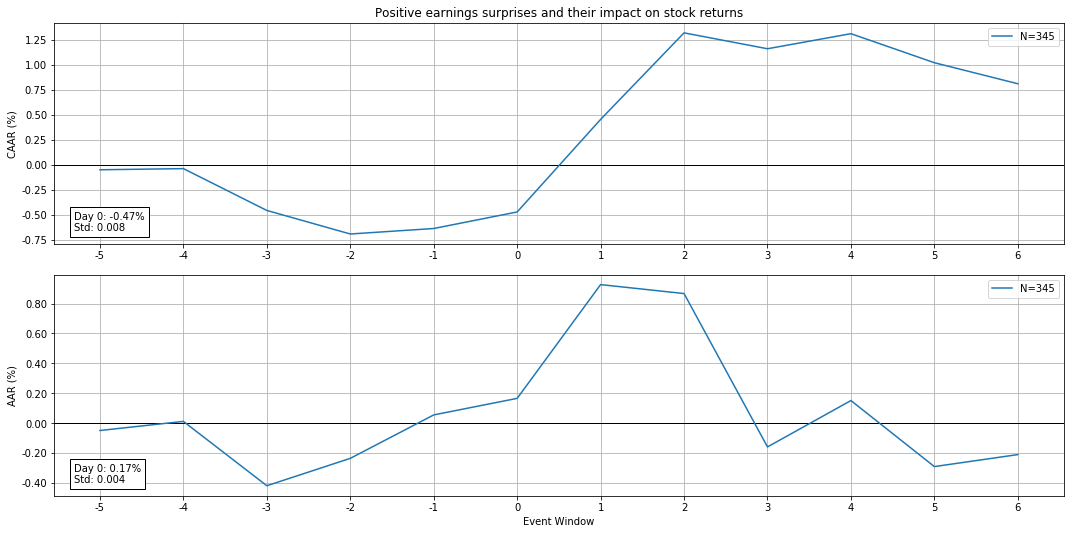


CAAR (%) for all the securities over the event window:
-6    -5    -4    -3    -2    -1     0     1     2     3     4     5     6
NaN -0.05 -0.04 -0.46 -0.69 -0.64 -0.47  0.45  1.32  1.16  1.31  1.02  0.81

AAR (%) for all the securities over the event window:
-6    -5    -4    -3    -2    -1     0     1     2     3     4     5     6
NaN -0.05  0.01 -0.42 -0.24  0.05  0.17  0.93  0.87 -0.16  0.15 -0.29 -0.21


In [9]:
def run_positive_earnings_event_study():

    """
    This is an event study on mass shootings and their impact on firearm securities.
    """
    
    start_date = dt.datetime(2017, 1, 1)
    end_date = dt.datetime(2017, 12, 31)
    value_threshold = 50.0
    
    positive = True 
    run_event_study(start_date, end_date, value_threshold, positive)
    
run_positive_earnings_event_study()

Event list has 260 events.

Negative earning surprises in the list: 260
Negative earning surprises processed  : 260 



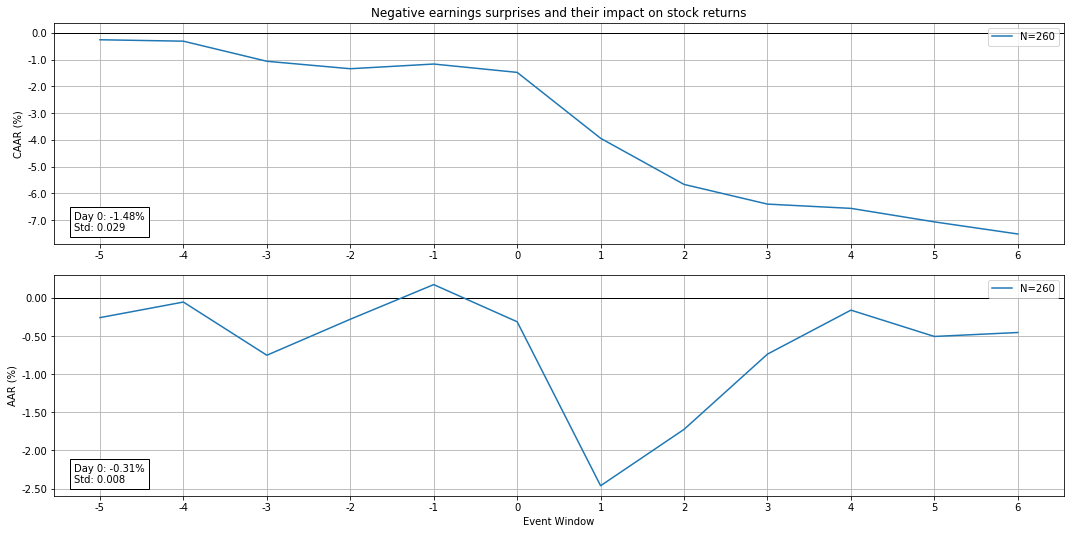


CAAR (%) for all the securities over the event window:
-6    -5    -4    -3    -2    -1     0     1     2    3     4     5     6
NaN -0.26 -0.31 -1.06 -1.34 -1.17 -1.48 -3.94 -5.66 -6.4 -6.56 -7.06 -7.52

AAR (%) for all the securities over the event window:
-6    -5    -4    -3    -2    -1     0     1     2     3     4    5     6
NaN -0.26 -0.05 -0.75 -0.28  0.18 -0.31 -2.46 -1.72 -0.74 -0.16 -0.5 -0.45


In [10]:
def run_negative_earnings_event_study():

    """
    This is an event study on mass shootings and their impact on firearm securities.
    """
    
    start_date = dt.datetime(2017, 1, 1)
    end_date = dt.datetime(2017, 12, 31)
    value_threshold = 50.0

    positive = False
    run_event_study(start_date, end_date, value_threshold, positive)
    
run_negative_earnings_event_study()